### To do 

gal['data'].shape = 3, npix, npix -> gal['img'], gal['mask'], gal['weight'].   'mask' needs to be boolean.

In [1]:
import matplotlib as mpl
import numpy as np
from glob import glob
import matplotlib.pyplot as plt 
import pickle

import astrobf
from astrobf.utils import mask_utils
from astrobf.utils.mask_utils import *
from astrobf.utils import gen_mask
from astrobf.morph import measure_morph

from astrobf.run import Full_exp
from astrobf.analysis.binary_clustering import *
from astrobf.analysis.utils import *

from astrobf.morph import custom_morph
from astrobf.analysis import multi_clustering as mucl
from astrobf.analysis.multi_clustering import labeler

import time

import random
import importlib

mpl.rcParams['savefig.facecolor'] = 'white'

## AX
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.ax_client import AxClient

## 1. Load the all-in-one data

### All_gals data

all-gals is a list of dictionaries, each of which contains 
(ndarray image, string image_name, and slices slice)


In [2]:
fn = "../../bf_data/Nair_and_Abraham_2010/all_gals.pickle"
all_gals = pickle.load(open(fn, "rb"))

all_gals = all_gals[1:] # Why the first galaxy image is NaN?

good_gids = np.array([gal['img_name'] for gal in all_gals])

### Append Asym center to all_gals

In [3]:
asym_center = pickle.load(open("./mean_center_asym.pickle", "rb"))

for ag in all_gals:
    ind = np.where(asym_center['id'] == ag['img_name'])[0]
    ag.update({'asym_center':np.array((asym_center['xc_asym'][ind],
                                       asym_center['yc_asym'][ind])).squeeze()})


### 2. Load galaxy catalog data and initial morph measurements

Just in case, only for the initial morphology measurement, full results are saved. 

In [4]:
from astrobf.utils.misc import load_Nair
importlib.reload(astrobf.utils.misc)

cat_data = load_Nair('../../bf_data/Nair_and_Abraham_2010/catalog/table2.dat')
# pd dataframe

cat = cat_data[cat_data['ID'].isin(good_gids)]
# Leave only needed fields.

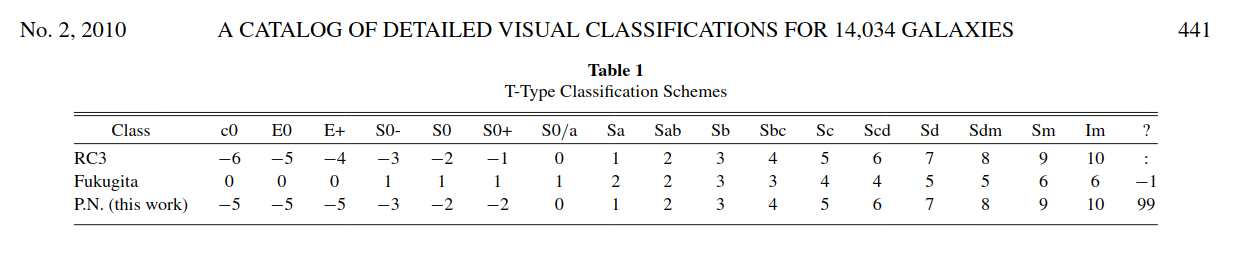

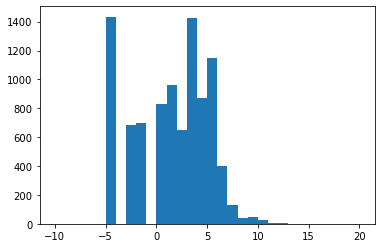

In [4]:
plt.hist(cat['TT'], range=[-10,20], bins=30)
plt.show()

2 groups : [-5, -1],        [3,5]

4 groups : [-5, -1], [0,2], [3,5], [6,9]  

6 groups : [-5,-5], [-3, -1], [0,2], [3,4], [5,6], [7,9]

8 groups : [-5,-5], [-3, -1], [0,1], [2,3], [4,5], [6,7], [8,9], [10, ~]

# Run Bayesian Optimization loop

### Initialize BO loop -  Measure morphology features

In [5]:
## Runtime config.

fields = ['gini', 'm20', 'asymmetry']#, 'concentration', 'asymmetry', 'smoothness']
label_field = 'TT'

Catalog에서 outlier를 버렸으므로 원래의 catalog/all_gals보다 길이가 짧은 result_arr가 나옴. 
시작할 때 sample을 정하고, 나머지는 잘라버린 뒤에 optimization을 수행하는게 맞을 듯. 

그럼 good_gids도 업데이트해야됨. 


이거 머리 아프니까 한 덩어리로 합치면 좋겠는데.! 

class dataset():
    def __init__(self):

### Test evaluate

Need to be dl > dh ? 

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10



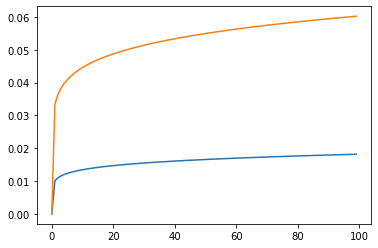

In [51]:
from astrobf.tmo import Mantiuk_Seidel
for i in [0,1]:
    plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **mucl.ext_single_param(params, f"{i}")))

In [37]:
importlib.reload(custom_morph)

<module 'astrobf.morph.custom_morph' from '/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py'>

In [7]:
np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [6]:
from functools import partial

def evaluate(params, cluster_method="agglomerate", eval_method='sample-weighted FMS', debug=False):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(ngroups)]

    result_list = []
    for i in range(ngroups):
        result_list.append(mucl.get_morph(sub_gals, 
                                          plist[i], 
                                          np.where(subcat['label'] == i)[0],
                                          fields)
                                          )
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # merge and sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]
    
    Full_exp.add_ttype(result_arr, subcat)
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                                  fields=fields, 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    #return eval_metrics
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}

# Test evaluate

In [11]:
params = {'b0': 6.5994335621336555,
         'c0': 3.8522801643712445,
         'dl0': 13.850014672900969,
         'dh0': 1.0,
         'b1': 6.129207334451078,
         'c1': 1.207514275741114,
         'dl1': 13.0,
         'dh1': 2.0380281794991895,
         'b2': 6.5994335621336555,
         'c2': 3.8522801643712445,
         'dl2': 13.850014672900969,
         'dh2': 1.0,
         'b3': 6.129207334451078,
         'c3': 7.207514275741114,
         'dl3': 1.0,
         'dh3': 6.0380281794991895}

ngroups = 4
this_bin, bin_mask = mucl.gen_bin_n_mask(ngroups)        
ax_params = mucl.gen_tmo_param_sets(ngroups)

subcat = mucl.sample_in_bins(cat, ngroups, this_bin)
print("# of sub sample: {}".format(len(subcat)))

sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# of sub sample: 7095


J004236.85m104922.04

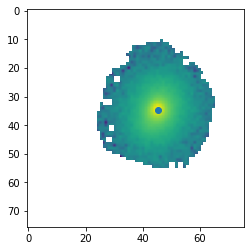

In [76]:
ag = all_gals[174]

img, mask, ww = ag['data']
xc, yc = ag['asym_center']
plt.imshow(np.log10(img))
plt.scatter(xc, yc)
plt.show()

In [62]:
plist = [{'b': 6.46, 'c': 5.72, 'dl': 2.9,  'dh': 1.48},
         {'b': 6.0,  'c': 3.96, 'dl': 9.22, 'dh': 2.45},
         {'b': 4.47, 'c': 5.77, 'dl': 10.24,'dh': 7.4},
         {'b': 7.91, 'c': 6.45, 'dl': 9.21, 'dh': 6.7}]

In [91]:
importlib.reload(mucl)
importlib.reload(custom_morph)

ag = all_gals[174]

plist =[{'b':params[f'b{i}'],
         'c':params[f'c{i}'],
        'dl':params[f'dl{i}'],
        'dh':params[f'dh{i}']} for i in range(ngroups)]
mi = mucl.MorphImg(ag, plist[3])
#plt.imshow(mi._tonemapped)

mi.measure_all()

[deviation] Nonpositive flux within Gini segmap.


-99

In [12]:
results = evaluate(params, "ward")

[asymmetry_function] Zero flux sum.
ERROR in 53-th galaxy


In [8]:
# 0.45x is the lowest value of maximum flux of all images.
exp_dir='./Experiments/'
for ngroups in [2,4,6,8][1:]:
    this_bin, bin_mask = mucl.gen_bin_n_mask(ngroups)        
    ax_params = mucl.gen_tmo_param_sets(ngroups)
        
    subcat = mucl.sample_in_bins(cat, ngroups, this_bin, bin_mask=bin_mask)
    #subcat = subcat

    print("# of sub sample: {}".format(len(subcat)))

    sub_gals = [gal for gal in all_gals if gal['img_name'] in subcat['ID']]
    
        
    for fn_result, cluster_method in zip([f"FMS_{ngroups}G_ward_asym",
                                          f"FMS_{ngroups}G_agg_asym",
                                          f"FMS_{ngroups}G_spec_asym"][:1],
                                         ['ward', 'agglomerate', 'spectral'][:1]):

        axc = AxClient()

        axc.create_experiment(
            parameters=ax_params,
            objective_name="mymetric",
            #minimize=True,  # Optional, defaults to False.
            parameter_constraints=[f"b{i} - dl{i} <= 100" for i in range(ngroups)] + \
                                  [f"dl{i} - dh{i} >= 0.1" for i in range(ngroups)], # all images are stretched to 100
            overwrite_existing_experiment =True,
            outcome_constraints=["total_flux >= 1e-5"],  # Optional.
        )

        all_metrics=[] # appended inside evaluate()
        for i in range(400):
            parameters, trial_index = axc.get_next_trial()
            axc.complete_trial(trial_index=trial_index,
                               raw_data=evaluate(parameters,
                                                 cluster_method=cluster_method))

        pickle.dump(all_metrics, open(exp_dir+fn_result+"_all_metrics.pickle", "wb"))

        if True:
            axc.save_to_json_file(exp_dir+fn_result+".json")
        else:
            axc = AxClient.load_from_json_file(exp_dir+fn_result+'.json')

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

[INFO 06-05 00:34:06] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 06-05 0

# of sub sample: 9313


[INFO 06-05 00:34:06] ax.service.ax_client: Generated new trial 0 with parameters {'b0': 2.04, 'c0': 6.24, 'dl0': 12.25, 'dh0': 5.92, 'b1': 6.19, 'c1': 7.26, 'dl1': 14.0, 'dh1': 5.22, 'b2': 6.23, 'c2': 4.09, 'dl2': 5.39, 'dh2': 2.28, 'b3': 4.81, 'c3': 5.95, 'dl3': 9.0, 'dh3': 2.98}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_mi

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 00:35:42] ax.service.ax_client: Completed trial 0 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:35:42] ax.service.ax_client: Generated new trial 1 with parameters {'b0': 6.58, 'c0': 1.77, 'dl0': 10.47, 'dh0': 3.64, 'b1': 3.67, 'c1': 1.51, 'dl1': 9.57, 'dh1': 3.27, 'b2': 6.67, 'c2': 3.1, 'dl2': 8.38, 'dh2': 1.94, 'b3': 6.17, 'c3': 1.96, 'dl3': 14.19, 'dh3': 4.63}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71a

Is every element matched?:  True


[INFO 06-05 00:37:36] ax.service.ax_client: Completed trial 1 with data: {'mymetric': (0.57999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:37:36] ax.service.ax_client: Generated new trial 2 with parameters {'b0': 3.98, 'c0': 6.15, 'dl0': 13.69, 'dh0': 10.17, 'b1': 3.72, 'c1': 5.88, 'dl1': 14.14, 'dh1': 3.4, 'b2': 4.14, 'c2': 1.82, 'dl2': 12.23, 'dh2': 11.93, 'b3': 1.79, 'c3': 6.12, 'dl3': 12.84, 'dh3': 1.94}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipytho

Is every element matched?:  True


[INFO 06-05 00:39:27] ax.service.ax_client: Completed trial 2 with data: {'mymetric': (0.52000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:39:27] ax.service.ax_client: Generated new trial 3 with parameters {'b0': 2.84, 'c0': 6.59, 'dl0': 12.22, 'dh0': 9.79, 'b1': 5.89, 'c1': 7.39, 'dl1': 13.93, 'dh1': 4.16, 'b2': 6.13, 'c2': 6.48, 'dl2': 8.86, 'dh2': 6.42, 'b3': 2.37, 'c3': 2.01, 'dl3': 13.18, 'dh3': 1.28}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 00:41:18] ax.service.ax_client: Completed trial 3 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:41:18] ax.service.ax_client: Generated new trial 4 with parameters {'b0': 5.42, 'c0': 6.86, 'dl0': 13.36, 'dh0': 7.96, 'b1': 7.76, 'c1': 4.34, 'dl1': 11.68, 'dh1': 6.47, 'b2': 5.22, 'c2': 2.0, 'dl2': 9.13, 'dh2': 1.18, 'b3': 7.4, 'c3': 4.03, 'dl3': 11.15, 'dh3': 7.59}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 00:43:09] ax.service.ax_client: Completed trial 4 with data: {'mymetric': (0.46999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:43:09] ax.service.ax_client: Generated new trial 5 with parameters {'b0': 6.88, 'c0': 4.41, 'dl0': 14.82, 'dh0': 7.05, 'b1': 5.92, 'c1': 5.42, 'dl1': 11.96, 'dh1': 9.17, 'b2': 2.03, 'c2': 3.69, 'dl2': 9.0, 'dh2': 3.42, 'b3': 3.79, 'c3': 3.17, 'dl3': 14.25, 'dh3': 3.83}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-i

Is every element matched?:  True


[INFO 06-05 00:44:59] ax.service.ax_client: Completed trial 5 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:44:59] ax.service.ax_client: Generated new trial 6 with parameters {'b0': 4.69, 'c0': 3.19, 'dl0': 12.82, 'dh0': 2.3, 'b1': 1.75, 'c1': 5.2, 'dl1': 9.34, 'dh1': 4.27, 'b2': 2.17, 'c2': 4.53, 'dl2': 13.27, 'dh2': 3.71, 'b3': 2.9, 'c3': 7.33, 'dl3': 12.65, 'dh3': 11.21}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 00:46:49] ax.service.ax_client: Completed trial 6 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:46:49] ax.service.ax_client: Generated new trial 7 with parameters {'b0': 5.44, 'c0': 3.56, 'dl0': 14.41, 'dh0': 10.87, 'b1': 6.97, 'c1': 5.53, 'dl1': 13.83, 'dh1': 1.52, 'b2': 1.52, 'c2': 6.9, 'dl2': 5.78, 'dh2': 1.0, 'b3': 7.64, 'c3': 2.76, 'dl3': 14.63, 'dh3': 6.35}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71

Is every element matched?:  True


[INFO 06-05 00:48:36] ax.service.ax_client: Completed trial 7 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:48:36] ax.service.ax_client: Generated new trial 8 with parameters {'b0': 2.4, 'c0': 3.16, 'dl0': 3.59, 'dh0': 1.28, 'b1': 5.46, 'c1': 4.03, 'dl1': 14.54, 'dh1': 2.81, 'b2': 4.68, 'c2': 7.38, 'dl2': 6.5, 'dh2': 1.47, 'b3': 7.56, 'c3': 7.79, 'dl3': 12.34, 'dh3': 2.36}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 00:50:25] ax.service.ax_client: Completed trial 8 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:50:25] ax.service.ax_client: Generated new trial 9 with parameters {'b0': 7.78, 'c0': 6.66, 'dl0': 6.04, 'dh0': 5.25, 'b1': 2.51, 'c1': 4.18, 'dl1': 10.03, 'dh1': 9.69, 'b2': 3.49, 'c2': 6.53, 'dl2': 14.59, 'dh2': 14.38, 'b3': 4.74, 'c3': 4.72, 'dl3': 7.22, 'dh3': 2.46}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd7

Is every element matched?:  True


[INFO 06-05 00:51:55] ax.service.ax_client: Completed trial 9 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:51:55] ax.service.ax_client: Generated new trial 10 with parameters {'b0': 4.32, 'c0': 2.3, 'dl0': 14.2, 'dh0': 4.07, 'b1': 6.28, 'c1': 5.43, 'dl1': 11.48, 'dh1': 4.41, 'b2': 4.96, 'c2': 3.04, 'dl2': 8.04, 'dh2': 6.92, 'b3': 4.51, 'c3': 4.99, 'dl3': 11.94, 'dh3': 10.99}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 00:53:46] ax.service.ax_client: Completed trial 10 with data: {'mymetric': (0.57999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:53:46] ax.service.ax_client: Generated new trial 11 with parameters {'b0': 1.61, 'c0': 5.92, 'dl0': 14.56, 'dh0': 9.02, 'b1': 7.13, 'c1': 7.47, 'dl1': 14.97, 'dh1': 13.58, 'b2': 5.81, 'c2': 2.47, 'dl2': 5.32, 'dh2': 2.57, 'b3': 6.27, 'c3': 1.53, 'dl3': 10.43, 'dh3': 2.93}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipyth

Is every element matched?:  True


[INFO 06-05 00:55:18] ax.service.ax_client: Completed trial 11 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:55:18] ax.service.ax_client: Generated new trial 12 with parameters {'b0': 4.12, 'c0': 6.05, 'dl0': 5.71, 'dh0': 1.59, 'b1': 2.84, 'c1': 7.04, 'dl1': 7.29, 'dh1': 3.4, 'b2': 2.33, 'c2': 7.78, 'dl2': 8.59, 'dh2': 4.25, 'b3': 6.72, 'c3': 5.79, 'dl3': 5.46, 'dh3': 2.72}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.


/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py:342: RuntimeWarning:

invalid value encountered in double_scalars

[INFO 06-05 00:57:00] ax.service.ax_client: Completed trial 12 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 06-05 00:57:00] ax.service.ax_client: Generated new trial 13 with parameters {'b0': 5.91, 'c0': 7.87, 'dl0': 13.83, 'dh0': 6.41, 'b1': 4.09, 'c1': 4.24, 'dl1': 10.19, 'dh1': 1.77, 'b2': 4.12, 'c2': 6.89, 'dl2': 14.69, 'dh2': 14.07, 'b3': 2.43, 'c3': 5.88, 'dl3': 4.52, 'dh3': 4.14}.


[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[asymmetry_function] Zero flux sum.
ERROR in 517-th galaxy J153305.61m013741.67


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 00:58:52] ax.service.ax_client: Completed trial 13 with data: {'mymetric': (0.51000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 00:58:52] ax.service.ax_client: Generated new trial 14 with parameters {'b0': 2.09, 'c0': 2.15, 'dl0': 13.46, 'dh0': 2.78, 'b1': 6.13, 'c1': 4.96, 'dl1': 14.01, 'dh1': 7.65, 'b2': 6.22, 'c2': 5.88, 'dl2': 13.22, 'dh2': 3.72, 'b3': 3.91, 'c3': 6.92, 'dl3': 3.71, 'dh3': 1.87}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipytho

Is every element matched?:  True


[INFO 06-05 01:00:42] ax.service.ax_client: Completed trial 14 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:00:43] ax.service.ax_client: Generated new trial 15 with parameters {'b0': 1.63, 'c0': 5.39, 'dl0': 6.38, 'dh0': 2.15, 'b1': 2.12, 'c1': 6.59, 'dl1': 9.35, 'dh1': 3.72, 'b2': 7.75, 'c2': 2.1, 'dl2': 9.35, 'dh2': 4.37, 'b3': 7.0, 'c3': 6.33, 'dl3': 9.67, 'dh3': 6.48}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 01:02:32] ax.service.ax_client: Completed trial 15 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:02:36] ax.service.ax_client: Generated new trial 16 with parameters {'b0': 1.75, 'c0': 6.01, 'dl0': 13.66, 'dh0': 7.86, 'b1': 6.73, 'c1': 7.42, 'dl1': 14.65, 'dh1': 10.26, 'b2': 5.98, 'c2': 3.2, 'dl2': 5.39, 'dh2': 2.57, 'b3': 5.57, 'c3': 3.2, 'dl3': 9.97, 'dh3': 2.83}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd7

Is every element matched?:  True


[INFO 06-05 01:04:07] ax.service.ax_client: Completed trial 16 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:04:12] ax.service.ax_client: Generated new trial 17 with parameters {'b0': 2.05, 'c0': 6.01, 'dl0': 13.01, 'dh0': 7.6, 'b1': 6.42, 'c1': 7.24, 'dl1': 14.64, 'dh1': 6.93, 'b2': 6.23, 'c2': 4.34, 'dl2': 6.28, 'dh2': 3.32, 'b3': 4.36, 'c3': 4.03, 'dl3': 10.56, 'dh3': 2.43}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython

Is every element matched?:  True


[INFO 06-05 01:05:52] ax.service.ax_client: Completed trial 17 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:05:57] ax.service.ax_client: Generated new trial 18 with parameters {'b0': 2.09, 'c0': 5.96, 'dl0': 14.1, 'dh0': 9.41, 'b1': 6.81, 'c1': 7.41, 'dl1': 14.74, 'dh1': 11.22, 'b2': 5.73, 'c2': 3.65, 'dl2': 6.39, 'dh2': 3.7, 'b3': 5.08, 'c3': 1.5, 'dl3': 11.55, 'dh3': 2.4}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-i

Is every element matched?:  True


[INFO 06-05 01:07:45] ax.service.ax_client: Completed trial 18 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:07:50] ax.service.ax_client: Generated new trial 19 with parameters {'b0': 1.5, 'c0': 5.04, 'dl0': 14.14, 'dh0': 8.22, 'b1': 7.2, 'c1': 6.72, 'dl1': 15.0, 'dh1': 12.01, 'b2': 6.6, 'c2': 3.37, 'dl2': 6.95, 'dh2': 2.93, 'b3': 5.61, 'c3': 2.22, 'dl3': 9.94, 'dh3': 2.41}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71a

Is every element matched?:  True


[INFO 06-05 01:09:34] ax.service.ax_client: Completed trial 19 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:09:39] ax.service.ax_client: Generated new trial 20 with parameters {'b0': 1.5, 'c0': 6.74, 'dl0': 13.87, 'dh0': 9.41, 'b1': 7.19, 'c1': 7.57, 'dl1': 15.0, 'dh1': 10.55, 'b2': 7.16, 'c2': 2.99, 'dl2': 5.15, 'dh2': 2.99, 'b3': 5.61, 'c3': 1.86, 'dl3': 10.77, 'dh3': 2.73}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 06-05 01:10:36] ax.service.ax_client: Completed trial 20 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000047.89p141639.09


[INFO 06-05 01:10:41] ax.service.ax_client: Generated new trial 21 with parameters {'b0': 1.74, 'c0': 5.08, 'dl0': 14.02, 'dh0': 7.8, 'b1': 6.89, 'c1': 6.9, 'dl1': 14.79, 'dh1': 11.62, 'b2': 5.85, 'c2': 3.41, 'dl2': 6.67, 'dh2': 2.81, 'b3': 5.55, 'c3': 2.73, 'dl3': 9.93, 'dh3': 2.56}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfo

Is every element matched?:  True


[INFO 06-05 01:12:29] ax.service.ax_client: Completed trial 21 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:12:33] ax.service.ax_client: Generated new trial 22 with parameters {'b0': 2.16, 'c0': 6.03, 'dl0': 12.83, 'dh0': 6.96, 'b1': 6.25, 'c1': 7.36, 'dl1': 14.07, 'dh1': 7.54, 'b2': 5.64, 'c2': 4.0, 'dl2': 5.83, 'dh2': 2.85, 'b3': 4.92, 'c3': 4.43, 'dl3': 9.83, 'dh3': 2.77}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 01:14:16] ax.service.ax_client: Completed trial 22 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:14:21] ax.service.ax_client: Generated new trial 23 with parameters {'b0': 1.77, 'c0': 5.94, 'dl0': 14.34, 'dh0': 8.39, 'b1': 6.75, 'c1': 7.66, 'dl1': 15.0, 'dh1': 11.81, 'b2': 5.36, 'c2': 2.85, 'dl2': 4.98, 'dh2': 2.54, 'b3': 5.65, 'c3': 2.61, 'dl3': 10.55, 'dh3': 2.82}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipytho

Is every element matched?:  True


[INFO 06-05 01:15:55] ax.service.ax_client: Completed trial 23 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:16:00] ax.service.ax_client: Generated new trial 24 with parameters {'b0': 1.78, 'c0': 5.39, 'dl0': 13.08, 'dh0': 6.31, 'b1': 6.52, 'c1': 6.92, 'dl1': 14.63, 'dh1': 7.88, 'b2': 6.23, 'c2': 3.8, 'dl2': 6.1, 'dh2': 2.3, 'b3': 5.07, 'c3': 4.96, 'dl3': 9.18, 'dh3': 2.77}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 01:17:38] ax.service.ax_client: Completed trial 24 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:17:42] ax.service.ax_client: Generated new trial 25 with parameters {'b0': 2.18, 'c0': 5.89, 'dl0': 12.93, 'dh0': 8.03, 'b1': 6.66, 'c1': 7.16, 'dl1': 13.55, 'dh1': 12.06, 'b2': 5.67, 'c2': 3.32, 'dl2': 6.67, 'dh2': 3.19, 'b3': 6.51, 'c3': 1.88, 'dl3': 9.34, 'dh3': 2.99}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipytho

Is every element matched?:  True


[INFO 06-05 01:19:31] ax.service.ax_client: Completed trial 25 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:19:36] ax.service.ax_client: Generated new trial 26 with parameters {'b0': 1.65, 'c0': 5.97, 'dl0': 15.0, 'dh0': 8.31, 'b1': 7.4, 'c1': 6.7, 'dl1': 15.0, 'dh1': 9.79, 'b2': 5.75, 'c2': 3.7, 'dl2': 7.19, 'dh2': 2.62, 'b3': 4.75, 'c3': 3.33, 'dl3': 9.52, 'dh3': 2.69}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inpu

Is every element matched?:  True


[INFO 06-05 01:21:25] ax.service.ax_client: Completed trial 26 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:21:30] ax.service.ax_client: Generated new trial 27 with parameters {'b0': 1.5, 'c0': 5.68, 'dl0': 13.37, 'dh0': 8.22, 'b1': 6.89, 'c1': 6.63, 'dl1': 15.0, 'dh1': 8.43, 'b2': 5.77, 'c2': 2.85, 'dl2': 5.68, 'dh2': 4.36, 'b3': 5.1, 'c3': 3.04, 'dl3': 11.37, 'dh3': 3.53}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71

Is every element matched?:  True


[INFO 06-05 01:23:08] ax.service.ax_client: Completed trial 27 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:23:14] ax.service.ax_client: Generated new trial 28 with parameters {'b0': 1.65, 'c0': 5.71, 'dl0': 14.75, 'dh0': 8.45, 'b1': 5.91, 'c1': 7.42, 'dl1': 15.0, 'dh1': 9.74, 'b2': 5.86, 'c2': 2.75, 'dl2': 7.67, 'dh2': 3.76, 'b3': 4.68, 'c3': 3.39, 'dl3': 10.24, 'dh3': 3.42}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython

Is every element matched?:  True


[INFO 06-05 01:25:04] ax.service.ax_client: Completed trial 28 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:25:09] ax.service.ax_client: Generated new trial 29 with parameters {'b0': 1.5, 'c0': 5.81, 'dl0': 13.41, 'dh0': 8.32, 'b1': 6.69, 'c1': 6.42, 'dl1': 15.0, 'dh1': 10.75, 'b2': 5.81, 'c2': 3.79, 'dl2': 5.62, 'dh2': 2.9, 'b3': 5.49, 'c3': 3.75, 'dl3': 12.51, 'dh3': 1.5}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-i

Is every element matched?:  True


[INFO 06-05 01:26:46] ax.service.ax_client: Completed trial 29 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:26:51] ax.service.ax_client: Generated new trial 30 with parameters {'b0': 1.5, 'c0': 5.62, 'dl0': 13.51, 'dh0': 8.69, 'b1': 7.06, 'c1': 7.1, 'dl1': 15.0, 'dh1': 7.36, 'b2': 5.78, 'c2': 3.37, 'dl2': 5.7, 'dh2': 1.21, 'b3': 5.5, 'c3': 2.44, 'dl3': 11.21, 'dh3': 1.97}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 01:28:29] ax.service.ax_client: Completed trial 30 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:28:35] ax.service.ax_client: Generated new trial 31 with parameters {'b0': 1.6, 'c0': 5.72, 'dl0': 11.92, 'dh0': 8.38, 'b1': 7.22, 'c1': 6.83, 'dl1': 15.0, 'dh1': 11.83, 'b2': 5.8, 'c2': 3.39, 'dl2': 4.86, 'dh2': 2.35, 'b3': 4.33, 'c3': 2.89, 'dl3': 10.52, 'dh3': 3.44}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_mi

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 01:30:00] ax.service.ax_client: Completed trial 31 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:30:05] ax.service.ax_client: Generated new trial 32 with parameters {'b0': 1.5, 'c0': 5.64, 'dl0': 13.85, 'dh0': 8.67, 'b1': 7.64, 'c1': 7.56, 'dl1': 15.0, 'dh1': 10.62, 'b2': 5.8, 'c2': 4.1, 'dl2': 5.13, 'dh2': 3.99, 'b3': 5.64, 'c3': 3.47, 'dl3': 11.47, 'dh3': 4.03}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 01:31:33] ax.service.ax_client: Completed trial 32 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:31:39] ax.service.ax_client: Generated new trial 33 with parameters {'b0': 1.5, 'c0': 5.71, 'dl0': 13.44, 'dh0': 6.8, 'b1': 7.59, 'c1': 7.4, 'dl1': 15.0, 'dh1': 10.13, 'b2': 5.82, 'c2': 3.51, 'dl2': 4.94, 'dh2': 4.84, 'b3': 4.81, 'c3': 2.98, 'dl3': 10.55, 'dh3': 1.1}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_mi

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 01:33:04] ax.service.ax_client: Completed trial 33 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:33:10] ax.service.ax_client: Generated new trial 34 with parameters {'b0': 2.18, 'c0': 5.68, 'dl0': 15.0, 'dh0': 8.88, 'b1': 6.88, 'c1': 6.47, 'dl1': 15.0, 'dh1': 10.41, 'b2': 5.82, 'c2': 3.7, 'dl2': 3.44, 'dh2': 3.3, 'b3': 5.29, 'c3': 2.95, 'dl3': 10.27, 'dh3': 3.61}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 06-05 01:34:08] ax.service.ax_client: Completed trial 34 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000047.89p141639.09


[INFO 06-05 01:34:14] ax.service.ax_client: Generated new trial 35 with parameters {'b0': 1.5, 'c0': 5.69, 'dl0': 12.38, 'dh0': 7.9, 'b1': 7.59, 'c1': 7.51, 'dl1': 14.98, 'dh1': 12.08, 'b2': 5.62, 'c2': 3.39, 'dl2': 5.5, 'dh2': 2.99, 'b3': 4.84, 'c3': 2.96, 'dl3': 10.6, 'dh3': 3.06}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfor

Is every element matched?:  True


[INFO 06-05 01:35:53] ax.service.ax_client: Completed trial 35 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:35:58] ax.service.ax_client: Generated new trial 36 with parameters {'b0': 1.5, 'c0': 5.6, 'dl0': 14.01, 'dh0': 8.47, 'b1': 6.6, 'c1': 6.8, 'dl1': 14.39, 'dh1': 11.42, 'b2': 5.64, 'c2': 3.81, 'dl2': 5.43, 'dh2': 3.75, 'b3': 5.48, 'c3': 2.18, 'dl3': 9.98, 'dh3': 3.22}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71a

Is every element matched?:  True


[INFO 06-05 01:37:34] ax.service.ax_client: Completed trial 36 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:37:39] ax.service.ax_client: Generated new trial 37 with parameters {'b0': 1.5, 'c0': 5.63, 'dl0': 11.96, 'dh0': 7.19, 'b1': 7.01, 'c1': 7.16, 'dl1': 15.0, 'dh1': 8.51, 'b2': 5.82, 'c2': 3.51, 'dl2': 5.25, 'dh2': 2.74, 'b3': 4.38, 'c3': 4.75, 'dl3': 11.19, 'dh3': 3.27}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 01:39:09] ax.service.ax_client: Completed trial 37 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:39:15] ax.service.ax_client: Generated new trial 38 with parameters {'b0': 2.32, 'c0': 6.19, 'dl0': 14.92, 'dh0': 8.56, 'b1': 7.6, 'c1': 7.34, 'dl1': 15.0, 'dh1': 10.76, 'b2': 5.63, 'c2': 2.7, 'dl2': 5.62, 'dh2': 3.72, 'b3': 6.12, 'c3': 3.21, 'dl3': 11.55, 'dh3': 2.59}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 01:40:56] ax.service.ax_client: Completed trial 38 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:41:01] ax.service.ax_client: Generated new trial 39 with parameters {'b0': 2.13, 'c0': 5.74, 'dl0': 13.28, 'dh0': 8.54, 'b1': 6.87, 'c1': 6.4, 'dl1': 14.24, 'dh1': 8.57, 'b2': 6.17, 'c2': 4.25, 'dl2': 7.29, 'dh2': 4.19, 'b3': 5.18, 'c3': 2.38, 'dl3': 11.23, 'dh3': 2.46}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython

Is every element matched?:  True


[INFO 06-05 01:42:51] ax.service.ax_client: Completed trial 39 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:42:57] ax.service.ax_client: Generated new trial 40 with parameters {'b0': 1.5, 'c0': 6.72, 'dl0': 14.56, 'dh0': 9.29, 'b1': 5.98, 'c1': 6.83, 'dl1': 15.0, 'dh1': 8.93, 'b2': 5.89, 'c2': 3.19, 'dl2': 6.62, 'dh2': 2.58, 'b3': 5.33, 'c3': 3.72, 'dl3': 10.47, 'dh3': 4.16}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 01:44:43] ax.service.ax_client: Completed trial 40 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:44:49] ax.service.ax_client: Generated new trial 41 with parameters {'b0': 1.5, 'c0': 6.35, 'dl0': 15.0, 'dh0': 6.82, 'b1': 6.85, 'c1': 7.48, 'dl1': 14.42, 'dh1': 8.65, 'b2': 6.01, 'c2': 2.95, 'dl2': 6.88, 'dh2': 4.78, 'b3': 4.65, 'c3': 2.54, 'dl3': 8.94, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 01:46:37] ax.service.ax_client: Completed trial 41 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:46:43] ax.service.ax_client: Generated new trial 42 with parameters {'b0': 2.22, 'c0': 5.93, 'dl0': 14.63, 'dh0': 9.24, 'b1': 6.86, 'c1': 7.72, 'dl1': 15.0, 'dh1': 11.99, 'b2': 6.18, 'c2': 3.9, 'dl2': 7.21, 'dh2': 1.4, 'b3': 4.52, 'c3': 2.68, 'dl3': 8.34, 'dh3': 2.5}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 01:48:33] ax.service.ax_client: Completed trial 42 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:48:39] ax.service.ax_client: Generated new trial 43 with parameters {'b0': 1.5, 'c0': 6.64, 'dl0': 12.57, 'dh0': 6.12, 'b1': 7.02, 'c1': 6.72, 'dl1': 15.0, 'dh1': 5.25, 'b2': 5.93, 'c2': 4.63, 'dl2': 5.85, 'dh2': 5.02, 'b3': 5.76, 'c3': 5.01, 'dl3': 9.55, 'dh3': 2.58}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-i

Is every element matched?:  True


[INFO 06-05 01:50:18] ax.service.ax_client: Completed trial 43 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:50:24] ax.service.ax_client: Generated new trial 44 with parameters {'b0': 2.27, 'c0': 6.74, 'dl0': 11.94, 'dh0': 6.08, 'b1': 6.38, 'c1': 5.72, 'dl1': 13.53, 'dh1': 5.3, 'b2': 5.97, 'c2': 3.51, 'dl2': 5.96, 'dh2': 2.88, 'b3': 4.15, 'c3': 5.0, 'dl3': 9.08, 'dh3': 1.92}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71

Is every element matched?:  True


[INFO 06-05 01:52:05] ax.service.ax_client: Completed trial 44 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:52:11] ax.service.ax_client: Generated new trial 45 with parameters {'b0': 1.5, 'c0': 6.1, 'dl0': 11.91, 'dh0': 8.37, 'b1': 6.79, 'c1': 7.48, 'dl1': 15.0, 'dh1': 11.26, 'b2': 5.69, 'c2': 2.85, 'dl2': 5.18, 'dh2': 3.42, 'b3': 5.63, 'c3': 2.49, 'dl3': 12.09, 'dh3': 2.93}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 01:53:44] ax.service.ax_client: Completed trial 45 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:53:50] ax.service.ax_client: Generated new trial 46 with parameters {'b0': 1.53, 'c0': 5.84, 'dl0': 14.59, 'dh0': 9.57, 'b1': 7.1, 'c1': 7.13, 'dl1': 15.0, 'dh1': 7.59, 'b2': 5.87, 'c2': 4.02, 'dl2': 5.78, 'dh2': 4.87, 'b3': 4.5, 'c3': 4.78, 'dl3': 8.84, 'dh3': 1.73}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71a

Is every element matched?:  True


[INFO 06-05 01:55:30] ax.service.ax_client: Completed trial 46 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:55:36] ax.service.ax_client: Generated new trial 47 with parameters {'b0': 1.75, 'c0': 6.39, 'dl0': 15.0, 'dh0': 6.21, 'b1': 7.32, 'c1': 6.76, 'dl1': 15.0, 'dh1': 8.37, 'b2': 5.87, 'c2': 4.45, 'dl2': 5.69, 'dh2': 3.12, 'b3': 4.24, 'c3': 3.73, 'dl3': 10.74, 'dh3': 4.01}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd7

Is every element matched?:  True


[INFO 06-05 01:57:13] ax.service.ax_client: Completed trial 47 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:57:20] ax.service.ax_client: Generated new trial 48 with parameters {'b0': 1.5, 'c0': 5.7, 'dl0': 15.0, 'dh0': 7.71, 'b1': 7.45, 'c1': 7.18, 'dl1': 12.52, 'dh1': 6.9, 'b2': 5.91, 'c2': 4.2, 'dl2': 6.25, 'dh2': 4.79, 'b3': 5.16, 'c3': 4.21, 'dl3': 12.05, 'dh3': 3.92}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 01:59:05] ax.service.ax_client: Completed trial 48 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 01:59:11] ax.service.ax_client: Generated new trial 49 with parameters {'b0': 2.21, 'c0': 5.62, 'dl0': 15.0, 'dh0': 5.63, 'b1': 5.76, 'c1': 7.26, 'dl1': 15.0, 'dh1': 4.21, 'b2': 5.99, 'c2': 4.45, 'dl2': 5.8, 'dh2': 4.35, 'b3': 4.85, 'c3': 5.43, 'dl3': 10.54, 'dh3': 3.1}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 02:00:50] ax.service.ax_client: Completed trial 49 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:00:56] ax.service.ax_client: Generated new trial 50 with parameters {'b0': 2.77, 'c0': 5.44, 'dl0': 12.51, 'dh0': 7.79, 'b1': 7.35, 'c1': 6.51, 'dl1': 15.0, 'dh1': 7.69, 'b2': 5.94, 'c2': 4.64, 'dl2': 5.66, 'dh2': 4.06, 'b3': 5.15, 'c3': 4.08, 'dl3': 9.91, 'dh3': 3.83}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 02:02:34] ax.service.ax_client: Completed trial 50 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:02:40] ax.service.ax_client: Generated new trial 51 with parameters {'b0': 1.5, 'c0': 6.79, 'dl0': 14.19, 'dh0': 5.68, 'b1': 6.37, 'c1': 7.9, 'dl1': 13.57, 'dh1': 6.48, 'b2': 5.99, 'c2': 5.12, 'dl2': 5.81, 'dh2': 1.62, 'b3': 4.69, 'c3': 6.2, 'dl3': 8.83, 'dh3': 2.15}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 02:04:17] ax.service.ax_client: Completed trial 51 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:04:23] ax.service.ax_client: Generated new trial 52 with parameters {'b0': 1.5, 'c0': 6.71, 'dl0': 15.0, 'dh0': 6.19, 'b1': 6.58, 'c1': 7.51, 'dl1': 15.0, 'dh1': 10.68, 'b2': 5.87, 'c2': 5.26, 'dl2': 6.77, 'dh2': 4.04, 'b3': 4.71, 'c3': 4.18, 'dl3': 12.48, 'dh3': 1.36}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 02:06:10] ax.service.ax_client: Completed trial 52 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:06:16] ax.service.ax_client: Generated new trial 53 with parameters {'b0': 1.5, 'c0': 6.2, 'dl0': 15.0, 'dh0': 7.52, 'b1': 8.0, 'c1': 6.91, 'dl1': 15.0, 'dh1': 12.83, 'b2': 6.04, 'c2': 2.76, 'dl2': 7.07, 'dh2': 4.05, 'b3': 4.49, 'c3': 2.2, 'dl3': 12.47, 'dh3': 4.84}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 02:08:04] ax.service.ax_client: Completed trial 53 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:08:10] ax.service.ax_client: Generated new trial 54 with parameters {'b0': 1.5, 'c0': 5.97, 'dl0': 13.74, 'dh0': 6.75, 'b1': 6.97, 'c1': 7.98, 'dl1': 15.0, 'dh1': 6.6, 'b2': 5.81, 'c2': 4.58, 'dl2': 6.86, 'dh2': 3.73, 'b3': 3.88, 'c3': 2.48, 'dl3': 9.97, 'dh3': 5.94}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 02:09:59] ax.service.ax_client: Completed trial 54 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:10:05] ax.service.ax_client: Generated new trial 55 with parameters {'b0': 1.5, 'c0': 6.69, 'dl0': 13.76, 'dh0': 5.5, 'b1': 5.88, 'c1': 7.68, 'dl1': 13.81, 'dh1': 8.51, 'b2': 5.97, 'c2': 3.75, 'dl2': 5.73, 'dh2': 5.3, 'b3': 4.54, 'c3': 5.24, 'dl3': 9.34, 'dh3': 3.47}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 02:11:40] ax.service.ax_client: Completed trial 55 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:11:47] ax.service.ax_client: Generated new trial 56 with parameters {'b0': 1.5, 'c0': 5.97, 'dl0': 14.76, 'dh0': 8.63, 'b1': 7.45, 'c1': 7.17, 'dl1': 15.0, 'dh1': 12.38, 'b2': 5.72, 'c2': 2.79, 'dl2': 5.19, 'dh2': 2.01, 'b3': 4.33, 'c3': 2.9, 'dl3': 10.71, 'dh3': 3.25}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd7

Is every element matched?:  True


[INFO 06-05 02:13:16] ax.service.ax_client: Completed trial 56 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:13:22] ax.service.ax_client: Generated new trial 57 with parameters {'b0': 1.5, 'c0': 5.85, 'dl0': 12.24, 'dh0': 6.96, 'b1': 7.74, 'c1': 7.11, 'dl1': 15.0, 'dh1': 12.49, 'b2': 5.71, 'c2': 3.42, 'dl2': 5.11, 'dh2': 1.84, 'b3': 6.04, 'c3': 3.16, 'dl3': 8.71, 'dh3': 3.16}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 02:14:51] ax.service.ax_client: Completed trial 57 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:14:56] ax.service.ax_client: Generated new trial 58 with parameters {'b0': 1.5, 'c0': 6.07, 'dl0': 12.47, 'dh0': 5.37, 'b1': 5.92, 'c1': 7.59, 'dl1': 15.0, 'dh1': 6.63, 'b2': 5.98, 'c2': 5.18, 'dl2': 5.62, 'dh2': 2.93, 'b3': 4.24, 'c3': 4.18, 'dl3': 9.28, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 02:16:30] ax.service.ax_client: Completed trial 58 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:16:36] ax.service.ax_client: Generated new trial 59 with parameters {'b0': 1.5, 'c0': 5.12, 'dl0': 15.0, 'dh0': 6.74, 'b1': 8.0, 'c1': 6.8, 'dl1': 15.0, 'dh1': 9.58, 'b2': 6.32, 'c2': 3.16, 'dl2': 7.29, 'dh2': 2.85, 'b3': 4.99, 'c3': 5.29, 'dl3': 10.6, 'dh3': 2.03}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inpu

Is every element matched?:  True


[INFO 06-05 02:18:23] ax.service.ax_client: Completed trial 59 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:18:30] ax.service.ax_client: Generated new trial 60 with parameters {'b0': 1.5, 'c0': 5.84, 'dl0': 12.44, 'dh0': 9.96, 'b1': 8.0, 'c1': 7.91, 'dl1': 15.0, 'dh1': 9.79, 'b2': 6.01, 'c2': 2.96, 'dl2': 7.02, 'dh2': 4.1, 'b3': 5.25, 'c3': 4.63, 'dl3': 11.67, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 02:20:18] ax.service.ax_client: Completed trial 60 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:20:24] ax.service.ax_client: Generated new trial 61 with parameters {'b0': 1.5, 'c0': 5.78, 'dl0': 15.0, 'dh0': 7.26, 'b1': 8.0, 'c1': 7.71, 'dl1': 15.0, 'dh1': 8.94, 'b2': 6.12, 'c2': 3.13, 'dl2': 7.19, 'dh2': 1.0, 'b3': 6.77, 'c3': 3.24, 'dl3': 11.96, 'dh3': 1.47}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 02:22:13] ax.service.ax_client: Completed trial 61 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:22:19] ax.service.ax_client: Generated new trial 62 with parameters {'b0': 1.5, 'c0': 5.22, 'dl0': 15.0, 'dh0': 8.87, 'b1': 7.41, 'c1': 6.89, 'dl1': 15.0, 'dh1': 8.12, 'b2': 6.09, 'c2': 2.93, 'dl2': 7.03, 'dh2': 1.32, 'b3': 3.34, 'c3': 4.02, 'dl3': 13.16, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 02:24:07] ax.service.ax_client: Completed trial 62 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:24:12] ax.service.ax_client: Generated new trial 63 with parameters {'b0': 1.5, 'c0': 6.06, 'dl0': 10.94, 'dh0': 6.35, 'b1': 7.71, 'c1': 6.32, 'dl1': 15.0, 'dh1': 12.03, 'b2': 6.18, 'c2': 2.72, 'dl2': 7.24, 'dh2': 1.51, 'b3': 4.97, 'c3': 4.11, 'dl3': 10.4, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-i

Is every element matched?:  True


[INFO 06-05 02:26:00] ax.service.ax_client: Completed trial 63 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:26:06] ax.service.ax_client: Generated new trial 64 with parameters {'b0': 1.5, 'c0': 4.95, 'dl0': 15.0, 'dh0': 10.6, 'b1': 8.0, 'c1': 6.23, 'dl1': 15.0, 'dh1': 12.91, 'b2': 6.23, 'c2': 2.45, 'dl2': 7.32, 'dh2': 4.67, 'b3': 6.06, 'c3': 3.72, 'dl3': 10.07, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 02:27:55] ax.service.ax_client: Completed trial 64 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:28:00] ax.service.ax_client: Generated new trial 65 with parameters {'b0': 2.08, 'c0': 4.16, 'dl0': 7.03, 'dh0': 3.34, 'b1': 5.94, 'c1': 5.11, 'dl1': 14.72, 'dh1': 4.31, 'b2': 5.07, 'c2': 6.1, 'dl2': 6.69, 'dh2': 2.16, 'b3': 6.81, 'c3': 6.88, 'dl3': 12.45, 'dh3': 2.41}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 02:29:50] ax.service.ax_client: Completed trial 65 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:29:56] ax.service.ax_client: Generated new trial 66 with parameters {'b0': 2.93, 'c0': 6.16, 'dl0': 14.39, 'dh0': 6.27, 'b1': 7.8, 'c1': 7.42, 'dl1': 15.0, 'dh1': 7.82, 'b2': 5.85, 'c2': 2.76, 'dl2': 7.06, 'dh2': 3.86, 'b3': 5.03, 'c3': 5.56, 'dl3': 11.44, 'dh3': 2.67}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 02:31:45] ax.service.ax_client: Completed trial 66 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:31:52] ax.service.ax_client: Generated new trial 67 with parameters {'b0': 1.5, 'c0': 4.12, 'dl0': 12.7, 'dh0': 6.38, 'b1': 8.0, 'c1': 8.0, 'dl1': 15.0, 'dh1': 11.45, 'b2': 6.35, 'c2': 4.18, 'dl2': 7.26, 'dh2': 4.15, 'b3': 4.7, 'c3': 3.41, 'dl3': 11.52, 'dh3': 1.01}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 02:33:39] ax.service.ax_client: Completed trial 67 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:33:45] ax.service.ax_client: Generated new trial 68 with parameters {'b0': 1.5, 'c0': 6.01, 'dl0': 13.89, 'dh0': 9.15, 'b1': 8.0, 'c1': 6.81, 'dl1': 15.0, 'dh1': 7.38, 'b2': 6.2, 'c2': 5.08, 'dl2': 6.92, 'dh2': 1.92, 'b3': 5.28, 'c3': 5.48, 'dl3': 9.36, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inpu

Is every element matched?:  True


[INFO 06-05 02:35:32] ax.service.ax_client: Completed trial 68 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:35:38] ax.service.ax_client: Generated new trial 69 with parameters {'b0': 1.5, 'c0': 6.23, 'dl0': 14.42, 'dh0': 7.86, 'b1': 6.84, 'c1': 8.0, 'dl1': 15.0, 'dh1': 9.67, 'b2': 5.88, 'c2': 3.9, 'dl2': 5.91, 'dh2': 4.59, 'b3': 5.79, 'c3': 3.34, 'dl3': 11.82, 'dh3': 3.36}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 02:37:17] ax.service.ax_client: Completed trial 69 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:37:23] ax.service.ax_client: Generated new trial 70 with parameters {'b0': 1.5, 'c0': 5.86, 'dl0': 14.15, 'dh0': 9.11, 'b1': 7.9, 'c1': 7.39, 'dl1': 11.56, 'dh1': 10.29, 'b2': 6.18, 'c2': 3.9, 'dl2': 7.16, 'dh2': 1.35, 'b3': 4.98, 'c3': 5.03, 'dl3': 10.47, 'dh3': 2.75}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 02:39:11] ax.service.ax_client: Completed trial 70 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:39:17] ax.service.ax_client: Generated new trial 71 with parameters {'b0': 1.5, 'c0': 6.98, 'dl0': 11.68, 'dh0': 9.64, 'b1': 8.0, 'c1': 6.57, 'dl1': 15.0, 'dh1': 9.73, 'b2': 5.81, 'c2': 3.91, 'dl2': 6.41, 'dh2': 4.43, 'b3': 4.99, 'c3': 3.02, 'dl3': 11.82, 'dh3': 1.1}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 02:41:03] ax.service.ax_client: Completed trial 71 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:41:09] ax.service.ax_client: Generated new trial 72 with parameters {'b0': 1.5, 'c0': 6.63, 'dl0': 12.01, 'dh0': 7.9, 'b1': 5.48, 'c1': 7.36, 'dl1': 14.97, 'dh1': 4.7, 'b2': 6.01, 'c2': 4.72, 'dl2': 5.74, 'dh2': 1.34, 'b3': 5.11, 'c3': 6.37, 'dl3': 9.79, 'dh3': 5.63}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71a

Is every element matched?:  True


[INFO 06-05 02:42:43] ax.service.ax_client: Completed trial 72 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:42:50] ax.service.ax_client: Generated new trial 73 with parameters {'b0': 1.5, 'c0': 5.01, 'dl0': 12.63, 'dh0': 8.26, 'b1': 5.75, 'c1': 7.39, 'dl1': 15.0, 'dh1': 6.55, 'b2': 6.39, 'c2': 3.74, 'dl2': 7.09, 'dh2': 2.37, 'b3': 5.93, 'c3': 6.0, 'dl3': 10.08, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71a

Is every element matched?:  True


[INFO 06-05 02:44:37] ax.service.ax_client: Completed trial 73 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:44:43] ax.service.ax_client: Generated new trial 74 with parameters {'b0': 1.5, 'c0': 4.84, 'dl0': 12.16, 'dh0': 9.12, 'b1': 7.67, 'c1': 7.17, 'dl1': 15.0, 'dh1': 5.13, 'b2': 6.38, 'c2': 2.8, 'dl2': 7.16, 'dh2': 1.99, 'b3': 5.39, 'c3': 4.47, 'dl3': 8.43, 'dh3': 3.35}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 02:46:31] ax.service.ax_client: Completed trial 74 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:46:37] ax.service.ax_client: Generated new trial 75 with parameters {'b0': 1.5, 'c0': 5.7, 'dl0': 10.54, 'dh0': 7.69, 'b1': 6.35, 'c1': 8.0, 'dl1': 15.0, 'dh1': 3.78, 'b2': 6.09, 'c2': 4.31, 'dl2': 6.48, 'dh2': 2.5, 'b3': 5.36, 'c3': 7.57, 'dl3': 11.16, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab6

Is every element matched?:  True


[INFO 06-05 02:48:22] ax.service.ax_client: Completed trial 75 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:48:28] ax.service.ax_client: Generated new trial 76 with parameters {'b0': 1.5, 'c0': 4.92, 'dl0': 11.22, 'dh0': 9.24, 'b1': 6.42, 'c1': 6.9, 'dl1': 15.0, 'dh1': 4.66, 'b2': 5.82, 'c2': 4.86, 'dl2': 7.33, 'dh2': 1.61, 'b3': 5.78, 'c3': 6.7, 'dl3': 9.78, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab6

Is every element matched?:  True


[INFO 06-05 02:50:17] ax.service.ax_client: Completed trial 76 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:50:23] ax.service.ax_client: Generated new trial 77 with parameters {'b0': 1.5, 'c0': 4.92, 'dl0': 11.08, 'dh0': 8.32, 'b1': 6.91, 'c1': 6.4, 'dl1': 15.0, 'dh1': 7.23, 'b2': 6.27, 'c2': 4.59, 'dl2': 7.02, 'dh2': 1.7, 'b3': 5.91, 'c3': 6.88, 'dl3': 13.02, 'dh3': 4.63}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71a

Is every element matched?:  True


[INFO 06-05 02:52:11] ax.service.ax_client: Completed trial 77 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:52:17] ax.service.ax_client: Generated new trial 78 with parameters {'b0': 1.5, 'c0': 5.25, 'dl0': 11.99, 'dh0': 9.15, 'b1': 6.14, 'c1': 6.75, 'dl1': 15.0, 'dh1': 6.79, 'b2': 6.2, 'c2': 4.35, 'dl2': 6.99, 'dh2': 5.37, 'b3': 3.73, 'c3': 7.42, 'dl3': 8.89, 'dh3': 1.92}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 02:54:05] ax.service.ax_client: Completed trial 78 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:54:11] ax.service.ax_client: Generated new trial 79 with parameters {'b0': 1.5, 'c0': 6.63, 'dl0': 12.54, 'dh0': 8.6, 'b1': 7.06, 'c1': 7.85, 'dl1': 15.0, 'dh1': 3.64, 'b2': 6.33, 'c2': 4.4, 'dl2': 7.52, 'dh2': 1.9, 'b3': 5.23, 'c3': 6.59, 'dl3': 11.7, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input

Is every element matched?:  True


[INFO 06-05 02:56:01] ax.service.ax_client: Completed trial 79 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:56:07] ax.service.ax_client: Generated new trial 80 with parameters {'b0': 1.5, 'c0': 5.44, 'dl0': 11.79, 'dh0': 11.33, 'b1': 6.7, 'c1': 7.26, 'dl1': 15.0, 'dh1': 7.87, 'b2': 5.28, 'c2': 3.93, 'dl2': 6.9, 'dh2': 3.95, 'b3': 5.69, 'c3': 3.9, 'dl3': 12.92, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 02:57:56] ax.service.ax_client: Completed trial 80 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:58:02] ax.service.ax_client: Generated new trial 81 with parameters {'b0': 1.5, 'c0': 5.21, 'dl0': 13.83, 'dh0': 3.94, 'b1': 6.45, 'c1': 6.4, 'dl1': 15.0, 'dh1': 2.16, 'b2': 6.31, 'c2': 4.8, 'dl2': 7.0, 'dh2': 1.0, 'b3': 5.71, 'c3': 6.23, 'dl3': 9.94, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-

Is every element matched?:  True


[INFO 06-05 02:59:49] ax.service.ax_client: Completed trial 81 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 02:59:55] ax.service.ax_client: Generated new trial 82 with parameters {'b0': 2.02, 'c0': 3.65, 'dl0': 5.66, 'dh0': 5.08, 'b1': 5.64, 'c1': 5.4, 'dl1': 15.0, 'dh1': 6.05, 'b2': 4.64, 'c2': 6.35, 'dl2': 6.04, 'dh2': 1.6, 'b3': 6.99, 'c3': 6.13, 'dl3': 12.3, 'dh3': 2.22}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 03:01:44] ax.service.ax_client: Completed trial 82 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:01:51] ax.service.ax_client: Generated new trial 83 with parameters {'b0': 1.83, 'c0': 3.28, 'dl0': 4.18, 'dh0': 4.08, 'b1': 4.44, 'c1': 5.79, 'dl1': 13.55, 'dh1': 1.0, 'b2': 4.95, 'c2': 7.77, 'dl2': 6.23, 'dh2': 1.0, 'b3': 7.99, 'c3': 8.0, 'dl3': 10.62, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 03:03:40] ax.service.ax_client: Completed trial 83 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:03:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0
[INFO 06-05 03:03:47] ax.service.ax_client: Generated new trial 84 with parameters {'b0': 1.86, 'c0': 3.32, 'dl0': 4.18, 'dh0': 4.08, 'b1': 4.51, 'c1': 5.76, 'dl1': 13.44, 'dh1': 1.0, 'b2': 4.96, 'c2': 7.85, 'dl2': 6.22, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 10.61, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar 

Is every element matched?:  True


[INFO 06-05 03:05:35] ax.service.ax_client: Completed trial 84 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:05:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0
[INFO 06-05 03:05:42] ax.service.ax_client: Generated new trial 85 with parameters {'b0': 1.87, 'c0': 3.25, 'dl0': 4.18, 'dh0': 4.08, 'b1': 4.35, 'c1': 5.79, 'dl1': 13.58, 'dh1': 1.0, 'b2': 4.95, 'c2': 7.68, 'dl2': 6.23, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 10.53, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 03:07:30] ax.service.ax_client: Completed trial 85 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:07:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0
[INFO 06-05 03:07:37] ax.service.ax_client: Generated new trial 86 with parameters {'b0': 2.05, 'c0': 1.68, 'dl0': 6.27, 'dh0': 6.17, 'b1': 5.59, 'c1': 3.75, 'dl1': 15.0, 'dh1': 3.73, 'b2': 4.68, 'c2': 6.46, 'dl2': 6.63, 'dh2': 1.0, 'b3': 7.04, 'c3': 6.09, 'dl3': 10.92, 'dh3': 1.7}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 03:09:27] ax.service.ax_client: Completed trial 86 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:09:28] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 86_0
[INFO 06-05 03:09:33] ax.service.ax_client: Generated new trial 87 with parameters {'b0': 1.9, 'c0': 4.92, 'dl0': 11.19, 'dh0': 9.44, 'b1': 7.51, 'c1': 8.0, 'dl1': 15.0, 'dh1': 14.83, 'b2': 5.7, 'c2': 3.84, 'dl2': 5.07, 'dh2': 3.83, 'b3': 4.38, 'c3': 1.72, 'dl3': 10.47, 'dh3': 3.87}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and re

Is every element matched?:  True


[INFO 06-05 03:11:03] ax.service.ax_client: Completed trial 87 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:11:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 86_0
[INFO 06-05 03:11:10] ax.service.ax_client: Generated new trial 88 with parameters {'b0': 1.64, 'c0': 2.17, 'dl0': 6.26, 'dh0': 6.16, 'b1': 6.25, 'c1': 3.52, 'dl1': 15.0, 'dh1': 3.39, 'b2': 4.67, 'c2': 6.73, 'dl2': 6.6, 'dh2': 1.0, 'b3': 6.86, 'c3': 6.65, 'dl3': 10.01, 'dh3': 1.66}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and ret

Is every element matched?:  True


[INFO 06-05 03:13:00] ax.service.ax_client: Completed trial 88 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:13:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 86_0, 88_0
[INFO 06-05 03:13:06] ax.service.ax_client: Generated new trial 89 with parameters {'b0': 1.7, 'c0': 2.12, 'dl0': 6.3, 'dh0': 6.2, 'b1': 6.16, 'c1': 3.56, 'dl1': 15.0, 'dh1': 3.45, 'b2': 4.67, 'c2': 6.71, 'dl2': 6.61, 'dh2': 1.0, 'b3': 6.84, 'c3': 6.56, 'dl3': 10.07, 'dh3': 1.66}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and

Is every element matched?:  True


[INFO 06-05 03:14:56] ax.service.ax_client: Completed trial 89 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:14:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 86_0, 88_0
[INFO 06-05 03:15:02] ax.service.ax_client: Generated new trial 90 with parameters {'b0': 1.5, 'c0': 4.63, 'dl0': 4.39, 'dh0': 4.29, 'b1': 7.42, 'c1': 3.76, 'dl1': 15.0, 'dh1': 3.59, 'b2': 4.73, 'c2': 8.0, 'dl2': 6.36, 'dh2': 1.0, 'b3': 6.19, 'c3': 7.96, 'dl3': 11.35, 'dh3': 1.23}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed an

Is every element matched?:  True


[INFO 06-05 03:16:51] ax.service.ax_client: Completed trial 90 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:16:51] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 90_0, 86_0, 88_0
[INFO 06-05 03:16:57] ax.service.ax_client: Generated new trial 91 with parameters {'b0': 1.5, 'c0': 4.56, 'dl0': 4.44, 'dh0': 4.34, 'b1': 7.33, 'c1': 3.66, 'dl1': 15.0, 'dh1': 3.16, 'b2': 4.74, 'c2': 8.0, 'dl2': 6.34, 'dh2': 1.0, 'b3': 6.06, 'c3': 8.0, 'dl3': 11.71, 'dh3': 1.24}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison fail

Is every element matched?:  True


[INFO 06-05 03:18:46] ax.service.ax_client: Completed trial 91 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:18:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 90_0, 86_0, 88_0
[INFO 06-05 03:18:53] ax.service.ax_client: Generated new trial 92 with parameters {'b0': 1.5, 'c0': 3.55, 'dl0': 3.1, 'dh0': 3.0, 'b1': 5.9, 'c1': 3.48, 'dl1': 14.99, 'dh1': 1.0, 'b2': 4.74, 'c2': 5.28, 'dl2': 6.33, 'dh2': 4.95, 'b3': 6.68, 'c3': 6.52, 'dl3': 10.68, 'dh3': 2.96}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison fail

Is every element matched?:  True


[INFO 06-05 03:20:41] ax.service.ax_client: Completed trial 92 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:20:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 90_0, 86_0, 88_0
[INFO 06-05 03:20:47] ax.service.ax_client: Generated new trial 93 with parameters {'b0': 1.9, 'c0': 4.24, 'dl0': 3.24, 'dh0': 3.14, 'b1': 4.64, 'c1': 3.46, 'dl1': 15.0, 'dh1': 5.65, 'b2': 4.74, 'c2': 7.34, 'dl2': 6.5, 'dh2': 1.01, 'b3': 6.17, 'c3': 4.45, 'dl3': 10.62, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison fai

Is every element matched?:  True


[INFO 06-05 03:22:35] ax.service.ax_client: Completed trial 93 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:22:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 90_0, 93_0, 86_0, 88_0
[INFO 06-05 03:22:41] ax.service.ax_client: Generated new trial 94 with parameters {'b0': 1.95, 'c0': 4.25, 'dl0': 3.71, 'dh0': 3.61, 'b1': 4.41, 'c1': 3.19, 'dl1': 15.0, 'dh1': 4.75, 'b2': 4.75, 'c2': 7.31, 'dl2': 6.48, 'dh2': 1.0, 'b3': 6.1, 'c3': 4.54, 'dl3': 11.54, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparis

Is every element matched?:  True


[INFO 06-05 03:24:30] ax.service.ax_client: Completed trial 94 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:24:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 90_0, 93_0, 94_0, 86_0, 88_0
[INFO 06-05 03:24:37] ax.service.ax_client: Generated new trial 95 with parameters {'b0': 1.86, 'c0': 4.23, 'dl0': 3.07, 'dh0': 2.97, 'b1': 4.71, 'c1': 3.61, 'dl1': 15.0, 'dh1': 6.24, 'b2': 4.74, 'c2': 7.23, 'dl2': 6.51, 'dh2': 1.0, 'b3': 6.19, 'c3': 4.67, 'dl3': 10.12, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == c

Is every element matched?:  True


[INFO 06-05 03:26:24] ax.service.ax_client: Completed trial 95 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:26:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 90_0, 93_0, 94_0, 86_0, 88_0
[INFO 06-05 03:26:31] ax.service.ax_client: Generated new trial 96 with parameters {'b0': 1.5, 'c0': 3.22, 'dl0': 4.83, 'dh0': 4.73, 'b1': 5.36, 'c1': 3.17, 'dl1': 12.91, 'dh1': 4.22, 'b2': 4.77, 'c2': 7.06, 'dl2': 6.38, 'dh2': 1.21, 'b3': 6.54, 'c3': 6.7, 'dl3': 13.89, 'dh3': 6.4}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwis

Is every element matched?:  True


[INFO 06-05 03:28:19] ax.service.ax_client: Completed trial 96 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:28:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 86_0, 88_0
[INFO 06-05 03:28:26] ax.service.ax_client: Generated new trial 97 with parameters {'b0': 1.79, 'c0': 4.11, 'dl0': 3.25, 'dh0': 3.15, 'b1': 4.56, 'c1': 3.36, 'dl1': 14.97, 'dh1': 5.67, 'b2': 4.75, 'c2': 7.34, 'dl2': 6.49, 'dh2': 1.0, 'b3': 6.15, 'c3': 4.46, 'dl3': 11.2, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comp

Is every element matched?:  True


[INFO 06-05 03:30:15] ax.service.ax_client: Completed trial 97 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:30:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 86_0, 88_0
[INFO 06-05 03:30:21] ax.service.ax_client: Generated new trial 98 with parameters {'b0': 1.5, 'c0': 3.16, 'dl0': 3.84, 'dh0': 3.74, 'b1': 6.24, 'c1': 3.82, 'dl1': 11.62, 'dh1': 6.23, 'b2': 4.74, 'c2': 6.49, 'dl2': 6.42, 'dh2': 1.0, 'b3': 6.7, 'c3': 6.84, 'dl3': 12.1, 'dh3': 5.59}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

eleme

Is every element matched?:  True


[INFO 06-05 03:32:09] ax.service.ax_client: Completed trial 98 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:32:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:32:16] ax.service.ax_client: Generated new trial 99 with parameters {'b0': 1.53, 'c0': 4.03, 'dl0': 9.23, 'dh0': 1.12, 'b1': 5.43, 'c1': 3.52, 'dl1': 15.0, 'dh1': 2.01, 'b2': 4.67, 'c2': 7.1, 'dl2': 6.33, 'dh2': 1.4, 'b3': 7.28, 'c3': 6.43, 'dl3': 10.42, 'dh3': 4.32}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

Is every element matched?:  True


[INFO 06-05 03:34:04] ax.service.ax_client: Completed trial 99 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:34:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:34:11] ax.service.ax_client: Generated new trial 100 with parameters {'b0': 1.51, 'c0': 4.04, 'dl0': 4.83, 'dh0': 1.07, 'b1': 6.73, 'c1': 4.92, 'dl1': 15.0, 'dh1': 6.08, 'b2': 4.66, 'c2': 6.38, 'dl2': 6.49, 'dh2': 1.05, 'b3': 7.91, 'c3': 6.55, 'dl3': 7.79, 'dh3': 2.81}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise

Is every element matched?:  True


[INFO 06-05 03:35:58] ax.service.ax_client: Completed trial 100 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:35:59] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:36:05] ax.service.ax_client: Generated new trial 101 with parameters {'b0': 1.5, 'c0': 4.24, 'dl0': 3.99, 'dh0': 3.75, 'b1': 5.93, 'c1': 4.21, 'dl1': 14.8, 'dh1': 7.65, 'b2': 4.71, 'c2': 6.6, 'dl2': 6.49, 'dh2': 1.0, 'b3': 7.81, 'c3': 7.55, 'dl3': 8.25, 'dh3': 7.25}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

Is every element matched?:  True


[INFO 06-05 03:37:53] ax.service.ax_client: Completed trial 101 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:37:54] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:37:59] ax.service.ax_client: Generated new trial 102 with parameters {'b0': 1.5, 'c0': 3.63, 'dl0': 5.43, 'dh0': 1.0, 'b1': 6.94, 'c1': 4.31, 'dl1': 11.44, 'dh1': 7.21, 'b2': 4.69, 'c2': 6.2, 'dl2': 6.43, 'dh2': 1.05, 'b3': 7.19, 'c3': 6.35, 'dl3': 8.98, 'dh3': 4.01}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning

Is every element matched?:  True


[INFO 06-05 03:39:48] ax.service.ax_client: Completed trial 102 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:39:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:39:55] ax.service.ax_client: Generated new trial 103 with parameters {'b0': 2.39, 'c0': 4.9, 'dl0': 6.24, 'dh0': 2.88, 'b1': 5.69, 'c1': 4.28, 'dl1': 15.0, 'dh1': 6.12, 'b2': 4.63, 'c2': 5.76, 'dl2': 6.48, 'dh2': 1.6, 'b3': 7.21, 'c3': 8.0, 'dl3': 6.39, 'dh3': 1.82}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 03:41:43] ax.service.ax_client: Completed trial 103 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:41:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:41:49] ax.service.ax_client: Generated new trial 104 with parameters {'b0': 1.5, 'c0': 3.3, 'dl0': 3.72, 'dh0': 1.44, 'b1': 7.12, 'c1': 5.14, 'dl1': 15.0, 'dh1': 4.37, 'b2': 4.72, 'c2': 7.37, 'dl2': 6.48, 'dh2': 1.0, 'b3': 8.0, 'c3': 5.28, 'dl3': 10.29, 'dh3': 5.73}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

Is every element matched?:  True


[INFO 06-05 03:43:38] ax.service.ax_client: Completed trial 104 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:43:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:43:45] ax.service.ax_client: Generated new trial 105 with parameters {'b0': 1.5, 'c0': 3.09, 'dl0': 4.56, 'dh0': 1.0, 'b1': 6.12, 'c1': 3.99, 'dl1': 15.0, 'dh1': 8.96, 'b2': 4.75, 'c2': 6.47, 'dl2': 6.4, 'dh2': 1.0, 'b3': 8.0, 'c3': 7.56, 'dl3': 10.67, 'dh3': 2.44}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise ==

Is every element matched?:  True


[INFO 06-05 03:45:35] ax.service.ax_client: Completed trial 105 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:45:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:45:42] ax.service.ax_client: Generated new trial 106 with parameters {'b0': 1.5, 'c0': 4.42, 'dl0': 4.3, 'dh0': 2.54, 'b1': 5.85, 'c1': 5.3, 'dl1': 14.33, 'dh1': 3.83, 'b2': 4.54, 'c2': 6.24, 'dl2': 6.65, 'dh2': 1.0, 'b3': 8.0, 'c3': 6.82, 'dl3': 11.15, 'dh3': 3.33}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise =

Is every element matched?:  True


[INFO 06-05 03:47:31] ax.service.ax_client: Completed trial 106 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:47:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:47:38] ax.service.ax_client: Generated new trial 107 with parameters {'b0': 1.5, 'c0': 3.15, 'dl0': 4.39, 'dh0': 1.0, 'b1': 6.18, 'c1': 5.25, 'dl1': 15.0, 'dh1': 4.91, 'b2': 4.73, 'c2': 7.11, 'dl2': 6.42, 'dh2': 1.0, 'b3': 5.97, 'c3': 7.0, 'dl3': 6.95, 'dh3': 4.64}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:


Is every element matched?:  True


[INFO 06-05 03:49:27] ax.service.ax_client: Completed trial 107 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:49:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:49:34] ax.service.ax_client: Generated new trial 108 with parameters {'b0': 1.5, 'c0': 4.68, 'dl0': 5.98, 'dh0': 3.91, 'b1': 7.67, 'c1': 4.34, 'dl1': 15.0, 'dh1': 6.62, 'b2': 4.86, 'c2': 6.01, 'dl2': 6.37, 'dh2': 1.0, 'b3': 8.0, 'c3': 4.75, 'dl3': 7.26, 'dh3': 3.77}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 03:51:20] ax.service.ax_client: Completed trial 108 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:51:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:51:27] ax.service.ax_client: Generated new trial 109 with parameters {'b0': 1.5, 'c0': 4.38, 'dl0': 6.14, 'dh0': 3.29, 'b1': 7.29, 'c1': 4.37, 'dl1': 15.0, 'dh1': 7.45, 'b2': 4.76, 'c2': 7.41, 'dl2': 6.46, 'dh2': 4.66, 'b3': 8.0, 'c3': 5.33, 'dl3': 7.53, 'dh3': 3.24}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning

Is every element matched?:  True


[INFO 06-05 03:53:14] ax.service.ax_client: Completed trial 109 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:53:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:53:22] ax.service.ax_client: Generated new trial 110 with parameters {'b0': 1.5, 'c0': 5.13, 'dl0': 7.99, 'dh0': 1.97, 'b1': 8.0, 'c1': 6.09, 'dl1': 15.0, 'dh1': 10.56, 'b2': 4.81, 'c2': 5.7, 'dl2': 6.39, 'dh2': 2.27, 'b3': 8.0, 'c3': 4.98, 'dl3': 7.56, 'dh3': 5.17}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

Is every element matched?:  True


[INFO 06-05 03:55:09] ax.service.ax_client: Completed trial 110 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:55:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:55:16] ax.service.ax_client: Generated new trial 111 with parameters {'b0': 1.5, 'c0': 5.49, 'dl0': 10.26, 'dh0': 6.9, 'b1': 7.71, 'c1': 5.56, 'dl1': 15.0, 'dh1': 10.45, 'b2': 4.98, 'c2': 4.81, 'dl2': 6.16, 'dh2': 4.45, 'b3': 7.35, 'c3': 3.39, 'dl3': 10.35, 'dh3': 5.88}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarn

Is every element matched?:  True


[INFO 06-05 03:57:04] ax.service.ax_client: Completed trial 111 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 03:57:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:57:11] ax.service.ax_client: Generated new trial 112 with parameters {'b0': 1.5, 'c0': 4.77, 'dl0': 6.64, 'dh0': 1.0, 'b1': 8.0, 'c1': 4.35, 'dl1': 15.0, 'dh1': 9.06, 'b2': 4.8, 'c2': 6.24, 'dl2': 6.69, 'dh2': 1.17, 'b3': 8.0, 'c3': 5.1, 'dl3': 6.47, 'dh3': 4.92}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

e

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py:342: RuntimeWarning:

invalid value encountered in double_scalars

[INFO 06-05 03:58:52] ax.service.ax_client: Completed trial 112 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[asymmetry_function] Zero flux sum.
ERROR in 152-th galaxy J093654.39p374130.73


[INFO 06-05 03:58:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 03:58:59] ax.service.ax_client: Generated new trial 113 with parameters {'b0': 1.53, 'c0': 4.31, 'dl0': 5.91, 'dh0': 3.49, 'b1': 6.84, 'c1': 5.48, 'dl1': 14.88, 'dh1': 6.3, 'b2': 4.76, 'c2': 6.24, 'dl2': 6.17, 'dh2': 2.27, 'b3': 7.69, 'c3': 5.92, 'dl3': 8.24, 'dh3': 2.52}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futur

Is every element matched?:  True


[INFO 06-05 04:00:47] ax.service.ax_client: Completed trial 113 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:00:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:00:54] ax.service.ax_client: Generated new trial 114 with parameters {'b0': 1.5, 'c0': 4.22, 'dl0': 5.61, 'dh0': 4.68, 'b1': 7.23, 'c1': 4.31, 'dl1': 14.23, 'dh1': 6.04, 'b2': 4.83, 'c2': 6.64, 'dl2': 6.3, 'dh2': 2.45, 'b3': 8.0, 'c3': 4.73, 'dl3': 8.67, 'dh3': 3.8}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise =

Is every element matched?:  True


[INFO 06-05 04:02:44] ax.service.ax_client: Completed trial 114 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:02:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:02:51] ax.service.ax_client: Generated new trial 115 with parameters {'b0': 1.5, 'c0': 5.14, 'dl0': 8.27, 'dh0': 2.8, 'b1': 7.86, 'c1': 6.58, 'dl1': 14.78, 'dh1': 10.38, 'b2': 4.84, 'c2': 5.65, 'dl2': 6.24, 'dh2': 2.86, 'b3': 7.95, 'c3': 4.94, 'dl3': 8.5, 'dh3': 5.05}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarnin

Is every element matched?:  True


[INFO 06-05 04:04:39] ax.service.ax_client: Completed trial 115 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:04:40] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:04:46] ax.service.ax_client: Generated new trial 116 with parameters {'b0': 1.5, 'c0': 3.4, 'dl0': 4.78, 'dh0': 1.65, 'b1': 6.52, 'c1': 4.68, 'dl1': 12.2, 'dh1': 5.17, 'b2': 4.63, 'c2': 6.7, 'dl2': 6.28, 'dh2': 1.64, 'b3': 7.75, 'c3': 6.47, 'dl3': 9.98, 'dh3': 2.93}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

Is every element matched?:  True


[INFO 06-05 04:06:35] ax.service.ax_client: Completed trial 116 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:06:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:06:42] ax.service.ax_client: Generated new trial 117 with parameters {'b0': 1.5, 'c0': 5.11, 'dl0': 6.79, 'dh0': 4.5, 'b1': 7.64, 'c1': 4.94, 'dl1': 15.0, 'dh1': 7.35, 'b2': 4.9, 'c2': 6.16, 'dl2': 6.36, 'dh2': 2.7, 'b3': 7.44, 'c3': 5.48, 'dl3': 7.24, 'dh3': 3.19}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:


Is every element matched?:  True


[INFO 06-05 04:08:30] ax.service.ax_client: Completed trial 117 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:08:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:08:37] ax.service.ax_client: Generated new trial 118 with parameters {'b0': 1.5, 'c0': 5.14, 'dl0': 8.28, 'dh0': 2.27, 'b1': 7.84, 'c1': 6.57, 'dl1': 15.0, 'dh1': 11.16, 'b2': 4.88, 'c2': 5.4, 'dl2': 6.29, 'dh2': 2.37, 'b3': 7.7, 'c3': 5.05, 'dl3': 7.94, 'dh3': 4.99}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning

Is every element matched?:  True


[INFO 06-05 04:10:25] ax.service.ax_client: Completed trial 118 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:10:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:10:32] ax.service.ax_client: Generated new trial 119 with parameters {'b0': 1.5, 'c0': 3.82, 'dl0': 4.03, 'dh0': 3.27, 'b1': 6.81, 'c1': 4.43, 'dl1': 15.0, 'dh1': 5.98, 'b2': 4.73, 'c2': 6.69, 'dl2': 6.58, 'dh2': 1.08, 'b3': 6.98, 'c3': 6.08, 'dl3': 8.63, 'dh3': 4.27}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarnin

Is every element matched?:  True


[INFO 06-05 04:12:21] ax.service.ax_client: Completed trial 119 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:12:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:12:28] ax.service.ax_client: Generated new trial 120 with parameters {'b0': 1.5, 'c0': 4.77, 'dl0': 6.89, 'dh0': 3.99, 'b1': 7.52, 'c1': 4.49, 'dl1': 15.0, 'dh1': 5.94, 'b2': 4.76, 'c2': 6.57, 'dl2': 6.0, 'dh2': 3.3, 'b3': 8.0, 'c3': 4.82, 'dl3': 7.56, 'dh3': 2.39}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:


Is every element matched?:  True


[INFO 06-05 04:14:15] ax.service.ax_client: Completed trial 120 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:14:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:14:22] ax.service.ax_client: Generated new trial 121 with parameters {'b0': 1.5, 'c0': 4.42, 'dl0': 5.94, 'dh0': 1.55, 'b1': 6.98, 'c1': 5.99, 'dl1': 14.84, 'dh1': 7.95, 'b2': 4.67, 'c2': 6.29, 'dl2': 6.41, 'dh2': 2.88, 'b3': 8.0, 'c3': 6.13, 'dl3': 9.5, 'dh3': 4.72}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning

Is every element matched?:  True


[INFO 06-05 04:16:11] ax.service.ax_client: Completed trial 121 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:16:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:16:18] ax.service.ax_client: Generated new trial 122 with parameters {'b0': 1.5, 'c0': 5.67, 'dl0': 12.65, 'dh0': 9.25, 'b1': 7.26, 'c1': 7.26, 'dl1': 15.0, 'dh1': 9.74, 'b2': 5.87, 'c2': 3.99, 'dl2': 6.89, 'dh2': 6.11, 'b3': 7.0, 'c3': 5.54, 'dl3': 10.73, 'dh3': 1.21}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarni

Is every element matched?:  True


[INFO 06-05 04:18:06] ax.service.ax_client: Completed trial 122 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:18:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:18:13] ax.service.ax_client: Generated new trial 123 with parameters {'b0': 1.5, 'c0': 3.38, 'dl0': 5.43, 'dh0': 3.83, 'b1': 5.32, 'c1': 3.97, 'dl1': 15.0, 'dh1': 4.0, 'b2': 4.8, 'c2': 7.88, 'dl2': 6.48, 'dh2': 1.01, 'b3': 8.0, 'c3': 6.44, 'dl3': 12.48, 'dh3': 6.05}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

Is every element matched?:  True


[INFO 06-05 04:20:03] ax.service.ax_client: Completed trial 123 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:20:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:20:10] ax.service.ax_client: Generated new trial 124 with parameters {'b0': 1.5, 'c0': 4.19, 'dl0': 7.44, 'dh0': 4.04, 'b1': 7.57, 'c1': 5.29, 'dl1': 15.0, 'dh1': 7.82, 'b2': 5.01, 'c2': 5.95, 'dl2': 6.3, 'dh2': 1.19, 'b3': 8.0, 'c3': 3.05, 'dl3': 8.4, 'dh3': 4.88}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:


Is every element matched?:  True


[INFO 06-05 04:21:59] ax.service.ax_client: Completed trial 124 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:21:59] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:22:06] ax.service.ax_client: Generated new trial 125 with parameters {'b0': 1.5, 'c0': 4.56, 'dl0': 5.96, 'dh0': 4.41, 'b1': 7.42, 'c1': 4.2, 'dl1': 15.0, 'dh1': 5.96, 'b2': 4.96, 'c2': 6.55, 'dl2': 6.45, 'dh2': 2.66, 'b3': 8.0, 'c3': 6.01, 'dl3': 5.91, 'dh3': 1.41}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000133.95p150453.64


[INFO 06-05 04:23:46] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:23:53] ax.service.ax_client: Generated new trial 126 with parameters {'b0': 1.75, 'c0': 4.97, 'dl0': 5.82, 'dh0': 5.72, 'b1': 7.06, 'c1': 4.66, 'dl1': 14.63, 'dh1': 6.23, 'b2': 4.89, 'c2': 5.46, 'dl2': 6.4, 'dh2': 1.0, 'b3': 7.43, 'c3': 5.77, 'dl3': 7.53, 'dh3': 4.67}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future

Is every element matched?:  True


[INFO 06-05 04:25:42] ax.service.ax_client: Completed trial 126 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:25:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:25:49] ax.service.ax_client: Generated new trial 127 with parameters {'b0': 1.5, 'c0': 4.64, 'dl0': 6.0, 'dh0': 3.34, 'b1': 7.85, 'c1': 5.06, 'dl1': 15.0, 'dh1': 7.24, 'b2': 4.93, 'c2': 6.26, 'dl2': 6.34, 'dh2': 1.0, 'b3': 7.77, 'c3': 4.97, 'dl3': 7.52, 'dh3': 2.41}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

Is every element matched?:  True


[INFO 06-05 04:27:37] ax.service.ax_client: Completed trial 127 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:27:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:27:44] ax.service.ax_client: Generated new trial 128 with parameters {'b0': 2.33, 'c0': 4.56, 'dl0': 5.98, 'dh0': 2.72, 'b1': 5.01, 'c1': 4.59, 'dl1': 15.0, 'dh1': 5.18, 'b2': 4.55, 'c2': 5.84, 'dl2': 6.27, 'dh2': 1.63, 'b3': 6.84, 'c3': 8.0, 'dl3': 7.02, 'dh3': 1.72}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarnin

Is every element matched?:  True


[INFO 06-05 04:29:33] ax.service.ax_client: Completed trial 128 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:29:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:29:40] ax.service.ax_client: Generated new trial 129 with parameters {'b0': 1.5, 'c0': 4.91, 'dl0': 10.38, 'dh0': 6.33, 'b1': 6.55, 'c1': 5.52, 'dl1': 15.0, 'dh1': 8.47, 'b2': 5.46, 'c2': 6.37, 'dl2': 5.93, 'dh2': 4.22, 'b3': 6.59, 'c3': 4.59, 'dl3': 11.22, 'dh3': 4.27}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarn

Is every element matched?:  True


[INFO 06-05 04:31:25] ax.service.ax_client: Completed trial 129 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:31:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:31:32] ax.service.ax_client: Generated new trial 130 with parameters {'b0': 1.5, 'c0': 6.13, 'dl0': 9.35, 'dh0': 4.7, 'b1': 6.54, 'c1': 6.31, 'dl1': 15.0, 'dh1': 10.89, 'b2': 5.69, 'c2': 3.56, 'dl2': 5.37, 'dh2': 2.3, 'b3': 5.67, 'c3': 3.67, 'dl3': 10.41, 'dh3': 3.21}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarnin

Is every element matched?:  True


[INFO 06-05 04:33:07] ax.service.ax_client: Completed trial 130 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:33:08] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:33:13] ax.service.ax_client: Generated new trial 131 with parameters {'b0': 1.5, 'c0': 4.83, 'dl0': 10.49, 'dh0': 5.41, 'b1': 6.92, 'c1': 4.86, 'dl1': 12.97, 'dh1': 8.86, 'b2': 5.37, 'c2': 5.94, 'dl2': 6.22, 'dh2': 3.18, 'b3': 8.0, 'c3': 6.83, 'dl3': 8.91, 'dh3': 6.64}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarni

Is every element matched?:  True


[INFO 06-05 04:35:01] ax.service.ax_client: Completed trial 131 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:35:02] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:35:08] ax.service.ax_client: Generated new trial 132 with parameters {'b0': 1.5, 'c0': 3.84, 'dl0': 10.55, 'dh0': 10.45, 'b1': 6.78, 'c1': 6.39, 'dl1': 15.0, 'dh1': 10.01, 'b2': 5.79, 'c2': 3.76, 'dl2': 6.63, 'dh2': 1.0, 'b3': 5.63, 'c3': 4.77, 'dl3': 12.14, 'dh3': 2.72}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWar

Is every element matched?:  True


[INFO 06-05 04:36:57] ax.service.ax_client: Completed trial 132 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:36:58] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 132_0, 96_0, 90_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:37:04] ax.service.ax_client: Generated new trial 133 with parameters {'b0': 1.5, 'c0': 3.84, 'dl0': 10.51, 'dh0': 10.41, 'b1': 6.78, 'c1': 6.45, 'dl1': 15.0, 'dh1': 10.12, 'b2': 5.78, 'c2': 3.72, 'dl2': 6.64, 'dh2': 1.0, 'b3': 5.64, 'c3': 4.77, 'dl3': 12.16, 'dh3': 2.81}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: Fu

Is every element matched?:  True


[INFO 06-05 04:38:52] ax.service.ax_client: Completed trial 133 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:38:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 132_0, 96_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:39:00] ax.service.ax_client: Generated new trial 134 with parameters {'b0': 1.5, 'c0': 3.84, 'dl0': 10.5, 'dh0': 10.4, 'b1': 6.78, 'c1': 6.44, 'dl1': 15.0, 'dh1': 10.07, 'b2': 5.79, 'c2': 3.72, 'dl2': 6.63, 'dh2': 1.0, 'b3': 5.62, 'c3': 4.77, 'dl3': 12.16, 'dh3': 2.78}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:1

Is every element matched?:  True


[INFO 06-05 04:40:49] ax.service.ax_client: Completed trial 134 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:40:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 84_0, 83_0, 95_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:40:56] ax.service.ax_client: Generated new trial 135 with parameters {'b0': 1.5, 'c0': 3.83, 'dl0': 10.48, 'dh0': 10.38, 'b1': 6.78, 'c1': 6.45, 'dl1': 15.0, 'dh1': 10.11, 'b2': 5.79, 'c2': 3.71, 'dl2': 6.64, 'dh2': 1.0, 'b3': 5.63, 'c3': 4.77, 'dl3': 12.16, 'dh3': 2.8}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: Futu

Is every element matched?:  True


[INFO 06-05 04:42:44] ax.service.ax_client: Completed trial 135 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:42:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:42:51] ax.service.ax_client: Generated new trial 136 with parameters {'b0': 1.5, 'c0': 3.83, 'dl0': 10.5, 'dh0': 10.4, 'b1': 6.78, 'c1': 6.45, 'dl1': 15.0, 'dh1': 10.09, 'b2': 5.78, 'c2': 3.74, 'dl2': 6.64, 'dh2': 1.0, 'b3': 5.64, 'c3': 4.77, 'dl3': 12.16, 'dh3': 2.8}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-51

Is every element matched?:  True


[INFO 06-05 04:44:41] ax.service.ax_client: Completed trial 136 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:44:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 136_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:44:49] ax.service.ax_client: Generated new trial 137 with parameters {'b0': 1.5, 'c0': 3.83, 'dl0': 10.49, 'dh0': 10.39, 'b1': 6.78, 'c1': 6.44, 'dl1': 15.0, 'dh1': 10.09, 'b2': 5.79, 'c2': 3.72, 'dl2': 6.64, 'dh2': 1.0, 'b3': 5.63, 'c3': 4.78, 'dl3': 12.16, 'dh3': 2.79}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 04:46:39] ax.service.ax_client: Completed trial 137 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:46:40] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 137_0, 136_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:46:46] ax.service.ax_client: Generated new trial 138 with parameters {'b0': 1.5, 'c0': 4.51, 'dl0': 6.85, 'dh0': 2.78, 'b1': 7.23, 'c1': 5.0, 'dl1': 15.0, 'dh1': 7.08, 'b2': 4.71, 'c2': 5.92, 'dl2': 6.25, 'dh2': 1.97, 'b3': 7.76, 'c3': 5.17, 'dl3': 7.42, 'dh3': 5.1}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipytho

Is every element matched?:  True


[INFO 06-05 04:48:36] ax.service.ax_client: Completed trial 138 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:48:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 137_0, 136_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:48:43] ax.service.ax_client: Generated new trial 139 with parameters {'b0': 1.5, 'c0': 4.31, 'dl0': 11.99, 'dh0': 11.53, 'b1': 7.12, 'c1': 7.37, 'dl1': 15.0, 'dh1': 10.25, 'b2': 5.5, 'c2': 5.1, 'dl2': 5.64, 'dh2': 5.09, 'b3': 4.91, 'c3': 3.89, 'dl3': 11.86, 'dh3': 3.95}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ip

Is every element matched?:  True


[INFO 06-05 04:50:27] ax.service.ax_client: Completed trial 139 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:50:28] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 137_0, 136_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:50:34] ax.service.ax_client: Generated new trial 140 with parameters {'b0': 1.5, 'c0': 4.01, 'dl0': 13.58, 'dh0': 6.9, 'b1': 6.58, 'c1': 5.81, 'dl1': 15.0, 'dh1': 6.57, 'b2': 5.89, 'c2': 5.61, 'dl2': 6.81, 'dh2': 3.16, 'b3': 4.4, 'c3': 6.92, 'dl3': 10.71, 'dh3': 1.25}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipyt

Is every element matched?:  True


[INFO 06-05 04:52:24] ax.service.ax_client: Completed trial 140 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:52:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 137_0, 136_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:52:31] ax.service.ax_client: Generated new trial 141 with parameters {'b0': 1.5, 'c0': 5.72, 'dl0': 7.34, 'dh0': 4.95, 'b1': 7.92, 'c1': 3.97, 'dl1': 15.0, 'dh1': 7.5, 'b2': 4.77, 'c2': 5.44, 'dl2': 6.37, 'dh2': 3.09, 'b3': 8.0, 'c3': 4.43, 'dl3': 7.51, 'dh3': 4.15}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipytho

Is every element matched?:  True


[INFO 06-05 04:54:20] ax.service.ax_client: Completed trial 141 with data: {'mymetric': (0.98999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:54:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 137_0, 136_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:54:28] ax.service.ax_client: Generated new trial 142 with parameters {'b0': 1.5, 'c0': 4.69, 'dl0': 7.45, 'dh0': 1.0, 'b1': 7.15, 'c1': 3.56, 'dl1': 12.22, 'dh1': 11.23, 'b2': 4.62, 'c2': 7.54, 'dl2': 6.39, 'dh2': 1.4, 'b3': 8.0, 'c3': 7.25, 'dl3': 8.08, 'dh3': 6.72}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipyth

Is every element matched?:  True


[INFO 06-05 04:56:18] ax.service.ax_client: Completed trial 142 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:56:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 137_0, 136_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:56:26] ax.service.ax_client: Generated new trial 143 with parameters {'b0': 1.5, 'c0': 4.47, 'dl0': 9.63, 'dh0': 9.53, 'b1': 6.62, 'c1': 6.23, 'dl1': 15.0, 'dh1': 8.71, 'b2': 5.9, 'c2': 2.56, 'dl2': 6.76, 'dh2': 1.0, 'b3': 5.81, 'c3': 4.31, 'dl3': 12.27, 'dh3': 2.1}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipytho

Is every element matched?:  True


[INFO 06-05 04:58:17] ax.service.ax_client: Completed trial 143 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 04:58:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 137_0, 136_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 04:58:24] ax.service.ax_client: Generated new trial 144 with parameters {'b0': 1.5, 'c0': 5.82, 'dl0': 8.19, 'dh0': 6.79, 'b1': 6.75, 'c1': 4.46, 'dl1': 15.0, 'dh1': 2.22, 'b2': 5.2, 'c2': 6.91, 'dl2': 6.48, 'dh2': 1.0, 'b3': 8.0, 'c3': 6.19, 'dl3': 10.47, 'dh3': 1.77}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipytho

Is every element matched?:  True


[INFO 06-05 05:00:15] ax.service.ax_client: Completed trial 144 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:00:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 137_0, 136_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 05:00:23] ax.service.ax_client: Generated new trial 145 with parameters {'b0': 1.5, 'c0': 5.19, 'dl0': 13.36, 'dh0': 8.08, 'b1': 6.93, 'c1': 8.0, 'dl1': 15.0, 'dh1': 9.99, 'b2': 6.32, 'c2': 3.34, 'dl2': 7.44, 'dh2': 1.2, 'b3': 6.85, 'c3': 5.18, 'dl3': 9.35, 'dh3': 5.53}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156

Is every element matched?:  True


[INFO 06-05 05:02:15] ax.service.ax_client: Completed trial 145 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:02:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 137_0, 136_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 05:02:23] ax.service.ax_client: Generated new trial 146 with parameters {'b0': 1.5, 'c0': 7.2, 'dl0': 13.0, 'dh0': 6.19, 'b1': 7.21, 'c1': 7.53, 'dl1': 15.0, 'dh1': 6.77, 'b2': 5.47, 'c2': 5.36, 'dl2': 5.43, 'dh2': 5.33, 'b3': 5.19, 'c3': 2.12, 'dl3': 11.4, 'dh3': 5.93}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipyth

Is every element matched?:  True


[INFO 06-05 05:04:04] ax.service.ax_client: Completed trial 146 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:04:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 137_0, 136_0, 146_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 05:04:11] ax.service.ax_client: Generated new trial 147 with parameters {'b0': 1.5, 'c0': 7.19, 'dl0': 12.96, 'dh0': 6.16, 'b1': 7.21, 'c1': 7.52, 'dl1': 15.0, 'dh1': 6.83, 'b2': 5.47, 'c2': 5.37, 'dl2': 5.43, 'dh2': 5.33, 'b3': 5.23, 'c3': 2.09, 'dl3': 11.41, 'dh3': 5.98}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futur

Is every element matched?:  True


[INFO 06-05 05:05:53] ax.service.ax_client: Completed trial 147 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:05:54] ax.modelbridge.base: Leaving out out-of-design observations for arms: 83_0, 84_0, 137_0, 136_0, 146_0, 95_0, 135_0, 132_0, 96_0, 134_0, 90_0, 133_0, 147_0, 93_0, 94_0, 98_0, 86_0, 88_0
[INFO 06-05 05:06:00] ax.service.ax_client: Generated new trial 148 with parameters {'b0': 1.5, 'c0': 6.87, 'dl0': 8.8, 'dh0': 8.7, 'b1': 7.08, 'c1': 8.0, 'dl1': 15.0, 'dh1': 10.07, 'b2': 5.74, 'c2': 3.16, 'dl2': 5.79, 'dh2': 1.0, 'b3': 7.37, 'c3': 6.32, 'dl3': 9.07, 'dh3': 1.85}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the fut

Is every element matched?:  True


[INFO 06-05 05:07:43] ax.service.ax_client: Completed trial 148 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:07:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 83_0, 135_0, 96_0, 147_0
[INFO 06-05 05:07:50] ax.service.ax_client: Generated new trial 149 with parameters {'b0': 1.5, 'c0': 7.04, 'dl0': 9.67, 'dh0': 8.02, 'b1': 7.98, 'c1': 8.0, 'dl1': 15.0, 'dh1': 10.62, 'b2': 5.81, 'c2': 3.58, 'dl2': 6.25, 'dh2': 2.05, 'b3': 7.37, 'c3': 5.29, 'dl3': 8.69, 'dh3': 3.19}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison 

Is every element matched?:  True


[INFO 06-05 05:09:37] ax.service.ax_client: Completed trial 149 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:09:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 83_0, 135_0, 96_0, 147_0
[INFO 06-05 05:09:45] ax.service.ax_client: Generated new trial 150 with parameters {'b0': 1.5, 'c0': 7.19, 'dl0': 13.0, 'dh0': 6.2, 'b1': 7.21, 'c1': 7.53, 'dl1': 15.0, 'dh1': 6.69, 'b2': 5.47, 'c2': 5.34, 'dl2': 5.43, 'dh2': 5.33, 'b3': 5.22, 'c3': 2.1, 'dl3': 11.41, 'dh3': 6.07}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison i

Is every element matched?:  True


[INFO 06-05 05:11:26] ax.service.ax_client: Completed trial 150 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:11:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 83_0, 135_0, 96_0, 147_0
[INFO 06-05 05:11:33] ax.service.ax_client: Generated new trial 151 with parameters {'b0': 1.67, 'c0': 2.13, 'dl0': 6.84, 'dh0': 3.75, 'b1': 5.68, 'c1': 2.75, 'dl1': 15.0, 'dh1': 1.5, 'b2': 4.96, 'c2': 8.0, 'dl2': 6.34, 'dh2': 1.0, 'b3': 8.0, 'c3': 6.64, 'dl3': 11.65, 'dh3': 5.17}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in

Is every element matched?:  True


[INFO 06-05 05:13:25] ax.service.ax_client: Completed trial 151 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:13:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 83_0, 135_0, 96_0, 147_0
[INFO 06-05 05:13:33] ax.service.ax_client: Generated new trial 152 with parameters {'b0': 1.5, 'c0': 6.43, 'dl0': 13.08, 'dh0': 10.6, 'b1': 6.84, 'c1': 7.96, 'dl1': 15.0, 'dh1': 4.42, 'b2': 5.65, 'c2': 5.02, 'dl2': 5.84, 'dh2': 5.71, 'b3': 6.45, 'c3': 6.26, 'dl3': 10.58, 'dh3': 3.06}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compariso

Is every element matched?:  True


[INFO 06-05 05:15:18] ax.service.ax_client: Completed trial 152 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:15:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 83_0, 135_0, 96_0, 147_0
[INFO 06-05 05:15:26] ax.service.ax_client: Generated new trial 153 with parameters {'b0': 1.5, 'c0': 5.06, 'dl0': 11.68, 'dh0': 6.37, 'b1': 7.93, 'c1': 3.49, 'dl1': 12.67, 'dh1': 5.63, 'b2': 5.01, 'c2': 5.85, 'dl2': 6.57, 'dh2': 2.28, 'b3': 8.0, 'c3': 3.75, 'dl3': 9.28, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison 

Is every element matched?:  True


[INFO 06-05 05:17:18] ax.service.ax_client: Completed trial 153 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:17:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 83_0, 135_0, 96_0, 147_0
[INFO 06-05 05:17:25] ax.service.ax_client: Generated new trial 154 with parameters {'b0': 1.5, 'c0': 5.61, 'dl0': 6.15, 'dh0': 1.0, 'b1': 6.44, 'c1': 4.52, 'dl1': 11.39, 'dh1': 9.06, 'b2': 4.82, 'c2': 5.98, 'dl2': 6.56, 'dh2': 6.46, 'b3': 8.0, 'c3': 4.19, 'dl3': 8.47, 'dh3': 5.82}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison i

Is every element matched?:  True


[INFO 06-05 05:19:15] ax.service.ax_client: Completed trial 154 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:19:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 96_0, 147_0
[INFO 06-05 05:19:22] ax.service.ax_client: Generated new trial 155 with parameters {'b0': 1.5, 'c0': 3.95, 'dl0': 11.37, 'dh0': 7.75, 'b1': 6.83, 'c1': 8.0, 'dl1': 15.0, 'dh1': 1.4, 'b2': 6.08, 'c2': 2.68, 'dl2': 7.16, 'dh2': 2.94, 'b3': 6.73, 'c3': 4.96, 'dl3': 10.66, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compa

Is every element matched?:  True


[INFO 06-05 05:21:12] ax.service.ax_client: Completed trial 155 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:21:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 96_0, 147_0
[INFO 06-05 05:21:20] ax.service.ax_client: Generated new trial 156 with parameters {'b0': 1.5, 'c0': 5.7, 'dl0': 6.09, 'dh0': 1.0, 'b1': 6.44, 'c1': 4.46, 'dl1': 11.45, 'dh1': 9.02, 'b2': 4.82, 'c2': 5.97, 'dl2': 6.55, 'dh2': 6.45, 'b3': 8.0, 'c3': 4.13, 'dl3': 8.48, 'dh3': 5.83}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the fut

Is every element matched?:  True


[INFO 06-05 05:23:10] ax.service.ax_client: Completed trial 156 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:23:11] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:23:17] ax.service.ax_client: Generated new trial 157 with parameters {'b0': 1.5, 'c0': 5.74, 'dl0': 6.12, 'dh0': 1.0, 'b1': 6.45, 'c1': 4.41, 'dl1': 11.36, 'dh1': 9.03, 'b2': 4.83, 'c2': 6.04, 'dl2': 6.53, 'dh2': 6.43, 'b3': 8.0, 'c3': 4.13, 'dl3': 8.49, 'dh3': 5.94}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwis

Is every element matched?:  True


[INFO 06-05 05:25:06] ax.service.ax_client: Completed trial 157 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:25:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:25:14] ax.service.ax_client: Generated new trial 158 with parameters {'b0': 1.5, 'c0': 3.67, 'dl0': 7.24, 'dh0': 5.55, 'b1': 5.98, 'c1': 3.57, 'dl1': 12.77, 'dh1': 7.19, 'b2': 5.08, 'c2': 6.69, 'dl2': 6.78, 'dh2': 3.69, 'b3': 8.0, 'c3': 4.39, 'dl3': 10.45, 'dh3': 7.59}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementw

Is every element matched?:  True


[INFO 06-05 05:27:04] ax.service.ax_client: Completed trial 158 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:27:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:27:12] ax.service.ax_client: Generated new trial 159 with parameters {'b0': 1.5, 'c0': 4.04, 'dl0': 1.52, 'dh0': 1.0, 'b1': 6.23, 'c1': 3.65, 'dl1': 15.0, 'dh1': 3.72, 'b2': 4.78, 'c2': 7.34, 'dl2': 6.3, 'dh2': 1.58, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.46, 'dh3': 4.04}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 06-05 05:28:46] ax.service.ax_client: Completed trial 159 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:28:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:28:54] ax.service.ax_client: Generated new trial 160 with parameters {'b0': 1.5, 'c0': 2.39, 'dl0': 3.1, 'dh0': 1.0, 'b1': 6.85, 'c1': 3.41, 'dl1': 14.79, 'dh1': 10.66, 'b2': 4.78, 'c2': 4.75, 'dl2': 6.35, 'dh2': 5.4, 'b3': 8.0, 'c3': 7.18, 'dl3': 7.9, 'dh3': 6.66}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise 

Is every element matched?:  True


[INFO 06-05 05:30:43] ax.service.ax_client: Completed trial 160 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:30:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:30:51] ax.service.ax_client: Generated new trial 161 with parameters {'b0': 1.5, 'c0': 1.73, 'dl0': 3.5, 'dh0': 1.0, 'b1': 5.97, 'c1': 4.66, 'dl1': 15.0, 'dh1': 8.35, 'b2': 4.78, 'c2': 6.68, 'dl2': 6.49, 'dh2': 2.52, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.62, 'dh3': 4.27}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 06-05 05:32:39] ax.service.ax_client: Completed trial 161 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:32:40] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:32:47] ax.service.ax_client: Generated new trial 162 with parameters {'b0': 1.5, 'c0': 3.81, 'dl0': 5.54, 'dh0': 1.0, 'b1': 7.22, 'c1': 2.07, 'dl1': 14.6, 'dh1': 9.82, 'b2': 4.82, 'c2': 4.65, 'dl2': 6.01, 'dh2': 5.69, 'b3': 8.0, 'c3': 5.72, 'dl3': 8.63, 'dh3': 6.78}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True


[INFO 06-05 05:34:35] ax.service.ax_client: Completed trial 162 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:34:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:34:43] ax.service.ax_client: Generated new trial 163 with parameters {'b0': 1.5, 'c0': 7.09, 'dl0': 14.1, 'dh0': 7.21, 'b1': 6.74, 'c1': 8.0, 'dl1': 15.0, 'dh1': 6.52, 'b2': 6.28, 'c2': 3.84, 'dl2': 7.23, 'dh2': 7.13, 'b3': 4.87, 'c3': 7.62, 'dl3': 10.41, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwis

Is every element matched?:  True


[INFO 06-05 05:36:33] ax.service.ax_client: Completed trial 163 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:36:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:36:41] ax.service.ax_client: Generated new trial 164 with parameters {'b0': 1.5, 'c0': 4.8, 'dl0': 1.1, 'dh0': 1.0, 'b1': 6.81, 'c1': 4.4, 'dl1': 15.0, 'dh1': 10.66, 'b2': 4.71, 'c2': 5.49, 'dl2': 6.32, 'dh2': 3.66, 'b3': 8.0, 'c3': 7.13, 'dl3': 7.58, 'dh3': 3.32}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elemen

Is every element matched?:  True


[INFO 06-05 05:38:11] ax.service.ax_client: Completed trial 164 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:38:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:38:18] ax.service.ax_client: Generated new trial 165 with parameters {'b0': 1.5, 'c0': 4.38, 'dl0': 3.07, 'dh0': 2.97, 'b1': 7.15, 'c1': 3.7, 'dl1': 15.0, 'dh1': 7.81, 'b2': 4.78, 'c2': 5.22, 'dl2': 6.24, 'dh2': 3.27, 'b3': 8.0, 'c3': 6.43, 'dl3': 7.41, 'dh3': 2.27}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfo

Is every element matched?:  True


[INFO 06-05 05:40:06] ax.service.ax_client: Completed trial 165 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:40:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:40:13] ax.service.ax_client: Generated new trial 166 with parameters {'b0': 1.5, 'c0': 4.41, 'dl0': 3.04, 'dh0': 2.94, 'b1': 7.16, 'c1': 3.71, 'dl1': 15.0, 'dh1': 7.91, 'b2': 4.78, 'c2': 5.22, 'dl2': 6.24, 'dh2': 3.29, 'b3': 8.0, 'c3': 6.41, 'dl3': 7.41, 'dh3': 2.3}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error o

Is every element matched?:  True


[INFO 06-05 05:41:59] ax.service.ax_client: Completed trial 166 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:42:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 88_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:42:07] ax.service.ax_client: Generated new trial 167 with parameters {'b0': 1.5, 'c0': 3.84, 'dl0': 1.1, 'dh0': 1.0, 'b1': 6.82, 'c1': 5.74, 'dl1': 14.08, 'dh1': 6.45, 'b2': 4.64, 'c2': 6.27, 'dl2': 6.48, 'dh2': 5.22, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.81, 'dh3': 7.71}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or

Is every element matched?:  True


[INFO 06-05 05:43:37] ax.service.ax_client: Completed trial 167 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:43:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 88_0, 167_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:43:45] ax.service.ax_client: Generated new trial 168 with parameters {'b0': 1.5, 'c0': 3.8, 'dl0': 1.1, 'dh0': 1.0, 'b1': 6.82, 'c1': 5.74, 'dl1': 14.03, 'dh1': 6.26, 'b2': 4.64, 'c2': 6.27, 'dl2': 6.48, 'dh2': 5.21, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.8, 'dh3': 7.7}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an erro

Is every element matched?:  True


[INFO 06-05 05:45:15] ax.service.ax_client: Completed trial 168 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:45:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:45:22] ax.service.ax_client: Generated new trial 169 with parameters {'b0': 1.51, 'c0': 3.35, 'dl0': 8.75, 'dh0': 5.91, 'b1': 6.69, 'c1': 3.47, 'dl1': 15.0, 'dh1': 5.06, 'b2': 4.66, 'c2': 7.95, 'dl2': 6.16, 'dh2': 1.0, 'b3': 8.0, 'c3': 3.11, 'dl3': 10.77, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will r

Is every element matched?:  True


[INFO 06-05 05:47:11] ax.service.ax_client: Completed trial 169 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:47:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:47:19] ax.service.ax_client: Generated new trial 170 with parameters {'b0': 1.5, 'c0': 3.84, 'dl0': 1.1, 'dh0': 1.0, 'b1': 6.81, 'c1': 5.65, 'dl1': 14.06, 'dh1': 6.31, 'b2': 4.63, 'c2': 6.21, 'dl2': 6.49, 'dh2': 5.18, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.81, 'dh3': 7.71}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will rai

Is every element matched?:  True


[INFO 06-05 05:48:51] ax.service.ax_client: Completed trial 170 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:48:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:48:58] ax.service.ax_client: Generated new trial 171 with parameters {'b0': 1.5, 'c0': 3.1, 'dl0': 6.85, 'dh0': 1.0, 'b1': 6.8, 'c1': 2.94, 'dl1': 15.0, 'dh1': 2.53, 'b2': 4.84, 'c2': 5.58, 'dl2': 6.4, 'dh2': 3.43, 'b3': 8.0, 'c3': 7.81, 'dl3': 7.55, 'dh3': 4.1}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise 

Is every element matched?:  True


[INFO 06-05 05:50:46] ax.service.ax_client: Completed trial 171 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:50:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:50:54] ax.service.ax_client: Generated new trial 172 with parameters {'b0': 1.5, 'c0': 4.56, 'dl0': 3.14, 'dh0': 1.0, 'b1': 6.13, 'c1': 2.54, 'dl1': 15.0, 'dh1': 9.34, 'b2': 4.76, 'c2': 5.79, 'dl2': 6.66, 'dh2': 4.21, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.81, 'dh3': 4.06}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will rai

Is every element matched?:  True


[INFO 06-05 05:52:41] ax.service.ax_client: Completed trial 172 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:52:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:52:49] ax.service.ax_client: Generated new trial 173 with parameters {'b0': 1.5, 'c0': 4.88, 'dl0': 6.4, 'dh0': 3.56, 'b1': 7.51, 'c1': 3.9, 'dl1': 15.0, 'dh1': 7.02, 'b2': 4.99, 'c2': 5.78, 'dl2': 6.2, 'dh2': 3.41, 'b3': 8.0, 'c3': 4.84, 'dl3': 7.4, 'dh3': 5.03}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise

[rpetro_circ] Mean flux is zero.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 05:54:36] ax.service.ax_client: Completed trial 173 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:54:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:54:44] ax.service.ax_client: Generated new trial 174 with parameters {'b0': 1.5, 'c0': 3.17, 'dl0': 9.43, 'dh0': 1.0, 'b1': 7.18, 'c1': 5.51, 'dl1': 14.9, 'dh1': 12.32, 'b2': 4.67, 'c2': 3.98, 'dl2': 6.71, 'dh2': 5.74, 'b3': 8.0, 'c3': 7.57, 'dl3': 7.97, 'dh3': 4.17}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will r

Is every element matched?:  True


[INFO 06-05 05:56:33] ax.service.ax_client: Completed trial 174 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:56:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:56:41] ax.service.ax_client: Generated new trial 175 with parameters {'b0': 1.5, 'c0': 4.22, 'dl0': 6.71, 'dh0': 5.4, 'b1': 7.57, 'c1': 4.1, 'dl1': 15.0, 'dh1': 6.05, 'b2': 4.78, 'c2': 5.98, 'dl2': 6.27, 'dh2': 1.73, 'b3': 8.0, 'c3': 5.93, 'dl3': 7.36, 'dh3': 2.94}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will rai

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 05:58:29] ax.service.ax_client: Completed trial 175 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 05:58:30] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 05:58:36] ax.service.ax_client: Generated new trial 176 with parameters {'b0': 1.5, 'c0': 5.63, 'dl0': 5.49, 'dh0': 2.94, 'b1': 7.11, 'c1': 4.6, 'dl1': 15.0, 'dh1': 3.77, 'b2': 4.84, 'c2': 5.76, 'dl2': 6.36, 'dh2': 2.25, 'b3': 8.0, 'c3': 4.59, 'dl3': 7.35, 'dh3': 1.63}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will ra

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 06:00:23] ax.service.ax_client: Completed trial 176 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:00:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 06:00:31] ax.service.ax_client: Generated new trial 177 with parameters {'b0': 1.5, 'c0': 1.83, 'dl0': 7.61, 'dh0': 6.37, 'b1': 7.21, 'c1': 5.49, 'dl1': 10.47, 'dh1': 10.37, 'b2': 4.8, 'c2': 5.05, 'dl2': 6.57, 'dh2': 6.47, 'b3': 8.0, 'c3': 5.66, 'dl3': 8.56, 'dh3': 4.53}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will 

Is every element matched?:  True


[INFO 06-05 06:02:21] ax.service.ax_client: Completed trial 177 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:02:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 06:02:29] ax.service.ax_client: Generated new trial 178 with parameters {'b0': 1.5, 'c0': 1.76, 'dl0': 7.78, 'dh0': 6.38, 'b1': 7.21, 'c1': 5.48, 'dl1': 10.44, 'dh1': 10.34, 'b2': 4.79, 'c2': 5.1, 'dl2': 6.56, 'dh2': 6.46, 'b3': 8.0, 'c3': 5.58, 'dl3': 8.56, 'dh3': 4.6}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this

Is every element matched?:  True


[INFO 06-05 06:04:19] ax.service.ax_client: Completed trial 178 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:04:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 06:04:27] ax.service.ax_client: Generated new trial 179 with parameters {'b0': 1.5, 'c0': 2.93, 'dl0': 1.95, 'dh0': 1.0, 'b1': 6.42, 'c1': 2.92, 'dl1': 15.0, 'dh1': 4.29, 'b2': 4.67, 'c2': 6.16, 'dl2': 6.41, 'dh2': 2.31, 'b3': 5.7, 'c3': 6.3, 'dl3': 7.49, 'dh3': 3.36}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead;

Is every element matched?:  True


[INFO 06-05 06:06:09] ax.service.ax_client: Completed trial 179 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:06:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 06:06:16] ax.service.ax_client: Generated new trial 180 with parameters {'b0': 1.5, 'c0': 2.88, 'dl0': 5.69, 'dh0': 1.0, 'b1': 6.4, 'c1': 4.88, 'dl1': 11.4, 'dh1': 9.58, 'b2': 4.98, 'c2': 4.06, 'dl2': 6.65, 'dh2': 2.88, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.08, 'dh3': 5.36}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; 

Is every element matched?:  True


[INFO 06-05 06:08:06] ax.service.ax_client: Completed trial 180 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:08:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 06:08:14] ax.service.ax_client: Generated new trial 181 with parameters {'b0': 1.5, 'c0': 7.26, 'dl0': 14.65, 'dh0': 6.87, 'b1': 6.69, 'c1': 8.0, 'dl1': 15.0, 'dh1': 7.12, 'b2': 6.3, 'c2': 3.92, 'dl2': 7.28, 'dh2': 7.18, 'b3': 5.26, 'c3': 7.92, 'dl3': 10.47, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instea

Is every element matched?:  True


[INFO 06-05 06:10:02] ax.service.ax_client: Completed trial 181 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:10:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 96_0, 147_0
[INFO 06-05 06:10:10] ax.service.ax_client: Generated new trial 182 with parameters {'b0': 1.5, 'c0': 2.02, 'dl0': 7.85, 'dh0': 7.44, 'b1': 7.17, 'c1': 5.51, 'dl1': 10.82, 'dh1': 10.72, 'b2': 4.77, 'c2': 5.42, 'dl2': 6.55, 'dh2': 6.45, 'b3': 8.0, 'c3': 5.45, 'dl3': 8.66, 'dh3': 4.67}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar inst

Is every element matched?:  True


[INFO 06-05 06:11:59] ax.service.ax_client: Completed trial 182 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:12:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:12:07] ax.service.ax_client: Generated new trial 183 with parameters {'b0': 1.5, 'c0': 2.05, 'dl0': 7.93, 'dh0': 7.53, 'b1': 7.15, 'c1': 5.52, 'dl1': 10.88, 'dh1': 10.78, 'b2': 4.77, 'c2': 5.41, 'dl2': 6.55, 'dh2': 6.45, 'b3': 8.0, 'c3': 5.44, 'dl3': 8.66, 'dh3': 4.63}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scal

Is every element matched?:  True


[INFO 06-05 06:13:56] ax.service.ax_client: Completed trial 183 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:13:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:14:03] ax.service.ax_client: Generated new trial 184 with parameters {'b0': 1.5, 'c0': 4.89, 'dl0': 6.54, 'dh0': 1.0, 'b1': 6.68, 'c1': 5.17, 'dl1': 15.0, 'dh1': 11.05, 'b2': 4.85, 'c2': 5.52, 'dl2': 6.4, 'dh2': 3.39, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.61, 'dh3': 4.1}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar in

Is every element matched?:  True


[INFO 06-05 06:15:51] ax.service.ax_client: Completed trial 184 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:15:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:15:59] ax.service.ax_client: Generated new trial 185 with parameters {'b0': 1.5, 'c0': 5.41, 'dl0': 13.34, 'dh0': 7.76, 'b1': 6.55, 'c1': 8.0, 'dl1': 15.0, 'dh1': 6.75, 'b2': 5.74, 'c2': 2.17, 'dl2': 5.62, 'dh2': 1.0, 'b3': 7.49, 'c3': 7.55, 'dl3': 9.25, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar 

Is every element matched?:  True


[INFO 06-05 06:17:37] ax.service.ax_client: Completed trial 185 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:17:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:17:45] ax.service.ax_client: Generated new trial 186 with parameters {'b0': 1.5, 'c0': 3.08, 'dl0': 9.35, 'dh0': 1.0, 'b1': 6.37, 'c1': 4.24, 'dl1': 15.0, 'dh1': 6.67, 'b2': 4.91, 'c2': 6.06, 'dl2': 6.69, 'dh2': 5.52, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.07, 'dh3': 7.97}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar i

Is every element matched?:  True


[INFO 06-05 06:19:35] ax.service.ax_client: Completed trial 186 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:19:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:19:43] ax.service.ax_client: Generated new trial 187 with parameters {'b0': 1.5, 'c0': 3.12, 'dl0': 9.08, 'dh0': 1.0, 'b1': 6.38, 'c1': 4.22, 'dl1': 15.0, 'dh1': 6.55, 'b2': 4.92, 'c2': 6.06, 'dl2': 6.68, 'dh2': 5.82, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.07, 'dh3': 7.97}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 06:21:33] ax.service.ax_client: Completed trial 187 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:21:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:21:41] ax.service.ax_client: Generated new trial 188 with parameters {'b0': 1.5, 'c0': 4.34, 'dl0': 13.05, 'dh0': 2.51, 'b1': 7.44, 'c1': 5.02, 'dl1': 15.0, 'dh1': 13.04, 'b2': 5.68, 'c2': 4.78, 'dl2': 5.48, 'dh2': 4.33, 'b3': 6.11, 'c3': 3.86, 'dl3': 11.86, 'dh3': 4.1}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and

Is every element matched?:  True


[INFO 06-05 06:23:19] ax.service.ax_client: Completed trial 188 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:23:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 93_0, 98_0, 84_0, 132_0, 133_0, 94_0, 148_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:23:27] ax.service.ax_client: Generated new trial 189 with parameters {'b0': 1.5, 'c0': 6.48, 'dl0': 1.16, 'dh0': 1.06, 'b1': 5.68, 'c1': 2.38, 'dl1': 15.0, 'dh1': 8.41, 'b2': 4.98, 'c2': 7.78, 'dl2': 6.26, 'dh2': 1.0, 'b3': 7.92, 'c3': 6.91, 'dl3': 11.99, 'dh3': 5.16}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and r

Is every element matched?:  True


[INFO 06-05 06:24:58] ax.service.ax_client: Completed trial 189 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:24:59] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:25:06] ax.service.ax_client: Generated new trial 190 with parameters {'b0': 1.5, 'c0': 3.29, 'dl0': 8.84, 'dh0': 1.0, 'b1': 6.42, 'c1': 4.29, 'dl1': 15.0, 'dh1': 7.15, 'b2': 4.96, 'c2': 6.28, 'dl2': 6.7, 'dh2': 5.83, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.08, 'dh3': 7.98}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed an

Is every element matched?:  True


[INFO 06-05 06:26:56] ax.service.ax_client: Completed trial 190 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:26:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:27:04] ax.service.ax_client: Generated new trial 191 with parameters {'b0': 1.5, 'c0': 6.52, 'dl0': 1.21, 'dh0': 1.11, 'b1': 5.67, 'c1': 2.41, 'dl1': 15.0, 'dh1': 8.52, 'b2': 4.97, 'c2': 7.77, 'dl2': 6.27, 'dh2': 1.0, 'b3': 7.87, 'c3': 6.97, 'dl3': 11.99, 'dh3': 5.38}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison faile

Is every element matched?:  True


[INFO 06-05 06:28:34] ax.service.ax_client: Completed trial 191 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:28:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:28:41] ax.service.ax_client: Generated new trial 192 with parameters {'b0': 1.5, 'c0': 6.45, 'dl0': 1.15, 'dh0': 1.05, 'b1': 5.67, 'c1': 2.47, 'dl1': 15.0, 'dh1': 8.48, 'b2': 4.97, 'c2': 7.78, 'dl2': 6.26, 'dh2': 1.0, 'b3': 7.82, 'c3': 6.97, 'dl3': 11.99, 'dh3': 5.47}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and re

Is every element matched?:  True


[INFO 06-05 06:30:12] ax.service.ax_client: Completed trial 192 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:30:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:30:20] ax.service.ax_client: Generated new trial 193 with parameters {'b0': 1.5, 'c0': 7.53, 'dl0': 10.69, 'dh0': 8.35, 'b1': 6.76, 'c1': 4.14, 'dl1': 15.0, 'dh1': 10.67, 'b2': 5.58, 'c2': 4.73, 'dl2': 5.92, 'dh2': 1.0, 'b3': 7.92, 'c3': 5.71, 'dl3': 12.16, 'dh3': 7.62}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and 

Is every element matched?:  True


[INFO 06-05 06:32:04] ax.service.ax_client: Completed trial 193 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:32:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:32:12] ax.service.ax_client: Generated new trial 194 with parameters {'b0': 1.5, 'c0': 3.47, 'dl0': 5.6, 'dh0': 1.0, 'b1': 6.61, 'c1': 4.04, 'dl1': 15.0, 'dh1': 9.32, 'b2': 4.66, 'c2': 3.47, 'dl2': 6.65, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.91, 'dh3': 7.81}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison fai

Is every element matched?:  True


[INFO 06-05 06:34:02] ax.service.ax_client: Completed trial 194 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:34:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:34:10] ax.service.ax_client: Generated new trial 195 with parameters {'b0': 1.5, 'c0': 6.38, 'dl0': 7.51, 'dh0': 7.41, 'b1': 7.13, 'c1': 7.32, 'dl1': 15.0, 'dh1': 10.74, 'b2': 5.77, 'c2': 5.98, 'dl2': 6.86, 'dh2': 1.47, 'b3': 8.0, 'c3': 6.62, 'dl3': 11.57, 'dh3': 6.68}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparis

Is every element matched?:  True


[INFO 06-05 06:35:59] ax.service.ax_client: Completed trial 195 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:36:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 147_0
[INFO 06-05 06:36:07] ax.service.ax_client: Generated new trial 196 with parameters {'b0': 1.5, 'c0': 5.36, 'dl0': 6.42, 'dh0': 6.32, 'b1': 7.52, 'c1': 6.97, 'dl1': 15.0, 'dh1': 11.7, 'b2': 5.68, 'c2': 6.11, 'dl2': 6.2, 'dh2': 1.0, 'b3': 7.98, 'c3': 3.76, 'dl3': 12.62, 'dh3': 5.54}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison

Is every element matched?:  True


[INFO 06-05 06:37:53] ax.service.ax_client: Completed trial 196 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:37:54] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 196_0, 147_0
[INFO 06-05 06:38:01] ax.service.ax_client: Generated new trial 197 with parameters {'b0': 1.5, 'c0': 5.39, 'dl0': 6.39, 'dh0': 6.29, 'b1': 7.51, 'c1': 7.0, 'dl1': 15.0, 'dh1': 11.66, 'b2': 5.68, 'c2': 6.16, 'dl2': 6.19, 'dh2': 1.0, 'b3': 7.99, 'c3': 3.71, 'dl3': 12.64, 'dh3': 5.48}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == co

Is every element matched?:  True


[INFO 06-05 06:39:47] ax.service.ax_client: Completed trial 197 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:39:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 196_0, 147_0
[INFO 06-05 06:39:55] ax.service.ax_client: Generated new trial 198 with parameters {'b0': 1.5, 'c0': 6.28, 'dl0': 5.23, 'dh0': 5.13, 'b1': 7.03, 'c1': 6.8, 'dl1': 15.0, 'dh1': 9.1, 'b2': 5.66, 'c2': 4.34, 'dl2': 5.85, 'dh2': 5.75, 'b3': 8.0, 'c3': 6.79, 'dl3': 12.04, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed an

Is every element matched?:  True


[INFO 06-05 06:41:37] ax.service.ax_client: Completed trial 198 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:41:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 196_0, 147_0
[INFO 06-05 06:41:45] ax.service.ax_client: Generated new trial 199 with parameters {'b0': 1.5, 'c0': 6.3, 'dl0': 5.2, 'dh0': 5.1, 'b1': 7.0, 'c1': 6.85, 'dl1': 15.0, 'dh1': 9.15, 'b2': 5.66, 'c2': 4.32, 'dl2': 5.88, 'dh2': 5.78, 'b3': 8.0, 'c3': 6.72, 'dl3': 12.03, 'dh3': 1.04}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison fai

Is every element matched?:  True


[INFO 06-05 06:43:27] ax.service.ax_client: Completed trial 199 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:43:28] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 196_0, 147_0
[INFO 06-05 06:43:35] ax.service.ax_client: Generated new trial 200 with parameters {'b0': 1.5, 'c0': 6.33, 'dl0': 12.68, 'dh0': 12.58, 'b1': 7.83, 'c1': 5.75, 'dl1': 15.0, 'dh1': 13.56, 'b2': 5.82, 'c2': 5.44, 'dl2': 6.69, 'dh2': 1.0, 'b3': 7.38, 'c3': 7.55, 'dl3': 12.59, 'dh3': 1.64}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

element

Is every element matched?:  True


[INFO 06-05 06:45:23] ax.service.ax_client: Completed trial 200 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:45:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 196_0, 147_0
[INFO 06-05 06:45:31] ax.service.ax_client: Generated new trial 201 with parameters {'b0': 1.5, 'c0': 6.25, 'dl0': 10.0, 'dh0': 9.9, 'b1': 7.21, 'c1': 1.97, 'dl1': 15.0, 'dh1': 7.66, 'b2': 5.76, 'c2': 6.12, 'dl2': 6.52, 'dh2': 4.12, 'b3': 6.56, 'c3': 3.61, 'dl3': 12.8, 'dh3': 3.84}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise

Is every element matched?:  True


[INFO 06-05 06:47:19] ax.service.ax_client: Completed trial 201 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:47:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 196_0, 147_0
[INFO 06-05 06:47:27] ax.service.ax_client: Generated new trial 202 with parameters {'b0': 2.95, 'c0': 3.29, 'dl0': 5.2, 'dh0': 1.0, 'b1': 6.81, 'c1': 4.25, 'dl1': 15.0, 'dh1': 10.18, 'b2': 4.75, 'c2': 5.02, 'dl2': 6.55, 'dh2': 3.63, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.84, 'dh3': 4.77}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise 

Is every element matched?:  True


[INFO 06-05 06:49:17] ax.service.ax_client: Completed trial 202 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:49:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 196_0, 147_0
[INFO 06-05 06:49:25] ax.service.ax_client: Generated new trial 203 with parameters {'b0': 1.5, 'c0': 5.56, 'dl0': 11.29, 'dh0': 11.19, 'b1': 7.84, 'c1': 8.0, 'dl1': 15.0, 'dh1': 4.59, 'b2': 5.85, 'c2': 7.22, 'dl2': 7.33, 'dh2': 1.0, 'b3': 5.94, 'c3': 5.0, 'dl3': 12.56, 'dh3': 4.56}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison

Is every element matched?:  True


[INFO 06-05 06:51:15] ax.service.ax_client: Completed trial 203 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:51:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 196_0, 147_0
[INFO 06-05 06:51:23] ax.service.ax_client: Generated new trial 204 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.52, 'dh0': 9.42, 'b1': 7.41, 'c1': 7.49, 'dl1': 15.0, 'dh1': 8.87, 'b2': 5.75, 'c2': 3.16, 'dl2': 6.4, 'dh2': 1.0, 'b3': 5.22, 'c3': 7.06, 'dl3': 12.77, 'dh3': 8.31}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise 

Is every element matched?:  True


[INFO 06-05 06:53:10] ax.service.ax_client: Completed trial 204 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:53:11] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 84_0, 132_0, 133_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 147_0
[INFO 06-05 06:53:18] ax.service.ax_client: Generated new trial 205 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.52, 'dh0': 9.42, 'b1': 7.41, 'c1': 7.53, 'dl1': 15.0, 'dh1': 8.91, 'b2': 5.75, 'c2': 3.14, 'dl2': 6.39, 'dh2': 1.0, 'b3': 5.23, 'c3': 7.03, 'dl3': 12.77, 'dh3': 8.31}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comp

Is every element matched?:  True


[INFO 06-05 06:55:06] ax.service.ax_client: Completed trial 205 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:55:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 147_0
[INFO 06-05 06:55:14] ax.service.ax_client: Generated new trial 206 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.53, 'dh0': 9.43, 'b1': 7.41, 'c1': 7.45, 'dl1': 15.0, 'dh1': 8.95, 'b2': 5.75, 'c2': 3.09, 'dl2': 6.4, 'dh2': 1.0, 'b3': 5.18, 'c3': 6.99, 'dl3': 12.77, 'dh3': 8.41}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

Is every element matched?:  True


[INFO 06-05 06:57:01] ax.service.ax_client: Completed trial 206 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:57:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 06:57:09] ax.service.ax_client: Generated new trial 207 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.48, 'dh0': 9.38, 'b1': 7.42, 'c1': 7.48, 'dl1': 15.0, 'dh1': 8.94, 'b2': 5.75, 'c2': 3.12, 'dl2': 6.4, 'dh2': 1.0, 'b3': 5.18, 'c3': 7.02, 'dl3': 12.77, 'dh3': 8.18}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureW

Is every element matched?:  True


[INFO 06-05 06:58:56] ax.service.ax_client: Completed trial 207 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 06:58:58] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 06:59:05] ax.service.ax_client: Generated new trial 208 with parameters {'b0': 1.5, 'c0': 7.99, 'dl0': 9.34, 'dh0': 9.24, 'b1': 7.41, 'c1': 7.37, 'dl1': 15.0, 'dh1': 9.44, 'b2': 5.74, 'c2': 3.23, 'dl2': 6.38, 'dh2': 1.0, 'b3': 5.03, 'c3': 7.13, 'dl3': 12.76, 'dh3': 8.38}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16

Is every element matched?:  True


[INFO 06-05 07:00:52] ax.service.ax_client: Completed trial 208 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:00:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:01:00] ax.service.ax_client: Generated new trial 209 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.63, 'dh0': 9.53, 'b1': 7.41, 'c1': 7.57, 'dl1': 15.0, 'dh1': 8.78, 'b2': 5.75, 'c2': 3.14, 'dl2': 6.39, 'dh2': 1.0, 'b3': 5.26, 'c3': 7.04, 'dl3': 12.77, 'dh3': 8.23}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab

Is every element matched?:  True


[INFO 06-05 07:02:47] ax.service.ax_client: Completed trial 209 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:02:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:02:56] ax.service.ax_client: Generated new trial 210 with parameters {'b0': 1.5, 'c0': 6.74, 'dl0': 4.87, 'dh0': 4.32, 'b1': 7.2, 'c1': 6.2, 'dl1': 10.5, 'dh1': 1.0, 'b2': 5.0, 'c2': 7.38, 'dl2': 5.95, 'dh2': 1.0, 'b3': 8.0, 'c3': 4.13, 'dl3': 8.97, 'dh3': 5.62}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:1

Is every element matched?:  True


[INFO 06-05 07:04:42] ax.service.ax_client: Completed trial 210 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:04:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:04:51] ax.service.ax_client: Generated new trial 211 with parameters {'b0': 1.5, 'c0': 2.9, 'dl0': 6.5, 'dh0': 6.4, 'b1': 6.74, 'c1': 3.36, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.21, 'c2': 8.0, 'dl2': 6.35, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 12.24, 'dh3': 6.08}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:1

Is every element matched?:  True


[INFO 06-05 07:06:39] ax.service.ax_client: Completed trial 211 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:06:40] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:06:48] ax.service.ax_client: Generated new trial 212 with parameters {'b0': 1.5, 'c0': 3.9, 'dl0': 3.31, 'dh0': 1.0, 'b1': 5.95, 'c1': 5.94, 'dl1': 15.0, 'dh1': 2.76, 'b2': 4.95, 'c2': 5.68, 'dl2': 6.4, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.29, 'dh3': 2.53}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 07:08:33] ax.service.ax_client: Completed trial 212 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:08:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:08:42] ax.service.ax_client: Generated new trial 213 with parameters {'b0': 1.5, 'c0': 2.88, 'dl0': 6.41, 'dh0': 6.31, 'b1': 6.75, 'c1': 3.22, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.18, 'c2': 8.0, 'dl2': 6.37, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 12.24, 'dh3': 6.29}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156d

Is every element matched?:  True


[INFO 06-05 07:10:31] ax.service.ax_client: Completed trial 213 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:10:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:10:40] ax.service.ax_client: Generated new trial 214 with parameters {'b0': 1.5, 'c0': 7.39, 'dl0': 9.82, 'dh0': 9.72, 'b1': 5.82, 'c1': 4.27, 'dl1': 15.0, 'dh1': 9.44, 'b2': 5.2, 'c2': 8.0, 'dl2': 6.67, 'dh2': 1.0, 'b3': 8.0, 'c3': 7.99, 'dl3': 11.8, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: Futu

Is every element matched?:  True


[INFO 06-05 07:12:29] ax.service.ax_client: Completed trial 214 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:12:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:12:38] ax.service.ax_client: Generated new trial 215 with parameters {'b0': 1.5, 'c0': 4.78, 'dl0': 15.0, 'dh0': 2.3, 'b1': 7.14, 'c1': 8.0, 'dl1': 15.0, 'dh1': 7.28, 'b2': 5.82, 'c2': 3.71, 'dl2': 6.35, 'dh2': 5.94, 'b3': 6.79, 'c3': 5.27, 'dl3': 10.99, 'dh3': 7.92}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inpu

Is every element matched?:  True


[INFO 06-05 07:14:24] ax.service.ax_client: Completed trial 215 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:14:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:14:33] ax.service.ax_client: Generated new trial 216 with parameters {'b0': 1.5, 'c0': 7.16, 'dl0': 9.94, 'dh0': 9.84, 'b1': 5.79, 'c1': 4.05, 'dl1': 15.0, 'dh1': 9.07, 'b2': 5.19, 'c2': 8.0, 'dl2': 6.68, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 11.79, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6

Is every element matched?:  True


[INFO 06-05 07:16:23] ax.service.ax_client: Completed trial 216 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:16:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:16:31] ax.service.ax_client: Generated new trial 217 with parameters {'b0': 1.5, 'c0': 7.19, 'dl0': 9.9, 'dh0': 9.8, 'b1': 5.76, 'c1': 4.07, 'dl1': 15.0, 'dh1': 9.13, 'b2': 5.2, 'c2': 8.0, 'dl2': 6.68, 'dh2': 1.0, 'b3': 8.0, 'c3': 7.92, 'dl3': 11.78, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71a

Is every element matched?:  True


[INFO 06-05 07:18:21] ax.service.ax_client: Completed trial 217 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:18:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:18:30] ax.service.ax_client: Generated new trial 218 with parameters {'b0': 1.5, 'c0': 5.65, 'dl0': 14.92, 'dh0': 11.16, 'b1': 6.92, 'c1': 4.68, 'dl1': 15.0, 'dh1': 12.1, 'b2': 5.87, 'c2': 4.83, 'dl2': 6.65, 'dh2': 6.55, 'b3': 8.0, 'c3': 6.71, 'dl3': 11.63, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-51

Is every element matched?:  True


[INFO 06-05 07:20:18] ax.service.ax_client: Completed trial 218 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:20:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:20:26] ax.service.ax_client: Generated new trial 219 with parameters {'b0': 1.5, 'c0': 5.57, 'dl0': 15.0, 'dh0': 11.35, 'b1': 6.92, 'c1': 5.07, 'dl1': 15.0, 'dh1': 12.48, 'b2': 5.88, 'c2': 5.05, 'dl2': 6.66, 'dh2': 6.56, 'b3': 8.0, 'c3': 6.78, 'dl3': 11.65, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 07:22:14] ax.service.ax_client: Completed trial 219 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:22:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:22:22] ax.service.ax_client: Generated new trial 220 with parameters {'b0': 1.5, 'c0': 7.09, 'dl0': 7.38, 'dh0': 7.28, 'b1': 6.77, 'c1': 5.16, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.74, 'c2': 8.0, 'dl2': 6.04, 'dh2': 1.0, 'b3': 5.03, 'c3': 5.96, 'dl3': 12.07, 'dh3': 2.05}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


Is every element matched?:  True


[INFO 06-05 07:24:07] ax.service.ax_client: Completed trial 220 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:24:09] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:24:15] ax.service.ax_client: Generated new trial 221 with parameters {'b0': 1.5, 'c0': 5.99, 'dl0': 6.22, 'dh0': 6.12, 'b1': 6.61, 'c1': 4.58, 'dl1': 15.0, 'dh1': 11.17, 'b2': 5.11, 'c2': 8.0, 'dl2': 6.65, 'dh2': 1.0, 'b3': 8.0, 'c3': 1.59, 'dl3': 12.02, 'dh3': 3.46}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

Is every element matched?:  True


[INFO 06-05 07:26:04] ax.service.ax_client: Completed trial 221 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:26:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:26:12] ax.service.ax_client: Generated new trial 222 with parameters {'b0': 1.5, 'c0': 7.1, 'dl0': 7.4, 'dh0': 7.3, 'b1': 6.76, 'c1': 5.17, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.74, 'c2': 8.0, 'dl2': 6.03, 'dh2': 1.0, 'b3': 5.07, 'c3': 5.94, 'dl3': 12.08, 'dh3': 2.06}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in t

Is every element matched?:  True


[INFO 06-05 07:27:55] ax.service.ax_client: Completed trial 222 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:27:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:28:04] ax.service.ax_client: Generated new trial 223 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 15.0, 'dh0': 10.95, 'b1': 6.46, 'c1': 8.0, 'dl1': 15.0, 'dh1': 13.19, 'b2': 5.95, 'c2': 6.32, 'dl2': 6.39, 'dh2': 1.0, 'b3': 6.32, 'c3': 8.0, 'dl3': 9.61, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in 

Is every element matched?:  True


[INFO 06-05 07:29:51] ax.service.ax_client: Completed trial 223 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:29:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:29:59] ax.service.ax_client: Generated new trial 224 with parameters {'b0': 1.5, 'c0': 4.53, 'dl0': 5.5, 'dh0': 5.4, 'b1': 5.89, 'c1': 2.6, 'dl1': 9.09, 'dh1': 8.17, 'b2': 4.74, 'c2': 8.0, 'dl2': 6.58, 'dh2': 1.0, 'b3': 8.0, 'c3': 5.5, 'dl3': 12.08, 'dh3': 3.67}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the

Is every element matched?:  True


[INFO 06-05 07:31:48] ax.service.ax_client: Completed trial 224 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:31:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:31:56] ax.service.ax_client: Generated new trial 225 with parameters {'b0': 1.5, 'c0': 4.18, 'dl0': 9.32, 'dh0': 5.51, 'b1': 6.07, 'c1': 5.2, 'dl1': 15.0, 'dh1': 3.48, 'b2': 5.5, 'c2': 8.0, 'dl2': 5.81, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 12.42, 'dh3': 5.67}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in th

Is every element matched?:  True


[INFO 06-05 07:33:42] ax.service.ax_client: Completed trial 225 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:33:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:33:50] ax.service.ax_client: Generated new trial 226 with parameters {'b0': 2.67, 'c0': 4.44, 'dl0': 2.96, 'dh0': 2.77, 'b1': 4.37, 'c1': 5.03, 'dl1': 15.0, 'dh1': 2.25, 'b2': 4.82, 'c2': 6.14, 'dl2': 6.46, 'dh2': 1.0, 'b3': 6.54, 'c3': 8.0, 'dl3': 6.56, 'dh3': 2.21}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison i

Is every element matched?:  True


[INFO 06-05 07:35:30] ax.service.ax_client: Completed trial 226 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:35:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:35:38] ax.service.ax_client: Generated new trial 227 with parameters {'b0': 1.5, 'c0': 4.08, 'dl0': 3.33, 'dh0': 3.23, 'b1': 5.27, 'c1': 8.0, 'dl1': 15.0, 'dh1': 7.73, 'b2': 5.08, 'c2': 8.0, 'dl2': 6.46, 'dh2': 1.0, 'b3': 7.87, 'c3': 8.0, 'dl3': 11.9, 'dh3': 7.73}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in t

Is every element matched?:  True


[INFO 06-05 07:37:27] ax.service.ax_client: Completed trial 227 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:37:29] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:37:36] ax.service.ax_client: Generated new trial 228 with parameters {'b0': 1.5, 'c0': 3.99, 'dl0': 3.27, 'dh0': 3.17, 'b1': 5.26, 'c1': 8.0, 'dl1': 15.0, 'dh1': 7.78, 'b2': 5.08, 'c2': 8.0, 'dl2': 6.46, 'dh2': 1.0, 'b3': 7.92, 'c3': 8.0, 'dl3': 11.9, 'dh3': 7.67}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparis

Is every element matched?:  True


[INFO 06-05 07:39:24] ax.service.ax_client: Completed trial 228 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:39:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:39:32] ax.service.ax_client: Generated new trial 229 with parameters {'b0': 1.5, 'c0': 4.13, 'dl0': 3.2, 'dh0': 3.1, 'b1': 5.26, 'c1': 8.0, 'dl1': 15.0, 'dh1': 7.39, 'b2': 5.08, 'c2': 8.0, 'dl2': 6.46, 'dh2': 1.0, 'b3': 7.77, 'c3': 8.0, 'dl3': 11.9, 'dh3': 7.81}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the 

Is every element matched?:  True


[INFO 06-05 07:41:21] ax.service.ax_client: Completed trial 229 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:41:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:41:30] ax.service.ax_client: Generated new trial 230 with parameters {'b0': 1.5, 'c0': 5.98, 'dl0': 13.69, 'dh0': 1.0, 'b1': 6.63, 'c1': 4.29, 'dl1': 14.61, 'dh1': 12.26, 'b2': 4.99, 'c2': 3.9, 'dl2': 6.71, 'dh2': 1.0, 'b3': 8.0, 'c3': 7.08, 'dl3': 8.56, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True


[INFO 06-05 07:43:19] ax.service.ax_client: Completed trial 230 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:43:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:43:28] ax.service.ax_client: Generated new trial 231 with parameters {'b0': 1.5, 'c0': 3.82, 'dl0': 15.0, 'dh0': 6.16, 'b1': 7.55, 'c1': 3.93, 'dl1': 15.0, 'dh1': 9.67, 'b2': 5.83, 'c2': 5.6, 'dl2': 7.22, 'dh2': 2.23, 'b3': 6.79, 'c3': 5.97, 'dl3': 8.82, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True


[INFO 06-05 07:45:18] ax.service.ax_client: Completed trial 231 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:45:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:45:27] ax.service.ax_client: Generated new trial 232 with parameters {'b0': 1.5, 'c0': 7.95, 'dl0': 5.48, 'dh0': 5.38, 'b1': 6.28, 'c1': 2.76, 'dl1': 15.0, 'dh1': 2.23, 'b2': 5.45, 'c2': 4.62, 'dl2': 6.6, 'dh2': 1.0, 'b3': 5.99, 'c3': 8.0, 'dl3': 11.36, 'dh3': 4.77}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True


[INFO 06-05 07:47:15] ax.service.ax_client: Completed trial 232 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:47:17] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:47:24] ax.service.ax_client: Generated new trial 233 with parameters {'b0': 3.11, 'c0': 7.07, 'dl0': 6.07, 'dh0': 3.8, 'b1': 6.11, 'c1': 3.09, 'dl1': 15.0, 'dh1': 5.66, 'b2': 4.9, 'c2': 8.0, 'dl2': 6.5, 'dh2': 1.0, 'b3': 6.07, 'c3': 8.0, 'dl3': 10.82, 'dh3': 6.67}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in th

Is every element matched?:  True


[INFO 06-05 07:49:13] ax.service.ax_client: Completed trial 233 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:49:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:49:22] ax.service.ax_client: Generated new trial 234 with parameters {'b0': 1.5, 'c0': 4.38, 'dl0': 6.03, 'dh0': 1.0, 'b1': 6.2, 'c1': 4.97, 'dl1': 15.0, 'dh1': 5.32, 'b2': 4.74, 'c2': 6.58, 'dl2': 6.27, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.28, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise com

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 07:51:10] ax.service.ax_client: Completed trial 234 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:51:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:51:19] ax.service.ax_client: Generated new trial 235 with parameters {'b0': 1.5, 'c0': 3.26, 'dl0': 13.6, 'dh0': 1.0, 'b1': 6.64, 'c1': 4.98, 'dl1': 15.0, 'dh1': 2.55, 'b2': 4.97, 'c2': 2.56, 'dl2': 6.64, 'dh2': 1.0, 'b3': 8.0, 'c3': 6.24, 'dl3': 10.33, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise 

Is every element matched?:  True


[INFO 06-05 07:53:09] ax.service.ax_client: Completed trial 235 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:53:11] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:53:18] ax.service.ax_client: Generated new trial 236 with parameters {'b0': 1.5, 'c0': 4.04, 'dl0': 15.0, 'dh0': 1.0, 'b1': 6.68, 'c1': 8.0, 'dl1': 15.0, 'dh1': 12.4, 'b2': 5.88, 'c2': 3.0, 'dl2': 5.68, 'dh2': 5.02, 'b3': 7.22, 'c3': 6.51, 'dl3': 8.38, 'dh3': 2.58}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise 

Is every element matched?:  True


[INFO 06-05 07:54:56] ax.service.ax_client: Completed trial 236 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:54:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:55:04] ax.service.ax_client: Generated new trial 237 with parameters {'b0': 1.5, 'c0': 4.42, 'dl0': 3.94, 'dh0': 1.0, 'b1': 6.11, 'c1': 4.85, 'dl1': 15.0, 'dh1': 4.17, 'b2': 4.72, 'c2': 5.1, 'dl2': 6.46, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.36, 'dh3': 5.47}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise co

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 07:56:50] ax.service.ax_client: Completed trial 237 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:56:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:56:59] ax.service.ax_client: Generated new trial 238 with parameters {'b0': 1.5, 'c0': 7.99, 'dl0': 7.75, 'dh0': 7.65, 'b1': 6.38, 'c1': 7.03, 'dl1': 15.0, 'dh1': 1.0, 'b2': 5.64, 'c2': 5.3, 'dl2': 6.77, 'dh2': 5.98, 'b3': 7.47, 'c3': 3.81, 'dl3': 11.44, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True


[INFO 06-05 07:58:49] ax.service.ax_client: Completed trial 238 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 07:58:51] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 07:58:58] ax.service.ax_client: Generated new trial 239 with parameters {'b0': 1.5, 'c0': 7.16, 'dl0': 14.11, 'dh0': 3.06, 'b1': 5.62, 'c1': 4.91, 'dl1': 15.0, 'dh1': 5.31, 'b2': 5.52, 'c2': 3.13, 'dl2': 6.21, 'dh2': 1.0, 'b3': 6.51, 'c3': 5.45, 'dl3': 11.65, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwi

Is every element matched?:  True


[INFO 06-05 08:00:45] ax.service.ax_client: Completed trial 239 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:00:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:00:54] ax.service.ax_client: Generated new trial 240 with parameters {'b0': 1.5, 'c0': 5.15, 'dl0': 5.82, 'dh0': 5.72, 'b1': 5.56, 'c1': 5.68, 'dl1': 15.0, 'dh1': 8.57, 'b2': 5.5, 'c2': 2.4, 'dl2': 6.74, 'dh2': 1.0, 'b3': 8.0, 'c3': 6.04, 'dl3': 11.33, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 06-05 08:02:44] ax.service.ax_client: Completed trial 240 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:02:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:02:53] ax.service.ax_client: Generated new trial 241 with parameters {'b0': 1.5, 'c0': 5.26, 'dl0': 4.93, 'dh0': 4.83, 'b1': 4.74, 'c1': 2.37, 'dl1': 15.0, 'dh1': 1.0, 'b2': 5.07, 'c2': 3.55, 'dl2': 6.28, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 11.96, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 06-05 08:04:42] ax.service.ax_client: Completed trial 241 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:04:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:04:51] ax.service.ax_client: Generated new trial 242 with parameters {'b0': 1.5, 'c0': 4.71, 'dl0': 2.17, 'dh0': 1.0, 'b1': 5.86, 'c1': 5.46, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.14, 'c2': 4.33, 'dl2': 6.49, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.2, 'dh3': 6.24}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform element

Is every element matched?:  True


[INFO 06-05 08:06:34] ax.service.ax_client: Completed trial 242 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:06:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:06:43] ax.service.ax_client: Generated new trial 243 with parameters {'b0': 1.5, 'c0': 3.56, 'dl0': 2.8, 'dh0': 1.0, 'b1': 5.62, 'c1': 3.83, 'dl1': 15.0, 'dh1': 6.36, 'b2': 5.12, 'c2': 3.68, 'dl2': 6.28, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.89, 'dh3': 6.94}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform 

Is every element matched?:  True


[INFO 06-05 08:08:29] ax.service.ax_client: Completed trial 243 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:08:30] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:08:37] ax.service.ax_client: Generated new trial 244 with parameters {'b0': 1.5, 'c0': 4.53, 'dl0': 2.14, 'dh0': 1.0, 'b1': 6.07, 'c1': 6.23, 'dl1': 15.0, 'dh1': 14.9, 'b2': 4.96, 'c2': 3.86, 'dl2': 6.56, 'dh2': 2.01, 'b3': 8.0, 'c3': 7.04, 'dl3': 8.09, 'dh3': 6.19}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfo

Is every element matched?:  True


[INFO 06-05 08:10:20] ax.service.ax_client: Completed trial 244 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:10:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:10:28] ax.service.ax_client: Generated new trial 245 with parameters {'b0': 1.5, 'c0': 3.09, 'dl0': 7.52, 'dh0': 1.0, 'b1': 5.96, 'c1': 3.82, 'dl1': 14.72, 'dh1': 5.55, 'b2': 4.75, 'c2': 2.8, 'dl2': 6.39, 'dh2': 5.3, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.94, 'dh3': 3.78}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise co

Is every element matched?:  True


[INFO 06-05 08:12:18] ax.service.ax_client: Completed trial 245 with data: {'mymetric': (0.94999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:12:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:12:27] ax.service.ax_client: Generated new trial 246 with parameters {'b0': 1.5, 'c0': 3.47, 'dl0': 8.1, 'dh0': 1.0, 'b1': 5.37, 'c1': 1.68, 'dl1': 12.81, 'dh1': 2.97, 'b2': 5.11, 'c2': 6.01, 'dl2': 6.43, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.41, 'dh3': 2.43}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform

Is every element matched?:  True


[INFO 06-05 08:14:17] ax.service.ax_client: Completed trial 246 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:14:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:14:26] ax.service.ax_client: Generated new trial 247 with parameters {'b0': 1.5, 'c0': 5.15, 'dl0': 4.87, 'dh0': 4.77, 'b1': 4.71, 'c1': 2.27, 'dl1': 15.0, 'dh1': 1.0, 'b2': 5.06, 'c2': 3.37, 'dl2': 6.28, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 11.98, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform

Is every element matched?:  True


[INFO 06-05 08:16:14] ax.service.ax_client: Completed trial 247 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:16:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:16:23] ax.service.ax_client: Generated new trial 248 with parameters {'b0': 1.5, 'c0': 5.5, 'dl0': 15.0, 'dh0': 14.9, 'b1': 6.65, 'c1': 3.92, 'dl1': 15.0, 'dh1': 4.78, 'b2': 6.22, 'c2': 4.99, 'dl2': 7.15, 'dh2': 1.0, 'b3': 5.43, 'c3': 2.7, 'dl3': 9.43, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform

Is every element matched?:  True


[INFO 06-05 08:18:14] ax.service.ax_client: Completed trial 248 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:18:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:18:22] ax.service.ax_client: Generated new trial 249 with parameters {'b0': 1.5, 'c0': 3.92, 'dl0': 12.68, 'dh0': 1.0, 'b1': 6.11, 'c1': 5.54, 'dl1': 15.0, 'dh1': 1.0, 'b2': 5.52, 'c2': 1.5, 'dl2': 6.67, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.09, 'dh3': 3.75}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform 

Is every element matched?:  True


[INFO 06-05 08:20:11] ax.service.ax_client: Completed trial 249 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:20:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:20:19] ax.service.ax_client: Generated new trial 250 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 12.24, 'dh0': 4.32, 'b1': 6.47, 'c1': 6.37, 'dl1': 15.0, 'dh1': 8.75, 'b2': 5.72, 'c2': 2.94, 'dl2': 6.36, 'dh2': 6.26, 'b3': 3.98, 'c3': 5.29, 'dl3': 11.3, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True


[INFO 06-05 08:22:06] ax.service.ax_client: Completed trial 250 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:22:08] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:22:15] ax.service.ax_client: Generated new trial 251 with parameters {'b0': 1.5, 'c0': 3.2, 'dl0': 15.0, 'dh0': 12.51, 'b1': 6.63, 'c1': 8.0, 'dl1': 15.0, 'dh1': 8.45, 'b2': 6.32, 'c2': 1.5, 'dl2': 7.03, 'dh2': 1.14, 'b3': 2.84, 'c3': 7.21, 'dl3': 9.78, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or

Is every element matched?:  True


[INFO 06-05 08:24:03] ax.service.ax_client: Completed trial 251 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:24:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0
[INFO 06-05 08:24:12] ax.service.ax_client: Generated new trial 252 with parameters {'b0': 1.5, 'c0': 1.77, 'dl0': 15.0, 'dh0': 6.88, 'b1': 7.15, 'c1': 6.04, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.71, 'c2': 3.65, 'dl2': 6.4, 'dh2': 1.0, 'b3': 7.99, 'c3': 6.04, 'dl3': 12.94, 'dh3': 4.52}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elem

Is every element matched?:  True


[INFO 06-05 08:26:01] ax.service.ax_client: Completed trial 252 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:26:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 252_0
[INFO 06-05 08:26:10] ax.service.ax_client: Generated new trial 253 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 14.83, 'dh0': 4.67, 'b1': 6.62, 'c1': 5.34, 'dl1': 15.0, 'dh1': 4.43, 'b2': 5.74, 'c2': 3.27, 'dl2': 6.26, 'dh2': 6.16, 'b3': 3.34, 'c3': 4.78, 'dl3': 11.17, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise a

Is every element matched?:  True


[INFO 06-05 08:27:56] ax.service.ax_client: Completed trial 253 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:27:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 252_0
[INFO 06-05 08:28:04] ax.service.ax_client: Generated new trial 254 with parameters {'b0': 1.5, 'c0': 3.23, 'dl0': 3.52, 'dh0': 1.0, 'b1': 6.07, 'c1': 4.68, 'dl1': 15.0, 'dh1': 5.39, 'b2': 4.93, 'c2': 4.73, 'dl2': 6.03, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.3, 'dh3': 5.37}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an err

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 08:29:50] ax.service.ax_client: Completed trial 254 with data: {'mymetric': (0.98999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:29:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 252_0
[INFO 06-05 08:29:59] ax.service.ax_client: Generated new trial 255 with parameters {'b0': 1.5, 'c0': 1.6, 'dl0': 15.0, 'dh0': 10.96, 'b1': 7.16, 'c1': 7.26, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.79, 'c2': 5.58, 'dl2': 6.52, 'dh2': 1.0, 'b3': 7.2, 'c3': 4.83, 'dl3': 12.94, 'dh3': 6.43}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an

Is every element matched?:  True


[INFO 06-05 08:31:48] ax.service.ax_client: Completed trial 255 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:31:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:31:56] ax.service.ax_client: Generated new trial 256 with parameters {'b0': 1.5, 'c0': 5.65, 'dl0': 15.0, 'dh0': 2.46, 'b1': 7.33, 'c1': 8.0, 'dl1': 15.0, 'dh1': 11.69, 'b2': 5.91, 'c2': 3.11, 'dl2': 5.54, 'dh2': 1.0, 'b3': 3.46, 'c3': 8.0, 'dl3': 9.08, 'dh3': 6.03}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will ra

Is every element matched?:  True


[INFO 06-05 08:33:32] ax.service.ax_client: Completed trial 256 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:33:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:33:41] ax.service.ax_client: Generated new trial 257 with parameters {'b0': 1.5, 'c0': 7.24, 'dl0': 12.49, 'dh0': 12.39, 'b1': 6.0, 'c1': 6.81, 'dl1': 15.0, 'dh1': 2.32, 'b2': 5.62, 'c2': 2.13, 'dl2': 6.48, 'dh2': 1.0, 'b3': 7.14, 'c3': 5.97, 'dl3': 11.56, 'dh3': 7.04}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will

Is every element matched?:  True


[INFO 06-05 08:35:30] ax.service.ax_client: Completed trial 257 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:35:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:35:38] ax.service.ax_client: Generated new trial 258 with parameters {'b0': 1.5, 'c0': 7.15, 'dl0': 12.44, 'dh0': 12.34, 'b1': 5.99, 'c1': 6.79, 'dl1': 15.0, 'dh1': 2.24, 'b2': 5.62, 'c2': 2.17, 'dl2': 6.47, 'dh2': 1.0, 'b3': 7.19, 'c3': 5.95, 'dl3': 11.56, 'dh3': 7.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; th

Is every element matched?:  True


[INFO 06-05 08:37:27] ax.service.ax_client: Completed trial 258 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:37:28] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:37:35] ax.service.ax_client: Generated new trial 259 with parameters {'b0': 1.5, 'c0': 7.21, 'dl0': 12.52, 'dh0': 12.42, 'b1': 6.01, 'c1': 6.78, 'dl1': 15.0, 'dh1': 2.2, 'b2': 5.62, 'c2': 2.11, 'dl2': 6.48, 'dh2': 1.0, 'b3': 7.18, 'c3': 6.0, 'dl3': 11.56, 'dh3': 7.13}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar inste

Is every element matched?:  True


[INFO 06-05 08:39:23] ax.service.ax_client: Completed trial 259 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:39:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:39:32] ax.service.ax_client: Generated new trial 260 with parameters {'b0': 1.5, 'c0': 7.22, 'dl0': 12.45, 'dh0': 12.35, 'b1': 6.0, 'c1': 6.82, 'dl1': 15.0, 'dh1': 2.35, 'b2': 5.62, 'c2': 2.12, 'dl2': 6.48, 'dh2': 1.0, 'b3': 7.15, 'c3': 5.99, 'dl3': 11.56, 'dh3': 6.94}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scal

Is every element matched?:  True


[INFO 06-05 08:41:23] ax.service.ax_client: Completed trial 260 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:41:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:41:32] ax.service.ax_client: Generated new trial 261 with parameters {'b0': 1.5, 'c0': 3.81, 'dl0': 15.0, 'dh0': 1.0, 'b1': 6.66, 'c1': 3.6, 'dl1': 14.08, 'dh1': 6.77, 'b2': 4.79, 'c2': 8.0, 'dl2': 6.31, 'dh2': 1.01, 'b3': 8.0, 'c3': 3.89, 'dl3': 8.84, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar in

Is every element matched?:  True


[INFO 06-05 08:43:22] ax.service.ax_client: Completed trial 261 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:43:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:43:32] ax.service.ax_client: Generated new trial 262 with parameters {'b0': 1.5, 'c0': 1.63, 'dl0': 15.0, 'dh0': 11.24, 'b1': 7.13, 'c1': 7.33, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.8, 'c2': 5.57, 'dl2': 6.54, 'dh2': 1.0, 'b3': 7.34, 'c3': 4.68, 'dl3': 12.95, 'dh3': 6.49}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scala

Is every element matched?:  True


[INFO 06-05 08:45:21] ax.service.ax_client: Completed trial 262 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:45:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:45:30] ax.service.ax_client: Generated new trial 263 with parameters {'b0': 1.5, 'c0': 4.26, 'dl0': 12.3, 'dh0': 2.88, 'b1': 5.67, 'c1': 4.55, 'dl1': 15.0, 'dh1': 14.36, 'b2': 5.5, 'c2': 3.94, 'dl2': 5.96, 'dh2': 1.0, 'b3': 8.0, 'c3': 2.16, 'dl3': 12.22, 'dh3': 3.4}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar 

Is every element matched?:  True


[INFO 06-05 08:47:16] ax.service.ax_client: Completed trial 263 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:47:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:47:25] ax.service.ax_client: Generated new trial 264 with parameters {'b0': 1.5, 'c0': 2.31, 'dl0': 15.0, 'dh0': 10.98, 'b1': 6.58, 'c1': 8.0, 'dl1': 15.0, 'dh1': 12.29, 'b2': 6.44, 'c2': 7.05, 'dl2': 7.44, 'dh2': 1.0, 'b3': 5.69, 'c3': 5.7, 'dl3': 10.29, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar

Is every element matched?:  True


[INFO 06-05 08:49:14] ax.service.ax_client: Completed trial 264 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:49:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:49:23] ax.service.ax_client: Generated new trial 265 with parameters {'b0': 1.5, 'c0': 4.08, 'dl0': 15.0, 'dh0': 2.69, 'b1': 7.46, 'c1': 4.57, 'dl1': 15.0, 'dh1': 12.92, 'b2': 5.55, 'c2': 2.67, 'dl2': 6.13, 'dh2': 1.0, 'b3': 8.0, 'c3': 7.21, 'dl3': 12.67, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar

Is every element matched?:  True


[INFO 06-05 08:51:11] ax.service.ax_client: Completed trial 265 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:51:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:51:19] ax.service.ax_client: Generated new trial 266 with parameters {'b0': 1.5, 'c0': 4.01, 'dl0': 15.0, 'dh0': 13.86, 'b1': 7.5, 'c1': 8.0, 'dl1': 15.0, 'dh1': 1.04, 'b2': 5.82, 'c2': 1.5, 'dl2': 7.03, 'dh2': 1.0, 'b3': 5.71, 'c3': 6.82, 'dl3': 9.05, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar in

Is every element matched?:  True


[INFO 06-05 08:53:10] ax.service.ax_client: Completed trial 266 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:53:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:53:19] ax.service.ax_client: Generated new trial 267 with parameters {'b0': 1.5, 'c0': 4.94, 'dl0': 7.52, 'dh0': 5.22, 'b1': 7.61, 'c1': 6.67, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.79, 'c2': 3.72, 'dl2': 7.27, 'dh2': 1.0, 'b3': 8.0, 'c3': 5.45, 'dl3': 12.96, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar 

Is every element matched?:  True


[INFO 06-05 08:55:10] ax.service.ax_client: Completed trial 267 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:55:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:55:19] ax.service.ax_client: Generated new trial 268 with parameters {'b0': 1.5, 'c0': 4.93, 'dl0': 7.2, 'dh0': 5.37, 'b1': 7.62, 'c1': 6.7, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.78, 'c2': 3.8, 'dl2': 7.28, 'dh2': 1.0, 'b3': 8.0, 'c3': 5.45, 'dl3': 12.97, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; th

Is every element matched?:  True


[INFO 06-05 08:57:11] ax.service.ax_client: Completed trial 268 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:57:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 268_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:57:19] ax.service.ax_client: Generated new trial 269 with parameters {'b0': 1.5, 'c0': 6.69, 'dl0': 10.21, 'dh0': 1.0, 'b1': 5.06, 'c1': 4.79, 'dl1': 15.0, 'dh1': 1.0, 'b2': 5.59, 'c2': 8.0, 'dl2': 6.74, 'dh2': 1.0, 'b3': 8.0, 'c3': 6.8, 'dl3': 11.31, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and return

Is every element matched?:  True


[INFO 06-05 08:59:08] ax.service.ax_client: Completed trial 269 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 08:59:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 268_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 08:59:18] ax.service.ax_client: Generated new trial 270 with parameters {'b0': 1.5, 'c0': 4.89, 'dl0': 7.74, 'dh0': 3.48, 'b1': 7.06, 'c1': 3.04, 'dl1': 15.0, 'dh1': 1.71, 'b2': 5.6, 'c2': 4.7, 'dl2': 6.49, 'dh2': 1.0, 'b3': 8.0, 'c3': 5.2, 'dl3': 11.68, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and return

Is every element matched?:  True


[INFO 06-05 09:01:07] ax.service.ax_client: Completed trial 270 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:01:09] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 268_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:01:16] ax.service.ax_client: Generated new trial 271 with parameters {'b0': 1.5, 'c0': 4.21, 'dl0': 7.15, 'dh0': 7.05, 'b1': 7.73, 'c1': 8.0, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.85, 'c2': 3.31, 'dl2': 7.15, 'dh2': 7.05, 'b3': 8.0, 'c3': 5.99, 'dl3': 12.9, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and retu

Is every element matched?:  True


[INFO 06-05 09:03:07] ax.service.ax_client: Completed trial 271 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:03:09] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 268_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 133_0, 205_0, 189_0, 148_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:03:16] ax.service.ax_client: Generated new trial 272 with parameters {'b0': 1.5, 'c0': 4.12, 'dl0': 6.97, 'dh0': 6.87, 'b1': 7.75, 'c1': 7.99, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.85, 'c2': 3.51, 'dl2': 7.15, 'dh2': 6.78, 'b3': 8.0, 'c3': 5.96, 'dl3': 12.9, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed 

Is every element matched?:  True


[INFO 06-05 09:05:07] ax.service.ax_client: Completed trial 272 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:05:09] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 268_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:05:15] ax.service.ax_client: Generated new trial 273 with parameters {'b0': 1.5, 'c0': 4.27, 'dl0': 6.91, 'dh0': 6.81, 'b1': 7.73, 'c1': 7.94, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.85, 'c2': 3.23, 'dl2': 7.15, 'dh2': 6.91, 'b3': 8.0, 'c3': 6.0, 'dl3': 12.9, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and retur

Is every element matched?:  True


[INFO 06-05 09:07:07] ax.service.ax_client: Completed trial 273 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:07:08] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 268_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 96_0, 204_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:07:15] ax.service.ax_client: Generated new trial 274 with parameters {'b0': 1.5, 'c0': 4.12, 'dl0': 7.06, 'dh0': 6.96, 'b1': 7.74, 'c1': 8.0, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.86, 'c2': 3.25, 'dl2': 7.15, 'dh2': 7.05, 'b3': 8.0, 'c3': 5.86, 'dl3': 12.9, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed an

Is every element matched?:  True


[INFO 06-05 09:09:05] ax.service.ax_client: Completed trial 274 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:09:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 268_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:09:14] ax.service.ax_client: Generated new trial 275 with parameters {'b0': 1.5, 'c0': 5.12, 'dl0': 6.59, 'dh0': 5.85, 'b1': 7.57, 'c1': 6.98, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.8, 'c2': 3.6, 'dl2': 7.28, 'dh2': 1.0, 'b3': 8.0, 'c3': 5.17, 'dl3': 12.97, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise ==

Is every element matched?:  True


[INFO 06-05 09:11:04] ax.service.ax_client: Completed trial 275 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:11:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 268_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:11:12] ax.service.ax_client: Generated new trial 276 with parameters {'b0': 1.5, 'c0': 5.68, 'dl0': 13.41, 'dh0': 7.81, 'b1': 7.08, 'c1': 7.78, 'dl1': 15.0, 'dh1': 4.19, 'b2': 5.72, 'c2': 2.69, 'dl2': 5.27, 'dh2': 1.0, 'b3': 3.77, 'c3': 3.82, 'dl3': 10.27, 'dh3': 4.98}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

el

Is every element matched?:  True


[INFO 06-05 09:12:46] ax.service.ax_client: Completed trial 276 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:12:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 268_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:12:54] ax.service.ax_client: Generated new trial 277 with parameters {'b0': 1.97, 'c0': 6.17, 'dl0': 11.52, 'dh0': 7.34, 'b1': 7.72, 'c1': 7.72, 'dl1': 15.0, 'dh1': 8.68, 'b2': 5.58, 'c2': 2.81, 'dl2': 6.35, 'dh2': 3.1, 'b3': 5.64, 'c3': 7.55, 'dl3': 10.95, 'dh3': 2.64}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == c

Is every element matched?:  True


[INFO 06-05 09:14:43] ax.service.ax_client: Completed trial 277 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:14:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 268_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:14:52] ax.service.ax_client: Generated new trial 278 with parameters {'b0': 1.5, 'c0': 1.81, 'dl0': 15.0, 'dh0': 10.53, 'b1': 5.43, 'c1': 8.0, 'dl1': 15.0, 'dh1': 5.42, 'b2': 6.01, 'c2': 3.4, 'dl2': 6.52, 'dh2': 6.42, 'b3': 7.42, 'c3': 7.58, 'dl3': 9.84, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

eleme

Is every element matched?:  True


[INFO 06-05 09:16:40] ax.service.ax_client: Completed trial 278 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:16:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 268_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:16:49] ax.service.ax_client: Generated new trial 279 with parameters {'b0': 1.5, 'c0': 4.98, 'dl0': 6.5, 'dh0': 5.86, 'b1': 7.58, 'c1': 6.97, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.8, 'c2': 3.54, 'dl2': 7.29, 'dh2': 1.0, 'b3': 8.0, 'c3': 5.44, 'dl3': 12.96, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

element

Is every element matched?:  True


[INFO 06-05 09:18:39] ax.service.ax_client: Completed trial 279 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:18:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:18:48] ax.service.ax_client: Generated new trial 280 with parameters {'b0': 1.5, 'c0': 7.32, 'dl0': 11.49, 'dh0': 11.39, 'b1': 7.96, 'c1': 7.72, 'dl1': 15.0, 'dh1': 3.59, 'b2': 5.99, 'c2': 7.97, 'dl2': 7.22, 'dh2': 1.0, 'b3': 7.47, 'c3': 6.87, 'dl3': 11.09, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarni

Is every element matched?:  True


[INFO 06-05 09:20:37] ax.service.ax_client: Completed trial 280 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:20:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:20:46] ax.service.ax_client: Generated new trial 281 with parameters {'b0': 1.5, 'c0': 4.31, 'dl0': 7.44, 'dh0': 1.0, 'b1': 5.76, 'c1': 3.81, 'dl1': 15.0, 'dh1': 3.87, 'b2': 5.01, 'c2': 6.68, 'dl2': 6.29, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.38, 'dh3': 6.65}.
<ipython-input-6-5156dd71ab68>:16: FutureWar

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 09:22:33] ax.service.ax_client: Completed trial 281 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:22:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:22:42] ax.service.ax_client: Generated new trial 282 with parameters {'b0': 1.5, 'c0': 4.32, 'dl0': 7.25, 'dh0': 7.15, 'b1': 7.72, 'c1': 7.99, 'dl1': 15.0, 'dh1': 14.9, 'b2': 5.86, 'c2': 3.22, 'dl2': 7.17, 'dh2': 7.07, 'b3': 8.0, 'c3': 6.0, 'dl3': 12.9, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWa

Is every element matched?:  True


[INFO 06-05 09:24:31] ax.service.ax_client: Completed trial 282 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:24:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:24:41] ax.service.ax_client: Generated new trial 283 with parameters {'b0': 1.5, 'c0': 7.22, 'dl0': 15.0, 'dh0': 10.94, 'b1': 6.43, 'c1': 5.93, 'dl1': 15.0, 'dh1': 12.29, 'b2': 6.05, 'c2': 2.51, 'dl2': 5.52, 'dh2': 1.0, 'b3': 6.24, 'c3': 7.6, 'dl3': 8.53, 'dh3': 8.43}.
<ipython-input-6-5156dd71ab68>:16: Futur

Is every element matched?:  True


[INFO 06-05 09:26:12] ax.service.ax_client: Completed trial 283 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:26:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:26:21] ax.service.ax_client: Generated new trial 284 with parameters {'b0': 2.49, 'c0': 5.29, 'dl0': 12.8, 'dh0': 8.32, 'b1': 6.92, 'c1': 6.43, 'dl1': 15.0, 'dh1': 5.05, 'b2': 5.87, 'c2': 6.02, 'dl2': 6.76, 'dh2': 4.25, 'b3': 4.65, 'c3': 4.68, 'dl3': 10.2, 'dh3': 6.16}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

ele

Is every element matched?:  True


[INFO 06-05 09:28:10] ax.service.ax_client: Completed trial 284 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:28:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:28:19] ax.service.ax_client: Generated new trial 285 with parameters {'b0': 1.5, 'c0': 6.83, 'dl0': 8.15, 'dh0': 6.14, 'b1': 5.66, 'c1': 1.5, 'dl1': 13.36, 'dh1': 4.16, 'b2': 5.12, 'c2': 3.5, 'dl2': 6.82, 'dh2': 1.0, 'b3': 8.0, 'c3': 7.67, 'dl3': 9.29, 'dh3': 2.06}.
<ipython-input-6-5156dd71ab68>:16: FutureWa

Is every element matched?:  True


[INFO 06-05 09:30:08] ax.service.ax_client: Completed trial 285 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:30:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:30:17] ax.service.ax_client: Generated new trial 286 with parameters {'b0': 1.5, 'c0': 4.88, 'dl0': 8.13, 'dh0': 1.0, 'b1': 7.7, 'c1': 5.13, 'dl1': 15.0, 'dh1': 13.48, 'b2': 4.65, 'c2': 3.24, 'dl2': 6.31, 'dh2': 5.51, 'b3': 8.0, 'c3': 3.5, 'dl3': 7.7, 'dh3': 1.5}.
<ipython-input-6-5156dd71ab68>:16: FutureWarn

Is every element matched?:  True


[INFO 06-05 09:32:05] ax.service.ax_client: Completed trial 286 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:32:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:32:14] ax.service.ax_client: Generated new trial 287 with parameters {'b0': 1.5, 'c0': 7.03, 'dl0': 7.45, 'dh0': 1.0, 'b1': 6.01, 'c1': 1.61, 'dl1': 12.61, 'dh1': 1.01, 'b2': 4.92, 'c2': 2.02, 'dl2': 6.68, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.41, 'dh3': 8.27}.
<ipython-input-6-5156dd71ab68>:16: FutureWa

Is every element matched?:  True


[INFO 06-05 09:34:04] ax.service.ax_client: Completed trial 287 with data: {'mymetric': (0.93999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:34:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:34:13] ax.service.ax_client: Generated new trial 288 with parameters {'b0': 1.5, 'c0': 6.92, 'dl0': 11.26, 'dh0': 10.16, 'b1': 5.49, 'c1': 1.62, 'dl1': 15.0, 'dh1': 6.49, 'b2': 5.3, 'c2': 2.6, 'dl2': 6.65, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.58, 'dh3': 8.48}.
<ipython-input-6-5156dd71ab68>:16: FutureWa

Is every element matched?:  True


[INFO 06-05 09:36:03] ax.service.ax_client: Completed trial 288 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:36:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:36:12] ax.service.ax_client: Generated new trial 289 with parameters {'b0': 1.5, 'c0': 5.49, 'dl0': 13.72, 'dh0': 2.81, 'b1': 5.1, 'c1': 5.06, 'dl1': 12.93, 'dh1': 3.29, 'b2': 5.08, 'c2': 1.79, 'dl2': 6.63, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.85, 'dh3': 8.75}.
<ipython-input-6-5156dd71ab68>:16: FutureW

Is every element matched?:  True


[INFO 06-05 09:38:02] ax.service.ax_client: Completed trial 289 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:38:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:38:11] ax.service.ax_client: Generated new trial 290 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 14.95, 'dh0': 6.7, 'b1': 6.63, 'c1': 2.29, 'dl1': 15.0, 'dh1': 2.23, 'b2': 5.45, 'c2': 1.5, 'dl2': 6.98, 'dh2': 1.0, 'b3': 8.0, 'c3': 7.25, 'dl3': 8.97, 'dh3': 8.86}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementw

Is every element matched?:  True


[INFO 06-05 09:40:02] ax.service.ax_client: Completed trial 290 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:40:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0
[INFO 06-05 09:40:11] ax.service.ax_client: Generated new trial 291 with parameters {'b0': 1.5, 'c0': 4.5, 'dl0': 4.23, 'dh0': 4.13, 'b1': 5.8, 'c1': 1.5, 'dl1': 11.9, 'dh1': 6.42, 'b2': 5.42, 'c2': 1.5, 'dl2': 6.94, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.7, 'dh3': 7.84}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning

Is every element matched?:  True


[INFO 06-05 09:41:59] ax.service.ax_client: Completed trial 291 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:42:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 09:42:08] ax.service.ax_client: Generated new trial 292 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 11.62, 'dh0': 8.86, 'b1': 6.38, 'c1': 1.5, 'dl1': 13.29, 'dh1': 4.49, 'b2': 4.79, 'c2': 4.41, 'dl2': 6.5, 'dh2': 1.0, 'b3': 8.0, 'c3': 7.34, 'dl3': 8.84, 'dh3': 5.15}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:



Is every element matched?:  True


[INFO 06-05 09:43:58] ax.service.ax_client: Completed trial 292 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:44:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 09:44:07] ax.service.ax_client: Generated new trial 293 with parameters {'b0': 1.8, 'c0': 5.08, 'dl0': 12.05, 'dh0': 10.06, 'b1': 6.55, 'c1': 6.75, 'dl1': 15.0, 'dh1': 9.39, 'b2': 5.69, 'c2': 3.24, 'dl2': 5.61, 'dh2': 4.49, 'b3': 4.03, 'c3': 4.16, 'dl3': 10.36, 'dh3': 1.69}.
<ipython-input-6-5156dd71ab68>

Is every element matched?:  True


[INFO 06-05 09:45:48] ax.service.ax_client: Completed trial 293 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:45:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 09:45:57] ax.service.ax_client: Generated new trial 294 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 8.22, 'dh0': 6.0, 'b1': 5.7, 'c1': 3.3, 'dl1': 10.69, 'dh1': 3.85, 'b2': 5.33, 'c2': 4.87, 'dl2': 7.06, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.63, 'dh3': 5.22}.
<ipython-input-6-5156dd71ab68>:16: Futu

Is every element matched?:  True


[INFO 06-05 09:47:48] ax.service.ax_client: Completed trial 294 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:47:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 09:47:57] ax.service.ax_client: Generated new trial 295 with parameters {'b0': 1.5, 'c0': 3.73, 'dl0': 5.69, 'dh0': 5.59, 'b1': 5.93, 'c1': 1.5, 'dl1': 12.62, 'dh1': 5.01, 'b2': 5.23, 'c2': 1.5, 'dl2': 6.82, 'dh2': 1.0, 'b3': 8.0, 'c3': 5.52, 'dl3': 8.75, 'dh3': 7.55}.
<ipython-input-6-5156dd71ab68>:16: F

Is every element matched?:  True


[INFO 06-05 09:49:48] ax.service.ax_client: Completed trial 295 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:49:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 09:49:58] ax.service.ax_client: Generated new trial 296 with parameters {'b0': 1.5, 'c0': 7.32, 'dl0': 13.83, 'dh0': 9.05, 'b1': 4.83, 'c1': 2.92, 'dl1': 15.0, 'dh1': 10.33, 'b2': 5.78, 'c2': 1.5, 'dl2': 6.98, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 9.45, 'dh3': 4.77}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:


Is every element matched?:  True


[INFO 06-05 09:51:49] ax.service.ax_client: Completed trial 296 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:51:51] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 09:51:57] ax.service.ax_client: Generated new trial 297 with parameters {'b0': 1.73, 'c0': 6.32, 'dl0': 15.0, 'dh0': 5.23, 'b1': 7.54, 'c1': 7.51, 'dl1': 15.0, 'dh1': 12.05, 'b2': 5.64, 'c2': 2.61, 'dl2': 5.57, 'dh2': 1.0, 'b3': 5.64, 'c3': 6.47, 'dl3': 11.61, 'dh3': 2.41}.
<ipython-input-6-5156dd71ab68>:

Is every element matched?:  True


[INFO 06-05 09:53:37] ax.service.ax_client: Completed trial 297 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:53:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 09:53:46] ax.service.ax_client: Generated new trial 298 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 7.9, 'dh0': 1.0, 'b1': 5.54, 'c1': 1.5, 'dl1': 15.0, 'dh1': 6.94, 'b2': 5.26, 'c2': 5.82, 'dl2': 6.6, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.78, 'dh3': 8.68}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

eleme

Is every element matched?:  True


[INFO 06-05 09:55:35] ax.service.ax_client: Completed trial 298 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:55:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 09:55:44] ax.service.ax_client: Generated new trial 299 with parameters {'b0': 2.04, 'c0': 6.66, 'dl0': 11.52, 'dh0': 4.43, 'b1': 6.8, 'c1': 2.49, 'dl1': 13.82, 'dh1': 5.69, 'b2': 5.18, 'c2': 2.42, 'dl2': 6.72, 'dh2': 1.57, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.37, 'dh3': 6.8}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

Is every element matched?:  True


[INFO 06-05 09:57:34] ax.service.ax_client: Completed trial 299 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:57:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 09:57:44] ax.service.ax_client: Generated new trial 300 with parameters {'b0': 1.5, 'c0': 5.93, 'dl0': 13.48, 'dh0': 1.0, 'b1': 5.56, 'c1': 1.61, 'dl1': 12.23, 'dh1': 9.4, 'b2': 5.06, 'c2': 2.18, 'dl2': 6.54, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.01, 'dh3': 7.91}.
<ipython-input-6-5156dd71ab68>:16: F

Is every element matched?:  True


[INFO 06-05 09:59:34] ax.service.ax_client: Completed trial 300 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 09:59:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 09:59:43] ax.service.ax_client: Generated new trial 301 with parameters {'b0': 1.5, 'c0': 7.9, 'dl0': 15.0, 'dh0': 4.33, 'b1': 5.78, 'c1': 2.45, 'dl1': 9.65, 'dh1': 7.59, 'b2': 5.58, 'c2': 1.5, 'dl2': 6.36, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.39, 'dh3': 7.61}.
<ipython-input-6-5156dd71ab68>:16: Fut

Is every element matched?:  True


[INFO 06-05 10:01:32] ax.service.ax_client: Completed trial 301 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:01:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:01:42] ax.service.ax_client: Generated new trial 302 with parameters {'b0': 1.5, 'c0': 4.46, 'dl0': 7.18, 'dh0': 1.0, 'b1': 5.78, 'c1': 2.39, 'dl1': 13.04, 'dh1': 3.18, 'b2': 4.89, 'c2': 4.51, 'dl2': 6.51, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.89, 'dh3': 7.79}.
<ipython-input-6-5156dd71ab68>:16: F

Is every element matched?:  True


[INFO 06-05 10:03:30] ax.service.ax_client: Completed trial 302 with data: {'mymetric': (0.93000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:03:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:03:40] ax.service.ax_client: Generated new trial 303 with parameters {'b0': 1.5, 'c0': 5.11, 'dl0': 8.1, 'dh0': 1.0, 'b1': 5.65, 'c1': 3.34, 'dl1': 12.82, 'dh1': 2.28, 'b2': 4.9, 'c2': 4.57, 'dl2': 6.56, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.9, 'dh3': 7.8}.
<ipython-input-6-5156dd71ab68>:16

Is every element matched?:  True


[INFO 06-05 10:05:29] ax.service.ax_client: Completed trial 303 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:05:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:05:39] ax.service.ax_client: Generated new trial 304 with parameters {'b0': 1.5, 'c0': 5.85, 'dl0': 14.98, 'dh0': 5.12, 'b1': 5.29, 'c1': 1.58, 'dl1': 13.14, 'dh1': 9.39, 'b2': 4.81, 'c2': 3.88, 'dl2': 7.04, 'dh2': 1.0, 'b3': 7.99, 'c3': 7.75, 'dl3': 8.3, 'dh3': 7.77}.
<ipython-input-6-5156dd71a

Is every element matched?:  True


[INFO 06-05 10:07:28] ax.service.ax_client: Completed trial 304 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:07:30] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:07:38] ax.service.ax_client: Generated new trial 305 with parameters {'b0': 1.5, 'c0': 4.68, 'dl0': 15.0, 'dh0': 11.57, 'b1': 5.53, 'c1': 2.54, 'dl1': 15.0, 'dh1': 1.0, 'b2': 5.24, 'c2': 7.59, 'dl2': 6.92, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 9.26, 'dh3': 9.05}.
<ipython-input-6-5156dd71ab68

Is every element matched?:  True


[INFO 06-05 10:09:28] ax.service.ax_client: Completed trial 305 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:09:30] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:09:37] ax.service.ax_client: Generated new trial 306 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 13.32, 'dh0': 12.56, 'b1': 6.1, 'c1': 4.1, 'dl1': 15.0, 'dh1': 7.4, 'b2': 5.28, 'c2': 2.38, 'dl2': 7.35, 'dh2': 7.25, 'b3': 8.0, 'c3': 6.64, 'dl3': 9.16, 'dh3': 1.0}.
<ipython-input-6-5156dd71ab68>

Is every element matched?:  True


[INFO 06-05 10:11:30] ax.service.ax_client: Completed trial 306 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:11:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:11:39] ax.service.ax_client: Generated new trial 307 with parameters {'b0': 2.31, 'c0': 3.94, 'dl0': 12.53, 'dh0': 1.0, 'b1': 7.57, 'c1': 3.83, 'dl1': 15.0, 'dh1': 14.7, 'b2': 4.82, 'c2': 2.07, 'dl2': 6.46, 'dh2': 6.35, 'b3': 8.0, 'c3': 8.0, 'dl3': 7.83, 'dh3': 4.07}.
<ipython-input-6-5156dd71ab

Is every element matched?:  True


[INFO 06-05 10:13:30] ax.service.ax_client: Completed trial 307 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:13:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:13:38] ax.service.ax_client: Generated new trial 308 with parameters {'b0': 1.88, 'c0': 6.88, 'dl0': 13.99, 'dh0': 4.72, 'b1': 8.0, 'c1': 8.0, 'dl1': 15.0, 'dh1': 9.37, 'b2': 5.66, 'c2': 6.57, 'dl2': 5.76, 'dh2': 1.0, 'b3': 5.91, 'c3': 2.11, 'dl3': 10.4, 'dh3': 9.44}.
<ipython-input-6-5156dd71ab

Is every element matched?:  True


[INFO 06-05 10:15:22] ax.service.ax_client: Completed trial 308 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:15:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:15:30] ax.service.ax_client: Generated new trial 309 with parameters {'b0': 1.9, 'c0': 7.34, 'dl0': 9.01, 'dh0': 8.8, 'b1': 5.62, 'c1': 3.14, 'dl1': 15.0, 'dh1': 1.84, 'b2': 5.2, 'c2': 3.58, 'dl2': 7.08, 'dh2': 2.88, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.95, 'dh3': 1.02}.
<ipython-input-6-5156dd71ab68>

Is every element matched?:  True


[INFO 06-05 10:17:21] ax.service.ax_client: Completed trial 309 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:17:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:17:29] ax.service.ax_client: Generated new trial 310 with parameters {'b0': 1.56, 'c0': 7.63, 'dl0': 14.33, 'dh0': 7.74, 'b1': 5.85, 'c1': 8.0, 'dl1': 15.0, 'dh1': 10.32, 'b2': 5.94, 'c2': 3.02, 'dl2': 7.49, 'dh2': 1.0, 'b3': 5.88, 'c3': 7.15, 'dl3': 11.09, 'dh3': 3.05}.
<ipython-input-6-5156dd71ab68>:16: Futu

Is every element matched?:  True


[INFO 06-05 10:19:20] ax.service.ax_client: Completed trial 310 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:19:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:19:29] ax.service.ax_client: Generated new trial 311 with parameters {'b0': 2.36, 'c0': 6.94, 'dl0': 5.47, 'dh0': 1.84, 'b1': 5.46, 'c1': 2.37, 'dl1': 15.0, 'dh1': 5.38, 'b2': 5.15, 'c2': 7.07, 'dl2': 6.39, 'dh2': 2.18, 'b3': 7.62, 'c3': 6.59, 'dl3': 11.73, 'dh3': 5.68}.
<ipython-input-6-5156dd71ab68>:16: Futu

Is every element matched?:  True


[INFO 06-05 10:21:20] ax.service.ax_client: Completed trial 311 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:21:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:21:29] ax.service.ax_client: Generated new trial 312 with parameters {'b0': 2.01, 'c0': 3.56, 'dl0': 13.53, 'dh0': 2.81, 'b1': 5.17, 'c1': 8.0, 'dl1': 15.0, 'dh1': 7.32, 'b2': 5.7, 'c2': 4.48, 'dl2': 5.87, 'dh2': 5.77, 'b3': 4.11, 'c3': 1.5, 'dl3': 11.08, 'dh3': 3.79}.
<ipython-input-6-5156dd71a

Is every element matched?:  True


[INFO 06-05 10:23:12] ax.service.ax_client: Completed trial 312 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:23:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 312_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:23:21] ax.service.ax_client: Generated new trial 313 with parameters {'b0': 2.64, 'c0': 5.14, 'dl0': 4.56, 'dh0': 4.46, 'b1': 5.45, 'c1': 4.09, 'dl1': 14.66, 'dh1': 1.71, 'b2': 5.35, 'c2': 7.33, 'dl2': 6.61, 'dh2': 1.0, 'b3': 8.0, 'c3': 8.0, 'dl3': 8.31, 'dh3': 8.21}.
<ipython-input-6-515

Is every element matched?:  True


[INFO 06-05 10:25:11] ax.service.ax_client: Completed trial 313 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:25:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 86_0, 168_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 312_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:25:20] ax.service.ax_client: Generated new trial 314 with parameters {'b0': 1.5, 'c0': 7.83, 'dl0': 13.68, 'dh0': 12.75, 'b1': 6.49, 'c1': 2.77, 'dl1': 12.57, 'dh1': 12.47, 'b2': 5.4, 'c2': 2.24, 'dl2': 7.29, 'dh2': 1.0, 'b3': 4.46, 'c3': 8.0, 'dl3': 9.19, 'dh3': 3.62}.
<ipython-input-6-5

Is every element matched?:  True


[INFO 06-05 10:27:12] ax.service.ax_client: Completed trial 314 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:27:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 314_0, 168_0, 86_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 312_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 255_0, 252_0, 291_0
[INFO 06-05 10:27:21] ax.service.ax_client: Generated new trial 315 with parameters {'b0': 1.5, 'c0': 7.47, 'dl0': 15.0, 'dh0': 11.15, 'b1': 6.27, 'c1': 2.9, 'dl1': 11.48, 'dh1': 11.38, 'b2': 5.35, 'c2': 2.35, 'dl2': 7.27, 'dh2': 1.0, 'b3': 4.81, 'c3': 8.0, 'dl3': 9.22, 'dh3': 3.34}.
<ipython-input-6-5156dd71ab

Is every element matched?:  True


[INFO 06-05 10:29:12] ax.service.ax_client: Completed trial 315 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:29:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 314_0, 168_0, 86_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 312_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 315_0, 255_0, 252_0, 291_0
[INFO 06-05 10:29:22] ax.service.ax_client: Generated new trial 316 with parameters {'b0': 1.5, 'c0': 7.28, 'dl0': 15.0, 'dh0': 10.82, 'b1': 6.3, 'c1': 2.92, 'dl1': 12.08, 'dh1': 11.98, 'b2': 5.35, 'c2': 2.44, 'dl2': 7.28, 'dh2': 1.0, 'b3': 4.52, 'c3': 8.0, 'dl3': 9.23, 'dh3': 2.98}.
<ipyt

Is every element matched?:  True


[INFO 06-05 10:31:11] ax.service.ax_client: Completed trial 316 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:31:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 314_0, 168_0, 86_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 312_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 316_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 315_0, 255_0, 252_0, 291_0
[INFO 06-05 10:31:21] ax.service.ax_client: Generated new trial 317 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 12.62, 'dh0': 12.52, 'b1': 7.58, 'c1': 7.97, 'dl1': 15.0, 'dh1': 6.42, 'b2': 5.95, 'c2': 6.55, 'dl2': 7.36, 'dh2': 1.0, 'b3': 8.0, 'c3': 7.97, 'dl3': 11.09, 'dh3': 1.0}.

Is every element matched?:  True


[INFO 06-05 10:33:11] ax.service.ax_client: Completed trial 317 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:33:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 314_0, 168_0, 86_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 312_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 316_0, 317_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 315_0, 255_0, 252_0, 291_0
[INFO 06-05 10:33:20] ax.service.ax_client: Generated new trial 318 with parameters {'b0': 1.5, 'c0': 7.4, 'dl0': 15.0, 'dh0': 11.13, 'b1': 6.28, 'c1': 2.79, 'dl1': 11.68, 'dh1': 11.58, 'b2': 5.34, 'c2': 2.35, 'dl2': 7.28, 'dh2': 1.0, 'b3': 4.59, 'c3': 8.0, 'dl3': 9.23, 'dh3'

Is every element matched?:  True


[INFO 06-05 10:35:11] ax.service.ax_client: Completed trial 318 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:35:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 314_0, 168_0, 86_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 312_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 316_0, 317_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 315_0, 255_0, 252_0, 291_0, 318_0
[INFO 06-05 10:35:20] ax.service.ax_client: Generated new trial 319 with parameters {'b0': 1.5, 'c0': 7.3, 'dl0': 15.0, 'dh0': 11.01, 'b1': 6.26, 'c1': 2.84, 'dl1': 11.76, 'dh1': 11.66, 'b2': 5.34, 'c2': 2.42, 'dl2': 7.27, 'dh2': 1.0, 'b3': 4.57, 'c3': 8.0, 'dl3': 9.23

Is every element matched?:  True


[INFO 06-05 10:37:11] ax.service.ax_client: Completed trial 319 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:37:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 314_0, 168_0, 86_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 312_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 316_0, 317_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 315_0, 255_0, 252_0, 291_0, 318_0
[INFO 06-05 10:37:21] ax.service.ax_client: Generated new trial 320 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.96, 'dh0': 9.86, 'b1': 5.57, 'c1': 4.45, 'dl1': 15.0, 'dh1': 1.0, 'b2': 5.28, 'c2': 3.88, 'dl2': 7.04, 'dh2': 6.94, 'b3': 8.0, 'c3': 3.57, 'dl3': 9.67, '

Is every element matched?:  True


[INFO 06-05 10:39:12] ax.service.ax_client: Completed trial 320 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:39:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 314_0, 168_0, 86_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 312_0, 320_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 316_0, 317_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 315_0, 255_0, 252_0, 291_0, 318_0
[INFO 06-05 10:39:22] ax.service.ax_client: Generated new trial 321 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.02, 'dh0': 8.92, 'b1': 7.23, 'c1': 5.61, 'dl1': 15.0, 'dh1': 1.43, 'b2': 5.6, 'c2': 4.43, 'dl2': 7.29, 'dh2': 7.19, 'b3': 8.0, 'c3': 4.17, 'dl3': 

Is every element matched?:  True


[INFO 06-05 10:41:12] ax.service.ax_client: Completed trial 321 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:41:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 314_0, 168_0, 86_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 312_0, 320_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 316_0, 317_0, 321_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 315_0, 255_0, 252_0, 291_0, 318_0
[INFO 06-05 10:41:21] ax.service.ax_client: Generated new trial 322 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 10.03, 'dh0': 9.93, 'b1': 5.56, 'c1': 4.47, 'dl1': 15.0, 'dh1': 1.0, 'b2': 5.29, 'c2': 3.83, 'dl2': 7.03, 'dh2': 6.93, 'b3': 8.0, 'c3': 3.69, 'dl3': 9.67, '

Is every element matched?:  True


[INFO 06-05 10:43:12] ax.service.ax_client: Completed trial 322 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:43:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 136_0, 95_0, 163_0, 191_0, 271_0, 302_0, 241_0, 208_0, 164_0, 250_0, 186_0, 273_0, 218_0, 177_0, 314_0, 168_0, 86_0, 88_0, 167_0, 216_0, 137_0, 257_0, 146_0, 178_0, 312_0, 320_0, 134_0, 90_0, 165_0, 187_0, 198_0, 279_0, 268_0, 93_0, 280_0, 98_0, 207_0, 242_0, 211_0, 322_0, 84_0, 220_0, 221_0, 259_0, 132_0, 267_0, 275_0, 133_0, 205_0, 189_0, 148_0, 272_0, 94_0, 214_0, 228_0, 227_0, 154_0, 316_0, 317_0, 321_0, 83_0, 258_0, 135_0, 156_0, 182_0, 274_0, 204_0, 96_0, 196_0, 206_0, 147_0, 315_0, 255_0, 252_0, 291_0, 318_0
[INFO 06-05 10:43:22] ax.service.ax_client: Generated new trial 323 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.64, 'dh0': 9.54, 'b1': 7.24, 'c1': 5.67, 'dl1': 15.0, 'dh1': 1.05, 'b2': 5.61, 'c2': 4.95, 'dl2': 7.29, 'dh2': 7.19, 'b3': 8.0, 'c3': 4.17, 'dl3': 

Is every element matched?:  True


[INFO 06-05 10:45:12] ax.service.ax_client: Completed trial 323 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:45:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 10:45:22] ax.service.ax_client: Generated new trial 324 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 10.08, 'dh0': 9.98, 'b1': 5.56, 'c1': 4.57, 'dl1': 15.0, 'dh1': 1.0, 'b2': 5.29, 'c2': 3.93, 'dl2': 7.03, 'dh2': 6.93, 'b3': 8.

Is every element matched?:  True


[INFO 06-05 10:47:12] ax.service.ax_client: Completed trial 324 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:47:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 10:47:22] ax.service.ax_client: Generated new trial 325 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 15.0, 'dh0': 6.52, 'b1': 6.17, 'c1': 3.76, 'dl1': 15.0, 'dh1': 4.25, 'b2': 5.22, 'c2': 1.91, 'dl2': 7.05, 'dh2': 6.95, 'b3': 8.

Is every element matched?:  True


[INFO 06-05 10:49:13] ax.service.ax_client: Completed trial 325 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:49:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 10:49:22] ax.service.ax_client: Generated new trial 326 with parameters {'b0': 1.5, 'c0': 6.68, 'dl0': 4.48, 'dh0': 4.38, 'b1': 4.98, 'c1': 8.0, 'dl1': 15.0, 'dh1': 9.69, 'b2': 5.89, 'c2': 4.1, 'dl2': 7.17, 'dh2': 1.0, 'b3': 8.0,

Is every element matched?:  True


[INFO 06-05 10:51:11] ax.service.ax_client: Completed trial 326 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:51:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 10:51:20] ax.service.ax_client: Generated new trial 327 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 15.0, 'dh0': 4.0, 'b1': 6.76, 'c1': 8.0, 'dl1': 15.0, 'dh1': 7.87, 'b2': 6.02, 'c2': 2.31, 'dl2': 5.52, 'dh2': 1.0, 'b3'

Is every element matched?:  True


[INFO 06-05 10:52:51] ax.service.ax_client: Completed trial 327 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:52:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 10:53:01] ax.service.ax_client: Generated new trial 328 with parameters {'b0': 1.5, 'c0': 4.1, 'dl0': 3.1, 'dh0': 1.0, 'b1': 6.22, 'c1': 3.72, 'dl1': 15.0, 'dh1': 6.11, 'b2': 4.95, 'c2': 5.19, 'dl2': 6.31, 'dh2': 1.0, 'b3': 8.0, '

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 10:54:46] ax.service.ax_client: Completed trial 328 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:54:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 10:54:56] ax.service.ax_client: Generated new trial 329 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 15.0, 'dh0': 3.83, 'b1': 6.75, 'c1': 8.0, 'dl1': 15.0, 'dh1': 7.19, 'b2': 6.03, 'c2': 1.76, 'dl2': 5.51, 'dh2': 1

Is every element matched?:  True


[INFO 06-05 10:56:27] ax.service.ax_client: Completed trial 329 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:56:30] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 10:56:36] ax.service.ax_client: Generated new trial 330 with parameters {'b0': 1.97, 'c0': 5.98, 'dl0': 15.0, 'dh0': 7.64, 'b1': 5.93, 'c1': 6.01, 'dl1': 15.0, 'dh1': 1.0, 'b2': 6.11, 'c2': 3.91, 'dl2': 5.95, 'dh2':

Is every element matched?:  True


[INFO 06-05 10:58:14] ax.service.ax_client: Completed trial 330 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 10:58:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 10:58:23] ax.service.ax_client: Generated new trial 331 with parameters {'b0': 1.96, 'c0': 5.99, 'dl0': 15.0, 'dh0': 7.7, 'b1': 5.94, 'c1': 5.98, 'dl1': 15.0, 'dh1': 1.0, 'b2': 6.11, 'c2': 3.87, 'dl2': 5.94, 

Is every element matched?:  True


[INFO 06-05 11:00:01] ax.service.ax_client: Completed trial 331 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:00:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:00:10] ax.service.ax_client: Generated new trial 332 with parameters {'b0': 2.0, 'c0': 3.13, 'dl0': 13.44, 'dh0': 2.68, 'b1': 4.94, 'c1': 8.0, 'dl1': 15.0, 'dh1': 6.74, 'b2': 5.7, 'c2': 4.64, 'dl2': 5.9, 'dh2': 5.

Is every element matched?:  True


[INFO 06-05 11:01:54] ax.service.ax_client: Completed trial 332 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:01:56] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:02:03] ax.service.ax_client: Generated new trial 333 with parameters {'b0': 1.96, 'c0': 5.97, 'dl0': 15.0, 'dh0': 7.72, 'b1': 5.99, 'c1': 6.02, 'dl1': 15.0, 'dh1': 1.0, 'b2': 6.12, 'c2': 3.87, 'dl2'

Is every element matched?:  True


[INFO 06-05 11:03:40] ax.service.ax_client: Completed trial 333 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:03:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:03:49] ax.service.ax_client: Generated new trial 334 with parameters {'b0': 1.58, 'c0': 2.95, 'dl0': 2.95, 'dh0': 1.9, 'b1': 5.28, 'c1': 6.5, 'dl1': 15.0, 'dh1': 2.98, 'b2': 4.78, 'c2': 8.0, 

Is every element matched?:  True


[INFO 06-05 11:05:39] ax.service.ax_client: Completed trial 334 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:05:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:05:49] ax.service.ax_client: Generated new trial 335 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.56, 'dh0': 9.46, 'b1': 7.43, 'c1': 6.27, 'dl1': 15.0, 'dh1': 2.59, 'b2': 5.62, 'c2': 4.48,

Is every element matched?:  True


[INFO 06-05 11:07:39] ax.service.ax_client: Completed trial 335 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:07:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:07:49] ax.service.ax_client: Generated new trial 336 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.42, 'dh0': 9.32, 'b1': 7.44, 'c1': 6.33, 'dl1': 15.0, 'dh1': 2.55, 'b2': 5.62, 'c2'

Is every element matched?:  True


[INFO 06-05 11:09:40] ax.service.ax_client: Completed trial 336 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:09:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:09:49] ax.service.ax_client: Generated new trial 337 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.51, 'dh0': 9.41, 'b1': 7.43, 'c1': 6.33, 'dl1': 15.0, 'dh1': 2.77, 'b2': 5.6

Is every element matched?:  True


[INFO 06-05 11:11:39] ax.service.ax_client: Completed trial 337 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:11:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:11:49] ax.service.ax_client: Generated new trial 338 with parameters {'b0': 1.5, 'c0': 7.17, 'dl0': 8.86, 'dh0': 8.76, 'b1': 4.96, 'c1': 8.0, 'dl1': 15.0, 'dh1': 9.8, 'b2

Is every element matched?:  True


[INFO 06-05 11:13:40] ax.service.ax_client: Completed trial 338 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:13:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:13:50] ax.service.ax_client: Generated new trial 339 with parameters {'b0': 1.5, 'c0': 5.84, 'dl0': 4.49, 'dh0': 4.39, 'b1': 4.88, 'c1': 8.0, 'dl1': 15.0, 'dh1': 1

Is every element matched?:  True


[INFO 06-05 11:15:40] ax.service.ax_client: Completed trial 339 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:15:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:15:50] ax.service.ax_client: Generated new trial 340 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.59, 'dh0': 9.49, 'b1': 7.44, 'c1': 6.39, 'dl1': 15.0, '

Is every element matched?:  True


[INFO 06-05 11:17:43] ax.service.ax_client: Completed trial 340 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:17:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:17:53] ax.service.ax_client: Generated new trial 341 with parameters {'b0': 1.5, 'c0': 7.13, 'dl0': 8.75, 'dh0': 8.65, 'b1': 4.96, 'c1': 8.0, 'dl1': 15.0, 'dh1': 9.

Is every element matched?:  True


[INFO 06-05 11:19:42] ax.service.ax_client: Completed trial 341 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:19:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:19:52] ax.service.ax_client: Generated new trial 342 with parameters {'b0': 1.5, 'c0': 4.23, 'dl0': 15.0, 'dh0': 8.11, 'b1': 7.27, 'c1': 8.0, 

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 11:21:22] ax.service.ax_client: Completed trial 342 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:21:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:21:32] ax.service.ax_client: Generated new trial 343 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 12.55, 'dh0': 12.45, 'b1': 7.67, 'c1': 8.0, 'dl1': 15.0, '

Is every element matched?:  True


[INFO 06-05 11:23:21] ax.service.ax_client: Completed trial 343 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:23:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:23:31] ax.service.ax_client: Generated new trial 344 with parameters {'b0': 1.5, 'c0': 7.3, 'dl0': 8.79, 'dh0': 8.69, 'b1': 4.97, 'c1':

Is every element matched?:  True


[INFO 06-05 11:25:20] ax.service.ax_client: Completed trial 344 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:25:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:25:30] ax.service.ax_client: Generated new trial 345 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.82, 'dh0': 9.72, 'b1': 7.42, 'c1':

Is every element matched?:  True


[INFO 06-05 11:27:19] ax.service.ax_client: Completed trial 345 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:27:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:27:28] ax.service.ax_client: Generated new trial 346 with parameters {'b0': 1.5, 'c0': 1.5, 'dl0': 1.54, 'dh0': 1.0, 'b1': 5.12,

Is every element matched?:  True


[INFO 06-05 11:29:05] ax.service.ax_client: Completed trial 346 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:29:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:29:16] ax.service.ax_client: Generated new trial 347 with parameters {'b0': 1.5, 'c0': 1.5, 'dl0': 1.1, 'dh0': 1.0, 'b1': 6.22, 

Is every element matched?:  True


[INFO 06-05 11:30:48] ax.service.ax_client: Completed trial 347 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:30:51] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:30:58] ax.service.ax_client: Generated new trial 348 with parameters {'b0': 1.5, 'c0': 7.45, 'dl0': 8.74, 'dh0': 6.36, 'b1': 7.1, 'c1': 

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_mi

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 11:32:24] ax.service.ax_client: Completed trial 348 with data: {'mymetric': (0.90000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:32:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:32:34] ax.service.ax_client: Generated new trial 349 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 15.0, 'dh0': 6.16, 'b1

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 11:34:01] ax.service.ax_client: Completed trial 349 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:34:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:34:11] ax.service.ax_client: Generated new trial 350 with parameters {'b0': 1.5, 'c0': 1.5, 'dl0': 1.1, 'dh0': 1.0, 'b1':

Is every element matched?:  True


[INFO 06-05 11:35:43] ax.service.ax_client: Completed trial 350 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:35:46] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:35:52] ax.service.ax_client: Generated new trial 351 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 9.16, 'dh0': 9.

Is every element matched?:  True


[INFO 06-05 11:37:45] ax.service.ax_client: Completed trial 351 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:37:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:37:55] ax.service.ax_client: Generated new trial 352 with parameters {'b0': 1.5, 'c0': 6.38, 'dl0': 5.09, '

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 11:39:42] ax.service.ax_client: Completed trial 352 with data: {'mymetric': (0.98999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:39:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:39:53] ax.service.ax_client: Generated new trial 353 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 15.0, 'd

Is every element matched?:  True


[INFO 06-05 11:41:29] ax.service.ax_client: Completed trial 353 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:41:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:41:39] ax.service.ax_client: Generated new trial 354 with parameters {'b0': 1.5, 'c0': 3.46, 'dl0': 15.0, 'dh0': 10.24, 'b

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 11:43:09] ax.service.ax_client: Completed trial 354 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:43:11] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:43:19] ax.service.ax_client: Generated new trial 355 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 8.75, 'd

Is every element matched?:  True


[INFO 06-05 11:45:10] ax.service.ax_client: Completed trial 355 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:45:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:45:20] ax.service.ax_client: Generated new trial 356 with parameters {'b0': 1.5, 'c0': 7.01, 'dl0': 7.21, 'dh0': 5.

Is every element matched?:  True


[INFO 06-05 11:46:58] ax.service.ax_client: Completed trial 356 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:47:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:47:09] ax.service.ax_client: Generated new trial 357 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 1

Is every element matched?:  True


[INFO 06-05 11:48:59] ax.service.ax_client: Completed trial 357 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:49:02] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:49:10] ax.service.ax_client: Generated new trial 358 with parameters {'b0': 1.5, 'c0': 5.93, 

Is every element matched?:  True


[INFO 06-05 11:50:58] ax.service.ax_client: Completed trial 358 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:51:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:51:09] ax.service.ax_client: Generated new trial 359 with parameters {'b0': 1.5, 'c0': 3.97, 

Is every element matched?:  True


[INFO 06-05 11:52:42] ax.service.ax_client: Completed trial 359 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:52:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:52:52] ax.service.ax_client: Generated new trial 360 with parameters {'b0': 1.5, 'c0': 8.0, '

Is every element matched?:  True


[INFO 06-05 11:54:47] ax.service.ax_client: Completed trial 360 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:54:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:54:58] ax.service.ax_client: Generated new trial 361 with parameters {'b0': 1.5, 'c0': 5.7, 'dl0': 6.

Is every element matched?:  True


[INFO 06-05 11:56:30] ax.service.ax_client: Completed trial 361 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:56:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:56:40] ax.service.ax_client: Generated new trial 362 with parameters {'b0': 1.5

Is every element matched?:  True


[INFO 06-05 11:58:29] ax.service.ax_client: Completed trial 362 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 11:58:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 11:58:39] ax.service.ax_client: Generated new trial 363 with parameters {'b0': 1.5

Is every element matched?:  True


[INFO 06-05 12:00:29] ax.service.ax_client: Completed trial 363 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:00:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:00:39] ax.service.ax_client: Generated new trial 364 with parameters {'b

Is every element matched?:  True


[INFO 06-05 12:02:29] ax.service.ax_client: Completed trial 364 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:02:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:02:39] ax.service.ax_client: Generated new trial 365 with paramet

Is every element matched?:  True


[INFO 06-05 12:04:31] ax.service.ax_client: Completed trial 365 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:04:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:04:42] ax.service.ax_client: Generated new trial 366 with paramet

Is every element matched?:  True


[INFO 06-05 12:06:33] ax.service.ax_client: Completed trial 366 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:06:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:06:44] ax.service.ax_client: Generated new trial 367 with 

Is every element matched?:  True


[INFO 06-05 12:08:33] ax.service.ax_client: Completed trial 367 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:08:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:08:43] ax.service.ax_client: Generated new trial 36

Is every element matched?:  True


[INFO 06-05 12:10:33] ax.service.ax_client: Completed trial 368 with data: {'mymetric': (0.89000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:10:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:10:43] ax.service.ax_client: Generated new trial 36

Is every element matched?:  True


[INFO 06-05 12:12:33] ax.service.ax_client: Completed trial 369 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:12:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:12:43] ax.service.ax_client: Generated new trial 37

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-05 12:14:30] ax.service.ax_client: Completed trial 370 with data: {'mymetric': (0.98999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:14:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:14:40] ax.service.ax_client: Generated new trial 37

Is every element matched?:  True


[INFO 06-05 12:16:15] ax.service.ax_client: Completed trial 371 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:16:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:16:26] ax.service.ax_client: Generated new trial 372 with paramete

Is every element matched?:  True


[INFO 06-05 12:18:17] ax.service.ax_client: Completed trial 372 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:18:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 372_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:18:28] ax.service.ax_client: Generated new t

Is every element matched?:  True


[INFO 06-05 12:20:19] ax.service.ax_client: Completed trial 373 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:20:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 372_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:20:29] ax.service.ax_client: Generated new t

Is every element matched?:  True


[INFO 06-05 12:22:02] ax.service.ax_client: Completed trial 374 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:22:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:22:12] ax.service.ax_client: Generate

Is every element matched?:  True


[INFO 06-05 12:24:02] ax.service.ax_client: Completed trial 375 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:24:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:24:12] ax.service.ax_client: G

Is every element matched?:  True


[INFO 06-05 12:26:02] ax.service.ax_client: Completed trial 376 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:26:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 88_0, 167_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:26:12] ax.service.ax_client: Generated new tr

Is every element matched?:  True


[INFO 06-05 12:28:01] ax.service.ax_client: Completed trial 377 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:28:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:28:11] ax.service.ax_cl

Is every element matched?:  True


[INFO 06-05 12:30:01] ax.service.ax_client: Completed trial 378 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:30:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 378_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:30:11] ax.servic

Is every element matched?:  True


[INFO 06-05 12:32:01] ax.service.ax_client: Completed trial 379 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:32:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 378_0, 379_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:32:11] ax

Is every element matched?:  True


[INFO 06-05 12:33:59] ax.service.ax_client: Completed trial 380 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:34:02] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 378_0, 379_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:34:09] ax.service

Is every element matched?:  True


[INFO 06-05 12:35:59] ax.service.ax_client: Completed trial 381 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:36:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 361_0, 221_0, 259_0, 367_0, 378_0, 379_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-0

Is every element matched?:  True


[INFO 06-05 12:37:58] ax.service.ax_client: Completed trial 382 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:38:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 221_0, 259_0, 367_0, 378_0, 379_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:38:

Is every element matched?:  True


[INFO 06-05 12:39:55] ax.service.ax_client: Completed trial 383 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:39:58] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 221_0, 259_0, 367_0, 378_0, 379_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[IN

Is every element matched?:  True


[INFO 06-05 12:41:55] ax.service.ax_client: Completed trial 384 with data: {'mymetric': (0.95999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:41:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 221_0, 259_0, 367_0, 378_0, 379_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[IN

Is every element matched?:  True


[INFO 06-05 12:43:53] ax.service.ax_client: Completed trial 385 with data: {'mymetric': (0.88, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:43:56] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 221_0, 259_0, 367_0, 378_0, 379_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05 12:44:

Is every element matched?:  True


[INFO 06-05 12:45:53] ax.service.ax_client: Completed trial 386 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:45:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 221_0, 259_0, 367_0, 378_0, 379_0, 214_0, 317_0, 227_0, 316_0, 156_0, 204_0, 252_0
[INFO 06-05

Is every element matched?:  True


[INFO 06-05 12:47:34] ax.service.ax_client: Completed trial 387 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:47:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 221_0, 259_0, 387_0, 367_0, 378_0, 379_0, 214_0, 317_0, 227_0, 316_0, 156_0, 20

Is every element matched?:  True


[INFO 06-05 12:49:35] ax.service.ax_client: Completed trial 388 with data: {'mymetric': (0.92000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:49:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 388_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 221_0, 259_0, 387_0, 367_0, 378_0, 379_0, 214_0, 317_0, 227_0, 316_0, 15

Is every element matched?:  True


[INFO 06-05 12:51:34] ax.service.ax_client: Completed trial 389 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:51:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 388_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 221_0, 259_0, 387_0, 367_0, 378_0, 389_0, 379_0, 214_0, 317_0, 227_0, 31

Is every element matched?:  True


[INFO 06-05 12:53:36] ax.service.ax_client: Completed trial 390 with data: {'mymetric': (0.91000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:53:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 388_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 221_0, 259_0, 387_0, 367_0, 378_0, 389_0, 379_0, 214_0, 317_0, 227_0, 31

Is every element matched?:  True


[INFO 06-05 12:55:33] ax.service.ax_client: Completed trial 391 with data: {'mymetric': (0.96999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:55:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 388_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 391_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 221_0, 259_0, 387_0, 367_0, 378_0, 389_0, 379_0, 214_0, 317_0, 22

Is every element matched?:  True


[INFO 06-05 12:57:33] ax.service.ax_client: Completed trial 392 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:57:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 388_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 391_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 392_0, 221_0, 259_0, 387_0, 367_0, 378_0, 389_0, 379_0, 214_0, 31

Is every element matched?:  True


[INFO 06-05 12:59:33] ax.service.ax_client: Completed trial 393 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 12:59:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 388_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 393_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 391_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 392_0, 221_0, 259_0, 387_0, 367_0, 378_0, 389_0, 379_0, 21

Is every element matched?:  True


[INFO 06-05 13:01:32] ax.service.ax_client: Completed trial 394 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:01:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 388_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 393_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 394_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 391_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 392_0, 221_0, 259_0, 387_0, 367_0, 378_0, 389_0, 37

Is every element matched?:  True


[INFO 06-05 13:03:31] ax.service.ax_client: Completed trial 395 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:03:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 388_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 393_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 394_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 391_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 392_0, 221_0, 259_0, 387_0, 367_0, 378_0, 389_0, 39

Is every element matched?:  True


[INFO 06-05 13:05:31] ax.service.ax_client: Completed trial 396 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:05:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 388_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 393_0, 396_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 394_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 391_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 392_0, 221_0, 259_0, 387_0, 367_0, 378_0, 38

Is every element matched?:  True


[INFO 06-05 13:07:28] ax.service.ax_client: Completed trial 397 with data: {'mymetric': (0.97999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:07:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 388_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 393_0, 396_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 394_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 397_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 391_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 392_0, 221_0, 259_0, 387_0, 367_0, 37

Is every element matched?:  True


[INFO 06-05 13:09:29] ax.service.ax_client: Completed trial 398 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:09:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 271_0, 241_0, 218_0, 177_0, 377_0, 167_0, 88_0, 137_0, 343_0, 146_0, 355_0, 360_0, 90_0, 93_0, 330_0, 335_0, 98_0, 242_0, 388_0, 322_0, 84_0, 351_0, 357_0, 272_0, 94_0, 228_0, 338_0, 386_0, 83_0, 135_0, 274_0, 196_0, 255_0, 136_0, 191_0, 208_0, 186_0, 273_0, 393_0, 396_0, 168_0, 364_0, 216_0, 134_0, 350_0, 279_0, 398_0, 280_0, 327_0, 363_0, 326_0, 211_0, 220_0, 340_0, 267_0, 394_0, 148_0, 258_0, 96_0, 182_0, 336_0, 206_0, 375_0, 321_0, 366_0, 95_0, 164_0, 250_0, 341_0, 314_0, 86_0, 347_0, 312_0, 381_0, 165_0, 198_0, 207_0, 132_0, 275_0, 133_0, 205_0, 189_0, 154_0, 331_0, 397_0, 339_0, 147_0, 315_0, 291_0, 323_0, 318_0, 374_0, 391_0, 372_0, 163_0, 302_0, 380_0, 345_0, 337_0, 257_0, 178_0, 320_0, 333_0, 187_0, 268_0, 382_0, 361_0, 392_0, 221_0, 259_0, 387_0, 36

Is every element matched?:  True


[INFO 06-05 13:11:31] ax.service.ax_client: Completed trial 399 with data: {'mymetric': (0.87, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:11:31] ax.service.ax_client: Saved JSON-serialized state of optimization to `./Experiments/FMS_4G_ward_asym.json`.
/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

[INFO 06-05 13:11:32] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 06-05 13:11:32] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', s

# of sub sample: 9313


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 06-05 13:11:49] ax.service.ax_client: Completed trial 0 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 06-05 13:11:49] ax.service.ax_client: Generated new trial 1 with parameters {'b0': 3.2, 'c0': 1.9, 'dl0': 13.84, 'dh0': 3.59, 'b1': 7.31, 'c1': 7.6, 'dl1': 13.26, 'dh1': 8.65, 'b2': 6.02, 'c2': 7.21, 'dl2': 14.41, 'dh2': 7.92, 'b3': 3.58, 'c3': 3.51, 'dl3': 13.91, 'dh3': 11.11, 'b4': 4.1, 'c4': 6.57, 'dl4': 6.86, 'dh4': 4.96, 'b5': 6.06, 'c5': 3.13, 'dl5': 11.43, 'dh5': 10.78}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000200.82p150132.23


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elem

Is every element matched?:  True


[INFO 06-05 13:13:42] ax.service.ax_client: Completed trial 1 with data: {'mymetric': (0.40000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:13:42] ax.service.ax_client: Generated new trial 2 with parameters {'b0': 2.44, 'c0': 6.11, 'dl0': 11.91, 'dh0': 6.44, 'b1': 1.64, 'c1': 3.3, 'dl1': 10.29, 'dh1': 1.66, 'b2': 6.44, 'c2': 3.03, 'dl2': 12.14, 'dh2': 1.58, 'b3': 2.89, 'c3': 3.46, 'dl3': 3.9, 'dh3': 2.44, 'b4': 5.65, 'c4': 3.24, 'dl4': 12.72, 'dh4': 2.46, 'b5': 7.16, 'c5': 1.63, 'dl5': 6.47, 'dh5': 3.42}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 13:15:30] ax.service.ax_client: Completed trial 2 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:15:30] ax.service.ax_client: Generated new trial 3 with parameters {'b0': 5.06, 'c0': 3.54, 'dl0': 11.28, 'dh0': 3.83, 'b1': 4.28, 'c1': 4.75, 'dl1': 12.0, 'dh1': 4.17, 'b2': 4.7, 'c2': 7.32, 'dl2': 11.45, 'dh2': 6.45, 'b3': 4.26, 'c3': 1.51, 'dl3': 12.2, 'dh3': 10.21, 'b4': 5.47, 'c4': 6.39, 'dl4': 11.12, 'dh4': 4.66, 'b5': 4.12, 'c5': 3.82, 'dl5': 4.9, 'dh5': 2.77}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 13:17:22] ax.service.ax_client: Completed trial 3 with data: {'mymetric': (0.33000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:17:22] ax.service.ax_client: Generated new trial 4 with parameters {'b0': 4.06, 'c0': 4.04, 'dl0': 5.2, 'dh0': 1.8, 'b1': 6.22, 'c1': 8.0, 'dl1': 12.84, 'dh1': 7.01, 'b2': 7.44, 'c2': 7.16, 'dl2': 12.08, 'dh2': 10.61, 'b3': 2.5, 'c3': 1.96, 'dl3': 14.21, 'dh3': 5.88, 'b4': 3.79, 'c4': 2.26, 'dl4': 12.5, 'dh4': 5.93, 'b5': 5.29, 'c5': 4.05, 'dl5': 5.27, 'dh5': 1.23}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 13:19:13] ax.service.ax_client: Completed trial 4 with data: {'mymetric': (0.48999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:19:13] ax.service.ax_client: Generated new trial 5 with parameters {'b0': 5.06, 'c0': 2.91, 'dl0': 10.84, 'dh0': 1.86, 'b1': 7.06, 'c1': 5.44, 'dl1': 14.77, 'dh1': 7.34, 'b2': 6.7, 'c2': 4.62, 'dl2': 9.7, 'dh2': 3.82, 'b3': 7.21, 'c3': 4.37, 'dl3': 13.85, 'dh3': 4.44, 'b4': 3.31, 'c4': 2.32, 'dl4': 5.82, 'dh4': 2.88, 'b5': 4.31, 'c5': 3.43, 'dl5': 12.86, 'dh5': 2.7}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sc

Is every element matched?:  True


[INFO 06-05 13:21:05] ax.service.ax_client: Completed trial 5 with data: {'mymetric': (0.45000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:21:05] ax.service.ax_client: Generated new trial 6 with parameters {'b0': 6.97, 'c0': 3.82, 'dl0': 5.69, 'dh0': 3.81, 'b1': 5.67, 'c1': 7.74, 'dl1': 13.68, 'dh1': 1.28, 'b2': 7.8, 'c2': 2.05, 'dl2': 11.78, 'dh2': 4.91, 'b3': 2.82, 'c3': 1.82, 'dl3': 7.61, 'dh3': 1.89, 'b4': 4.89, 'c4': 7.09, 'dl4': 8.36, 'dh4': 5.99, 'b5': 3.87, 'c5': 7.53, 'dl5': 7.9, 'dh5': 5.94}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 13:22:45] ax.service.ax_client: Completed trial 6 with data: {'mymetric': (0.41999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:22:45] ax.service.ax_client: Generated new trial 7 with parameters {'b0': 3.75, 'c0': 6.51, 'dl0': 14.2, 'dh0': 9.49, 'b1': 3.68, 'c1': 3.24, 'dl1': 11.91, 'dh1': 7.15, 'b2': 2.36, 'c2': 3.61, 'dl2': 11.71, 'dh2': 7.74, 'b3': 3.87, 'c3': 4.81, 'dl3': 10.03, 'dh3': 7.14, 'b4': 2.97, 'c4': 6.38, 'dl4': 14.47, 'dh4': 14.35, 'b5': 2.97, 'c5': 2.91, 'dl5': 2.47, 'dh5': 1.14}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 13:24:35] ax.service.ax_client: Completed trial 7 with data: {'mymetric': (0.42999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:24:35] ax.service.ax_client: Generated new trial 8 with parameters {'b0': 6.44, 'c0': 4.07, 'dl0': 9.17, 'dh0': 1.1, 'b1': 4.42, 'c1': 6.68, 'dl1': 5.16, 'dh1': 4.73, 'b2': 1.7, 'c2': 5.33, 'dl2': 9.2, 'dh2': 6.26, 'b3': 5.11, 'c3': 2.3, 'dl3': 13.99, 'dh3': 1.1, 'b4': 4.45, 'c4': 7.22, 'dl4': 12.19, 'dh4': 4.0, 'b5': 3.18, 'c5': 2.05, 'dl5': 12.47, 'dh5': 2.4}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar 

Is every element matched?:  True


[INFO 06-05 13:26:24] ax.service.ax_client: Completed trial 8 with data: {'mymetric': (0.54000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:26:24] ax.service.ax_client: Generated new trial 9 with parameters {'b0': 7.3, 'c0': 7.06, 'dl0': 6.65, 'dh0': 5.47, 'b1': 4.3, 'c1': 5.81, 'dl1': 6.83, 'dh1': 4.27, 'b2': 3.75, 'c2': 5.03, 'dl2': 12.64, 'dh2': 10.32, 'b3': 6.93, 'c3': 7.04, 'dl3': 13.16, 'dh3': 10.09, 'b4': 3.85, 'c4': 6.4, 'dl4': 14.07, 'dh4': 7.56, 'b5': 3.72, 'c5': 5.56, 'dl5': 13.34, 'dh5': 3.49}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 13:28:05] ax.service.ax_client: Completed trial 9 with data: {'mymetric': (0.51000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:28:05] ax.service.ax_client: Generated new trial 10 with parameters {'b0': 3.45, 'c0': 4.65, 'dl0': 11.47, 'dh0': 6.36, 'b1': 4.99, 'c1': 6.59, 'dl1': 14.37, 'dh1': 9.17, 'b2': 6.82, 'c2': 1.51, 'dl2': 12.75, 'dh2': 9.03, 'b3': 6.2, 'c3': 5.22, 'dl3': 7.22, 'dh3': 3.44, 'b4': 2.47, 'c4': 1.88, 'dl4': 11.99, 'dh4': 5.9, 'b5': 1.63, 'c5': 7.79, 'dl5': 8.58, 'dh5': 8.28}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 13:29:55] ax.service.ax_client: Completed trial 10 with data: {'mymetric': (0.46999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:29:55] ax.service.ax_client: Generated new trial 11 with parameters {'b0': 5.07, 'c0': 1.75, 'dl0': 10.93, 'dh0': 8.58, 'b1': 5.03, 'c1': 6.98, 'dl1': 14.78, 'dh1': 3.95, 'b2': 2.21, 'c2': 1.98, 'dl2': 13.91, 'dh2': 5.53, 'b3': 2.97, 'c3': 7.88, 'dl3': 4.28, 'dh3': 2.5, 'b4': 4.92, 'c4': 4.92, 'dl4': 13.44, 'dh4': 9.91, 'b5': 4.97, 'c5': 2.74, 'dl5': 3.46, 'dh5': 2.44}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

[asymmetry_function] Zero flux sum.
ERROR in 57-th galaxy J093654.39p374130.73


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elem

Is every element matched?:  True


[INFO 06-05 13:33:34] ax.service.ax_client: Completed trial 12 with data: {'mymetric': (0.53000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:33:34] ax.service.ax_client: Generated new trial 13 with parameters {'b0': 3.11, 'c0': 1.81, 'dl0': 7.72, 'dh0': 4.68, 'b1': 3.24, 'c1': 2.84, 'dl1': 14.32, 'dh1': 7.79, 'b2': 2.36, 'c2': 2.59, 'dl2': 13.94, 'dh2': 8.9, 'b3': 3.26, 'c3': 6.98, 'dl3': 7.78, 'dh3': 7.36, 'b4': 3.48, 'c4': 5.87, 'dl4': 7.6, 'dh4': 4.19, 'b5': 3.85, 'c5': 2.48, 'dl5': 14.6, 'dh5': 6.43}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 13:35:26] ax.service.ax_client: Completed trial 13 with data: {'mymetric': (0.33000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:35:26] ax.service.ax_client: Generated new trial 14 with parameters {'b0': 6.02, 'c0': 6.6, 'dl0': 13.85, 'dh0': 9.18, 'b1': 2.47, 'c1': 3.65, 'dl1': 1.93, 'dh1': 1.5, 'b2': 7.29, 'c2': 1.71, 'dl2': 14.88, 'dh2': 3.72, 'b3': 4.56, 'c3': 1.52, 'dl3': 10.76, 'dh3': 3.48, 'b4': 7.07, 'c4': 3.62, 'dl4': 13.64, 'dh4': 7.0, 'b5': 5.4, 'c5': 6.21, 'dl5': 11.14, 'dh5': 5.79}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 13:37:10] ax.service.ax_client: Completed trial 14 with data: {'mymetric': (0.41999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:37:10] ax.service.ax_client: Generated new trial 15 with parameters {'b0': 4.53, 'c0': 6.48, 'dl0': 11.16, 'dh0': 9.12, 'b1': 6.58, 'c1': 5.42, 'dl1': 11.06, 'dh1': 6.72, 'b2': 6.13, 'c2': 3.32, 'dl2': 10.74, 'dh2': 8.75, 'b3': 1.97, 'c3': 7.06, 'dl3': 12.13, 'dh3': 8.21, 'b4': 2.73, 'c4': 6.28, 'dl4': 13.08, 'dh4': 7.33, 'b5': 2.45, 'c5': 5.0, 'dl5': 13.45, 'dh5': 8.18}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and return

Is every element matched?:  True


[INFO 06-05 13:39:03] ax.service.ax_client: Completed trial 15 with data: {'mymetric': (0.42999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:39:03] ax.service.ax_client: Generated new trial 16 with parameters {'b0': 5.93, 'c0': 6.28, 'dl0': 8.79, 'dh0': 7.04, 'b1': 3.75, 'c1': 2.22, 'dl1': 7.02, 'dh1': 3.7, 'b2': 3.66, 'c2': 2.77, 'dl2': 5.26, 'dh2': 4.96, 'b3': 2.51, 'c3': 6.0, 'dl3': 10.75, 'dh3': 2.68, 'b4': 6.53, 'c4': 4.2, 'dl4': 14.41, 'dh4': 14.19, 'b5': 5.52, 'c5': 5.44, 'dl5': 6.63, 'dh5': 2.09}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 13:40:54] ax.service.ax_client: Completed trial 16 with data: {'mymetric': (0.41999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:40:54] ax.service.ax_client: Generated new trial 17 with parameters {'b0': 6.37, 'c0': 6.83, 'dl0': 12.87, 'dh0': 3.06, 'b1': 3.22, 'c1': 3.49, 'dl1': 7.07, 'dh1': 6.45, 'b2': 4.34, 'c2': 5.35, 'dl2': 7.2, 'dh2': 6.4, 'b3': 2.44, 'c3': 6.43, 'dl3': 7.78, 'dh3': 3.79, 'b4': 5.94, 'c4': 4.99, 'dl4': 7.64, 'dh4': 6.39, 'b5': 7.56, 'c5': 5.95, 'dl5': 8.26, 'dh5': 1.81}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sc

Is every element matched?:  True


[INFO 06-05 13:42:45] ax.service.ax_client: Completed trial 17 with data: {'mymetric': (0.46000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:42:45] ax.service.ax_client: Generated new trial 18 with parameters {'b0': 6.98, 'c0': 6.02, 'dl0': 6.71, 'dh0': 2.65, 'b1': 3.78, 'c1': 7.52, 'dl1': 7.07, 'dh1': 1.45, 'b2': 6.55, 'c2': 2.96, 'dl2': 14.89, 'dh2': 2.86, 'b3': 7.73, 'c3': 6.0, 'dl3': 5.61, 'dh3': 3.83, 'b4': 1.65, 'c4': 4.5, 'dl4': 7.12, 'dh4': 2.65, 'b5': 6.92, 'c5': 7.58, 'dl5': 13.14, 'dh5': 8.47}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000047.89p141639.09


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elem

Is every element matched?:  True


[INFO 06-05 13:45:25] ax.service.ax_client: Completed trial 19 with data: {'mymetric': (0.57999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:45:25] ax.service.ax_client: Generated new trial 20 with parameters {'b0': 7.61, 'c0': 6.88, 'dl0': 3.29, 'dh0': 1.48, 'b1': 3.64, 'c1': 6.33, 'dl1': 13.33, 'dh1': 8.56, 'b2': 5.19, 'c2': 4.67, 'dl2': 10.47, 'dh2': 10.04, 'b3': 3.04, 'c3': 7.02, 'dl3': 14.37, 'dh3': 8.9, 'b4': 4.8, 'c4': 3.56, 'dl4': 4.93, 'dh4': 2.79, 'b5': 5.71, 'c5': 3.38, 'dl5': 7.15, 'dh5': 6.73}.
[INFO 06-05 13:45:25] ax.service.ax_client: Completed trial 20 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 06-05 13:45:25] ax.service.ax_client: Generated new trial 21 with parameters {'b0': 3.95, 'c0': 7.27, 'dl0': 6.37, 'dh0': 2.63, 'b1': 2.95, 'c1': 7.94, 'dl1': 12.62, 'dh1': 1.88, 'b2': 3.6, 'c2': 5.7, 'dl2': 10.76, 'dh2': 4.55, 'b3': 4.78, 'c3': 7.09, 'dl3': 12.03, 'dh3': 8.31, 'b4': 4.81, 'c4': 4.86, 'dl4': 10.68, 'dh4': 8.76, 'b5': 4.92, 'c5': 5.

[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000332.12m104440.78


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elem

Is every element matched?:  True


[INFO 06-05 13:47:18] ax.service.ax_client: Completed trial 21 with data: {'mymetric': (0.46000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:47:18] ax.service.ax_client: Generated new trial 22 with parameters {'b0': 7.45, 'c0': 1.58, 'dl0': 6.28, 'dh0': 3.31, 'b1': 4.4, 'c1': 4.49, 'dl1': 9.68, 'dh1': 5.8, 'b2': 5.92, 'c2': 2.1, 'dl2': 11.51, 'dh2': 6.03, 'b3': 7.77, 'c3': 3.22, 'dl3': 11.05, 'dh3': 4.43, 'b4': 5.29, 'c4': 3.31, 'dl4': 11.2, 'dh4': 6.92, 'b5': 4.33, 'c5': 3.94, 'dl5': 11.16, 'dh5': 10.99}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 13:48:59] ax.service.ax_client: Completed trial 22 with data: {'mymetric': (0.42999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:48:59] ax.service.ax_client: Generated new trial 23 with parameters {'b0': 1.78, 'c0': 2.22, 'dl0': 14.95, 'dh0': 12.92, 'b1': 3.85, 'c1': 1.71, 'dl1': 7.61, 'dh1': 2.84, 'b2': 1.9, 'c2': 2.59, 'dl2': 13.6, 'dh2': 7.85, 'b3': 5.9, 'c3': 6.18, 'dl3': 12.95, 'dh3': 3.49, 'b4': 5.48, 'c4': 3.4, 'dl4': 10.99, 'dh4': 8.79, 'b5': 1.68, 'c5': 5.77, 'dl5': 14.06, 'dh5': 7.94}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 13:50:50] ax.service.ax_client: Completed trial 23 with data: {'mymetric': (0.56000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:51:04] ax.service.ax_client: Generated new trial 24 with parameters {'b0': 3.02, 'c0': 6.02, 'dl0': 11.89, 'dh0': 6.26, 'b1': 1.86, 'c1': 3.15, 'dl1': 9.45, 'dh1': 2.35, 'b2': 6.41, 'c2': 3.39, 'dl2': 11.84, 'dh2': 2.42, 'b3': 2.96, 'c3': 3.5, 'dl3': 5.31, 'dh3': 2.85, 'b4': 5.85, 'c4': 3.59, 'dl4': 12.54, 'dh4': 3.28, 'b5': 6.85, 'c5': 2.31, 'dl5': 7.52, 'dh5': 3.71}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 13:52:56] ax.service.ax_client: Completed trial 24 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:53:10] ax.service.ax_client: Generated new trial 25 with parameters {'b0': 2.37, 'c0': 6.59, 'dl0': 12.93, 'dh0': 7.04, 'b1': 1.57, 'c1': 3.27, 'dl1': 9.49, 'dh1': 1.0, 'b2': 6.39, 'c2': 2.48, 'dl2': 12.27, 'dh2': 1.14, 'b3': 3.01, 'c3': 2.9, 'dl3': 3.69, 'dh3': 2.17, 'b4': 5.62, 'c4': 2.96, 'dl4': 13.64, 'dh4': 2.99, 'b5': 7.3, 'c5': 2.16, 'dl5': 7.05, 'dh5': 2.13}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 13:55:01] ax.service.ax_client: Completed trial 25 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:55:15] ax.service.ax_client: Generated new trial 26 with parameters {'b0': 1.92, 'c0': 6.19, 'dl0': 12.32, 'dh0': 6.82, 'b1': 1.85, 'c1': 3.42, 'dl1': 10.62, 'dh1': 1.66, 'b2': 6.68, 'c2': 2.99, 'dl2': 12.74, 'dh2': 1.96, 'b3': 3.24, 'c3': 2.43, 'dl3': 4.52, 'dh3': 2.66, 'b4': 5.41, 'c4': 3.09, 'dl4': 13.75, 'dh4': 1.7, 'b5': 6.75, 'c5': 1.59, 'dl5': 7.07, 'dh5': 3.19}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 13:57:06] ax.service.ax_client: Completed trial 26 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 13:57:20] ax.service.ax_client: Generated new trial 27 with parameters {'b0': 2.35, 'c0': 6.97, 'dl0': 12.62, 'dh0': 6.05, 'b1': 1.62, 'c1': 3.09, 'dl1': 9.81, 'dh1': 1.62, 'b2': 6.12, 'c2': 3.14, 'dl2': 10.67, 'dh2': 1.34, 'b3': 2.69, 'c3': 3.5, 'dl3': 3.54, 'dh3': 2.26, 'b4': 5.6, 'c4': 3.06, 'dl4': 12.2, 'dh4': 2.65, 'b5': 7.6, 'c5': 2.0, 'dl5': 5.54, 'dh5': 2.45}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000133.95p150453.64


[INFO 06-05 13:59:20] ax.service.ax_client: Generated new trial 28 with parameters {'b0': 2.92, 'c0': 5.92, 'dl0': 12.0, 'dh0': 6.75, 'b1': 1.61, 'c1': 3.25, 'dl1': 9.52, 'dh1': 1.58, 'b2': 6.43, 'c2': 2.8, 'dl2': 12.52, 'dh2': 1.6, 'b3': 2.92, 'c3': 3.6, 'dl3': 4.25, 'dh3': 2.42, 'b4': 5.85, 'c4': 3.37, 'dl4': 13.0, 'dh4': 3.38, 'b5': 7.09, 'c5': 2.08, 'dl5': 7.44, 'dh5': 3.35}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:


Is every element matched?:  True


[INFO 06-05 14:01:11] ax.service.ax_client: Completed trial 28 with data: {'mymetric': (0.56999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:01:26] ax.service.ax_client: Generated new trial 29 with parameters {'b0': 2.28, 'c0': 6.07, 'dl0': 12.37, 'dh0': 6.5, 'b1': 1.9, 'c1': 3.32, 'dl1': 10.27, 'dh1': 1.59, 'b2': 6.62, 'c2': 3.32, 'dl2': 12.18, 'dh2': 1.84, 'b3': 3.24, 'c3': 2.5, 'dl3': 4.68, 'dh3': 2.5, 'b4': 5.52, 'c4': 3.35, 'dl4': 12.44, 'dh4': 2.91, 'b5': 7.04, 'c5': 1.94, 'dl5': 6.64, 'dh5': 2.09}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 14:03:17] ax.service.ax_client: Completed trial 29 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:03:32] ax.service.ax_client: Generated new trial 30 with parameters {'b0': 3.17, 'c0': 3.96, 'dl0': 11.45, 'dh0': 5.48, 'b1': 6.56, 'c1': 7.19, 'dl1': 13.28, 'dh1': 5.31, 'b2': 3.11, 'c2': 6.16, 'dl2': 10.85, 'dh2': 5.6, 'b3': 3.34, 'c3': 3.4, 'dl3': 11.51, 'dh3': 8.41, 'b4': 4.31, 'c4': 4.95, 'dl4': 13.72, 'dh4': 4.14, 'b5': 5.13, 'c5': 5.58, 'dl5': 8.87, 'dh5': 4.58}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 14:05:23] ax.service.ax_client: Completed trial 30 with data: {'mymetric': (0.34000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:05:38] ax.service.ax_client: Generated new trial 31 with parameters {'b0': 2.26, 'c0': 6.67, 'dl0': 12.36, 'dh0': 6.71, 'b1': 1.68, 'c1': 3.29, 'dl1': 9.95, 'dh1': 1.96, 'b2': 6.38, 'c2': 2.8, 'dl2': 12.18, 'dh2': 2.1, 'b3': 2.89, 'c3': 3.22, 'dl3': 4.34, 'dh3': 2.78, 'b4': 5.55, 'c4': 2.95, 'dl4': 14.33, 'dh4': 1.46, 'b5': 6.79, 'c5': 1.9, 'dl5': 7.31, 'dh5': 4.31}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 14:07:29] ax.service.ax_client: Completed trial 31 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:07:43] ax.service.ax_client: Generated new trial 32 with parameters {'b0': 1.51, 'c0': 6.13, 'dl0': 11.96, 'dh0': 6.82, 'b1': 1.52, 'c1': 3.25, 'dl1': 10.89, 'dh1': 1.25, 'b2': 6.52, 'c2': 2.09, 'dl2': 12.24, 'dh2': 1.0, 'b3': 3.15, 'c3': 3.13, 'dl3': 3.26, 'dh3': 2.27, 'b4': 5.88, 'c4': 3.17, 'dl4': 13.31, 'dh4': 2.44, 'b5': 7.17, 'c5': 1.5, 'dl5': 7.25, 'dh5': 3.55}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 14:09:29] ax.service.ax_client: Completed trial 32 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:09:44] ax.service.ax_client: Generated new trial 33 with parameters {'b0': 1.78, 'c0': 6.52, 'dl0': 12.67, 'dh0': 6.77, 'b1': 1.62, 'c1': 3.1, 'dl1': 9.61, 'dh1': 1.58, 'b2': 6.63, 'c2': 3.19, 'dl2': 12.41, 'dh2': 1.0, 'b3': 2.36, 'c3': 3.4, 'dl3': 3.13, 'dh3': 2.39, 'b4': 5.5, 'c4': 2.8, 'dl4': 13.55, 'dh4': 1.65, 'b5': 7.43, 'c5': 1.5, 'dl5': 5.96, 'dh5': 2.57}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scal

[asymmetry_function] Zero flux sum.
ERROR in 57-th galaxy J093654.39p374130.73


[INFO 06-05 14:11:44] ax.service.ax_client: Generated new trial 34 with parameters {'b0': 2.69, 'c0': 6.1, 'dl0': 11.66, 'dh0': 6.27, 'b1': 1.56, 'c1': 3.32, 'dl1': 10.43, 'dh1': 1.68, 'b2': 6.27, 'c2': 2.84, 'dl2': 11.84, 'dh2': 1.73, 'b3': 3.04, 'c3': 3.7, 'dl3': 4.02, 'dh3': 2.45, 'b4': 5.79, 'c4': 3.36, 'dl4': 12.6, 'dh4': 2.67, 'b5': 7.1, 'c5': 1.73, 'dl5': 6.75, 'dh5': 4.1}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

Is every element matched?:  True


[INFO 06-05 14:13:34] ax.service.ax_client: Completed trial 34 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:13:49] ax.service.ax_client: Generated new trial 35 with parameters {'b0': 2.57, 'c0': 5.65, 'dl0': 11.63, 'dh0': 7.19, 'b1': 1.66, 'c1': 3.49, 'dl1': 10.45, 'dh1': 1.36, 'b2': 6.58, 'c2': 2.49, 'dl2': 13.19, 'dh2': 1.23, 'b3': 2.75, 'c3': 3.34, 'dl3': 3.51, 'dh3': 2.21, 'b4': 5.52, 'c4': 3.15, 'dl4': 12.96, 'dh4': 3.03, 'b5': 7.05, 'c5': 1.5, 'dl5': 6.64, 'dh5': 3.03}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instea

Is every element matched?:  True


[INFO 06-05 14:15:38] ax.service.ax_client: Completed trial 35 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:15:53] ax.service.ax_client: Generated new trial 36 with parameters {'b0': 1.51, 'c0': 6.67, 'dl0': 12.46, 'dh0': 6.79, 'b1': 1.83, 'c1': 2.77, 'dl1': 9.17, 'dh1': 2.64, 'b2': 6.53, 'c2': 2.78, 'dl2': 11.45, 'dh2': 1.48, 'b3': 2.74, 'c3': 3.71, 'dl3': 3.83, 'dh3': 2.76, 'b4': 5.83, 'c4': 2.98, 'dl4': 13.34, 'dh4': 2.58, 'b5': 7.22, 'c5': 1.99, 'dl5': 6.97, 'dh5': 2.93}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 14:17:44] ax.service.ax_client: Completed trial 36 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:17:59] ax.service.ax_client: Generated new trial 37 with parameters {'b0': 1.92, 'c0': 6.97, 'dl0': 12.64, 'dh0': 6.1, 'b1': 1.5, 'c1': 3.22, 'dl1': 10.55, 'dh1': 1.02, 'b2': 6.21, 'c2': 2.67, 'dl2': 11.06, 'dh2': 1.41, 'b3': 1.96, 'c3': 2.92, 'dl3': 3.68, 'dh3': 2.3, 'b4': 5.78, 'c4': 3.2, 'dl4': 13.13, 'dh4': 2.06, 'b5': 7.42, 'c5': 1.91, 'dl5': 7.0, 'dh5': 3.4}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 14:19:48] ax.service.ax_client: Completed trial 37 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:20:03] ax.service.ax_client: Generated new trial 38 with parameters {'b0': 1.7, 'c0': 7.23, 'dl0': 12.93, 'dh0': 6.53, 'b1': 1.83, 'c1': 2.88, 'dl1': 9.54, 'dh1': 2.22, 'b2': 6.13, 'c2': 2.32, 'dl2': 10.37, 'dh2': 1.74, 'b3': 3.63, 'c3': 3.02, 'dl3': 4.34, 'dh3': 2.67, 'b4': 5.89, 'c4': 3.02, 'dl4': 13.41, 'dh4': 2.92, 'b5': 7.07, 'c5': 2.65, 'dl5': 7.27, 'dh5': 2.99}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 14:21:53] ax.service.ax_client: Completed trial 38 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:22:08] ax.service.ax_client: Generated new trial 39 with parameters {'b0': 2.1, 'c0': 6.61, 'dl0': 12.59, 'dh0': 6.59, 'b1': 1.5, 'c1': 3.25, 'dl1': 9.98, 'dh1': 1.46, 'b2': 6.34, 'c2': 2.78, 'dl2': 12.07, 'dh2': 1.27, 'b3': 3.73, 'c3': 3.71, 'dl3': 3.32, 'dh3': 2.24, 'b4': 5.67, 'c4': 2.87, 'dl4': 13.58, 'dh4': 1.99, 'b5': 7.46, 'c5': 1.5, 'dl5': 6.74, 'dh5': 2.92}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 14:23:47] ax.service.ax_client: Completed trial 39 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:24:02] ax.service.ax_client: Generated new trial 40 with parameters {'b0': 2.57, 'c0': 6.22, 'dl0': 11.99, 'dh0': 6.58, 'b1': 1.5, 'c1': 3.04, 'dl1': 9.35, 'dh1': 1.91, 'b2': 6.46, 'c2': 3.2, 'dl2': 11.91, 'dh2': 1.1, 'b3': 2.86, 'c3': 3.86, 'dl3': 5.02, 'dh3': 2.66, 'b4': 5.65, 'c4': 3.3, 'dl4': 13.74, 'dh4': 2.94, 'b5': 6.75, 'c5': 1.5, 'dl5': 6.63, 'dh5': 3.02}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; th

Is every element matched?:  True


[INFO 06-05 14:25:54] ax.service.ax_client: Completed trial 40 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:26:08] ax.service.ax_client: Generated new trial 41 with parameters {'b0': 2.33, 'c0': 5.95, 'dl0': 11.93, 'dh0': 6.87, 'b1': 1.78, 'c1': 3.18, 'dl1': 9.64, 'dh1': 2.6, 'b2': 6.53, 'c2': 3.15, 'dl2': 12.44, 'dh2': 2.49, 'b3': 3.04, 'c3': 3.52, 'dl3': 2.92, 'dh3': 2.49, 'b4': 5.76, 'c4': 3.05, 'dl4': 12.1, 'dh4': 2.2, 'b5': 7.43, 'c5': 2.07, 'dl5': 6.64, 'dh5': 3.86}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 14:27:51] ax.service.ax_client: Completed trial 41 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:28:05] ax.service.ax_client: Generated new trial 42 with parameters {'b0': 1.8, 'c0': 6.82, 'dl0': 12.71, 'dh0': 6.32, 'b1': 2.13, 'c1': 3.23, 'dl1': 9.79, 'dh1': 1.0, 'b2': 6.68, 'c2': 1.77, 'dl2': 13.05, 'dh2': 1.0, 'b3': 3.13, 'c3': 3.63, 'dl3': 3.55, 'dh3': 3.12, 'b4': 5.63, 'c4': 2.77, 'dl4': 13.83, 'dh4': 2.27, 'b5': 7.31, 'c5': 2.72, 'dl5': 6.98, 'dh5': 3.99}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 14:29:53] ax.service.ax_client: Completed trial 42 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:30:08] ax.service.ax_client: Generated new trial 43 with parameters {'b0': 2.19, 'c0': 7.16, 'dl0': 11.63, 'dh0': 8.07, 'b1': 1.78, 'c1': 3.06, 'dl1': 9.85, 'dh1': 2.36, 'b2': 6.57, 'c2': 2.02, 'dl2': 11.01, 'dh2': 2.43, 'b3': 3.05, 'c3': 3.42, 'dl3': 2.82, 'dh3': 1.99, 'b4': 5.33, 'c4': 2.56, 'dl4': 13.76, 'dh4': 2.64, 'b5': 7.47, 'c5': 1.62, 'dl5': 7.08, 'dh5': 2.57}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 14:31:49] ax.service.ax_client: Completed trial 43 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:32:04] ax.service.ax_client: Generated new trial 44 with parameters {'b0': 1.62, 'c0': 6.26, 'dl0': 13.84, 'dh0': 7.02, 'b1': 1.51, 'c1': 3.35, 'dl1': 9.32, 'dh1': 2.71, 'b2': 5.44, 'c2': 2.47, 'dl2': 12.36, 'dh2': 1.05, 'b3': 3.01, 'c3': 3.36, 'dl3': 2.86, 'dh3': 2.23, 'b4': 6.02, 'c4': 2.66, 'dl4': 13.77, 'dh4': 2.09, 'b5': 6.96, 'c5': 2.1, 'dl5': 7.06, 'dh5': 3.02}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead

Is every element matched?:  True


[INFO 06-05 14:33:46] ax.service.ax_client: Completed trial 44 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:34:00] ax.service.ax_client: Generated new trial 45 with parameters {'b0': 1.86, 'c0': 6.76, 'dl0': 12.86, 'dh0': 6.82, 'b1': 1.5, 'c1': 2.58, 'dl1': 8.36, 'dh1': 1.0, 'b2': 6.97, 'c2': 3.09, 'dl2': 11.9, 'dh2': 1.0, 'b3': 3.33, 'c3': 3.12, 'dl3': 3.22, 'dh3': 2.29, 'b4': 6.11, 'c4': 3.24, 'dl4': 14.41, 'dh4': 1.74, 'b5': 7.72, 'c5': 2.0, 'dl5': 7.13, 'dh5': 3.68}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 14:35:44] ax.service.ax_client: Completed trial 45 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:36:00] ax.service.ax_client: Generated new trial 46 with parameters {'b0': 1.58, 'c0': 6.89, 'dl0': 12.81, 'dh0': 6.01, 'b1': 1.5, 'c1': 3.2, 'dl1': 10.15, 'dh1': 1.0, 'b2': 6.62, 'c2': 3.32, 'dl2': 12.0, 'dh2': 1.12, 'b3': 3.1, 'c3': 4.01, 'dl3': 4.15, 'dh3': 2.95, 'b4': 5.35, 'c4': 2.52, 'dl4': 12.37, 'dh4': 2.46, 'b5': 7.26, 'c5': 2.2, 'dl5': 7.16, 'dh5': 1.81}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 14:37:50] ax.service.ax_client: Completed trial 46 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:38:05] ax.service.ax_client: Generated new trial 47 with parameters {'b0': 2.06, 'c0': 6.06, 'dl0': 11.71, 'dh0': 5.87, 'b1': 1.81, 'c1': 3.29, 'dl1': 11.15, 'dh1': 1.58, 'b2': 6.48, 'c2': 2.75, 'dl2': 11.8, 'dh2': 1.32, 'b3': 3.13, 'c3': 3.81, 'dl3': 3.78, 'dh3': 2.49, 'b4': 5.78, 'c4': 3.44, 'dl4': 11.8, 'dh4': 2.94, 'b5': 7.43, 'c5': 1.51, 'dl5': 6.57, 'dh5': 3.26}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 14:39:53] ax.service.ax_client: Completed trial 47 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:40:08] ax.service.ax_client: Generated new trial 48 with parameters {'b0': 2.74, 'c0': 6.26, 'dl0': 11.38, 'dh0': 6.46, 'b1': 1.5, 'c1': 3.43, 'dl1': 10.23, 'dh1': 1.0, 'b2': 6.2, 'c2': 2.94, 'dl2': 11.83, 'dh2': 1.45, 'b3': 3.15, 'c3': 3.17, 'dl3': 3.73, 'dh3': 2.22, 'b4': 5.76, 'c4': 2.83, 'dl4': 12.54, 'dh4': 2.13, 'b5': 7.02, 'c5': 1.97, 'dl5': 6.56, 'dh5': 4.13}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 14:41:56] ax.service.ax_client: Completed trial 48 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:42:12] ax.service.ax_client: Generated new trial 49 with parameters {'b0': 1.6, 'c0': 6.59, 'dl0': 12.43, 'dh0': 7.01, 'b1': 1.5, 'c1': 3.17, 'dl1': 10.02, 'dh1': 1.0, 'b2': 6.21, 'c2': 2.7, 'dl2': 12.05, 'dh2': 3.13, 'b3': 3.0, 'c3': 3.94, 'dl3': 4.03, 'dh3': 2.6, 'b4': 5.74, 'c4': 3.61, 'dl4': 15.0, 'dh4': 2.61, 'b5': 7.27, 'c5': 2.61, 'dl5': 7.05, 'dh5': 2.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scala

Is every element matched?:  True


[INFO 06-05 14:44:02] ax.service.ax_client: Completed trial 49 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:44:17] ax.service.ax_client: Generated new trial 50 with parameters {'b0': 2.05, 'c0': 6.64, 'dl0': 14.39, 'dh0': 6.69, 'b1': 1.5, 'c1': 2.88, 'dl1': 8.76, 'dh1': 1.2, 'b2': 6.49, 'c2': 2.17, 'dl2': 11.55, 'dh2': 2.43, 'b3': 3.03, 'c3': 3.52, 'dl3': 4.06, 'dh3': 3.71, 'b4': 5.3, 'c4': 3.19, 'dl4': 12.55, 'dh4': 3.06, 'b5': 7.16, 'c5': 1.51, 'dl5': 7.07, 'dh5': 3.59}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 14:46:07] ax.service.ax_client: Completed trial 50 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:46:22] ax.service.ax_client: Generated new trial 51 with parameters {'b0': 2.2, 'c0': 7.03, 'dl0': 13.81, 'dh0': 5.11, 'b1': 1.5, 'c1': 2.8, 'dl1': 9.94, 'dh1': 3.21, 'b2': 6.83, 'c2': 2.43, 'dl2': 12.89, 'dh2': 1.88, 'b3': 2.98, 'c3': 3.52, 'dl3': 4.07, 'dh3': 1.44, 'b4': 5.59, 'c4': 3.11, 'dl4': 13.63, 'dh4': 3.32, 'b5': 7.1, 'c5': 1.94, 'dl5': 7.09, 'dh5': 3.06}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sc

Is every element matched?:  True


[INFO 06-05 14:48:13] ax.service.ax_client: Completed trial 51 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:48:27] ax.service.ax_client: Generated new trial 52 with parameters {'b0': 2.12, 'c0': 7.0, 'dl0': 13.49, 'dh0': 7.19, 'b1': 1.5, 'c1': 3.61, 'dl1': 9.93, 'dh1': 3.28, 'b2': 6.7, 'c2': 2.72, 'dl2': 12.0, 'dh2': 1.0, 'b3': 3.0, 'c3': 3.45, 'dl3': 4.89, 'dh3': 3.93, 'b4': 5.94, 'c4': 3.08, 'dl4': 13.82, 'dh4': 3.39, 'b5': 7.73, 'c5': 1.91, 'dl5': 7.09, 'dh5': 3.37}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scal

Is every element matched?:  True


[INFO 06-05 14:50:17] ax.service.ax_client: Completed trial 52 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:50:31] ax.service.ax_client: Generated new trial 53 with parameters {'b0': 2.41, 'c0': 6.63, 'dl0': 12.83, 'dh0': 5.89, 'b1': 1.5, 'c1': 3.12, 'dl1': 9.55, 'dh1': 3.43, 'b2': 6.49, 'c2': 2.17, 'dl2': 11.73, 'dh2': 1.0, 'b3': 3.0, 'c3': 3.43, 'dl3': 4.85, 'dh3': 4.24, 'b4': 5.72, 'c4': 3.2, 'dl4': 13.52, 'dh4': 1.58, 'b5': 7.71, 'c5': 1.98, 'dl5': 7.1, 'dh5': 1.96}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 14:52:21] ax.service.ax_client: Completed trial 53 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:52:37] ax.service.ax_client: Generated new trial 54 with parameters {'b0': 1.84, 'c0': 6.65, 'dl0': 12.4, 'dh0': 5.98, 'b1': 1.5, 'c1': 3.39, 'dl1': 8.8, 'dh1': 3.03, 'b2': 6.16, 'c2': 2.57, 'dl2': 11.88, 'dh2': 1.0, 'b3': 3.06, 'c3': 3.33, 'dl3': 5.22, 'dh3': 3.05, 'b4': 5.19, 'c4': 3.12, 'dl4': 13.81, 'dh4': 3.41, 'b5': 8.0, 'c5': 1.96, 'dl5': 7.09, 'dh5': 3.68}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 14:54:26] ax.service.ax_client: Completed trial 54 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:54:41] ax.service.ax_client: Generated new trial 55 with parameters {'b0': 2.39, 'c0': 6.83, 'dl0': 13.41, 'dh0': 7.8, 'b1': 1.5, 'c1': 2.49, 'dl1': 10.86, 'dh1': 2.6, 'b2': 6.26, 'c2': 2.56, 'dl2': 12.51, 'dh2': 1.0, 'b3': 3.02, 'c3': 3.49, 'dl3': 5.28, 'dh3': 3.55, 'b4': 5.84, 'c4': 2.99, 'dl4': 13.16, 'dh4': 2.56, 'b5': 7.69, 'c5': 2.1, 'dl5': 7.06, 'dh5': 3.16}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sc

Is every element matched?:  True


[INFO 06-05 14:56:32] ax.service.ax_client: Completed trial 55 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:56:47] ax.service.ax_client: Generated new trial 56 with parameters {'b0': 2.18, 'c0': 7.27, 'dl0': 12.93, 'dh0': 7.6, 'b1': 1.5, 'c1': 3.55, 'dl1': 9.12, 'dh1': 2.79, 'b2': 6.56, 'c2': 2.35, 'dl2': 12.54, 'dh2': 1.0, 'b3': 3.07, 'c3': 3.63, 'dl3': 5.07, 'dh3': 2.89, 'b4': 5.97, 'c4': 3.59, 'dl4': 12.18, 'dh4': 1.81, 'b5': 7.27, 'c5': 2.0, 'dl5': 7.07, 'dh5': 2.7}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 14:58:37] ax.service.ax_client: Completed trial 56 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 14:58:52] ax.service.ax_client: Generated new trial 57 with parameters {'b0': 2.26, 'c0': 7.27, 'dl0': 12.19, 'dh0': 6.17, 'b1': 1.5, 'c1': 3.11, 'dl1': 9.4, 'dh1': 2.24, 'b2': 6.26, 'c2': 2.49, 'dl2': 12.96, 'dh2': 1.58, 'b3': 3.05, 'c3': 3.34, 'dl3': 4.55, 'dh3': 4.45, 'b4': 6.35, 'c4': 2.99, 'dl4': 13.17, 'dh4': 3.34, 'b5': 7.3, 'c5': 1.67, 'dl5': 7.08, 'dh5': 2.54}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 15:00:43] ax.service.ax_client: Completed trial 57 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:00:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0
[INFO 06-05 15:00:57] ax.service.ax_client: Generated new trial 58 with parameters {'b0': 2.21, 'c0': 7.3, 'dl0': 12.11, 'dh0': 6.1, 'b1': 1.5, 'c1': 3.05, 'dl1': 9.43, 'dh1': 2.21, 'b2': 6.29, 'c2': 2.47, 'dl2': 12.94, 'dh2': 1.37, 'b3': 3.02, 'c3': 3.32, 'dl3': 4.56, 'dh3': 4.46, 'b4': 6.3, 'c4': 3.04, 'dl4': 13.33, 'dh4': 3.46, 'b5': 7.24, 'c5': 1.63, 'dl5': 7.08, 'dh5': 2.54}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ip

Is every element matched?:  True


[INFO 06-05 15:02:48] ax.service.ax_client: Completed trial 58 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:02:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:03:03] ax.service.ax_client: Generated new trial 59 with parameters {'b0': 2.33, 'c0': 6.37, 'dl0': 13.95, 'dh0': 7.28, 'b1': 1.5, 'c1': 3.5, 'dl1': 10.0, 'dh1': 2.68, 'b2': 6.98, 'c2': 2.31, 'dl2': 10.51, 'dh2': 1.0, 'b3': 3.02, 'c3': 3.71, 'dl3': 5.32, 'dh3': 2.46, 'b4': 5.82, 'c4': 3.01, 'dl4': 13.34, 'dh4': 1.99, 'b5': 7.5, 'c5': 2.29, 'dl5': 7.05, 'dh5': 3.01}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future

Is every element matched?:  True


[INFO 06-05 15:04:54] ax.service.ax_client: Completed trial 59 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:04:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:05:09] ax.service.ax_client: Generated new trial 60 with parameters {'b0': 4.13, 'c0': 2.02, 'dl0': 8.11, 'dh0': 5.49, 'b1': 2.48, 'c1': 2.32, 'dl1': 11.82, 'dh1': 6.95, 'b2': 6.01, 'c2': 5.01, 'dl2': 14.41, 'dh2': 7.82, 'b3': 2.87, 'c3': 6.15, 'dl3': 9.51, 'dh3': 5.27, 'b4': 5.8, 'c4': 6.07, 'dl4': 11.11, 'dh4': 3.82, 'b5': 4.66, 'c5': 2.18, 'dl5': 14.8, 'dh5': 7.67}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the fut

Is every element matched?:  True


[INFO 06-05 15:07:02] ax.service.ax_client: Completed trial 60 with data: {'mymetric': (0.46999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:07:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:07:17] ax.service.ax_client: Generated new trial 61 with parameters {'b0': 2.24, 'c0': 6.97, 'dl0': 12.52, 'dh0': 6.27, 'b1': 1.5, 'c1': 3.27, 'dl1': 9.31, 'dh1': 1.97, 'b2': 6.5, 'c2': 2.29, 'dl2': 12.38, 'dh2': 1.88, 'b3': 3.0, 'c3': 3.45, 'dl3': 5.46, 'dh3': 3.75, 'b4': 6.58, 'c4': 2.67, 'dl4': 13.15, 'dh4': 2.99, 'b5': 7.45, 'c5': 1.7, 'dl5': 7.07, 'dh5': 2.56}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future

Is every element matched?:  True


[INFO 06-05 15:09:09] ax.service.ax_client: Completed trial 61 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:09:09] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:09:24] ax.service.ax_client: Generated new trial 62 with parameters {'b0': 2.46, 'c0': 7.02, 'dl0': 12.85, 'dh0': 7.01, 'b1': 1.5, 'c1': 3.13, 'dl1': 10.08, 'dh1': 3.4, 'b2': 6.61, 'c2': 2.84, 'dl2': 11.54, 'dh2': 1.0, 'b3': 2.98, 'c3': 3.49, 'dl3': 4.1, 'dh3': 4.0, 'b4': 5.45, 'c4': 3.73, 'dl4': 13.23, 'dh4': 2.93, 'b5': 7.09, 'c5': 2.36, 'dl5': 7.1, 'dh5': 3.12}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

Is every element matched?:  True


[INFO 06-05 15:11:13] ax.service.ax_client: Completed trial 62 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:11:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:11:29] ax.service.ax_client: Generated new trial 63 with parameters {'b0': 1.87, 'c0': 6.98, 'dl0': 14.31, 'dh0': 7.28, 'b1': 2.16, 'c1': 3.34, 'dl1': 9.84, 'dh1': 2.68, 'b2': 6.45, 'c2': 2.44, 'dl2': 12.63, 'dh2': 1.0, 'b3': 2.84, 'c3': 3.54, 'dl3': 4.75, 'dh3': 3.12, 'b4': 5.67, 'c4': 3.37, 'dl4': 13.66, 'dh4': 2.06, 'b5': 7.97, 'c5': 1.59, 'dl5': 7.13, 'dh5': 1.93}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the fut

Is every element matched?:  True


[INFO 06-05 15:13:19] ax.service.ax_client: Completed trial 63 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:13:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:13:35] ax.service.ax_client: Generated new trial 64 with parameters {'b0': 2.09, 'c0': 6.8, 'dl0': 13.35, 'dh0': 7.41, 'b1': 1.5, 'c1': 3.36, 'dl1': 9.28, 'dh1': 3.46, 'b2': 6.86, 'c2': 2.32, 'dl2': 12.84, 'dh2': 1.0, 'b3': 3.13, 'c3': 3.16, 'dl3': 3.98, 'dh3': 3.69, 'b4': 5.74, 'c4': 2.91, 'dl4': 12.29, 'dh4': 2.44, 'b5': 8.0, 'c5': 2.23, 'dl5': 6.91, 'dh5': 2.66}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future

Is every element matched?:  True


[INFO 06-05 15:15:23] ax.service.ax_client: Completed trial 64 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:15:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:15:38] ax.service.ax_client: Generated new trial 65 with parameters {'b0': 1.61, 'c0': 6.72, 'dl0': 13.0, 'dh0': 7.5, 'b1': 1.5, 'c1': 3.21, 'dl1': 9.42, 'dh1': 4.32, 'b2': 7.05, 'c2': 2.33, 'dl2': 12.83, 'dh2': 1.65, 'b3': 2.71, 'c3': 3.09, 'dl3': 4.98, 'dh3': 4.09, 'b4': 5.79, 'c4': 2.78, 'dl4': 12.12, 'dh4': 1.94, 'b5': 7.72, 'c5': 2.5, 'dl5': 7.19, 'dh5': 3.6}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

Is every element matched?:  True


[INFO 06-05 15:17:29] ax.service.ax_client: Completed trial 65 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:17:29] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:17:44] ax.service.ax_client: Generated new trial 66 with parameters {'b0': 2.95, 'c0': 6.44, 'dl0': 12.83, 'dh0': 6.82, 'b1': 1.5, 'c1': 3.6, 'dl1': 10.5, 'dh1': 2.55, 'b2': 6.29, 'c2': 2.61, 'dl2': 12.57, 'dh2': 1.94, 'b3': 2.91, 'c3': 3.3, 'dl3': 4.26, 'dh3': 2.93, 'b4': 5.62, 'c4': 3.54, 'dl4': 13.03, 'dh4': 1.79, 'b5': 7.61, 'c5': 1.62, 'dl5': 6.57, 'dh5': 4.17}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 15:19:34] ax.service.ax_client: Completed trial 66 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:19:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:19:49] ax.service.ax_client: Generated new trial 67 with parameters {'b0': 2.4, 'c0': 6.95, 'dl0': 13.26, 'dh0': 6.63, 'b1': 1.5, 'c1': 3.51, 'dl1': 9.93, 'dh1': 3.52, 'b2': 6.54, 'c2': 2.62, 'dl2': 12.27, 'dh2': 1.0, 'b3': 3.56, 'c3': 3.38, 'dl3': 4.12, 'dh3': 3.57, 'b4': 5.85, 'c4': 2.82, 'dl4': 11.79, 'dh4': 1.8, 'b5': 8.0, 'c5': 1.95, 'dl5': 7.05, 'dh5': 3.83}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

Is every element matched?:  True


[INFO 06-05 15:21:38] ax.service.ax_client: Completed trial 67 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:21:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:21:53] ax.service.ax_client: Generated new trial 68 with parameters {'b0': 1.84, 'c0': 6.86, 'dl0': 12.65, 'dh0': 6.07, 'b1': 1.5, 'c1': 3.36, 'dl1': 10.92, 'dh1': 4.48, 'b2': 6.47, 'c2': 2.84, 'dl2': 11.38, 'dh2': 2.07, 'b3': 3.76, 'c3': 3.8, 'dl3': 6.09, 'dh3': 4.28, 'b4': 5.98, 'c4': 3.25, 'dl4': 12.53, 'dh4': 1.0, 'b5': 7.42, 'c5': 1.62, 'dl5': 7.38, 'dh5': 5.54}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futu

Is every element matched?:  True


[INFO 06-05 15:23:44] ax.service.ax_client: Completed trial 68 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:23:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:24:00] ax.service.ax_client: Generated new trial 69 with parameters {'b0': 1.63, 'c0': 6.73, 'dl0': 12.92, 'dh0': 7.27, 'b1': 1.5, 'c1': 3.21, 'dl1': 10.02, 'dh1': 3.55, 'b2': 6.71, 'c2': 2.07, 'dl2': 12.15, 'dh2': 1.0, 'b3': 3.75, 'c3': 3.37, 'dl3': 4.25, 'dh3': 3.62, 'b4': 5.95, 'c4': 3.21, 'dl4': 12.41, 'dh4': 2.93, 'b5': 7.92, 'c5': 1.97, 'dl5': 7.01, 'dh5': 2.87}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the fut

Is every element matched?:  True


[INFO 06-05 15:25:48] ax.service.ax_client: Completed trial 69 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:25:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:26:03] ax.service.ax_client: Generated new trial 70 with parameters {'b0': 2.61, 'c0': 6.82, 'dl0': 13.05, 'dh0': 7.3, 'b1': 1.5, 'c1': 3.49, 'dl1': 9.12, 'dh1': 2.98, 'b2': 6.67, 'c2': 2.84, 'dl2': 12.99, 'dh2': 1.0, 'b3': 2.82, 'c3': 3.82, 'dl3': 4.22, 'dh3': 3.61, 'b4': 5.67, 'c4': 2.72, 'dl4': 12.78, 'dh4': 1.98, 'b5': 7.98, 'c5': 2.04, 'dl5': 6.96, 'dh5': 3.12}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futur

Is every element matched?:  True


[INFO 06-05 15:27:53] ax.service.ax_client: Completed trial 70 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:27:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:28:08] ax.service.ax_client: Generated new trial 71 with parameters {'b0': 2.45, 'c0': 7.54, 'dl0': 14.15, 'dh0': 7.04, 'b1': 1.5, 'c1': 3.34, 'dl1': 8.83, 'dh1': 3.83, 'b2': 6.57, 'c2': 2.57, 'dl2': 12.07, 'dh2': 1.0, 'b3': 3.32, 'c3': 3.02, 'dl3': 5.03, 'dh3': 3.95, 'b4': 5.64, 'c4': 2.57, 'dl4': 12.89, 'dh4': 1.89, 'b5': 7.72, 'c5': 2.29, 'dl5': 6.99, 'dh5': 2.98}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futu

Is every element matched?:  True


[INFO 06-05 15:30:00] ax.service.ax_client: Completed trial 71 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:30:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:30:15] ax.service.ax_client: Generated new trial 72 with parameters {'b0': 3.12, 'c0': 7.35, 'dl0': 13.85, 'dh0': 6.37, 'b1': 1.5, 'c1': 4.12, 'dl1': 10.43, 'dh1': 2.93, 'b2': 6.52, 'c2': 2.39, 'dl2': 12.71, 'dh2': 1.0, 'b3': 3.42, 'c3': 2.63, 'dl3': 5.86, 'dh3': 4.53, 'b4': 5.73, 'c4': 2.92, 'dl4': 12.68, 'dh4': 1.5, 'b5': 8.0, 'c5': 2.4, 'dl5': 7.26, 'dh5': 4.34}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future

Is every element matched?:  True


[INFO 06-05 15:32:06] ax.service.ax_client: Completed trial 72 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:32:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:32:21] ax.service.ax_client: Generated new trial 73 with parameters {'b0': 2.8, 'c0': 7.01, 'dl0': 13.94, 'dh0': 6.68, 'b1': 1.5, 'c1': 3.21, 'dl1': 8.74, 'dh1': 3.27, 'b2': 6.4, 'c2': 2.52, 'dl2': 11.9, 'dh2': 1.0, 'b3': 2.99, 'c3': 3.19, 'dl3': 3.97, 'dh3': 2.96, 'b4': 5.9, 'c4': 2.95, 'dl4': 11.64, 'dh4': 3.4, 'b5': 8.0, 'c5': 2.3, 'dl5': 6.94, 'dh5': 2.76}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<i

Is every element matched?:  True


[INFO 06-05 15:34:10] ax.service.ax_client: Completed trial 73 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:34:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:34:26] ax.service.ax_client: Generated new trial 74 with parameters {'b0': 2.0, 'c0': 7.07, 'dl0': 13.24, 'dh0': 7.0, 'b1': 1.5, 'c1': 3.41, 'dl1': 9.74, 'dh1': 3.49, 'b2': 6.84, 'c2': 2.42, 'dl2': 12.6, 'dh2': 1.0, 'b3': 3.11, 'c3': 3.35, 'dl3': 4.47, 'dh3': 4.07, 'b4': 5.65, 'c4': 2.73, 'dl4': 13.03, 'dh4': 1.29, 'b5': 7.63, 'c5': 1.8, 'dl5': 6.98, 'dh5': 3.69}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


Is every element matched?:  True


[INFO 06-05 15:36:15] ax.service.ax_client: Completed trial 74 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:36:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:36:31] ax.service.ax_client: Generated new trial 75 with parameters {'b0': 2.25, 'c0': 6.97, 'dl0': 12.72, 'dh0': 7.52, 'b1': 1.5, 'c1': 3.73, 'dl1': 9.65, 'dh1': 3.9, 'b2': 6.59, 'c2': 2.93, 'dl2': 12.98, 'dh2': 1.0, 'b3': 3.5, 'c3': 3.2, 'dl3': 4.73, 'dh3': 3.47, 'b4': 5.88, 'c4': 2.75, 'dl4': 13.16, 'dh4': 1.82, 'b5': 8.0, 'c5': 2.7, 'dl5': 7.0, 'dh5': 2.07}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<

Is every element matched?:  True


[INFO 06-05 15:38:20] ax.service.ax_client: Completed trial 75 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:38:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 58_0
[INFO 06-05 15:38:36] ax.service.ax_client: Generated new trial 76 with parameters {'b0': 2.18, 'c0': 6.69, 'dl0': 13.23, 'dh0': 8.39, 'b1': 1.5, 'c1': 3.65, 'dl1': 8.77, 'dh1': 2.27, 'b2': 6.47, 'c2': 2.71, 'dl2': 12.17, 'dh2': 1.0, 'b3': 3.43, 'c3': 3.18, 'dl3': 4.82, 'dh3': 4.72, 'b4': 5.69, 'c4': 2.8, 'dl4': 12.24, 'dh4': 1.91, 'b5': 8.0, 'c5': 2.34, 'dl5': 7.0, 'dh5': 2.72}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

Is every element matched?:  True


[INFO 06-05 15:40:26] ax.service.ax_client: Completed trial 76 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:40:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 76_0, 58_0
[INFO 06-05 15:40:42] ax.service.ax_client: Generated new trial 77 with parameters {'b0': 2.19, 'c0': 6.69, 'dl0': 13.22, 'dh0': 8.42, 'b1': 1.5, 'c1': 3.65, 'dl1': 8.8, 'dh1': 2.3, 'b2': 6.47, 'c2': 2.72, 'dl2': 12.19, 'dh2': 1.0, 'b3': 3.43, 'c3': 3.17, 'dl3': 4.81, 'dh3': 4.71, 'b4': 5.68, 'c4': 2.81, 'dl4': 12.23, 'dh4': 1.9, 'b5': 8.0, 'c5': 2.33, 'dl5': 7.0, 'dh5': 2.71}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the fut

Is every element matched?:  True


[INFO 06-05 15:42:31] ax.service.ax_client: Completed trial 77 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:42:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 76_0, 58_0
[INFO 06-05 15:42:46] ax.service.ax_client: Generated new trial 78 with parameters {'b0': 2.51, 'c0': 6.83, 'dl0': 13.8, 'dh0': 7.33, 'b1': 1.5, 'c1': 3.41, 'dl1': 8.67, 'dh1': 5.01, 'b2': 6.46, 'c2': 3.3, 'dl2': 12.28, 'dh2': 2.3, 'b3': 3.82, 'c3': 3.76, 'dl3': 5.64, 'dh3': 4.51, 'b4': 5.79, 'c4': 2.8, 'dl4': 12.62, 'dh4': 1.77, 'b5': 7.81, 'c5': 2.07, 'dl5': 7.15, 'dh5': 3.44}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

Is every element matched?:  True


[INFO 06-05 15:44:36] ax.service.ax_client: Completed trial 78 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:44:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 76_0, 58_0
[INFO 06-05 15:44:52] ax.service.ax_client: Generated new trial 79 with parameters {'b0': 2.4, 'c0': 7.04, 'dl0': 12.22, 'dh0': 7.6, 'b1': 1.5, 'c1': 3.45, 'dl1': 9.29, 'dh1': 5.14, 'b2': 6.18, 'c2': 3.57, 'dl2': 10.65, 'dh2': 1.0, 'b3': 3.11, 'c3': 3.09, 'dl3': 5.81, 'dh3': 3.73, 'b4': 5.96, 'c4': 2.6, 'dl4': 11.92, 'dh4': 1.51, 'b5': 7.59, 'c5': 1.61, 'dl5': 7.26, 'dh5': 3.5}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the fu

Is every element matched?:  True


[INFO 06-05 15:46:42] ax.service.ax_client: Completed trial 79 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:46:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 76_0, 58_0
[INFO 06-05 15:46:57] ax.service.ax_client: Generated new trial 80 with parameters {'b0': 2.36, 'c0': 6.48, 'dl0': 13.29, 'dh0': 4.48, 'b1': 1.5, 'c1': 2.73, 'dl1': 8.93, 'dh1': 3.26, 'b2': 6.03, 'c2': 3.08, 'dl2': 12.08, 'dh2': 4.47, 'b3': 3.5, 'c3': 3.83, 'dl3': 6.01, 'dh3': 3.8, 'b4': 5.62, 'c4': 3.19, 'dl4': 11.79, 'dh4': 1.0, 'b5': 7.06, 'c5': 2.82, 'dl5': 7.35, 'dh5': 5.33}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the 

Is every element matched?:  True


[INFO 06-05 15:48:48] ax.service.ax_client: Completed trial 80 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:48:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 76_0, 58_0
[INFO 06-05 15:49:03] ax.service.ax_client: Generated new trial 81 with parameters {'b0': 1.86, 'c0': 6.82, 'dl0': 14.55, 'dh0': 6.3, 'b1': 1.5, 'c1': 3.41, 'dl1': 9.62, 'dh1': 4.04, 'b2': 6.77, 'c2': 3.55, 'dl2': 11.72, 'dh2': 3.56, 'b3': 3.39, 'c3': 3.67, 'dl3': 6.56, 'dh3': 4.89, 'b4': 5.8, 'c4': 2.84, 'dl4': 14.95, 'dh4': 3.9, 'b5': 6.62, 'c5': 2.3, 'dl5': 7.46, 'dh5': 5.56}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

Is every element matched?:  True


[INFO 06-05 15:50:54] ax.service.ax_client: Completed trial 81 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:50:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 76_0, 58_0
[INFO 06-05 15:51:10] ax.service.ax_client: Generated new trial 82 with parameters {'b0': 2.2, 'c0': 6.95, 'dl0': 13.83, 'dh0': 7.03, 'b1': 1.5, 'c1': 3.54, 'dl1': 9.08, 'dh1': 3.06, 'b2': 6.65, 'c2': 2.69, 'dl2': 12.88, 'dh2': 2.11, 'b3': 3.41, 'c3': 3.38, 'dl3': 4.57, 'dh3': 3.98, 'b4': 5.7, 'c4': 2.9, 'dl4': 12.75, 'dh4': 2.18, 'b5': 7.9, 'c5': 2.46, 'dl5': 7.02, 'dh5': 2.84}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipytho

Is every element matched?:  True


[INFO 06-05 15:52:59] ax.service.ax_client: Completed trial 82 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:53:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 76_0, 58_0
[INFO 06-05 15:53:14] ax.service.ax_client: Generated new trial 83 with parameters {'b0': 2.68, 'c0': 6.69, 'dl0': 13.57, 'dh0': 8.04, 'b1': 1.5, 'c1': 3.53, 'dl1': 8.79, 'dh1': 4.14, 'b2': 6.83, 'c2': 2.33, 'dl2': 13.48, 'dh2': 1.0, 'b3': 3.8, 'c3': 3.25, 'dl3': 4.67, 'dh3': 4.23, 'b4': 5.67, 'c4': 2.63, 'dl4': 12.83, 'dh4': 2.38, 'b5': 7.84, 'c5': 2.17, 'dl5': 7.03, 'dh5': 2.72}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the

Is every element matched?:  True


[INFO 06-05 15:55:03] ax.service.ax_client: Completed trial 83 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:55:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 76_0, 58_0
[INFO 06-05 15:55:18] ax.service.ax_client: Generated new trial 84 with parameters {'b0': 2.28, 'c0': 6.64, 'dl0': 13.53, 'dh0': 6.82, 'b1': 1.5, 'c1': 3.4, 'dl1': 8.98, 'dh1': 4.58, 'b2': 6.73, 'c2': 2.87, 'dl2': 13.29, 'dh2': 1.0, 'b3': 3.58, 'c3': 3.57, 'dl3': 5.49, 'dh3': 5.39, 'b4': 5.95, 'c4': 2.95, 'dl4': 12.1, 'dh4': 1.77, 'b5': 8.0, 'c5': 2.57, 'dl5': 6.97, 'dh5': 3.84}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the f

Is every element matched?:  True


[INFO 06-05 15:57:08] ax.service.ax_client: Completed trial 84 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:57:08] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 76_0, 58_0
[INFO 06-05 15:57:24] ax.service.ax_client: Generated new trial 85 with parameters {'b0': 2.27, 'c0': 6.95, 'dl0': 13.16, 'dh0': 7.87, 'b1': 1.5, 'c1': 3.46, 'dl1': 9.11, 'dh1': 3.08, 'b2': 6.66, 'c2': 2.52, 'dl2': 12.59, 'dh2': 1.0, 'b3': 3.35, 'c3': 3.25, 'dl3': 4.31, 'dh3': 3.51, 'b4': 5.68, 'c4': 2.71, 'dl4': 12.83, 'dh4': 2.27, 'b5': 7.84, 'c5': 2.16, 'dl5': 7.02, 'dh5': 2.42}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in th

Is every element matched?:  True


[INFO 06-05 15:59:13] ax.service.ax_client: Completed trial 85 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 15:59:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 57_0, 76_0, 58_0
[INFO 06-05 15:59:28] ax.service.ax_client: Generated new trial 86 with parameters {'b0': 2.7, 'c0': 6.97, 'dl0': 13.4, 'dh0': 8.68, 'b1': 1.5, 'c1': 4.59, 'dl1': 9.27, 'dh1': 3.11, 'b2': 6.8, 'c2': 2.26, 'dl2': 12.94, 'dh2': 1.35, 'b3': 3.53, 'c3': 2.95, 'dl3': 3.94, 'dh3': 3.84, 'b4': 5.63, 'c4': 2.9, 'dl4': 13.06, 'dh4': 2.17, 'b5': 8.0, 'c5': 2.19, 'dl5': 6.88, 'dh5': 2.16}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the fu

Is every element matched?:  True


[INFO 06-05 16:01:14] ax.service.ax_client: Completed trial 86 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:01:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 86_0, 57_0, 76_0, 58_0
[INFO 06-05 16:01:30] ax.service.ax_client: Generated new trial 87 with parameters {'b0': 2.65, 'c0': 7.01, 'dl0': 13.38, 'dh0': 8.65, 'b1': 1.5, 'c1': 4.61, 'dl1': 9.2, 'dh1': 3.09, 'b2': 6.81, 'c2': 2.29, 'dl2': 12.92, 'dh2': 1.34, 'b3': 3.52, 'c3': 2.94, 'dl3': 3.91, 'dh3': 3.81, 'b4': 5.65, 'c4': 2.87, 'dl4': 12.96, 'dh4': 2.01, 'b5': 8.0, 'c5': 2.24, 'dl5': 6.88, 'dh5': 2.22}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison 

Is every element matched?:  True


[INFO 06-05 16:03:17] ax.service.ax_client: Completed trial 87 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:03:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 86_0, 58_0
[INFO 06-05 16:03:32] ax.service.ax_client: Generated new trial 88 with parameters {'b0': 2.67, 'c0': 7.0, 'dl0': 13.33, 'dh0': 8.6, 'b1': 1.5, 'c1': 4.61, 'dl1': 9.14, 'dh1': 3.09, 'b2': 6.8, 'c2': 2.27, 'dl2': 12.94, 'dh2': 1.34, 'b3': 3.51, 'c3': 2.94, 'dl3': 3.91, 'dh3': 3.81, 'b4': 5.65, 'c4': 2.86, 'dl4': 12.91, 'dh4': 1.98, 'b5': 8.0, 'c5': 2.23, 'dl5': 6.88, 'dh5': 2.16}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futu

Is every element matched?:  True


[INFO 06-05 16:05:18] ax.service.ax_client: Completed trial 88 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:05:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 86_0, 58_0
[INFO 06-05 16:05:33] ax.service.ax_client: Generated new trial 89 with parameters {'b0': 2.67, 'c0': 7.02, 'dl0': 13.38, 'dh0': 8.7, 'b1': 1.5, 'c1': 4.64, 'dl1': 9.21, 'dh1': 3.07, 'b2': 6.83, 'c2': 2.29, 'dl2': 12.96, 'dh2': 1.29, 'b3': 3.52, 'c3': 2.96, 'dl3': 3.93, 'dh3': 3.83, 'b4': 5.63, 'c4': 2.84, 'dl4': 12.9, 'dh4': 2.07, 'b5': 8.0, 'c5': 2.24, 'dl5': 6.88, 'dh5': 2.21}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise 

Is every element matched?:  True


[INFO 06-05 16:07:19] ax.service.ax_client: Completed trial 89 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:07:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 86_0, 58_0
[INFO 06-05 16:07:34] ax.service.ax_client: Generated new trial 90 with parameters {'b0': 2.42, 'c0': 6.33, 'dl0': 12.68, 'dh0': 7.58, 'b1': 1.5, 'c1': 2.71, 'dl1': 9.06, 'dh1': 2.54, 'b2': 6.51, 'c2': 2.3, 'dl2': 13.29, 'dh2': 1.08, 'b3': 3.3, 'c3': 2.98, 'dl3': 4.28, 'dh3': 3.36, 'b4': 5.45, 'c4': 2.68, 'dl4': 12.42, 'dh4': 1.09, 'b5': 8.0, 'c5': 2.51, 'dl5': 6.9, 'dh5': 1.86}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 06-05 16:09:23] ax.service.ax_client: Completed trial 90 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:09:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 86_0, 58_0
[INFO 06-05 16:09:39] ax.service.ax_client: Generated new trial 91 with parameters {'b0': 2.32, 'c0': 6.26, 'dl0': 13.48, 'dh0': 7.37, 'b1': 1.5, 'c1': 2.96, 'dl1': 9.7, 'dh1': 2.99, 'b2': 6.73, 'c2': 2.76, 'dl2': 12.76, 'dh2': 1.0, 'b3': 3.21, 'c3': 2.91, 'dl3': 4.19, 'dh3': 4.09, 'b4': 5.57, 'c4': 2.34, 'dl4': 13.61, 'dh4': 2.72, 'b5': 8.0, 'c5': 2.4, 'dl5': 6.95, 'dh5': 2.38}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 06-05 16:11:28] ax.service.ax_client: Completed trial 91 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:11:28] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 91_0, 86_0, 58_0
[INFO 06-05 16:11:43] ax.service.ax_client: Generated new trial 92 with parameters {'b0': 2.26, 'c0': 6.21, 'dl0': 13.44, 'dh0': 7.4, 'b1': 1.5, 'c1': 2.94, 'dl1': 9.68, 'dh1': 2.95, 'b2': 6.73, 'c2': 2.76, 'dl2': 12.73, 'dh2': 1.0, 'b3': 3.16, 'c3': 2.91, 'dl3': 4.14, 'dh3': 4.04, 'b4': 5.56, 'c4': 2.29, 'dl4': 13.76, 'dh4': 2.78, 'b5': 8.0, 'c5': 2.48, 'dl5': 6.93, 'dh5': 2.29}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elemen

Is every element matched?:  True


[INFO 06-05 16:13:31] ax.service.ax_client: Completed trial 92 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:13:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:13:48] ax.service.ax_client: Generated new trial 93 with parameters {'b0': 2.27, 'c0': 6.27, 'dl0': 13.5, 'dh0': 7.4, 'b1': 1.5, 'c1': 2.99, 'dl1': 9.75, 'dh1': 2.97, 'b2': 6.71, 'c2': 2.74, 'dl2': 12.74, 'dh2': 1.0, 'b3': 3.21, 'c3': 2.91, 'dl3': 4.15, 'dh3': 4.05, 'b4': 5.58, 'c4': 2.33, 'dl4': 13.67, 'dh4': 2.66, 'b5': 8.0, 'c5': 2.43, 'dl5': 6.95, 'dh5': 2.37}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform e

Is every element matched?:  True


[INFO 06-05 16:15:36] ax.service.ax_client: Completed trial 93 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:15:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:15:52] ax.service.ax_client: Generated new trial 94 with parameters {'b0': 2.74, 'c0': 6.63, 'dl0': 13.4, 'dh0': 7.18, 'b1': 1.5, 'c1': 3.21, 'dl1': 9.45, 'dh1': 2.72, 'b2': 6.32, 'c2': 2.61, 'dl2': 12.74, 'dh2': 1.29, 'b3': 3.94, 'c3': 3.25, 'dl3': 5.03, 'dh3': 3.69, 'b4': 5.63, 'c4': 2.56, 'dl4': 13.25, 'dh4': 1.53, 'b5': 8.0, 'c5': 2.28, 'dl5': 7.1, 'dh5': 3.22}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform 

Is every element matched?:  True


[INFO 06-05 16:17:42] ax.service.ax_client: Completed trial 94 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:17:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:17:57] ax.service.ax_client: Generated new trial 95 with parameters {'b0': 2.37, 'c0': 7.35, 'dl0': 13.44, 'dh0': 5.17, 'b1': 1.5, 'c1': 4.13, 'dl1': 8.54, 'dh1': 5.31, 'b2': 6.93, 'c2': 2.47, 'dl2': 12.31, 'dh2': 3.41, 'b3': 4.12, 'c3': 3.83, 'dl3': 4.12, 'dh3': 3.41, 'b4': 5.8, 'c4': 3.1, 'dl4': 12.03, 'dh4': 1.0, 'b5': 6.99, 'c5': 1.7, 'dl5': 7.33, 'dh5': 3.95}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform e

Is every element matched?:  True


[INFO 06-05 16:19:41] ax.service.ax_client: Completed trial 95 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:19:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:19:56] ax.service.ax_client: Generated new trial 96 with parameters {'b0': 2.25, 'c0': 7.48, 'dl0': 13.48, 'dh0': 8.1, 'b1': 1.5, 'c1': 3.82, 'dl1': 10.63, 'dh1': 3.25, 'b2': 6.44, 'c2': 3.21, 'dl2': 12.94, 'dh2': 3.37, 'b3': 3.74, 'c3': 4.15, 'dl3': 4.89, 'dh3': 2.63, 'b4': 5.9, 'c4': 2.95, 'dl4': 11.4, 'dh4': 2.62, 'b5': 7.48, 'c5': 1.76, 'dl5': 7.24, 'dh5': 6.41}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform

Is every element matched?:  True


[INFO 06-05 16:21:47] ax.service.ax_client: Completed trial 96 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:21:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:22:02] ax.service.ax_client: Generated new trial 97 with parameters {'b0': 2.01, 'c0': 7.63, 'dl0': 12.29, 'dh0': 7.68, 'b1': 2.02, 'c1': 3.52, 'dl1': 10.19, 'dh1': 1.95, 'b2': 6.35, 'c2': 2.99, 'dl2': 12.0, 'dh2': 4.61, 'b3': 3.5, 'c3': 3.83, 'dl3': 5.84, 'dh3': 1.69, 'b4': 5.97, 'c4': 3.89, 'dl4': 11.27, 'dh4': 1.17, 'b5': 6.23, 'c5': 2.19, 'dl5': 7.49, 'dh5': 6.53}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfo

Is every element matched?:  True


[INFO 06-05 16:23:54] ax.service.ax_client: Completed trial 97 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:23:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:24:10] ax.service.ax_client: Generated new trial 98 with parameters {'b0': 2.47, 'c0': 7.11, 'dl0': 13.81, 'dh0': 7.5, 'b1': 1.5, 'c1': 3.77, 'dl1': 10.8, 'dh1': 4.93, 'b2': 6.33, 'c2': 2.5, 'dl2': 13.08, 'dh2': 2.53, 'b3': 3.47, 'c3': 3.91, 'dl3': 5.02, 'dh3': 4.2, 'b4': 5.69, 'c4': 2.5, 'dl4': 11.74, 'dh4': 2.76, 'b5': 7.59, 'c5': 1.94, 'dl5': 7.15, 'dh5': 3.65}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform e

Is every element matched?:  True


[INFO 06-05 16:26:01] ax.service.ax_client: Completed trial 98 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:26:02] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:26:17] ax.service.ax_client: Generated new trial 99 with parameters {'b0': 2.5, 'c0': 6.68, 'dl0': 13.14, 'dh0': 6.15, 'b1': 1.5, 'c1': 3.62, 'dl1': 11.4, 'dh1': 4.75, 'b2': 6.61, 'c2': 3.03, 'dl2': 12.03, 'dh2': 4.14, 'b3': 3.4, 'c3': 3.91, 'dl3': 4.02, 'dh3': 3.92, 'b4': 5.92, 'c4': 2.76, 'dl4': 12.97, 'dh4': 2.57, 'b5': 8.0, 'c5': 1.62, 'dl5': 7.23, 'dh5': 5.52}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform 

Is every element matched?:  True


[INFO 06-05 16:28:06] ax.service.ax_client: Completed trial 99 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:28:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:28:22] ax.service.ax_client: Generated new trial 100 with parameters {'b0': 2.57, 'c0': 6.96, 'dl0': 13.05, 'dh0': 7.5, 'b1': 1.5, 'c1': 3.64, 'dl1': 9.85, 'dh1': 4.91, 'b2': 6.5, 'c2': 2.46, 'dl2': 12.77, 'dh2': 3.18, 'b3': 3.34, 'c3': 3.68, 'dl3': 4.83, 'dh3': 3.53, 'b4': 5.9, 'c4': 3.09, 'dl4': 12.87, 'dh4': 2.34, 'b5': 7.9, 'c5': 1.73, 'dl5': 7.16, 'dh5': 5.01}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform 

Is every element matched?:  True


[INFO 06-05 16:30:12] ax.service.ax_client: Completed trial 100 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:30:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:30:28] ax.service.ax_client: Generated new trial 101 with parameters {'b0': 2.55, 'c0': 7.35, 'dl0': 14.47, 'dh0': 7.54, 'b1': 1.5, 'c1': 3.53, 'dl1': 11.18, 'dh1': 4.59, 'b2': 7.2, 'c2': 3.34, 'dl2': 13.15, 'dh2': 2.74, 'b3': 3.85, 'c3': 3.63, 'dl3': 4.21, 'dh3': 4.11, 'b4': 5.92, 'c4': 2.39, 'dl4': 12.15, 'dh4': 2.74, 'b5': 8.0, 'c5': 1.71, 'dl5': 7.17, 'dh5': 4.12}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perf

Is every element matched?:  True


[INFO 06-05 16:32:15] ax.service.ax_client: Completed trial 101 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:32:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:32:31] ax.service.ax_client: Generated new trial 102 with parameters {'b0': 2.15, 'c0': 6.64, 'dl0': 12.85, 'dh0': 6.1, 'b1': 1.5, 'c1': 4.07, 'dl1': 10.39, 'dh1': 2.98, 'b2': 6.23, 'c2': 2.85, 'dl2': 11.52, 'dh2': 2.97, 'b3': 3.47, 'c3': 4.22, 'dl3': 4.48, 'dh3': 4.28, 'b4': 5.82, 'c4': 2.75, 'dl4': 12.12, 'dh4': 2.61, 'b5': 7.51, 'c5': 1.79, 'dl5': 7.22, 'dh5': 5.58}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or per

Is every element matched?:  True


[INFO 06-05 16:34:22] ax.service.ax_client: Completed trial 102 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:34:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:34:37] ax.service.ax_client: Generated new trial 103 with parameters {'b0': 2.36, 'c0': 7.03, 'dl0': 13.33, 'dh0': 5.84, 'b1': 1.5, 'c1': 3.46, 'dl1': 12.6, 'dh1': 6.64, 'b2': 6.13, 'c2': 3.23, 'dl2': 13.0, 'dh2': 4.19, 'b3': 3.51, 'c3': 3.96, 'dl3': 4.71, 'dh3': 1.81, 'b4': 5.85, 'c4': 2.97, 'dl4': 12.9, 'dh4': 2.01, 'b5': 7.63, 'c5': 2.1, 'dl5': 7.32, 'dh5': 5.27}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfor

Is every element matched?:  True


[INFO 06-05 16:36:26] ax.service.ax_client: Completed trial 103 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:36:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:36:42] ax.service.ax_client: Generated new trial 104 with parameters {'b0': 2.5, 'c0': 6.73, 'dl0': 14.16, 'dh0': 7.12, 'b1': 1.5, 'c1': 2.96, 'dl1': 11.78, 'dh1': 5.28, 'b2': 6.16, 'c2': 2.69, 'dl2': 12.19, 'dh2': 5.5, 'b3': 3.63, 'c3': 3.49, 'dl3': 4.05, 'dh3': 3.93, 'b4': 5.56, 'c4': 2.96, 'dl4': 11.56, 'dh4': 2.04, 'b5': 7.59, 'c5': 1.5, 'dl5': 7.36, 'dh5': 6.01}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfo

Is every element matched?:  True


[INFO 06-05 16:38:29] ax.service.ax_client: Completed trial 104 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:38:29] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:38:44] ax.service.ax_client: Generated new trial 105 with parameters {'b0': 2.58, 'c0': 7.91, 'dl0': 12.97, 'dh0': 5.68, 'b1': 1.5, 'c1': 3.29, 'dl1': 11.43, 'dh1': 5.01, 'b2': 6.59, 'c2': 3.03, 'dl2': 12.19, 'dh2': 4.13, 'b3': 3.08, 'c3': 4.75, 'dl3': 5.39, 'dh3': 3.1, 'b4': 5.84, 'c4': 2.88, 'dl4': 13.35, 'dh4': 1.95, 'b5': 7.97, 'c5': 1.74, 'dl5': 7.27, 'dh5': 5.13}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or per

Is every element matched?:  True


[INFO 06-05 16:40:34] ax.service.ax_client: Completed trial 105 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:40:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:40:49] ax.service.ax_client: Generated new trial 106 with parameters {'b0': 2.45, 'c0': 6.71, 'dl0': 11.32, 'dh0': 4.47, 'b1': 2.12, 'c1': 3.08, 'dl1': 11.56, 'dh1': 5.6, 'b2': 6.98, 'c2': 3.45, 'dl2': 11.92, 'dh2': 4.2, 'b3': 3.46, 'c3': 3.87, 'dl3': 4.41, 'dh3': 2.11, 'b4': 6.06, 'c4': 2.8, 'dl4': 13.8, 'dh4': 2.67, 'b5': 7.53, 'c5': 1.84, 'dl5': 7.37, 'dh5': 7.26}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfo

Is every element matched?:  True


[INFO 06-05 16:42:37] ax.service.ax_client: Completed trial 106 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:42:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:42:53] ax.service.ax_client: Generated new trial 107 with parameters {'b0': 2.28, 'c0': 6.94, 'dl0': 13.48, 'dh0': 6.37, 'b1': 1.5, 'c1': 3.67, 'dl1': 11.63, 'dh1': 4.38, 'b2': 6.47, 'c2': 3.2, 'dl2': 12.54, 'dh2': 3.94, 'b3': 3.33, 'c3': 3.87, 'dl3': 5.15, 'dh3': 2.89, 'b4': 6.0, 'c4': 3.24, 'dl4': 12.35, 'dh4': 1.97, 'b5': 7.8, 'c5': 1.95, 'dl5': 7.23, 'dh5': 3.61}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfo

Is every element matched?:  True


[INFO 06-05 16:44:42] ax.service.ax_client: Completed trial 107 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:44:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:44:58] ax.service.ax_client: Generated new trial 108 with parameters {'b0': 2.33, 'c0': 7.16, 'dl0': 14.18, 'dh0': 6.45, 'b1': 1.5, 'c1': 3.59, 'dl1': 11.27, 'dh1': 6.4, 'b2': 6.29, 'c2': 2.87, 'dl2': 12.7, 'dh2': 1.84, 'b3': 3.4, 'c3': 4.34, 'dl3': 4.15, 'dh3': 3.17, 'b4': 5.82, 'c4': 2.67, 'dl4': 13.5, 'dh4': 2.04, 'b5': 7.99, 'c5': 1.86, 'dl5': 7.21, 'dh5': 5.61}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfor

Is every element matched?:  True


[INFO 06-05 16:46:46] ax.service.ax_client: Completed trial 108 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:46:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:47:01] ax.service.ax_client: Generated new trial 109 with parameters {'b0': 2.2, 'c0': 7.63, 'dl0': 12.84, 'dh0': 6.16, 'b1': 1.5, 'c1': 3.55, 'dl1': 11.05, 'dh1': 5.62, 'b2': 6.09, 'c2': 3.13, 'dl2': 13.95, 'dh2': 2.68, 'b3': 3.58, 'c3': 3.94, 'dl3': 4.01, 'dh3': 3.91, 'b4': 5.84, 'c4': 2.73, 'dl4': 13.42, 'dh4': 2.52, 'b5': 7.81, 'c5': 1.82, 'dl5': 7.25, 'dh5': 5.25}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or per

Is every element matched?:  True


[INFO 06-05 16:48:48] ax.service.ax_client: Completed trial 109 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:48:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 109_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:49:03] ax.service.ax_client: Generated new trial 110 with parameters {'b0': 2.19, 'c0': 7.67, 'dl0': 12.81, 'dh0': 6.15, 'b1': 1.5, 'c1': 3.54, 'dl1': 11.03, 'dh1': 5.68, 'b2': 6.03, 'c2': 3.16, 'dl2': 13.92, 'dh2': 2.75, 'b3': 3.61, 'c3': 3.94, 'dl3': 4.01, 'dh3': 3.91, 'b4': 5.83, 'c4': 2.76, 'dl4': 13.48, 'dh4': 2.55, 'b5': 7.91, 'c5': 1.83, 'dl5': 7.24, 'dh5': 5.3}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error

Is every element matched?:  True


[INFO 06-05 16:50:49] ax.service.ax_client: Completed trial 110 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:50:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 109_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 58_0
[INFO 06-05 16:51:05] ax.service.ax_client: Generated new trial 111 with parameters {'b0': 2.2, 'c0': 7.65, 'dl0': 12.82, 'dh0': 6.13, 'b1': 1.5, 'c1': 3.52, 'dl1': 11.04, 'dh1': 5.68, 'b2': 6.04, 'c2': 3.13, 'dl2': 13.91, 'dh2': 2.73, 'b3': 3.59, 'c3': 3.92, 'dl3': 4.01, 'dh3': 3.91, 'b4': 5.85, 'c4': 2.76, 'dl4': 13.48, 'dh4': 2.53, 'b5': 7.89, 'c5': 1.8, 'dl5': 7.24, 'dh5': 5.25}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an

Is every element matched?:  True


[INFO 06-05 16:52:51] ax.service.ax_client: Completed trial 111 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:52:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 109_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 111_0, 58_0
[INFO 06-05 16:53:07] ax.service.ax_client: Generated new trial 112 with parameters {'b0': 2.2, 'c0': 7.67, 'dl0': 12.8, 'dh0': 6.14, 'b1': 1.5, 'c1': 3.53, 'dl1': 11.02, 'dh1': 5.69, 'b2': 6.06, 'c2': 3.14, 'dl2': 13.91, 'dh2': 2.74, 'b3': 3.59, 'c3': 3.93, 'dl3': 4.01, 'dh3': 3.91, 'b4': 5.84, 'c4': 2.75, 'dl4': 13.49, 'dh4': 2.55, 'b5': 7.9, 'c5': 1.82, 'dl5': 7.24, 'dh5': 5.25}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will ra

Is every element matched?:  True


[INFO 06-05 16:54:53] ax.service.ax_client: Completed trial 112 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:54:54] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 109_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 111_0, 58_0
[INFO 06-05 16:55:09] ax.service.ax_client: Generated new trial 113 with parameters {'b0': 2.67, 'c0': 6.7, 'dl0': 13.06, 'dh0': 6.69, 'b1': 1.5, 'c1': 3.44, 'dl1': 12.41, 'dh1': 6.52, 'b2': 6.31, 'c2': 3.08, 'dl2': 12.72, 'dh2': 3.27, 'b3': 3.7, 'c3': 4.96, 'dl3': 3.91, 'dh3': 2.09, 'b4': 5.78, 'c4': 2.6, 'dl4': 12.07, 'dh4': 1.45, 'b5': 7.99, 'c5': 1.5, 'dl5': 7.13, 'dh5': 6.29}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will rai

Is every element matched?:  True


[INFO 06-05 16:56:53] ax.service.ax_client: Completed trial 113 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:56:54] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 109_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 111_0, 58_0
[INFO 06-05 16:57:09] ax.service.ax_client: Generated new trial 114 with parameters {'b0': 2.28, 'c0': 7.21, 'dl0': 14.44, 'dh0': 6.4, 'b1': 1.5, 'c1': 3.56, 'dl1': 10.92, 'dh1': 5.57, 'b2': 6.47, 'c2': 2.66, 'dl2': 11.99, 'dh2': 2.69, 'b3': 3.26, 'c3': 3.84, 'dl3': 4.76, 'dh3': 3.11, 'b4': 5.84, 'c4': 2.61, 'dl4': 13.69, 'dh4': 2.56, 'b5': 7.74, 'c5': 2.12, 'dl5': 7.25, 'dh5': 5.33}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will 

Is every element matched?:  True


[INFO 06-05 16:58:59] ax.service.ax_client: Completed trial 114 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 16:59:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 109_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 111_0, 58_0
[INFO 06-05 16:59:15] ax.service.ax_client: Generated new trial 115 with parameters {'b0': 2.59, 'c0': 6.94, 'dl0': 14.41, 'dh0': 6.94, 'b1': 1.5, 'c1': 3.95, 'dl1': 11.31, 'dh1': 6.6, 'b2': 6.54, 'c2': 3.4, 'dl2': 12.87, 'dh2': 2.79, 'b3': 2.96, 'c3': 4.62, 'dl3': 4.22, 'dh3': 3.96, 'b4': 5.93, 'c4': 3.25, 'dl4': 13.8, 'dh4': 1.79, 'b5': 8.0, 'c5': 1.8, 'dl5': 7.34, 'dh5': 6.06}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will rais

Is every element matched?:  True


[INFO 06-05 17:01:04] ax.service.ax_client: Completed trial 115 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:01:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 109_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 111_0, 58_0
[INFO 06-05 17:01:20] ax.service.ax_client: Generated new trial 116 with parameters {'b0': 2.03, 'c0': 6.31, 'dl0': 13.18, 'dh0': 7.81, 'b1': 1.5, 'c1': 3.15, 'dl1': 9.16, 'dh1': 3.6, 'b2': 6.52, 'c2': 2.31, 'dl2': 13.17, 'dh2': 1.0, 'b3': 2.84, 'c3': 3.2, 'dl3': 4.52, 'dh3': 3.98, 'b4': 5.52, 'c4': 2.63, 'dl4': 12.49, 'dh4': 2.38, 'b5': 7.77, 'c5': 2.48, 'dl5': 6.94, 'dh5': 1.38}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will rai

Is every element matched?:  True


[INFO 06-05 17:03:09] ax.service.ax_client: Completed trial 116 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:03:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 109_0, 57_0, 76_0, 88_0, 92_0, 91_0, 86_0, 111_0, 58_0
[INFO 06-05 17:03:26] ax.service.ax_client: Generated new trial 117 with parameters {'b0': 2.57, 'c0': 6.56, 'dl0': 13.7, 'dh0': 5.62, 'b1': 1.5, 'c1': 3.58, 'dl1': 11.34, 'dh1': 6.8, 'b2': 6.58, 'c2': 2.55, 'dl2': 12.56, 'dh2': 1.59, 'b3': 3.17, 'c3': 4.1, 'dl3': 4.34, 'dh3': 4.24, 'b4': 5.73, 'c4': 2.74, 'dl4': 14.03, 'dh4': 2.39, 'b5': 8.0, 'c5': 1.63, 'dl5': 7.23, 'dh5': 3.9}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will rais

Is every element matched?:  True


[INFO 06-05 17:05:15] ax.service.ax_client: Completed trial 117 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:05:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 86_0, 111_0, 58_0
[INFO 06-05 17:05:31] ax.service.ax_client: Generated new trial 118 with parameters {'b0': 2.57, 'c0': 6.53, 'dl0': 13.7, 'dh0': 5.54, 'b1': 1.5, 'c1': 3.58, 'dl1': 11.39, 'dh1': 7.05, 'b2': 6.58, 'c2': 2.54, 'dl2': 12.56, 'dh2': 1.59, 'b3': 3.18, 'c3': 4.11, 'dl3': 4.35, 'dh3': 4.25, 'b4': 5.73, 'c4': 2.73, 'dl4': 14.21, 'dh4': 2.38, 'b5': 8.0, 'c5': 1.65, 'dl5': 7.23, 'dh5': 3.79}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this

Is every element matched?:  True


[INFO 06-05 17:07:20] ax.service.ax_client: Completed trial 118 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:07:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 86_0, 111_0, 58_0
[INFO 06-05 17:07:37] ax.service.ax_client: Generated new trial 119 with parameters {'b0': 2.57, 'c0': 6.55, 'dl0': 13.7, 'dh0': 5.59, 'b1': 1.5, 'c1': 3.58, 'dl1': 11.35, 'dh1': 7.01, 'b2': 6.59, 'c2': 2.55, 'dl2': 12.56, 'dh2': 1.55, 'b3': 3.19, 'c3': 4.12, 'dl3': 4.33, 'dh3': 4.23, 'b4': 5.71, 'c4': 2.72, 'dl4': 14.17, 'dh4': 2.36, 'b5': 8.0, 'c5': 1.65, 'dl5': 7.23, 'dh5': 3.83}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instea

Is every element matched?:  True


[INFO 06-05 17:09:26] ax.service.ax_client: Completed trial 119 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:09:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:09:43] ax.service.ax_client: Generated new trial 120 with parameters {'b0': 2.58, 'c0': 6.51, 'dl0': 13.7, 'dh0': 5.59, 'b1': 1.5, 'c1': 3.58, 'dl1': 11.46, 'dh1': 6.95, 'b2': 6.57, 'c2': 2.51, 'dl2': 12.56, 'dh2': 1.49, 'b3': 3.19, 'c3': 4.12, 'dl3': 4.33, 'dh3': 4.23, 'b4': 5.75, 'c4': 2.75, 'dl4': 14.18, 'dh4': 2.36, 'b5': 8.0, 'c5': 1.62, 'dl5': 7.24, 'dh5': 3.82}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar

Is every element matched?:  True


[INFO 06-05 17:11:31] ax.service.ax_client: Completed trial 120 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:11:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:11:48] ax.service.ax_client: Generated new trial 121 with parameters {'b0': 2.43, 'c0': 6.97, 'dl0': 14.02, 'dh0': 7.17, 'b1': 1.5, 'c1': 3.71, 'dl1': 10.09, 'dh1': 5.42, 'b2': 6.49, 'c2': 2.61, 'dl2': 12.7, 'dh2': 1.0, 'b3': 3.3, 'c3': 3.92, 'dl3': 4.4, 'dh3': 4.09, 'b4': 5.75, 'c4': 2.76, 'dl4': 13.05, 'dh4': 2.18, 'b5': 8.0, 'c5': 2.1, 'dl5': 7.15, 'dh5': 3.6}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scal

Is every element matched?:  True


[INFO 06-05 17:13:37] ax.service.ax_client: Completed trial 121 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:13:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:13:53] ax.service.ax_client: Generated new trial 122 with parameters {'b0': 2.43, 'c0': 6.99, 'dl0': 14.48, 'dh0': 5.77, 'b1': 1.5, 'c1': 3.63, 'dl1': 11.46, 'dh1': 5.98, 'b2': 6.43, 'c2': 2.95, 'dl2': 13.41, 'dh2': 1.99, 'b3': 3.25, 'c3': 4.22, 'dl3': 5.23, 'dh3': 3.06, 'b4': 5.74, 'c4': 2.93, 'dl4': 12.84, 'dh4': 2.9, 'b5': 7.87, 'c5': 1.5, 'dl5': 7.26, 'dh5': 6.15}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 17:15:43] ax.service.ax_client: Completed trial 122 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:15:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:15:59] ax.service.ax_client: Generated new trial 123 with parameters {'b0': 2.66, 'c0': 7.23, 'dl0': 14.19, 'dh0': 6.15, 'b1': 1.5, 'c1': 3.59, 'dl1': 12.83, 'dh1': 6.13, 'b2': 6.09, 'c2': 2.77, 'dl2': 11.74, 'dh2': 2.6, 'b3': 3.55, 'c3': 4.34, 'dl3': 4.08, 'dh3': 3.88, 'b4': 6.13, 'c4': 2.93, 'dl4': 15.0, 'dh4': 1.98, 'b5': 7.58, 'c5': 1.5, 'dl5': 7.27, 'dh5': 5.56}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 17:17:47] ax.service.ax_client: Completed trial 123 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:17:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:18:02] ax.service.ax_client: Generated new trial 124 with parameters {'b0': 1.63, 'c0': 7.05, 'dl0': 13.92, 'dh0': 6.99, 'b1': 1.5, 'c1': 3.63, 'dl1': 10.65, 'dh1': 6.81, 'b2': 6.42, 'c2': 3.2, 'dl2': 12.52, 'dh2': 3.89, 'b3': 3.22, 'c3': 4.58, 'dl3': 4.41, 'dh3': 2.89, 'b4': 5.76, 'c4': 2.55, 'dl4': 13.72, 'dh4': 1.95, 'b5': 8.0, 'c5': 1.69, 'dl5': 7.29, 'dh5': 5.76}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 17:19:50] ax.service.ax_client: Completed trial 124 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:19:51] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:20:06] ax.service.ax_client: Generated new trial 125 with parameters {'b0': 2.22, 'c0': 7.38, 'dl0': 13.65, 'dh0': 6.05, 'b1': 1.5, 'c1': 3.54, 'dl1': 11.98, 'dh1': 5.55, 'b2': 6.55, 'c2': 2.76, 'dl2': 12.59, 'dh2': 2.27, 'b3': 2.96, 'c3': 4.1, 'dl3': 3.68, 'dh3': 3.05, 'b4': 5.96, 'c4': 2.78, 'dl4': 12.29, 'dh4': 1.17, 'b5': 8.0, 'c5': 2.18, 'dl5': 7.28, 'dh5': 6.37}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 17:21:54] ax.service.ax_client: Completed trial 125 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:21:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:22:10] ax.service.ax_client: Generated new trial 126 with parameters {'b0': 2.62, 'c0': 7.34, 'dl0': 13.71, 'dh0': 7.02, 'b1': 1.5, 'c1': 3.79, 'dl1': 10.95, 'dh1': 6.75, 'b2': 6.36, 'c2': 3.33, 'dl2': 12.19, 'dh2': 2.83, 'b3': 3.95, 'c3': 4.37, 'dl3': 4.93, 'dh3': 3.15, 'b4': 5.6, 'c4': 2.96, 'dl4': 13.39, 'dh4': 2.46, 'b5': 8.0, 'c5': 2.33, 'dl5': 7.27, 'dh5': 5.83}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 17:23:59] ax.service.ax_client: Completed trial 126 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:24:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:24:14] ax.service.ax_client: Generated new trial 127 with parameters {'b0': 2.8, 'c0': 6.76, 'dl0': 12.88, 'dh0': 3.93, 'b1': 1.5, 'c1': 3.23, 'dl1': 10.65, 'dh1': 7.44, 'b2': 6.27, 'c2': 3.71, 'dl2': 11.14, 'dh2': 4.18, 'b3': 3.3, 'c3': 4.14, 'dl3': 5.7, 'dh3': 2.98, 'b4': 5.39, 'c4': 3.74, 'dl4': 15.0, 'dh4': 1.0, 'b5': 7.89, 'c5': 2.56, 'dl5': 7.56, 'dh5': 3.2}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 17:26:05] ax.service.ax_client: Completed trial 127 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:26:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:26:21] ax.service.ax_client: Generated new trial 128 with parameters {'b0': 2.51, 'c0': 8.0, 'dl0': 14.76, 'dh0': 8.27, 'b1': 1.5, 'c1': 3.57, 'dl1': 9.67, 'dh1': 6.51, 'b2': 6.01, 'c2': 2.93, 'dl2': 13.96, 'dh2': 1.68, 'b3': 3.74, 'c3': 4.69, 'dl3': 6.23, 'dh3': 2.23, 'b4': 5.74, 'c4': 2.71, 'dl4': 12.77, 'dh4': 1.57, 'b5': 6.92, 'c5': 2.46, 'dl5': 7.27, 'dh5': 4.62}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 17:28:11] ax.service.ax_client: Completed trial 128 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:28:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:28:26] ax.service.ax_client: Generated new trial 129 with parameters {'b0': 3.25, 'c0': 5.84, 'dl0': 13.11, 'dh0': 5.25, 'b1': 2.63, 'c1': 3.18, 'dl1': 10.04, 'dh1': 5.01, 'b2': 5.99, 'c2': 4.54, 'dl2': 10.47, 'dh2': 4.91, 'b3': 3.48, 'c3': 3.67, 'dl3': 6.48, 'dh3': 3.76, 'b4': 5.74, 'c4': 4.03, 'dl4': 11.59, 'dh4': 2.9, 'b5': 6.97, 'c5': 4.1, 'dl5': 7.84, 'dh5': 3.92}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 17:30:18] ax.service.ax_client: Completed trial 129 with data: {'mymetric': (0.46999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:30:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:30:33] ax.service.ax_client: Generated new trial 130 with parameters {'b0': 2.67, 'c0': 6.74, 'dl0': 13.75, 'dh0': 4.92, 'b1': 1.5, 'c1': 3.53, 'dl1': 10.79, 'dh1': 7.54, 'b2': 6.43, 'c2': 3.26, 'dl2': 12.13, 'dh2': 3.18, 'b3': 3.22, 'c3': 4.04, 'dl3': 4.21, 'dh3': 3.73, 'b4': 5.63, 'c4': 2.66, 'dl4': 14.42, 'dh4': 1.93, 'b5': 8.0, 'c5': 1.96, 'dl5': 7.24, 'dh5': 4.83}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 17:32:23] ax.service.ax_client: Completed trial 130 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:32:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:32:38] ax.service.ax_client: Generated new trial 131 with parameters {'b0': 2.14, 'c0': 6.46, 'dl0': 10.45, 'dh0': 4.48, 'b1': 1.5, 'c1': 2.52, 'dl1': 10.93, 'dh1': 4.94, 'b2': 7.06, 'c2': 1.86, 'dl2': 11.19, 'dh2': 4.87, 'b3': 2.85, 'c3': 2.84, 'dl3': 6.76, 'dh3': 3.86, 'b4': 5.48, 'c4': 3.18, 'dl4': 13.79, 'dh4': 1.22, 'b5': 6.45, 'c5': 2.61, 'dl5': 7.49, 'dh5': 1.57}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returni

Is every element matched?:  True


[INFO 06-05 17:34:30] ax.service.ax_client: Completed trial 131 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:34:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:34:45] ax.service.ax_client: Generated new trial 132 with parameters {'b0': 2.44, 'c0': 6.98, 'dl0': 13.83, 'dh0': 7.19, 'b1': 1.5, 'c1': 3.61, 'dl1': 11.52, 'dh1': 5.53, 'b2': 6.26, 'c2': 3.44, 'dl2': 12.57, 'dh2': 2.74, 'b3': 3.09, 'c3': 4.06, 'dl3': 4.68, 'dh3': 3.45, 'b4': 5.77, 'c4': 2.61, 'dl4': 14.07, 'dh4': 3.01, 'b5': 8.0, 'c5': 2.06, 'dl5': 7.19, 'dh5': 5.79}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instea

Is every element matched?:  True


[INFO 06-05 17:36:36] ax.service.ax_client: Completed trial 132 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:36:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:36:51] ax.service.ax_client: Generated new trial 133 with parameters {'b0': 6.1, 'c0': 5.52, 'dl0': 8.21, 'dh0': 3.43, 'b1': 4.58, 'c1': 6.3, 'dl1': 8.75, 'dh1': 5.76, 'b2': 2.71, 'c2': 5.27, 'dl2': 9.68, 'dh2': 7.67, 'b3': 5.21, 'c3': 4.92, 'dl3': 14.46, 'dh3': 6.27, 'b4': 4.69, 'c4': 6.08, 'dl4': 12.8, 'dh4': 5.99, 'b5': 3.16, 'c5': 3.03, 'dl5': 12.87, 'dh5': 3.21}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 17:38:43] ax.service.ax_client: Completed trial 133 with data: {'mymetric': (0.46000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:38:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:38:59] ax.service.ax_client: Generated new trial 134 with parameters {'b0': 5.28, 'c0': 5.6, 'dl0': 9.73, 'dh0': 7.43, 'b1': 5.06, 'c1': 4.76, 'dl1': 9.36, 'dh1': 5.9, 'b2': 3.49, 'c2': 4.47, 'dl2': 11.09, 'dh2': 9.58, 'b3': 4.89, 'c3': 6.49, 'dl3': 14.3, 'dh3': 8.35, 'b4': 4.43, 'c4': 5.73, 'dl4': 13.5, 'dh4': 7.61, 'b5': 2.47, 'c5': 4.27, 'dl5': 13.46, 'dh5': 4.66}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 17:40:51] ax.service.ax_client: Completed trial 134 with data: {'mymetric': (0.40000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:40:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:41:07] ax.service.ax_client: Generated new trial 135 with parameters {'b0': 2.43, 'c0': 7.0, 'dl0': 13.72, 'dh0': 5.94, 'b1': 1.5, 'c1': 3.53, 'dl1': 10.75, 'dh1': 6.04, 'b2': 6.48, 'c2': 2.88, 'dl2': 12.27, 'dh2': 2.65, 'b3': 3.68, 'c3': 4.26, 'dl3': 4.2, 'dh3': 3.18, 'b4': 5.76, 'c4': 2.92, 'dl4': 13.36, 'dh4': 2.17, 'b5': 8.0, 'c5': 1.75, 'dl5': 7.26, 'dh5': 4.98}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 17:42:54] ax.service.ax_client: Completed trial 135 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:42:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:43:10] ax.service.ax_client: Generated new trial 136 with parameters {'b0': 2.49, 'c0': 7.46, 'dl0': 14.64, 'dh0': 5.86, 'b1': 1.5, 'c1': 4.13, 'dl1': 11.05, 'dh1': 8.16, 'b2': 6.31, 'c2': 3.01, 'dl2': 12.57, 'dh2': 3.67, 'b3': 3.64, 'c3': 4.05, 'dl3': 4.61, 'dh3': 3.76, 'b4': 5.87, 'c4': 2.55, 'dl4': 13.04, 'dh4': 1.88, 'b5': 8.0, 'c5': 1.95, 'dl5': 7.23, 'dh5': 6.17}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 17:44:58] ax.service.ax_client: Completed trial 136 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:44:59] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:45:14] ax.service.ax_client: Generated new trial 137 with parameters {'b0': 2.85, 'c0': 6.56, 'dl0': 12.39, 'dh0': 6.26, 'b1': 1.5, 'c1': 3.89, 'dl1': 11.58, 'dh1': 7.07, 'b2': 6.87, 'c2': 3.01, 'dl2': 12.77, 'dh2': 5.83, 'b3': 3.46, 'c3': 4.03, 'dl3': 5.47, 'dh3': 4.5, 'b4': 5.7, 'c4': 2.62, 'dl4': 13.94, 'dh4': 1.58, 'b5': 7.75, 'c5': 2.44, 'dl5': 7.36, 'dh5': 4.86}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 17:47:04] ax.service.ax_client: Completed trial 137 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:47:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:47:20] ax.service.ax_client: Generated new trial 138 with parameters {'b0': 2.73, 'c0': 6.6, 'dl0': 12.28, 'dh0': 4.34, 'b1': 1.5, 'c1': 3.74, 'dl1': 9.76, 'dh1': 4.66, 'b2': 7.01, 'c2': 3.65, 'dl2': 10.72, 'dh2': 7.88, 'b3': 2.84, 'c3': 3.05, 'dl3': 4.95, 'dh3': 4.82, 'b4': 5.77, 'c4': 3.78, 'dl4': 14.26, 'dh4': 1.71, 'b5': 7.87, 'c5': 1.8, 'dl5': 7.4, 'dh5': 4.72}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 17:49:10] ax.service.ax_client: Completed trial 138 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:49:11] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:49:25] ax.service.ax_client: Generated new trial 139 with parameters {'b0': 5.39, 'c0': 5.31, 'dl0': 7.81, 'dh0': 1.66, 'b1': 3.87, 'c1': 7.34, 'dl1': 10.25, 'dh1': 4.89, 'b2': 2.42, 'c2': 5.44, 'dl2': 9.29, 'dh2': 5.12, 'b3': 4.72, 'c3': 4.35, 'dl3': 13.69, 'dh3': 4.97, 'b4': 5.08, 'c4': 5.56, 'dl4': 11.23, 'dh4': 5.37, 'b5': 3.96, 'c5': 2.69, 'dl5': 12.31, 'dh5': 4.79}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and return

Is every element matched?:  True


[INFO 06-05 17:51:17] ax.service.ax_client: Completed trial 139 with data: {'mymetric': (0.40000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:51:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:51:33] ax.service.ax_client: Generated new trial 140 with parameters {'b0': 2.29, 'c0': 6.44, 'dl0': 12.0, 'dh0': 7.32, 'b1': 1.5, 'c1': 2.97, 'dl1': 9.01, 'dh1': 1.79, 'b2': 6.79, 'c2': 2.54, 'dl2': 12.84, 'dh2': 1.0, 'b3': 3.17, 'c3': 2.95, 'dl3': 4.14, 'dh3': 3.54, 'b4': 5.7, 'c4': 2.77, 'dl4': 12.88, 'dh4': 2.29, 'b5': 8.0, 'c5': 2.13, 'dl5': 6.9, 'dh5': 2.54}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 17:53:22] ax.service.ax_client: Completed trial 140 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:53:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:53:37] ax.service.ax_client: Generated new trial 141 with parameters {'b0': 3.1, 'c0': 2.89, 'dl0': 11.91, 'dh0': 9.75, 'b1': 3.79, 'c1': 2.52, 'dl1': 9.34, 'dh1': 4.73, 'b2': 3.51, 'c2': 3.51, 'dl2': 13.41, 'dh2': 8.33, 'b3': 4.59, 'c3': 6.36, 'dl3': 11.85, 'dh3': 5.18, 'b4': 5.15, 'c4': 4.73, 'dl4': 11.4, 'dh4': 7.15, 'b5': 2.7, 'c5': 4.51, 'dl5': 14.17, 'dh5': 7.45}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 17:55:30] ax.service.ax_client: Completed trial 141 with data: {'mymetric': (0.29999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:55:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:55:46] ax.service.ax_client: Generated new trial 142 with parameters {'b0': 2.91, 'c0': 5.53, 'dl0': 11.57, 'dh0': 6.21, 'b1': 1.5, 'c1': 2.77, 'dl1': 11.05, 'dh1': 1.0, 'b2': 6.22, 'c2': 2.99, 'dl2': 12.19, 'dh2': 1.89, 'b3': 2.8, 'c3': 3.23, 'dl3': 3.21, 'dh3': 1.97, 'b4': 5.46, 'c4': 3.62, 'dl4': 13.36, 'dh4': 1.71, 'b5': 7.3, 'c5': 1.64, 'dl5': 6.52, 'dh5': 4.21}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 17:57:32] ax.service.ax_client: Completed trial 142 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:57:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:57:48] ax.service.ax_client: Generated new trial 143 with parameters {'b0': 2.3, 'c0': 7.21, 'dl0': 13.54, 'dh0': 6.45, 'b1': 1.5, 'c1': 3.69, 'dl1': 11.43, 'dh1': 7.47, 'b2': 6.6, 'c2': 2.89, 'dl2': 12.58, 'dh2': 2.53, 'b3': 3.39, 'c3': 4.07, 'dl3': 4.58, 'dh3': 3.81, 'b4': 5.76, 'c4': 2.77, 'dl4': 13.33, 'dh4': 2.07, 'b5': 7.44, 'c5': 1.97, 'dl5': 7.23, 'dh5': 5.8}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 17:59:38] ax.service.ax_client: Completed trial 143 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 17:59:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 17:59:54] ax.service.ax_client: Generated new trial 144 with parameters {'b0': 5.93, 'c0': 3.28, 'dl0': 9.94, 'dh0': 1.05, 'b1': 5.65, 'c1': 6.25, 'dl1': 10.46, 'dh1': 7.19, 'b2': 3.26, 'c2': 5.02, 'dl2': 8.24, 'dh2': 4.65, 'b3': 5.65, 'c3': 2.75, 'dl3': 14.76, 'dh3': 2.1, 'b4': 4.41, 'c4': 4.8, 'dl4': 9.36, 'dh4': 2.31, 'b5': 3.35, 'c5': 1.5, 'dl5': 12.71, 'dh5': 2.1}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 18:01:46] ax.service.ax_client: Completed trial 144 with data: {'mymetric': (0.5, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:01:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:02:02] ax.service.ax_client: Generated new trial 145 with parameters {'b0': 2.76, 'c0': 7.21, 'dl0': 14.46, 'dh0': 5.47, 'b1': 1.5, 'c1': 3.93, 'dl1': 10.98, 'dh1': 4.92, 'b2': 6.36, 'c2': 3.59, 'dl2': 12.79, 'dh2': 4.56, 'b3': 3.68, 'c3': 4.15, 'dl3': 4.78, 'dh3': 2.93, 'b4': 5.65, 'c4': 2.59, 'dl4': 14.33, 'dh4': 1.0, 'b5': 8.0, 'c5': 2.02, 'dl5': 7.34, 'dh5': 6.64}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead;

Is every element matched?:  True


[INFO 06-05 18:03:52] ax.service.ax_client: Completed trial 145 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:03:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:04:09] ax.service.ax_client: Generated new trial 146 with parameters {'b0': 3.13, 'c0': 7.31, 'dl0': 14.07, 'dh0': 5.79, 'b1': 1.5, 'c1': 3.95, 'dl1': 10.13, 'dh1': 7.07, 'b2': 6.3, 'c2': 4.14, 'dl2': 11.82, 'dh2': 6.65, 'b3': 3.85, 'c3': 4.47, 'dl3': 5.03, 'dh3': 3.55, 'b4': 6.01, 'c4': 2.95, 'dl4': 12.39, 'dh4': 2.52, 'b5': 8.0, 'c5': 2.49, 'dl5': 7.41, 'dh5': 5.27}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 18:05:58] ax.service.ax_client: Completed trial 146 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:05:59] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:06:14] ax.service.ax_client: Generated new trial 147 with parameters {'b0': 4.11, 'c0': 4.41, 'dl0': 11.39, 'dh0': 5.7, 'b1': 5.55, 'c1': 6.57, 'dl1': 13.03, 'dh1': 6.07, 'b2': 5.41, 'c2': 3.1, 'dl2': 11.11, 'dh2': 6.13, 'b3': 3.85, 'c3': 3.98, 'dl3': 7.4, 'dh3': 3.8, 'b4': 4.04, 'c4': 4.16, 'dl4': 11.78, 'dh4': 4.86, 'b5': 4.32, 'c5': 7.27, 'dl5': 8.34, 'dh5': 5.76}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 18:08:06] ax.service.ax_client: Completed trial 147 with data: {'mymetric': (0.40000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:08:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:08:21] ax.service.ax_client: Generated new trial 148 with parameters {'b0': 5.73, 'c0': 4.83, 'dl0': 9.73, 'dh0': 3.68, 'b1': 6.67, 'c1': 5.91, 'dl1': 13.81, 'dh1': 8.74, 'b2': 5.02, 'c2': 4.72, 'dl2': 8.43, 'dh2': 6.46, 'b3': 4.78, 'c3': 5.09, 'dl3': 15.0, 'dh3': 6.77, 'b4': 3.93, 'c4': 4.29, 'dl4': 10.27, 'dh4': 4.03, 'b5': 3.02, 'c5': 2.45, 'dl5': 13.08, 'dh5': 3.25}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returni

Is every element matched?:  True


[INFO 06-05 18:10:13] ax.service.ax_client: Completed trial 148 with data: {'mymetric': (0.40999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:10:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:10:29] ax.service.ax_client: Generated new trial 149 with parameters {'b0': 7.8, 'c0': 4.15, 'dl0': 8.67, 'dh0': 5.24, 'b1': 4.87, 'c1': 7.55, 'dl1': 10.12, 'dh1': 5.8, 'b2': 2.5, 'c2': 4.22, 'dl2': 8.07, 'dh2': 7.94, 'b3': 3.84, 'c3': 2.74, 'dl3': 15.0, 'dh3': 2.93, 'b4': 4.46, 'c4': 6.08, 'dl4': 14.1, 'dh4': 1.41, 'b5': 1.78, 'c5': 1.96, 'dl5': 12.62, 'dh5': 2.82}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 18:12:21] ax.service.ax_client: Completed trial 149 with data: {'mymetric': (0.51000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:12:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:12:36] ax.service.ax_client: Generated new trial 150 with parameters {'b0': 6.16, 'c0': 4.72, 'dl0': 10.98, 'dh0': 1.76, 'b1': 4.95, 'c1': 6.98, 'dl1': 8.35, 'dh1': 6.9, 'b2': 2.06, 'c2': 5.79, 'dl2': 5.94, 'dh2': 4.39, 'b3': 2.28, 'c3': 2.78, 'dl3': 13.55, 'dh3': 2.91, 'b4': 4.12, 'c4': 6.96, 'dl4': 10.94, 'dh4': 4.4, 'b5': 2.86, 'c5': 1.74, 'dl5': 12.73, 'dh5': 2.98}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 18:14:29] ax.service.ax_client: Completed trial 150 with data: {'mymetric': (0.53000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:14:30] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:14:45] ax.service.ax_client: Generated new trial 151 with parameters {'b0': 7.84, 'c0': 3.56, 'dl0': 9.55, 'dh0': 1.63, 'b1': 4.8, 'c1': 5.82, 'dl1': 8.06, 'dh1': 7.33, 'b2': 1.82, 'c2': 5.9, 'dl2': 6.15, 'dh2': 3.98, 'b3': 4.68, 'c3': 3.55, 'dl3': 12.43, 'dh3': 3.29, 'b4': 5.36, 'c4': 6.95, 'dl4': 11.5, 'dh4': 1.95, 'b5': 2.14, 'c5': 2.01, 'dl5': 12.68, 'dh5': 3.94}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 18:16:38] ax.service.ax_client: Completed trial 151 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:16:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:16:54] ax.service.ax_client: Generated new trial 152 with parameters {'b0': 1.96, 'c0': 6.25, 'dl0': 10.68, 'dh0': 6.7, 'b1': 1.5, 'c1': 3.69, 'dl1': 9.45, 'dh1': 2.58, 'b2': 7.04, 'c2': 3.42, 'dl2': 11.9, 'dh2': 4.92, 'b3': 4.34, 'c3': 2.67, 'dl3': 6.46, 'dh3': 2.47, 'b4': 5.25, 'c4': 3.53, 'dl4': 13.45, 'dh4': 1.48, 'b5': 7.88, 'c5': 3.01, 'dl5': 7.5, 'dh5': 4.72}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; 

Is every element matched?:  True


[INFO 06-05 18:18:48] ax.service.ax_client: Completed trial 152 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:18:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:19:04] ax.service.ax_client: Generated new trial 153 with parameters {'b0': 1.84, 'c0': 5.84, 'dl0': 12.54, 'dh0': 4.81, 'b1': 1.5, 'c1': 4.07, 'dl1': 11.25, 'dh1': 6.35, 'b2': 6.37, 'c2': 2.98, 'dl2': 12.16, 'dh2': 4.22, 'b3': 3.67, 'c3': 2.41, 'dl3': 4.85, 'dh3': 2.3, 'b4': 5.53, 'c4': 3.15, 'dl4': 14.92, 'dh4': 1.23, 'b5': 8.0, 'c5': 2.9, 'dl5': 7.45, 'dh5': 5.55}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead;

Is every element matched?:  True


[INFO 06-05 18:20:54] ax.service.ax_client: Completed trial 153 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:20:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:21:11] ax.service.ax_client: Generated new trial 154 with parameters {'b0': 1.77, 'c0': 6.0, 'dl0': 11.35, 'dh0': 3.7, 'b1': 1.5, 'c1': 3.74, 'dl1': 11.67, 'dh1': 2.29, 'b2': 6.55, 'c2': 3.77, 'dl2': 13.51, 'dh2': 4.99, 'b3': 3.27, 'c3': 2.37, 'dl3': 5.77, 'dh3': 2.7, 'b4': 5.4, 'c4': 2.97, 'dl4': 13.32, 'dh4': 1.02, 'b5': 7.29, 'c5': 2.24, 'dl5': 7.56, 'dh5': 3.99}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 18:23:03] ax.service.ax_client: Completed trial 154 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:23:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:23:19] ax.service.ax_client: Generated new trial 155 with parameters {'b0': 2.58, 'c0': 5.4, 'dl0': 12.34, 'dh0': 6.18, 'b1': 1.5, 'c1': 3.82, 'dl1': 9.35, 'dh1': 6.88, 'b2': 6.78, 'c2': 3.58, 'dl2': 13.17, 'dh2': 4.45, 'b3': 3.85, 'c3': 2.4, 'dl3': 6.4, 'dh3': 2.44, 'b4': 5.57, 'c4': 4.15, 'dl4': 14.39, 'dh4': 1.0, 'b5': 7.18, 'c5': 2.41, 'dl5': 7.51, 'dh5': 5.7}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 18:25:11] ax.service.ax_client: Completed trial 155 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:25:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:25:27] ax.service.ax_client: Generated new trial 156 with parameters {'b0': 1.97, 'c0': 7.08, 'dl0': 11.59, 'dh0': 5.19, 'b1': 1.5, 'c1': 3.77, 'dl1': 12.07, 'dh1': 3.31, 'b2': 6.53, 'c2': 2.88, 'dl2': 11.29, 'dh2': 5.37, 'b3': 3.65, 'c3': 3.11, 'dl3': 5.53, 'dh3': 2.48, 'b4': 5.34, 'c4': 2.94, 'dl4': 14.03, 'dh4': 2.13, 'b5': 8.0, 'c5': 2.87, 'dl5': 7.44, 'dh5': 4.7}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 18:27:18] ax.service.ax_client: Completed trial 156 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:27:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:27:35] ax.service.ax_client: Generated new trial 157 with parameters {'b0': 1.88, 'c0': 5.74, 'dl0': 11.73, 'dh0': 4.84, 'b1': 1.5, 'c1': 3.48, 'dl1': 10.37, 'dh1': 3.38, 'b2': 6.87, 'c2': 3.29, 'dl2': 10.51, 'dh2': 4.99, 'b3': 3.76, 'c3': 2.66, 'dl3': 4.4, 'dh3': 4.27, 'b4': 5.51, 'c4': 2.37, 'dl4': 14.82, 'dh4': 1.0, 'b5': 8.0, 'c5': 3.14, 'dl5': 7.43, 'dh5': 3.37}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 18:29:24] ax.service.ax_client: Completed trial 157 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:29:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:29:41] ax.service.ax_client: Generated new trial 158 with parameters {'b0': 2.15, 'c0': 6.97, 'dl0': 14.24, 'dh0': 4.88, 'b1': 1.5, 'c1': 4.22, 'dl1': 12.21, 'dh1': 7.9, 'b2': 6.12, 'c2': 2.52, 'dl2': 13.36, 'dh2': 1.52, 'b3': 3.5, 'c3': 3.92, 'dl3': 4.13, 'dh3': 1.97, 'b4': 5.55, 'c4': 2.39, 'dl4': 15.0, 'dh4': 1.69, 'b5': 8.0, 'c5': 2.55, 'dl5': 7.32, 'dh5': 5.98}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 18:31:30] ax.service.ax_client: Completed trial 158 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:31:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:31:46] ax.service.ax_client: Generated new trial 159 with parameters {'b0': 1.5, 'c0': 7.29, 'dl0': 10.62, 'dh0': 4.35, 'b1': 1.5, 'c1': 3.95, 'dl1': 9.31, 'dh1': 4.18, 'b2': 6.77, 'c2': 2.99, 'dl2': 12.28, 'dh2': 3.11, 'b3': 2.98, 'c3': 3.21, 'dl3': 6.06, 'dh3': 2.04, 'b4': 5.4, 'c4': 3.5, 'dl4': 14.31, 'dh4': 1.45, 'b5': 8.0, 'c5': 3.2, 'dl5': 7.48, 'dh5': 5.09}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 18:33:36] ax.service.ax_client: Completed trial 159 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:33:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:33:52] ax.service.ax_client: Generated new trial 160 with parameters {'b0': 1.54, 'c0': 6.64, 'dl0': 10.74, 'dh0': 6.96, 'b1': 1.5, 'c1': 3.54, 'dl1': 12.51, 'dh1': 3.84, 'b2': 6.08, 'c2': 3.46, 'dl2': 12.66, 'dh2': 3.6, 'b3': 3.38, 'c3': 3.36, 'dl3': 5.81, 'dh3': 3.26, 'b4': 5.42, 'c4': 3.74, 'dl4': 14.45, 'dh4': 1.79, 'b5': 8.0, 'c5': 3.31, 'dl5': 7.51, 'dh5': 6.02}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 18:35:44] ax.service.ax_client: Completed trial 160 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:35:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:36:00] ax.service.ax_client: Generated new trial 161 with parameters {'b0': 1.5, 'c0': 7.31, 'dl0': 12.84, 'dh0': 6.44, 'b1': 1.5, 'c1': 4.35, 'dl1': 11.44, 'dh1': 4.83, 'b2': 6.53, 'c2': 3.5, 'dl2': 13.08, 'dh2': 3.54, 'b3': 4.29, 'c3': 3.32, 'dl3': 5.44, 'dh3': 2.07, 'b4': 5.4, 'c4': 3.42, 'dl4': 12.62, 'dh4': 1.88, 'b5': 8.0, 'c5': 3.04, 'dl5': 7.42, 'dh5': 5.75}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 18:37:49] ax.service.ax_client: Completed trial 161 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:37:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:38:06] ax.service.ax_client: Generated new trial 162 with parameters {'b0': 1.5, 'c0': 6.03, 'dl0': 12.42, 'dh0': 4.78, 'b1': 1.5, 'c1': 3.62, 'dl1': 12.02, 'dh1': 2.14, 'b2': 6.76, 'c2': 3.05, 'dl2': 10.1, 'dh2': 2.37, 'b3': 3.09, 'c3': 2.88, 'dl3': 6.57, 'dh3': 1.07, 'b4': 5.24, 'c4': 3.73, 'dl4': 13.56, 'dh4': 2.1, 'b5': 8.0, 'c5': 3.02, 'dl5': 7.55, 'dh5': 5.93}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 18:39:57] ax.service.ax_client: Completed trial 162 with data: {'mymetric': (0.57999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:39:58] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:40:13] ax.service.ax_client: Generated new trial 163 with parameters {'b0': 1.82, 'c0': 7.22, 'dl0': 10.54, 'dh0': 5.59, 'b1': 1.5, 'c1': 3.73, 'dl1': 10.02, 'dh1': 4.68, 'b2': 6.04, 'c2': 2.84, 'dl2': 13.14, 'dh2': 5.71, 'b3': 3.85, 'c3': 2.89, 'dl3': 5.51, 'dh3': 3.17, 'b4': 5.49, 'c4': 3.27, 'dl4': 14.54, 'dh4': 1.31, 'b5': 8.0, 'c5': 2.57, 'dl5': 7.45, 'dh5': 4.81}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 18:42:03] ax.service.ax_client: Completed trial 163 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:42:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:42:19] ax.service.ax_client: Generated new trial 164 with parameters {'b0': 2.35, 'c0': 7.13, 'dl0': 10.02, 'dh0': 4.71, 'b1': 1.5, 'c1': 4.02, 'dl1': 11.64, 'dh1': 4.49, 'b2': 6.78, 'c2': 3.75, 'dl2': 12.4, 'dh2': 4.32, 'b3': 3.77, 'c3': 3.04, 'dl3': 5.03, 'dh3': 2.6, 'b4': 5.47, 'c4': 3.47, 'dl4': 14.52, 'dh4': 1.69, 'b5': 7.32, 'c5': 3.87, 'dl5': 7.48, 'dh5': 4.53}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead

Is every element matched?:  True


[INFO 06-05 18:44:12] ax.service.ax_client: Completed trial 164 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:44:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:44:28] ax.service.ax_client: Generated new trial 165 with parameters {'b0': 2.32, 'c0': 6.38, 'dl0': 12.31, 'dh0': 7.69, 'b1': 1.5, 'c1': 3.66, 'dl1': 9.96, 'dh1': 2.4, 'b2': 6.54, 'c2': 2.94, 'dl2': 12.93, 'dh2': 2.55, 'b3': 2.86, 'c3': 3.48, 'dl3': 4.05, 'dh3': 2.16, 'b4': 5.72, 'c4': 3.11, 'dl4': 11.85, 'dh4': 2.67, 'b5': 6.64, 'c5': 1.5, 'dl5': 6.49, 'dh5': 4.72}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 18:46:19] ax.service.ax_client: Completed trial 165 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:46:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:46:35] ax.service.ax_client: Generated new trial 166 with parameters {'b0': 1.92, 'c0': 6.68, 'dl0': 11.44, 'dh0': 6.01, 'b1': 2.2, 'c1': 3.94, 'dl1': 10.7, 'dh1': 4.88, 'b2': 6.67, 'c2': 3.38, 'dl2': 12.56, 'dh2': 4.72, 'b3': 3.16, 'c3': 3.5, 'dl3': 5.85, 'dh3': 3.73, 'b4': 5.23, 'c4': 3.28, 'dl4': 13.65, 'dh4': 1.79, 'b5': 8.0, 'c5': 3.13, 'dl5': 7.48, 'dh5': 4.16}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 18:48:28] ax.service.ax_client: Completed trial 166 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:48:29] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:48:44] ax.service.ax_client: Generated new trial 167 with parameters {'b0': 7.06, 'c0': 5.42, 'dl0': 7.6, 'dh0': 1.12, 'b1': 5.83, 'c1': 7.11, 'dl1': 7.56, 'dh1': 7.16, 'b2': 1.51, 'c2': 6.13, 'dl2': 8.37, 'dh2': 4.56, 'b3': 4.81, 'c3': 3.59, 'dl3': 14.11, 'dh3': 2.28, 'b4': 5.3, 'c4': 7.65, 'dl4': 12.22, 'dh4': 1.73, 'b5': 3.07, 'c5': 1.51, 'dl5': 12.69, 'dh5': 3.51}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 18:50:31] ax.service.ax_client: Completed trial 167 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:50:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:50:47] ax.service.ax_client: Generated new trial 168 with parameters {'b0': 1.86, 'c0': 6.97, 'dl0': 11.46, 'dh0': 5.9, 'b1': 1.5, 'c1': 3.76, 'dl1': 11.53, 'dh1': 3.37, 'b2': 6.86, 'c2': 3.13, 'dl2': 12.63, 'dh2': 4.32, 'b3': 3.69, 'c3': 3.18, 'dl3': 5.36, 'dh3': 2.04, 'b4': 5.89, 'c4': 3.17, 'dl4': 14.9, 'dh4': 1.62, 'b5': 8.0, 'c5': 2.75, 'dl5': 7.41, 'dh5': 6.27}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 18:52:37] ax.service.ax_client: Completed trial 168 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:52:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:52:54] ax.service.ax_client: Generated new trial 169 with parameters {'b0': 1.85, 'c0': 7.24, 'dl0': 9.82, 'dh0': 5.13, 'b1': 1.5, 'c1': 3.54, 'dl1': 10.33, 'dh1': 5.22, 'b2': 6.16, 'c2': 3.34, 'dl2': 11.86, 'dh2': 2.62, 'b3': 4.15, 'c3': 2.77, 'dl3': 5.28, 'dh3': 1.87, 'b4': 5.15, 'c4': 2.53, 'dl4': 13.64, 'dh4': 1.84, 'b5': 7.57, 'c5': 3.02, 'dl5': 7.52, 'dh5': 6.84}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 18:54:45] ax.service.ax_client: Completed trial 169 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:54:46] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:55:01] ax.service.ax_client: Generated new trial 170 with parameters {'b0': 7.84, 'c0': 5.8, 'dl0': 6.41, 'dh0': 1.04, 'b1': 5.08, 'c1': 6.17, 'dl1': 9.47, 'dh1': 7.99, 'b2': 1.53, 'c2': 6.69, 'dl2': 6.9, 'dh2': 4.82, 'b3': 4.91, 'c3': 3.35, 'dl3': 14.94, 'dh3': 1.67, 'b4': 4.65, 'c4': 7.35, 'dl4': 12.34, 'dh4': 1.72, 'b5': 3.33, 'c5': 1.5, 'dl5': 12.69, 'dh5': 1.12}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 18:56:40] ax.service.ax_client: Completed trial 170 with data: {'mymetric': (0.57999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:56:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:56:56] ax.service.ax_client: Generated new trial 171 with parameters {'b0': 6.92, 'c0': 4.68, 'dl0': 7.58, 'dh0': 1.0, 'b1': 5.62, 'c1': 6.03, 'dl1': 7.57, 'dh1': 5.39, 'b2': 1.62, 'c2': 4.4, 'dl2': 9.06, 'dh2': 3.81, 'b3': 3.72, 'c3': 2.64, 'dl3': 13.97, 'dh3': 2.28, 'b4': 5.53, 'c4': 7.23, 'dl4': 13.5, 'dh4': 2.32, 'b5': 3.44, 'c5': 1.52, 'dl5': 12.71, 'dh5': 4.88}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 18:58:46] ax.service.ax_client: Completed trial 171 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 18:58:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 18:59:02] ax.service.ax_client: Generated new trial 172 with parameters {'b0': 5.59, 'c0': 5.06, 'dl0': 8.43, 'dh0': 1.13, 'b1': 5.49, 'c1': 6.8, 'dl1': 7.97, 'dh1': 6.67, 'b2': 1.55, 'c2': 4.83, 'dl2': 6.81, 'dh2': 6.11, 'b3': 4.96, 'c3': 3.22, 'dl3': 12.25, 'dh3': 3.0, 'b4': 5.34, 'c4': 7.6, 'dl4': 13.71, 'dh4': 1.35, 'b5': 2.24, 'c5': 1.51, 'dl5': 12.68, 'dh5': 1.76}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 19:00:52] ax.service.ax_client: Completed trial 172 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:00:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 19:01:08] ax.service.ax_client: Generated new trial 173 with parameters {'b0': 7.12, 'c0': 4.48, 'dl0': 8.96, 'dh0': 1.13, 'b1': 5.49, 'c1': 6.82, 'dl1': 5.53, 'dh1': 4.78, 'b2': 1.5, 'c2': 5.36, 'dl2': 7.42, 'dh2': 7.3, 'b3': 3.99, 'c3': 4.82, 'dl3': 15.0, 'dh3': 1.12, 'b4': 5.38, 'c4': 6.56, 'dl4': 10.13, 'dh4': 2.0, 'b5': 2.87, 'c5': 1.52, 'dl5': 12.69, 'dh5': 4.78}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 19:02:54] ax.service.ax_client: Completed trial 173 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:02:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 19:03:10] ax.service.ax_client: Generated new trial 174 with parameters {'b0': 7.0, 'c0': 4.52, 'dl0': 11.14, 'dh0': 1.0, 'b1': 5.26, 'c1': 6.9, 'dl1': 9.42, 'dh1': 7.44, 'b2': 1.59, 'c2': 6.31, 'dl2': 10.65, 'dh2': 5.81, 'b3': 4.67, 'c3': 2.67, 'dl3': 14.71, 'dh3': 1.69, 'b4': 5.41, 'c4': 7.79, 'dl4': 11.41, 'dh4': 2.58, 'b5': 2.29, 'c5': 1.5, 'dl5': 12.73, 'dh5': 5.91}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 19:05:04] ax.service.ax_client: Completed trial 174 with data: {'mymetric': (0.46000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:05:05] ax.modelbridge.base: Leaving out out-of-design observations for arms: 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 19:05:20] ax.service.ax_client: Generated new trial 175 with parameters {'b0': 7.66, 'c0': 4.38, 'dl0': 6.19, 'dh0': 2.38, 'b1': 5.91, 'c1': 7.02, 'dl1': 5.34, 'dh1': 5.24, 'b2': 2.0, 'c2': 5.37, 'dl2': 6.59, 'dh2': 2.08, 'b3': 4.36, 'c3': 3.8, 'dl3': 13.26, 'dh3': 4.0, 'b4': 5.05, 'c4': 6.63, 'dl4': 12.44, 'dh4': 2.71, 'b5': 3.54, 'c5': 1.93, 'dl5': 12.64, 'dh5': 2.78}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 19:06:53] ax.service.ax_client: Completed trial 175 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:06:54] ax.modelbridge.base: Leaving out out-of-design observations for arms: 175_0, 110_0, 87_0, 118_0, 120_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 19:07:10] ax.service.ax_client: Generated new trial 176 with parameters {'b0': 7.64, 'c0': 4.4, 'dl0': 6.26, 'dh0': 2.35, 'b1': 5.89, 'c1': 7.03, 'dl1': 5.32, 'dh1': 5.22, 'b2': 1.99, 'c2': 5.4, 'dl2': 6.67, 'dh2': 2.12, 'b3': 4.38, 'c3': 3.82, 'dl3': 13.24, 'dh3': 4.03, 'b4': 5.05, 'c4': 6.64, 'dl4': 12.38, 'dh4': 2.69, 'b5': 3.56, 'c5': 1.95, 'dl5': 12.64, 'dh5': 2.86}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and re

Is every element matched?:  True


[INFO 06-05 19:08:44] ax.service.ax_client: Completed trial 176 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:08:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 175_0, 110_0, 87_0, 118_0, 120_0, 176_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 19:09:00] ax.service.ax_client: Generated new trial 177 with parameters {'b0': 7.64, 'c0': 4.4, 'dl0': 6.24, 'dh0': 2.37, 'b1': 5.9, 'c1': 7.03, 'dl1': 5.33, 'dh1': 5.23, 'b2': 1.99, 'c2': 5.4, 'dl2': 6.67, 'dh2': 2.12, 'b3': 4.38, 'c3': 3.83, 'dl3': 13.23, 'dh3': 4.04, 'b4': 5.05, 'c4': 6.63, 'dl4': 12.38, 'dh4': 2.69, 'b5': 3.56, 'c5': 1.96, 'dl5': 12.64, 'dh5': 2.86}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed 

Is every element matched?:  True


[INFO 06-05 19:10:34] ax.service.ax_client: Completed trial 177 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:10:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 175_0, 110_0, 87_0, 118_0, 120_0, 176_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 19:10:50] ax.service.ax_client: Generated new trial 178 with parameters {'b0': 7.07, 'c0': 5.28, 'dl0': 6.76, 'dh0': 3.41, 'b1': 5.87, 'c1': 6.5, 'dl1': 6.74, 'dh1': 6.64, 'b2': 2.41, 'c2': 5.51, 'dl2': 7.01, 'dh2': 3.27, 'b3': 4.05, 'c3': 4.13, 'dl3': 12.93, 'dh3': 1.98, 'b4': 5.05, 'c4': 7.15, 'dl4': 11.81, 'dh4': 1.35, 'b5': 3.65, 'c5': 2.89, 'dl5': 12.61, 'dh5': 4.43}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison faile

Is every element matched?:  True


[INFO 06-05 19:12:33] ax.service.ax_client: Completed trial 178 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:12:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 175_0, 110_0, 87_0, 178_0, 118_0, 120_0, 176_0, 109_0, 57_0, 76_0, 88_0, 92_0, 117_0, 91_0, 119_0, 86_0, 111_0, 58_0
[INFO 06-05 19:12:49] ax.service.ax_client: Generated new trial 179 with parameters {'b0': 7.03, 'c0': 5.23, 'dl0': 6.62, 'dh0': 3.35, 'b1': 5.86, 'c1': 6.52, 'dl1': 6.78, 'dh1': 6.68, 'b2': 2.46, 'c2': 5.54, 'dl2': 7.03, 'dh2': 3.21, 'b3': 4.02, 'c3': 4.24, 'dl3': 12.87, 'dh3': 1.82, 'b4': 5.06, 'c4': 7.15, 'dl4': 11.94, 'dh4': 1.43, 'b5': 3.61, 'c5': 2.83, 'dl5': 12.61, 'dh5': 4.46}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and r

Is every element matched?:  True


[INFO 06-05 19:14:30] ax.service.ax_client: Completed trial 179 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:14:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 92_0, 117_0, 179_0, 86_0, 88_0, 110_0, 178_0, 120_0, 91_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 118_0, 176_0, 109_0
[INFO 06-05 19:14:46] ax.service.ax_client: Generated new trial 180 with parameters {'b0': 7.04, 'c0': 5.22, 'dl0': 6.53, 'dh0': 3.31, 'b1': 5.86, 'c1': 6.52, 'dl1': 6.82, 'dh1': 6.72, 'b2': 2.47, 'c2': 5.55, 'dl2': 7.0, 'dh2': 3.08, 'b3': 4.02, 'c3': 4.21, 'dl3': 12.93, 'dh3': 1.78, 'b4': 5.09, 'c4': 7.18, 'dl4': 11.85, 'dh4': 1.49, 'b5': 3.58, 'c5': 2.89, 'dl5': 12.61, 'dh5': 4.35}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == co

Is every element matched?:  True


[INFO 06-05 19:16:29] ax.service.ax_client: Completed trial 180 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:16:30] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 92_0, 117_0, 179_0, 86_0, 88_0, 110_0, 178_0, 120_0, 91_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 118_0, 176_0, 109_0
[INFO 06-05 19:16:46] ax.service.ax_client: Generated new trial 181 with parameters {'b0': 7.88, 'c0': 4.87, 'dl0': 8.32, 'dh0': 1.0, 'b1': 5.61, 'c1': 7.07, 'dl1': 5.31, 'dh1': 5.21, 'b2': 1.5, 'c2': 5.07, 'dl2': 7.18, 'dh2': 4.43, 'b3': 4.5, 'c3': 2.94, 'dl3': 14.12, 'dh3': 5.6, 'b4': 5.33, 'c4': 6.78, 'dl4': 11.34, 'dh4': 1.89, 'b5': 3.81, 'c5': 1.5, 'dl5': 12.69, 'dh5': 1.48}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == compar

Is every element matched?:  True


[INFO 06-05 19:18:28] ax.service.ax_client: Completed trial 181 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:18:29] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 88_0, 110_0, 178_0, 120_0, 91_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 118_0, 176_0, 109_0
[INFO 06-05 19:18:44] ax.service.ax_client: Generated new trial 182 with parameters {'b0': 7.9, 'c0': 4.91, 'dl0': 8.32, 'dh0': 1.0, 'b1': 5.6, 'c1': 7.11, 'dl1': 5.44, 'dh1': 5.34, 'b2': 1.5, 'c2': 5.03, 'dl2': 7.03, 'dh2': 4.54, 'b3': 4.54, 'c3': 2.92, 'dl3': 14.08, 'dh3': 5.49, 'b4': 5.36, 'c4': 6.78, 'dl4': 11.36, 'dh4': 2.07, 'b5': 3.88, 'c5': 1.5, 'dl5': 12.69, 'dh5': 1.58}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise ==

Is every element matched?:  True


[INFO 06-05 19:20:25] ax.service.ax_client: Completed trial 182 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:20:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 88_0, 110_0, 178_0, 120_0, 91_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 118_0, 176_0, 109_0
[INFO 06-05 19:20:43] ax.service.ax_client: Generated new trial 183 with parameters {'b0': 7.27, 'c0': 3.83, 'dl0': 5.27, 'dh0': 1.0, 'b1': 5.64, 'c1': 7.18, 'dl1': 5.78, 'dh1': 5.68, 'b2': 1.5, 'c2': 5.72, 'dl2': 7.04, 'dh2': 2.07, 'b3': 4.6, 'c3': 3.72, 'dl3': 14.26, 'dh3': 2.3, 'b4': 5.21, 'c4': 6.42, 'dl4': 13.96, 'dh4': 3.4, 'b5': 2.55, 'c5': 1.5, 'dl5': 12.72, 'dh5': 2.6}.
[INFO 06-05 19:20:43] ax.service.ax_client: Completed trial 183 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[m20] Negative second moment(s).
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro

[INFO 06-05 19:20:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 88_0, 110_0, 178_0, 120_0, 91_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:21:00] ax.service.ax_client: Generated new trial 184 with parameters {'b0': 7.28, 'c0': 3.83, 'dl0': 5.27, 'dh0': 1.0, 'b1': 5.65, 'c1': 7.19, 'dl1': 5.82, 'dh1': 5.72, 'b2': 1.5, 'c2': 5.68, 'dl2': 7.01, 'dh2': 2.11, 'b3': 4.61, 'c3': 3.73, 'dl3': 14.24, 'dh3': 2.3, 'b4': 5.21, 'c4': 6.45, 'dl4': 13.93, 'dh4': 3.46, 'b5': 2.55, 'c5': 1.5, 'dl5': 12.73, 'dh5': 2.64}.
[INFO 06-05 19:21:00] ax.service.ax_client: Completed trial 184 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000332.12m104440.78


[INFO 06-05 19:21:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 88_0, 110_0, 178_0, 120_0, 91_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:21:18] ax.service.ax_client: Generated new trial 185 with parameters {'b0': 7.4, 'c0': 5.54, 'dl0': 8.55, 'dh0': 2.34, 'b1': 5.7, 'c1': 6.6, 'dl1': 8.21, 'dh1': 6.47, 'b2': 1.75, 'c2': 5.7, 'dl2': 7.24, 'dh2': 5.49, 'b3': 4.78, 'c3': 3.75, 'dl3': 12.79, 'dh3': 3.87, 'b4': 4.91, 'c4': 7.68, 'dl4': 11.74, 'dh4': 1.0, 'b5': 3.24, 'c5': 1.5, 'dl5': 12.62, 'dh5': 2.95}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 19:23:11] ax.service.ax_client: Completed trial 185 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:23:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 88_0, 110_0, 178_0, 120_0, 91_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:23:30] ax.service.ax_client: Generated new trial 186 with parameters {'b0': 7.76, 'c0': 4.8, 'dl0': 6.7, 'dh0': 1.95, 'b1': 6.04, 'c1': 7.16, 'dl1': 5.59, 'dh1': 5.48, 'b2': 1.92, 'c2': 5.83, 'dl2': 7.51, 'dh2': 2.23, 'b3': 4.6, 'c3': 3.65, 'dl3': 13.69, 'dh3': 4.37, 'b4': 4.97, 'c4': 6.89, 'dl4': 11.81, 'dh4': 2.85, 'b5': 3.91, 'c5': 1.61, 'dl5': 12.65, 'dh5': 2.84}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

eleme

Is every element matched?:  True


[INFO 06-05 19:25:02] ax.service.ax_client: Completed trial 186 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:25:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 88_0, 110_0, 178_0, 120_0, 91_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:25:20] ax.service.ax_client: Generated new trial 187 with parameters {'b0': 1.73, 'c0': 7.56, 'dl0': 11.61, 'dh0': 3.45, 'b1': 1.5, 'c1': 4.07, 'dl1': 12.84, 'dh1': 6.29, 'b2': 6.4, 'c2': 3.09, 'dl2': 11.75, 'dh2': 5.64, 'b3': 4.39, 'c3': 2.95, 'dl3': 6.11, 'dh3': 2.5, 'b4': 4.97, 'c4': 3.89, 'dl4': 14.91, 'dh4': 1.0, 'b5': 7.76, 'c5': 3.28, 'dl5': 7.43, 'dh5': 6.66}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

eleme

Is every element matched?:  True


[INFO 06-05 19:27:11] ax.service.ax_client: Completed trial 187 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:27:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 88_0, 110_0, 178_0, 120_0, 91_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:27:28] ax.service.ax_client: Generated new trial 188 with parameters {'b0': 6.94, 'c0': 5.25, 'dl0': 7.87, 'dh0': 1.0, 'b1': 5.49, 'c1': 7.59, 'dl1': 6.23, 'dh1': 6.13, 'b2': 1.6, 'c2': 5.51, 'dl2': 7.04, 'dh2': 4.64, 'b3': 4.53, 'c3': 3.11, 'dl3': 14.54, 'dh3': 2.96, 'b4': 5.83, 'c4': 6.92, 'dl4': 11.2, 'dh4': 1.57, 'b5': 3.45, 'c5': 2.27, 'dl5': 12.72, 'dh5': 1.93}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == compa

Is every element matched?:  True


[INFO 06-05 19:29:18] ax.service.ax_client: Completed trial 188 with data: {'mymetric': (0.56999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:29:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 120_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:29:35] ax.service.ax_client: Generated new trial 189 with parameters {'b0': 6.94, 'c0': 5.25, 'dl0': 7.88, 'dh0': 1.0, 'b1': 5.49, 'c1': 7.6, 'dl1': 6.24, 'dh1': 6.14, 'b2': 1.59, 'c2': 5.52, 'dl2': 7.02, 'dh2': 4.64, 'b3': 4.54, 'c3': 3.11, 'dl3': 14.54, 'dh3': 2.96, 'b4': 5.84, 'c4': 6.92, 'dl4': 11.17, 'dh4': 1.56, 'b5': 3.45, 'c5': 2.27, 'dl5': 12.72, 'dh5': 1.93}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning

Is every element matched?:  True


[INFO 06-05 19:31:24] ax.service.ax_client: Completed trial 189 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:31:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 120_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:31:42] ax.service.ax_client: Generated new trial 190 with parameters {'b0': 8.0, 'c0': 3.94, 'dl0': 7.03, 'dh0': 2.53, 'b1': 5.7, 'c1': 6.46, 'dl1': 4.55, 'dh1': 4.45, 'b2': 2.05, 'c2': 4.34, 'dl2': 5.95, 'dh2': 3.07, 'b3': 4.06, 'c3': 3.8, 'dl3': 12.59, 'dh3': 5.88, 'b4': 4.88, 'c4': 6.2, 'dl4': 12.32, 'dh4': 2.49, 'b5': 3.71, 'c5': 1.98, 'dl5': 12.62, 'dh5': 2.79}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise ==

Is every element matched?:  True


[INFO 06-05 19:33:13] ax.service.ax_client: Completed trial 190 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:33:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:33:31] ax.service.ax_client: Generated new trial 191 with parameters {'b0': 8.0, 'c0': 3.93, 'dl0': 7.01, 'dh0': 2.56, 'b1': 5.66, 'c1': 6.45, 'dl1': 4.55, 'dh1': 4.45, 'b2': 2.03, 'c2': 4.32, 'dl2': 5.9, 'dh2': 3.11, 'b3': 4.07, 'c3': 3.78, 'dl3': 12.55, 'dh3': 5.95, 'b4': 4.86, 'c4': 6.2, 'dl4': 12.31, 'dh4': 2.38, 'b5': 3.72, 'c5': 1.97, 'dl5': 12.62, 'dh5': 2.76}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureW

Is every element matched?:  True


[INFO 06-05 19:35:03] ax.service.ax_client: Completed trial 191 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:35:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:35:21] ax.service.ax_client: Generated new trial 192 with parameters {'b0': 1.5, 'c0': 8.0, 'dl0': 11.84, 'dh0': 6.54, 'b1': 1.5, 'c1': 3.49, 'dl1': 11.19, 'dh1': 4.63, 'b2': 6.85, 'c2': 2.69, 'dl2': 13.16, 'dh2': 5.5, 'b3': 3.5, 'c3': 3.95, 'dl3': 7.09, 'dh3': 1.92, 'b4': 5.28, 'c4': 2.96, 'dl4': 13.41, 'dh4': 2.3, 'b5': 7.03, 'c5': 2.42, 'dl5': 7.47, 'dh5': 5.51}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWar

Is every element matched?:  True


[INFO 06-05 19:37:15] ax.service.ax_client: Completed trial 192 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:37:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:37:33] ax.service.ax_client: Generated new trial 193 with parameters {'b0': 2.14, 'c0': 6.58, 'dl0': 10.35, 'dh0': 3.57, 'b1': 1.5, 'c1': 4.28, 'dl1': 13.13, 'dh1': 4.56, 'b2': 6.47, 'c2': 3.36, 'dl2': 12.26, 'dh2': 3.72, 'b3': 4.05, 'c3': 1.85, 'dl3': 4.66, 'dh3': 1.93, 'b4': 5.49, 'c4': 4.06, 'dl4': 12.81, 'dh4': 1.55, 'b5': 7.96, 'c5': 3.45, 'dl5': 7.44, 'dh5': 4.09}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: Futu

Is every element matched?:  True


[INFO 06-05 19:39:24] ax.service.ax_client: Completed trial 193 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:39:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:39:42] ax.service.ax_client: Generated new trial 194 with parameters {'b0': 1.8, 'c0': 6.75, 'dl0': 10.49, 'dh0': 3.95, 'b1': 1.5, 'c1': 4.71, 'dl1': 12.02, 'dh1': 3.58, 'b2': 5.7, 'c2': 3.47, 'dl2': 10.87, 'dh2': 5.41, 'b3': 4.22, 'c3': 3.26, 'dl3': 5.32, 'dh3': 1.68, 'b4': 5.97, 'c4': 3.75, 'dl4': 14.19, 'dh4': 1.0, 'b5': 7.85, 'c5': 3.57, 'dl5': 7.58, 'dh5': 5.34}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureW

Is every element matched?:  True


[INFO 06-05 19:41:36] ax.service.ax_client: Completed trial 194 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:41:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:41:54] ax.service.ax_client: Generated new trial 195 with parameters {'b0': 1.5, 'c0': 6.83, 'dl0': 9.72, 'dh0': 3.85, 'b1': 1.5, 'c1': 3.34, 'dl1': 12.75, 'dh1': 3.89, 'b2': 6.6, 'c2': 2.58, 'dl2': 11.29, 'dh2': 4.71, 'b3': 3.56, 'c3': 2.22, 'dl3': 6.49, 'dh3': 2.22, 'b4': 5.89, 'c4': 4.34, 'dl4': 14.48, 'dh4': 1.0, 'b5': 7.73, 'c5': 3.75, 'dl5': 7.55, 'dh5': 3.29}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWa

Is every element matched?:  True


[INFO 06-05 19:43:47] ax.service.ax_client: Completed trial 195 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:43:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0
[INFO 06-05 19:44:06] ax.service.ax_client: Generated new trial 196 with parameters {'b0': 6.63, 'c0': 5.69, 'dl0': 9.94, 'dh0': 2.59, 'b1': 4.85, 'c1': 6.03, 'dl1': 9.08, 'dh1': 8.93, 'b2': 2.04, 'c2': 4.0, 'dl2': 7.73, 'dh2': 7.63, 'b3': 4.23, 'c3': 3.86, 'dl3': 12.6, 'dh3': 2.59, 'b4': 5.12, 'c4': 7.07, 'dl4': 12.04, 'dh4': 1.0, 'b5': 2.32, 'c5': 1.64, 'dl5': 12.66, 'dh5': 2.22}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureW

Is every element matched?:  True


[INFO 06-05 19:45:59] ax.service.ax_client: Completed trial 196 with data: {'mymetric': (0.53000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:46:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0
[INFO 06-05 19:46:17] ax.service.ax_client: Generated new trial 197 with parameters {'b0': 2.32, 'c0': 6.96, 'dl0': 10.78, 'dh0': 4.64, 'b1': 1.5, 'c1': 4.06, 'dl1': 10.8, 'dh1': 3.26, 'b2': 5.6, 'c2': 3.94, 'dl2': 12.84, 'dh2': 5.28, 'b3': 3.72, 'c3': 2.17, 'dl3': 5.26, 'dh3': 1.0, 'b4': 5.08, 'c4': 3.6, 'dl4': 14.44, 'dh4': 1.19, 'b5': 7.92, 'c5': 4.65, 'dl5': 7.45, 'dh5': 5.38}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: F

Is every element matched?:  True


[INFO 06-05 19:48:09] ax.service.ax_client: Completed trial 197 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:48:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0
[INFO 06-05 19:48:27] ax.service.ax_client: Generated new trial 198 with parameters {'b0': 2.39, 'c0': 6.72, 'dl0': 12.82, 'dh0': 7.22, 'b1': 1.5, 'c1': 3.14, 'dl1': 9.52, 'dh1': 3.35, 'b2': 6.88, 'c2': 2.79, 'dl2': 12.53, 'dh2': 1.94, 'b3': 3.09, 'c3': 2.3, 'dl3': 4.1, 'dh3': 4.0, 'b4': 5.38, 'c4': 2.97, 'dl4': 12.89, 'dh4': 1.95, 'b5': 8.0, 'c5': 2.16, 'dl5': 6.96, 'dh5': 2.42}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: Fu

Is every element matched?:  True


[INFO 06-05 19:50:19] ax.service.ax_client: Completed trial 198 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:50:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0
[INFO 06-05 19:50:37] ax.service.ax_client: Generated new trial 199 with parameters {'b0': 2.45, 'c0': 6.74, 'dl0': 10.89, 'dh0': 4.39, 'b1': 1.5, 'c1': 4.22, 'dl1': 11.13, 'dh1': 2.5, 'b2': 6.09, 'c2': 2.75, 'dl2': 12.53, 'dh2': 5.13, 'b3': 3.79, 'c3': 2.58, 'dl3': 3.96, 'dh3': 2.53, 'b4': 5.03, 'c4': 3.92, 'dl4': 13.1, 'dh4': 1.0, 'b5': 7.86, 'c5': 3.91, 'dl5': 7.48, 'dh5': 7.22}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab6

Is every element matched?:  True


[INFO 06-05 19:52:23] ax.service.ax_client: Completed trial 199 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:52:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0
[INFO 06-05 19:52:41] ax.service.ax_client: Generated new trial 200 with parameters {'b0': 1.83, 'c0': 6.74, 'dl0': 10.7, 'dh0': 3.2, 'b1': 1.5, 'c1': 4.24, 'dl1': 11.67, 'dh1': 5.11, 'b2': 6.15, 'c2': 4.51, 'dl2': 12.76, 'dh2': 5.29, 'b3': 4.14, 'c3': 2.26, 'dl3': 5.87, 'dh3': 1.64, 'b4': 5.4, 'c4': 3.33, 'dl4': 15.0, 'dh4': 3.11, 'b5': 7.94, 'c5': 3.79, 'dl5': 7.49, 'dh5': 5.11}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68

Is every element matched?:  True


[INFO 06-05 19:54:32] ax.service.ax_client: Completed trial 200 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:54:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 175_0, 58_0, 111_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0
[INFO 06-05 19:54:51] ax.service.ax_client: Generated new trial 201 with parameters {'b0': 8.0, 'c0': 4.89, 'dl0': 7.66, 'dh0': 1.0, 'b1': 6.2, 'c1': 6.76, 'dl1': 5.92, 'dh1': 5.82, 'b2': 1.5, 'c2': 5.7, 'dl2': 8.95, 'dh2': 4.94, 'b3': 4.52, 'c3': 3.9, 'dl3': 14.97, 'dh3': 3.76, 'b4': 4.8, 'c4': 7.17, 'dl4': 12.36, 'dh4': 3.29, 'b5': 3.48, 'c5': 1.5, 'dl5': 12.65, 'dh5': 3.81}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16

Is every element matched?:  True


[INFO 06-05 19:56:23] ax.service.ax_client: Completed trial 201 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:56:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0
[INFO 06-05 19:56:41] ax.service.ax_client: Generated new trial 202 with parameters {'b0': 1.83, 'c0': 7.17, 'dl0': 10.74, 'dh0': 6.8, 'b1': 1.5, 'c1': 4.41, 'dl1': 11.84, 'dh1': 4.71, 'b2': 5.84, 'c2': 3.77, 'dl2': 11.27, 'dh2': 3.52, 'b3': 3.97, 'c3': 2.29, 'dl3': 5.43, 'dh3': 1.0, 'b4': 5.11, 'c4': 3.76, 'dl4': 15.0, 'dh4': 1.0, 'b5': 7.92, 'c5': 3.77, 'dl5': 7.44, 'dh5': 3.26}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156d

Is every element matched?:  True


[INFO 06-05 19:58:32] ax.service.ax_client: Completed trial 202 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 19:58:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0
[INFO 06-05 19:58:50] ax.service.ax_client: Generated new trial 203 with parameters {'b0': 2.54, 'c0': 7.02, 'dl0': 10.57, 'dh0': 3.17, 'b1': 1.5, 'c1': 3.71, 'dl1': 12.0, 'dh1': 3.7, 'b2': 5.77, 'c2': 3.94, 'dl2': 12.57, 'dh2': 4.76, 'b3': 3.94, 'c3': 3.25, 'dl3': 6.77, 'dh3': 1.44, 'b4': 5.6, 'c4': 3.49, 'dl4': 12.4, 'dh4': 1.0, 'b5': 7.91, 'c5': 4.07, 'dl5': 7.43, 'dh5': 4.68}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: Fut

Is every element matched?:  True


[INFO 06-05 20:00:43] ax.service.ax_client: Completed trial 203 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:00:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0
[INFO 06-05 20:01:00] ax.service.ax_client: Generated new trial 204 with parameters {'b0': 1.5, 'c0': 6.95, 'dl0': 10.74, 'dh0': 5.14, 'b1': 1.5, 'c1': 3.92, 'dl1': 11.74, 'dh1': 6.04, 'b2': 6.47, 'c2': 3.86, 'dl2': 12.58, 'dh2': 6.9, 'b3': 3.36, 'c3': 1.75, 'dl3': 4.65, 'dh3': 1.0, 'b4': 5.67, 'c4': 3.31, 'dl4': 12.85, 'dh4': 1.0, 'b5': 7.89, 'c5': 4.42, 'dl5': 7.51, 'dh5': 5.54}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156d

Is every element matched?:  True


[INFO 06-05 20:02:51] ax.service.ax_client: Completed trial 204 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:02:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0
[INFO 06-05 20:03:09] ax.service.ax_client: Generated new trial 205 with parameters {'b0': 1.68, 'c0': 7.23, 'dl0': 9.91, 'dh0': 4.02, 'b1': 1.5, 'c1': 3.9, 'dl1': 11.96, 'dh1': 1.43, 'b2': 6.65, 'c2': 4.37, 'dl2': 13.8, 'dh2': 5.71, 'b3': 3.55, 'c3': 2.49, 'dl3': 4.78, 'dh3': 1.0, 'b4': 4.92, 'c4': 3.73, 'dl4': 14.8, 'dh4': 1.0, 'b5': 7.95, 'c5': 3.82, 'dl5': 7.57, 'dh5': 4.58}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd7

Is every element matched?:  True


[INFO 06-05 20:04:59] ax.service.ax_client: Completed trial 205 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:05:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0
[INFO 06-05 20:05:16] ax.service.ax_client: Generated new trial 206 with parameters {'b0': 6.61, 'c0': 5.72, 'dl0': 9.99, 'dh0': 2.7, 'b1': 4.83, 'c1': 6.07, 'dl1': 9.16, 'dh1': 8.72, 'b2': 2.01, 'c2': 3.96, 'dl2': 7.65, 'dh2': 7.55, 'b3': 4.26, 'c3': 3.91, 'dl3': 12.44, 'dh3': 2.7, 'b4': 5.1, 'c4': 7.1, 'dl4': 12.05, 'dh4': 1.0, 'b5': 2.31, 'c5': 1.61, 'dl5': 12.66, 'dh5': 2.19}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: Fut

Is every element matched?:  True


[INFO 06-05 20:07:08] ax.service.ax_client: Completed trial 206 with data: {'mymetric': (0.46999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:07:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0
[INFO 06-05 20:07:27] ax.service.ax_client: Generated new trial 207 with parameters {'b0': 8.0, 'c0': 4.87, 'dl0': 7.69, 'dh0': 1.0, 'b1': 6.16, 'c1': 6.77, 'dl1': 5.8, 'dh1': 5.7, 'b2': 1.5, 'c2': 5.75, 'dl2': 9.11, 'dh2': 4.98, 'b3': 4.59, 'c3': 3.95, 'dl3': 14.92, 'dh3': 3.76, 'b4': 4.76, 'c4': 7.23, 'dl4': 12.31, 'dh4': 3.24, 'b5': 3.48, 'c5': 1.5, 'dl5': 12.66, 'dh5': 3.99}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-

Is every element matched?:  True


[INFO 06-05 20:09:00] ax.service.ax_client: Completed trial 207 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:09:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0
[INFO 06-05 20:09:17] ax.service.ax_client: Generated new trial 208 with parameters {'b0': 6.65, 'c0': 5.89, 'dl0': 9.7, 'dh0': 2.31, 'b1': 4.84, 'c1': 6.08, 'dl1': 9.36, 'dh1': 9.26, 'b2': 1.97, 'c2': 4.27, 'dl2': 7.75, 'dh2': 7.65, 'b3': 4.3, 'c3': 3.75, 'dl3': 12.82, 'dh3': 2.02, 'b4': 5.22, 'c4': 7.21, 'dl4': 11.93, 'dh4': 1.0, 'b5': 2.43, 'c5': 1.5, 'dl5': 12.67, 'dh5': 2.57}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-

Is every element matched?:  True


[INFO 06-05 20:11:11] ax.service.ax_client: Completed trial 208 with data: {'mymetric': (0.56000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:11:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0
[INFO 06-05 20:11:29] ax.service.ax_client: Generated new trial 209 with parameters {'b0': 8.0, 'c0': 4.42, 'dl0': 7.29, 'dh0': 1.24, 'b1': 5.61, 'c1': 6.74, 'dl1': 6.27, 'dh1': 6.17, 'b2': 1.57, 'c2': 6.18, 'dl2': 6.57, 'dh2': 1.03, 'b3': 4.81, 'c3': 2.89, 'dl3': 11.68, 'dh3': 4.27, 'b4': 5.48, 'c4': 7.34, 'dl4': 12.42, 'dh4': 2.89, 'b5': 3.59, 'c5': 1.5, 'dl5': 12.65, 'dh5': 3.18}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inpu

Is every element matched?:  True


[INFO 06-05 20:13:08] ax.service.ax_client: Completed trial 209 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:13:09] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:13:26] ax.service.ax_client: Generated new trial 210 with parameters {'b0': 2.77, 'c0': 6.65, 'dl0': 12.23, 'dh0': 7.43, 'b1': 1.5, 'c1': 3.56, 'dl1': 9.36, 'dh1': 3.15, 'b2': 6.35, 'c2': 2.62, 'dl2': 12.39, 'dh2': 2.12, 'b3': 2.8, 'c3': 3.99, 'dl3': 4.31, 'dh3': 2.59, 'b4': 5.87, 'c4': 3.4, 'dl4': 12.03, 'dh4': 2.55, 'b5': 7.1, 'c5': 1.5, 'dl5': 6.54, 'dh5': 5.26}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 20:15:16] ax.service.ax_client: Completed trial 210 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:15:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:15:34] ax.service.ax_client: Generated new trial 211 with parameters {'b0': 2.43, 'c0': 6.63, 'dl0': 12.82, 'dh0': 7.08, 'b1': 1.5, 'c1': 3.17, 'dl1': 9.73, 'dh1': 3.33, 'b2': 6.87, 'c2': 2.87, 'dl2': 12.6, 'dh2': 1.76, 'b3': 3.12, 'c3': 2.31, 'dl3': 4.05, 'dh3': 3.95, 'b4': 5.38, 'c4': 3.02, 'dl4': 12.96, 'dh4': 1.92, 'b5': 8.0, 'c5': 2.11, 'dl5': 6.94, 'dh5': 2.47}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipytho

Is every element matched?:  True


[INFO 06-05 20:17:24] ax.service.ax_client: Completed trial 211 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:17:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:17:42] ax.service.ax_client: Generated new trial 212 with parameters {'b0': 1.5, 'c0': 5.89, 'dl0': 10.18, 'dh0': 4.0, 'b1': 1.5, 'c1': 4.19, 'dl1': 11.53, 'dh1': 4.47, 'b2': 5.96, 'c2': 3.23, 'dl2': 12.43, 'dh2': 6.25, 'b3': 3.19, 'c3': 2.39, 'dl3': 5.38, 'dh3': 1.0, 'b4': 5.24, 'c4': 3.31, 'dl4': 14.8, 'dh4': 1.0, 'b5': 7.87, 'c5': 4.0, 'dl5': 7.42, 'dh5': 5.3}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-in

Is every element matched?:  True


[INFO 06-05 20:19:33] ax.service.ax_client: Completed trial 212 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:19:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:19:51] ax.service.ax_client: Generated new trial 213 with parameters {'b0': 1.69, 'c0': 6.96, 'dl0': 11.16, 'dh0': 3.73, 'b1': 1.5, 'c1': 3.91, 'dl1': 11.26, 'dh1': 4.84, 'b2': 5.9, 'c2': 3.2, 'dl2': 14.08, 'dh2': 3.7, 'b3': 4.43, 'c3': 2.11, 'dl3': 4.82, 'dh3': 1.3, 'b4': 5.62, 'c4': 3.48, 'dl4': 14.51, 'dh4': 1.0, 'b5': 7.85, 'c5': 4.74, 'dl5': 7.54, 'dh5': 4.03}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 20:21:38] ax.service.ax_client: Completed trial 213 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:21:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:21:56] ax.service.ax_client: Generated new trial 214 with parameters {'b0': 2.62, 'c0': 7.24, 'dl0': 10.42, 'dh0': 4.88, 'b1': 1.5, 'c1': 4.08, 'dl1': 11.5, 'dh1': 4.02, 'b2': 6.09, 'c2': 4.28, 'dl2': 10.59, 'dh2': 5.71, 'b3': 3.18, 'c3': 1.71, 'dl3': 5.82, 'dh3': 2.12, 'b4': 5.49, 'c4': 3.74, 'dl4': 14.24, 'dh4': 1.0, 'b5': 8.0, 'c5': 3.56, 'dl5': 7.51, 'dh5': 6.7}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython

Is every element matched?:  True


[INFO 06-05 20:23:46] ax.service.ax_client: Completed trial 214 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:23:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:24:04] ax.service.ax_client: Generated new trial 215 with parameters {'b0': 1.5, 'c0': 6.77, 'dl0': 10.81, 'dh0': 4.91, 'b1': 1.5, 'c1': 4.06, 'dl1': 11.24, 'dh1': 4.91, 'b2': 6.12, 'c2': 3.67, 'dl2': 12.5, 'dh2': 6.92, 'b3': 3.81, 'c3': 2.92, 'dl3': 5.21, 'dh3': 1.0, 'b4': 4.93, 'c4': 3.89, 'dl4': 13.5, 'dh4': 1.39, 'b5': 7.75, 'c5': 3.59, 'dl5': 7.41, 'dh5': 4.73}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython

Is every element matched?:  True


[INFO 06-05 20:25:54] ax.service.ax_client: Completed trial 215 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:25:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:26:12] ax.service.ax_client: Generated new trial 216 with parameters {'b0': 2.32, 'c0': 5.8, 'dl0': 12.09, 'dh0': 5.43, 'b1': 1.5, 'c1': 3.9, 'dl1': 11.46, 'dh1': 1.34, 'b2': 6.4, 'c2': 3.5, 'dl2': 12.24, 'dh2': 2.22, 'b3': 2.76, 'c3': 3.79, 'dl3': 3.55, 'dh3': 2.88, 'b4': 5.87, 'c4': 2.74, 'dl4': 12.69, 'dh4': 2.26, 'b5': 6.98, 'c5': 1.63, 'dl5': 6.51, 'dh5': 3.39}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython

Is every element matched?:  True


[INFO 06-05 20:28:02] ax.service.ax_client: Completed trial 216 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:28:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:28:19] ax.service.ax_client: Generated new trial 217 with parameters {'b0': 1.66, 'c0': 7.03, 'dl0': 10.0, 'dh0': 6.45, 'b1': 1.5, 'c1': 4.4, 'dl1': 11.3, 'dh1': 1.27, 'b2': 6.32, 'c2': 3.67, 'dl2': 12.99, 'dh2': 4.71, 'b3': 3.9, 'c3': 2.27, 'dl3': 5.05, 'dh3': 1.35, 'b4': 5.46, 'c4': 3.07, 'dl4': 12.58, 'dh4': 2.39, 'b5': 8.0, 'c5': 5.43, 'dl5': 7.43, 'dh5': 4.92}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

Is every element matched?:  True


[INFO 06-05 20:30:09] ax.service.ax_client: Completed trial 217 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:30:11] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:30:27] ax.service.ax_client: Generated new trial 218 with parameters {'b0': 8.0, 'c0': 4.42, 'dl0': 7.3, 'dh0': 1.59, 'b1': 5.62, 'c1': 6.7, 'dl1': 6.2, 'dh1': 6.1, 'b2': 1.67, 'c2': 6.06, 'dl2': 6.4, 'dh2': 1.42, 'b3': 4.57, 'c3': 2.96, 'dl3': 12.23, 'dh3': 4.11, 'b4': 5.57, 'c4': 7.29, 'dl4': 12.5, 'dh4': 3.02, 'b5': 3.58, 'c5': 1.5, 'dl5': 12.61, 'dh5': 3.27}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-inp

Is every element matched?:  True


[INFO 06-05 20:32:05] ax.service.ax_client: Completed trial 218 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:32:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:32:22] ax.service.ax_client: Generated new trial 219 with parameters {'b0': 8.0, 'c0': 4.39, 'dl0': 7.33, 'dh0': 1.54, 'b1': 5.64, 'c1': 6.68, 'dl1': 6.17, 'dh1': 6.07, 'b2': 1.63, 'c2': 6.11, 'dl2': 6.44, 'dh2': 1.41, 'b3': 4.56, 'c3': 2.92, 'dl3': 12.21, 'dh3': 4.06, 'b4': 5.56, 'c4': 7.26, 'dl4': 12.45, 'dh4': 2.94, 'b5': 3.58, 'c5': 1.5, 'dl5': 12.61, 'dh5': 3.17}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


Is every element matched?:  True


[INFO 06-05 20:34:00] ax.service.ax_client: Completed trial 219 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:34:02] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:34:17] ax.service.ax_client: Generated new trial 220 with parameters {'b0': 8.0, 'c0': 4.35, 'dl0': 7.3, 'dh0': 1.56, 'b1': 5.62, 'c1': 6.71, 'dl1': 6.27, 'dh1': 6.17, 'b2': 1.61, 'c2': 6.04, 'dl2': 6.59, 'dh2': 1.4, 'b3': 4.61, 'c3': 2.78, 'dl3': 11.98, 'dh3': 4.1, 'b4': 5.56, 'c4': 7.26, 'dl4': 12.5, 'dh4': 2.81, 'b5': 3.59, 'c5': 1.5, 'dl5': 12.6, 'dh5': 3.19}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future

Is every element matched?:  True


[INFO 06-05 20:35:56] ax.service.ax_client: Completed trial 220 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:35:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:36:14] ax.service.ax_client: Generated new trial 221 with parameters {'b0': 8.0, 'c0': 4.38, 'dl0': 7.34, 'dh0': 1.54, 'b1': 5.63, 'c1': 6.71, 'dl1': 6.17, 'dh1': 6.07, 'b2': 1.63, 'c2': 6.1, 'dl2': 6.45, 'dh2': 1.38, 'b3': 4.57, 'c3': 2.93, 'dl3': 12.2, 'dh3': 4.06, 'b4': 5.54, 'c4': 7.26, 'dl4': 12.44, 'dh4': 2.93, 'b5': 3.58, 'c5': 1.5, 'dl5': 12.61, 'dh5': 3.15}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in 

Is every element matched?:  True


[INFO 06-05 20:37:51] ax.service.ax_client: Completed trial 221 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:37:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:38:08] ax.service.ax_client: Generated new trial 222 with parameters {'b0': 8.0, 'c0': 4.41, 'dl0': 7.34, 'dh0': 1.54, 'b1': 5.63, 'c1': 6.68, 'dl1': 6.17, 'dh1': 6.07, 'b2': 1.63, 'c2': 6.11, 'dl2': 6.43, 'dh2': 1.36, 'b3': 4.55, 'c3': 2.94, 'dl3': 12.21, 'dh3': 4.06, 'b4': 5.55, 'c4': 7.26, 'dl4': 12.45, 'dh4': 3.0, 'b5': 3.58, 'c5': 1.5, 'dl5': 12.61, 'dh5': 3.17}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compar

Is every element matched?:  True


[INFO 06-05 20:39:46] ax.service.ax_client: Completed trial 222 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:39:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:40:03] ax.service.ax_client: Generated new trial 223 with parameters {'b0': 8.0, 'c0': 4.4, 'dl0': 7.33, 'dh0': 1.56, 'b1': 5.62, 'c1': 6.69, 'dl1': 6.18, 'dh1': 6.08, 'b2': 1.62, 'c2': 6.12, 'dl2': 6.44, 'dh2': 1.4, 'b3': 4.56, 'c3': 2.93, 'dl3': 12.2, 'dh3': 4.07, 'b4': 5.55, 'c4': 7.27, 'dl4': 12.45, 'dh4': 2.97, 'b5': 3.58, 'c5': 1.5, 'dl5': 12.61, 'dh5': 3.19}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 06-05 20:41:41] ax.service.ax_client: Completed trial 223 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:41:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:41:58] ax.service.ax_client: Generated new trial 224 with parameters {'b0': 1.5, 'c0': 6.35, 'dl0': 10.93, 'dh0': 3.36, 'b1': 1.5, 'c1': 3.45, 'dl1': 12.37, 'dh1': 3.39, 'b2': 7.04, 'c2': 3.92, 'dl2': 9.96, 'dh2': 3.03, 'b3': 3.64, 'c3': 3.0, 'dl3': 3.68, 'dh3': 3.29, 'b4': 6.46, 'c4': 3.03, 'dl4': 13.2, 'dh4': 1.0, 'b5': 6.73, 'c5': 2.52, 'dl5': 7.53, 'dh5': 5.36}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 06-05 20:43:42] ax.service.ax_client: Completed trial 224 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:43:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:43:59] ax.service.ax_client: Generated new trial 225 with parameters {'b0': 8.0, 'c0': 5.08, 'dl0': 6.7, 'dh0': 3.41, 'b1': 5.83, 'c1': 7.29, 'dl1': 6.37, 'dh1': 5.49, 'b2': 1.9, 'c2': 4.68, 'dl2': 7.49, 'dh2': 2.95, 'b3': 4.44, 'c3': 2.57, 'dl3': 13.01, 'dh3': 4.49, 'b4': 5.02, 'c4': 7.21, 'dl4': 13.53, 'dh4': 1.8, 'b5': 3.61, 'c5': 1.5, 'dl5': 12.58, 'dh5': 1.73}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise c

Is every element matched?:  True


[INFO 06-05 20:45:38] ax.service.ax_client: Completed trial 225 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:45:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:45:56] ax.service.ax_client: Generated new trial 226 with parameters {'b0': 7.63, 'c0': 4.77, 'dl0': 6.98, 'dh0': 1.0, 'b1': 5.43, 'c1': 7.18, 'dl1': 5.84, 'dh1': 5.74, 'b2': 1.64, 'c2': 5.02, 'dl2': 8.17, 'dh2': 1.78, 'b3': 4.69, 'c3': 3.14, 'dl3': 12.31, 'dh3': 4.41, 'b4': 4.51, 'c4': 7.51, 'dl4': 12.04, 'dh4': 1.0, 'b5': 3.58, 'c5': 1.5, 'dl5': 12.69, 'dh5': 2.93}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise

Is every element matched?:  True


[INFO 06-05 20:47:33] ax.service.ax_client: Completed trial 226 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:47:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 226_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:47:50] ax.service.ax_client: Generated new trial 227 with parameters {'b0': 2.37, 'c0': 7.21, 'dl0': 13.0, 'dh0': 4.02, 'b1': 1.5, 'c1': 4.3, 'dl1': 11.97, 'dh1': 6.19, 'b2': 6.49, 'c2': 2.96, 'dl2': 11.77, 'dh2': 5.18, 'b3': 3.87, 'c3': 3.44, 'dl3': 4.53, 'dh3': 3.79, 'b4': 5.48, 'c4': 2.98, 'dl4': 14.62, 'dh4': 1.77, 'b5': 7.96, 'c5': 1.89, 'dl5': 7.31, 'dh5': 6.3}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elem

Is every element matched?:  True


[INFO 06-05 20:49:38] ax.service.ax_client: Completed trial 227 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:49:40] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 226_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:49:56] ax.service.ax_client: Generated new trial 228 with parameters {'b0': 7.84, 'c0': 4.51, 'dl0': 7.75, 'dh0': 3.66, 'b1': 5.74, 'c1': 6.93, 'dl1': 6.09, 'dh1': 5.19, 'b2': 2.29, 'c2': 4.68, 'dl2': 6.79, 'dh2': 3.61, 'b3': 4.3, 'c3': 3.54, 'dl3': 12.72, 'dh3': 4.17, 'b4': 5.08, 'c4': 6.71, 'dl4': 11.82, 'dh4': 1.55, 'b5': 3.5, 'c5': 2.02, 'dl5': 12.57, 'dh5': 2.94}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform ele

Is every element matched?:  True


[INFO 06-05 20:51:35] ax.service.ax_client: Completed trial 228 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:51:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 226_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:51:53] ax.service.ax_client: Generated new trial 229 with parameters {'b0': 7.24, 'c0': 5.35, 'dl0': 6.54, 'dh0': 1.0, 'b1': 5.76, 'c1': 6.7, 'dl1': 5.5, 'dh1': 5.4, 'b2': 1.5, 'c2': 5.33, 'dl2': 6.72, 'dh2': 3.9, 'b3': 4.61, 'c3': 2.93, 'dl3': 12.42, 'dh3': 5.45, 'b4': 4.99, 'c4': 7.81, 'dl4': 13.94, 'dh4': 2.18, 'b5': 3.65, 'c5': 1.5, 'dl5': 12.68, 'dh5': 2.06}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison 

Is every element matched?:  True


[INFO 06-05 20:53:26] ax.service.ax_client: Completed trial 229 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:53:28] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:53:44] ax.service.ax_client: Generated new trial 230 with parameters {'b0': 7.23, 'c0': 5.35, 'dl0': 6.54, 'dh0': 1.0, 'b1': 5.77, 'c1': 6.71, 'dl1': 5.53, 'dh1': 5.43, 'b2': 1.5, 'c2': 5.33, 'dl2': 6.78, 'dh2': 3.86, 'b3': 4.63, 'c3': 2.93, 'dl3': 12.42, 'dh3': 5.42, 'b4': 4.99, 'c4': 7.79, 'dl4': 13.94, 'dh4': 2.2, 'b5': 3.65, 'c5': 1.5, 'dl5': 12.68, 'dh5': 2.04}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfor

Is every element matched?:  True


[INFO 06-05 20:55:17] ax.service.ax_client: Completed trial 230 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:55:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:55:35] ax.service.ax_client: Generated new trial 231 with parameters {'b0': 8.0, 'c0': 4.76, 'dl0': 6.55, 'dh0': 2.82, 'b1': 5.73, 'c1': 6.84, 'dl1': 7.69, 'dh1': 7.43, 'b2': 1.5, 'c2': 5.02, 'dl2': 6.78, 'dh2': 1.0, 'b3': 3.69, 'c3': 2.84, 'dl3': 14.41, 'dh3': 4.67, 'b4': 5.27, 'c4': 6.27, 'dl4': 12.79, 'dh4': 2.86, 'b5': 3.72, 'c5': 1.5, 'dl5': 12.6, 'dh5': 1.36}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform

Is every element matched?:  True


[INFO 06-05 20:57:13] ax.service.ax_client: Completed trial 231 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:57:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:57:31] ax.service.ax_client: Generated new trial 232 with parameters {'b0': 2.68, 'c0': 6.65, 'dl0': 11.46, 'dh0': 5.86, 'b1': 1.5, 'c1': 4.2, 'dl1': 13.68, 'dh1': 5.99, 'b2': 6.31, 'c2': 3.72, 'dl2': 13.33, 'dh2': 5.88, 'b3': 3.88, 'c3': 2.53, 'dl3': 4.83, 'dh3': 1.0, 'b4': 4.97, 'c4': 2.63, 'dl4': 14.25, 'dh4': 1.29, 'b5': 8.0, 'c5': 4.66, 'dl5': 7.46, 'dh5': 5.58}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfo

Is every element matched?:  True


[INFO 06-05 20:59:22] ax.service.ax_client: Completed trial 232 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 20:59:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 20:59:40] ax.service.ax_client: Generated new trial 233 with parameters {'b0': 2.08, 'c0': 6.54, 'dl0': 10.53, 'dh0': 4.82, 'b1': 1.5, 'c1': 4.31, 'dl1': 15.0, 'dh1': 6.82, 'b2': 7.54, 'c2': 2.83, 'dl2': 12.23, 'dh2': 5.16, 'b3': 4.0, 'c3': 3.2, 'dl3': 5.05, 'dh3': 1.73, 'b4': 5.6, 'c4': 2.93, 'dl4': 13.4, 'dh4': 1.46, 'b5': 7.86, 'c5': 3.16, 'dl5': 7.58, 'dh5': 4.63}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform

Is every element matched?:  True


[INFO 06-05 21:01:32] ax.service.ax_client: Completed trial 233 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:01:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:01:49] ax.service.ax_client: Generated new trial 234 with parameters {'b0': 2.39, 'c0': 6.64, 'dl0': 11.93, 'dh0': 5.08, 'b1': 1.5, 'c1': 4.19, 'dl1': 11.8, 'dh1': 5.13, 'b2': 5.58, 'c2': 4.09, 'dl2': 13.58, 'dh2': 5.36, 'b3': 3.39, 'c3': 1.81, 'dl3': 4.04, 'dh3': 1.0, 'b4': 5.29, 'c4': 2.53, 'dl4': 13.26, 'dh4': 1.58, 'b5': 8.0, 'c5': 4.53, 'dl5': 7.36, 'dh5': 5.36}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perfo

Is every element matched?:  True


[INFO 06-05 21:03:39] ax.service.ax_client: Completed trial 234 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:03:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:03:57] ax.service.ax_client: Generated new trial 235 with parameters {'b0': 8.0, 'c0': 4.36, 'dl0': 6.72, 'dh0': 3.2, 'b1': 5.28, 'c1': 7.22, 'dl1': 7.27, 'dh1': 6.82, 'b2': 1.5, 'c2': 5.26, 'dl2': 8.14, 'dh2': 1.0, 'b3': 4.5, 'c3': 2.45, 'dl3': 13.7, 'dh3': 4.38, 'b4': 4.66, 'c4': 6.39, 'dl4': 12.65, 'dh4': 1.7, 'b5': 3.7, 'c5': 1.5, 'dl5': 12.67, 'dh5': 3.28}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise compar

Is every element matched?:  True


[INFO 06-05 21:05:36] ax.service.ax_client: Completed trial 235 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:05:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:05:54] ax.service.ax_client: Generated new trial 236 with parameters {'b0': 8.0, 'c0': 4.75, 'dl0': 6.37, 'dh0': 2.4, 'b1': 6.04, 'c1': 6.86, 'dl1': 6.25, 'dh1': 3.77, 'b2': 1.61, 'c2': 4.73, 'dl2': 6.3, 'dh2': 2.68, 'b3': 4.27, 'c3': 3.15, 'dl3': 13.58, 'dh3': 3.46, 'b4': 5.7, 'c4': 6.74, 'dl4': 12.69, 'dh4': 3.42, 'b5': 3.74, 'c5': 1.5, 'dl5': 12.55, 'dh5': 1.0}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise com

Is every element matched?:  True


[INFO 06-05 21:07:30] ax.service.ax_client: Completed trial 236 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:07:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:07:48] ax.service.ax_client: Generated new trial 237 with parameters {'b0': 8.0, 'c0': 4.95, 'dl0': 6.75, 'dh0': 1.74, 'b1': 6.02, 'c1': 7.14, 'dl1': 6.45, 'dh1': 6.35, 'b2': 3.0, 'c2': 5.54, 'dl2': 7.02, 'dh2': 1.5, 'b3': 3.29, 'c3': 3.14, 'dl3': 13.77, 'dh3': 5.03, 'b4': 5.27, 'c4': 7.08, 'dl4': 13.42, 'dh4': 2.83, 'b5': 3.63, 'c5': 1.5, 'dl5': 12.6, 'dh5': 1.09}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform

Is every element matched?:  True


[INFO 06-05 21:09:26] ax.service.ax_client: Completed trial 237 with data: {'mymetric': (0.56999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:09:28] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:09:45] ax.service.ax_client: Generated new trial 238 with parameters {'b0': 8.0, 'c0': 4.96, 'dl0': 6.78, 'dh0': 1.77, 'b1': 6.03, 'c1': 7.09, 'dl1': 6.54, 'dh1': 6.44, 'b2': 3.04, 'c2': 5.52, 'dl2': 7.01, 'dh2': 1.56, 'b3': 3.31, 'c3': 3.13, 'dl3': 13.77, 'dh3': 5.16, 'b4': 5.33, 'c4': 7.05, 'dl4': 13.25, 'dh4': 2.84, 'b5': 3.63, 'c5': 1.5, 'dl5': 12.61, 'dh5': 1.09}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error 

Is every element matched?:  True


[INFO 06-05 21:11:23] ax.service.ax_client: Completed trial 238 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:11:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:11:42] ax.service.ax_client: Generated new trial 239 with parameters {'b0': 8.0, 'c0': 4.93, 'dl0': 6.77, 'dh0': 1.77, 'b1': 6.03, 'c1': 7.12, 'dl1': 6.52, 'dh1': 6.42, 'b2': 3.05, 'c2': 5.51, 'dl2': 7.0, 'dh2': 1.57, 'b3': 3.32, 'c3': 3.12, 'dl3': 13.77, 'dh3': 5.11, 'b4': 5.29, 'c4': 7.06, 'dl4': 13.24, 'dh4': 2.82, 'b5': 3.63, 'c5': 1.5, 'dl5': 12.61, 'dh5': 1.12}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an 

Is every element matched?:  True


[INFO 06-05 21:13:21] ax.service.ax_client: Completed trial 239 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:13:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:13:39] ax.service.ax_client: Generated new trial 240 with parameters {'b0': 2.4, 'c0': 7.77, 'dl0': 14.47, 'dh0': 6.95, 'b1': 1.5, 'c1': 3.69, 'dl1': 9.02, 'dh1': 6.76, 'b2': 6.18, 'c2': 2.88, 'dl2': 13.18, 'dh2': 1.36, 'b3': 3.52, 'c3': 4.22, 'dl3': 4.34, 'dh3': 3.15, 'b4': 5.52, 'c4': 2.69, 'dl4': 13.76, 'dh4': 1.44, 'b5': 7.72, 'c5': 2.1, 'dl5': 7.2, 'dh5': 5.74}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an e

Is every element matched?:  True


[INFO 06-05 21:15:29] ax.service.ax_client: Completed trial 240 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:15:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:15:47] ax.service.ax_client: Generated new trial 241 with parameters {'b0': 8.0, 'c0': 5.39, 'dl0': 6.65, 'dh0': 4.01, 'b1': 6.03, 'c1': 6.9, 'dl1': 7.26, 'dh1': 7.16, 'b2': 1.5, 'c2': 4.75, 'dl2': 6.09, 'dh2': 2.3, 'b3': 4.96, 'c3': 3.08, 'dl3': 13.97, 'dh3': 4.78, 'b4': 5.29, 'c4': 6.49, 'dl4': 12.64, 'dh4': 3.0, 'b5': 3.65, 'c5': 1.73, 'dl5': 12.6, 'dh5': 3.19}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform e

Is every element matched?:  True


[INFO 06-05 21:17:25] ax.service.ax_client: Completed trial 241 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:17:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:17:43] ax.service.ax_client: Generated new trial 242 with parameters {'b0': 2.42, 'c0': 6.99, 'dl0': 11.08, 'dh0': 5.11, 'b1': 1.5, 'c1': 3.91, 'dl1': 12.01, 'dh1': 6.35, 'b2': 6.45, 'c2': 3.51, 'dl2': 11.98, 'dh2': 5.29, 'b3': 3.9, 'c3': 3.1, 'dl3': 4.82, 'dh3': 1.26, 'b4': 5.16, 'c4': 3.42, 'dl4': 15.0, 'dh4': 1.77, 'b5': 8.0, 'c5': 5.03, 'dl5': 7.48, 'dh5': 5.62}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an e

Is every element matched?:  True


[INFO 06-05 21:19:34] ax.service.ax_client: Completed trial 242 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:19:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:19:52] ax.service.ax_client: Generated new trial 243 with parameters {'b0': 6.43, 'c0': 5.37, 'dl0': 8.78, 'dh0': 1.0, 'b1': 5.93, 'c1': 6.34, 'dl1': 8.53, 'dh1': 8.18, 'b2': 1.5, 'c2': 7.03, 'dl2': 9.06, 'dh2': 7.09, 'b3': 4.65, 'c3': 2.91, 'dl3': 14.84, 'dh3': 1.0, 'b4': 5.47, 'c4': 8.0, 'dl4': 12.63, 'dh4': 1.84, 'b5': 3.13, 'c5': 1.5, 'dl5': 12.67, 'dh5': 2.91}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an er

Is every element matched?:  True


[INFO 06-05 21:21:43] ax.service.ax_client: Completed trial 243 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:21:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:22:01] ax.service.ax_client: Generated new trial 244 with parameters {'b0': 8.0, 'c0': 4.96, 'dl0': 6.61, 'dh0': 1.18, 'b1': 5.73, 'c1': 6.87, 'dl1': 6.83, 'dh1': 6.73, 'b2': 1.5, 'c2': 4.61, 'dl2': 8.05, 'dh2': 1.54, 'b3': 4.3, 'c3': 3.78, 'dl3': 13.03, 'dh3': 3.88, 'b4': 5.16, 'c4': 7.03, 'dl4': 11.52, 'dh4': 2.29, 'b5': 3.64, 'c5': 1.5, 'dl5': 12.57, 'dh5': 1.05}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an e

Is every element matched?:  True


[INFO 06-05 21:23:39] ax.service.ax_client: Completed trial 244 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:23:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:23:57] ax.service.ax_client: Generated new trial 245 with parameters {'b0': 2.03, 'c0': 6.7, 'dl0': 11.2, 'dh0': 5.72, 'b1': 1.5, 'c1': 4.49, 'dl1': 13.76, 'dh1': 3.08, 'b2': 5.89, 'c2': 3.69, 'dl2': 13.7, 'dh2': 5.6, 'b3': 4.09, 'c3': 2.09, 'dl3': 6.23, 'dh3': 1.18, 'b4': 5.05, 'c4': 2.72, 'dl4': 13.82, 'dh4': 1.0, 'b5': 7.97, 'c5': 3.97, 'dl5': 7.5, 'dh5': 5.7}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an erro

Is every element matched?:  True


[INFO 06-05 21:25:50] ax.service.ax_client: Completed trial 245 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:25:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:26:08] ax.service.ax_client: Generated new trial 246 with parameters {'b0': 3.15, 'c0': 6.13, 'dl0': 10.64, 'dh0': 6.03, 'b1': 1.5, 'c1': 3.97, 'dl1': 13.81, 'dh1': 3.87, 'b2': 5.97, 'c2': 4.44, 'dl2': 13.88, 'dh2': 6.39, 'b3': 3.76, 'c3': 1.92, 'dl3': 3.82, 'dh3': 1.0, 'b4': 5.25, 'c4': 2.86, 'dl4': 13.95, 'dh4': 1.33, 'b5': 7.81, 'c5': 4.49, 'dl5': 7.5, 'dh5': 4.3}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an 

Is every element matched?:  True


[INFO 06-05 21:27:53] ax.service.ax_client: Completed trial 246 with data: {'mymetric': (0.56999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:27:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:28:11] ax.service.ax_client: Generated new trial 247 with parameters {'b0': 1.5, 'c0': 6.95, 'dl0': 10.01, 'dh0': 2.23, 'b1': 1.5, 'c1': 4.65, 'dl1': 11.48, 'dh1': 1.6, 'b2': 7.11, 'c2': 3.69, 'dl2': 12.24, 'dh2': 2.61, 'b3': 4.05, 'c3': 2.97, 'dl3': 5.87, 'dh3': 3.74, 'b4': 5.66, 'c4': 3.92, 'dl4': 13.33, 'dh4': 1.03, 'b5': 7.64, 'c5': 2.91, 'dl5': 7.51, 'dh5': 4.51}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an

Is every element matched?:  True


[INFO 06-05 21:30:02] ax.service.ax_client: Completed trial 247 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:30:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:30:19] ax.service.ax_client: Generated new trial 248 with parameters {'b0': 2.19, 'c0': 6.66, 'dl0': 12.95, 'dh0': 6.88, 'b1': 1.5, 'c1': 3.08, 'dl1': 8.79, 'dh1': 2.55, 'b2': 6.69, 'c2': 2.32, 'dl2': 12.56, 'dh2': 1.0, 'b3': 3.06, 'c3': 2.88, 'dl3': 4.04, 'dh3': 3.94, 'b4': 5.72, 'c4': 2.36, 'dl4': 13.13, 'dh4': 1.86, 'b5': 8.0, 'c5': 2.26, 'dl5': 6.92, 'dh5': 2.4}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an e

Is every element matched?:  True


[INFO 06-05 21:32:08] ax.service.ax_client: Completed trial 248 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:32:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:32:26] ax.service.ax_client: Generated new trial 249 with parameters {'b0': 2.29, 'c0': 6.99, 'dl0': 11.92, 'dh0': 4.84, 'b1': 1.5, 'c1': 4.11, 'dl1': 13.17, 'dh1': 7.77, 'b2': 6.74, 'c2': 3.31, 'dl2': 13.44, 'dh2': 4.96, 'b3': 3.75, 'c3': 2.29, 'dl3': 5.75, 'dh3': 1.07, 'b4': 4.85, 'c4': 2.28, 'dl4': 13.61, 'dh4': 1.0, 'b5': 8.0, 'c5': 3.97, 'dl5': 7.43, 'dh5': 6.02}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will r

Is every element matched?:  True


[INFO 06-05 21:34:17] ax.service.ax_client: Completed trial 249 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:34:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:34:35] ax.service.ax_client: Generated new trial 250 with parameters {'b0': 2.27, 'c0': 6.55, 'dl0': 12.06, 'dh0': 5.89, 'b1': 1.5, 'c1': 4.66, 'dl1': 14.61, 'dh1': 4.69, 'b2': 5.67, 'c2': 3.53, 'dl2': 12.73, 'dh2': 6.37, 'b3': 4.05, 'c3': 2.95, 'dl3': 4.89, 'dh3': 1.91, 'b4': 5.44, 'c4': 3.04, 'dl4': 14.36, 'dh4': 1.23, 'b5': 8.0, 'c5': 4.4, 'dl5': 7.47, 'dh5': 6.28}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will r

Is every element matched?:  True


[INFO 06-05 21:36:24] ax.service.ax_client: Completed trial 250 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:36:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:36:42] ax.service.ax_client: Generated new trial 251 with parameters {'b0': 2.12, 'c0': 7.92, 'dl0': 13.52, 'dh0': 6.42, 'b1': 1.5, 'c1': 3.72, 'dl1': 11.29, 'dh1': 4.22, 'b2': 5.89, 'c2': 2.94, 'dl2': 12.74, 'dh2': 2.13, 'b3': 4.34, 'c3': 4.29, 'dl3': 6.31, 'dh3': 2.88, 'b4': 5.65, 'c4': 3.52, 'dl4': 13.11, 'dh4': 1.85, 'b5': 7.71, 'c5': 2.78, 'dl5': 7.24, 'dh5': 4.59}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will

Is every element matched?:  True


[INFO 06-05 21:38:33] ax.service.ax_client: Completed trial 251 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:38:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:38:52] ax.service.ax_client: Generated new trial 252 with parameters {'b0': 6.55, 'c0': 4.09, 'dl0': 10.9, 'dh0': 2.29, 'b1': 4.9, 'c1': 6.34, 'dl1': 9.02, 'dh1': 3.48, 'b2': 1.5, 'c2': 4.48, 'dl2': 6.61, 'dh2': 6.51, 'b3': 4.73, 'c3': 3.59, 'dl3': 12.44, 'dh3': 4.91, 'b4': 4.96, 'c4': 6.75, 'dl4': 11.76, 'dh4': 1.0, 'b5': 2.2, 'c5': 1.88, 'dl5': 12.62, 'dh5': 2.71}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will rai

Is every element matched?:  True


[INFO 06-05 21:40:41] ax.service.ax_client: Completed trial 252 with data: {'mymetric': (0.48999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:40:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:41:00] ax.service.ax_client: Generated new trial 253 with parameters {'b0': 8.0, 'c0': 4.66, 'dl0': 6.52, 'dh0': 3.04, 'b1': 5.7, 'c1': 7.12, 'dl1': 6.65, 'dh1': 6.55, 'b2': 1.5, 'c2': 5.37, 'dl2': 6.38, 'dh2': 4.25, 'b3': 3.51, 'c3': 3.37, 'dl3': 13.04, 'dh3': 3.62, 'b4': 4.99, 'c4': 6.66, 'dl4': 12.92, 'dh4': 2.9, 'b5': 3.71, 'c5': 1.5, 'dl5': 12.59, 'dh5': 1.85}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will rais

Is every element matched?:  True


[INFO 06-05 21:42:36] ax.service.ax_client: Completed trial 253 with data: {'mymetric': (0.78000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:42:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:42:54] ax.service.ax_client: Generated new trial 254 with parameters {'b0': 1.5, 'c0': 6.79, 'dl0': 11.18, 'dh0': 3.53, 'b1': 1.5, 'c1': 4.01, 'dl1': 12.91, 'dh1': 6.76, 'b2': 6.35, 'c2': 2.53, 'dl2': 11.16, 'dh2': 5.55, 'b3': 3.68, 'c3': 2.58, 'dl3': 4.85, 'dh3': 3.07, 'b4': 6.07, 'c4': 3.81, 'dl4': 13.66, 'dh4': 2.32, 'b5': 7.52, 'c5': 2.22, 'dl5': 7.56, 'dh5': 5.3}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will r

Is every element matched?:  True


[INFO 06-05 21:44:44] ax.service.ax_client: Completed trial 254 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:44:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0
[INFO 06-05 21:45:02] ax.service.ax_client: Generated new trial 255 with parameters {'b0': 2.19, 'c0': 6.59, 'dl0': 12.91, 'dh0': 7.01, 'b1': 1.5, 'c1': 3.11, 'dl1': 8.65, 'dh1': 2.66, 'b2': 6.6, 'c2': 2.39, 'dl2': 12.79, 'dh2': 1.0, 'b3': 3.06, 'c3': 2.79, 'dl3': 3.96, 'dh3': 3.86, 'b4': 5.8, 'c4': 2.4, 'dl4': 13.1, 'dh4': 1.89, 'b5': 8.0, 'c5': 2.26, 'dl5': 6.92, 'dh5': 2.64}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise 

Is every element matched?:  True


[INFO 06-05 21:46:51] ax.service.ax_client: Completed trial 255 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:46:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 21:47:09] ax.service.ax_client: Generated new trial 256 with parameters {'b0': 3.01, 'c0': 7.12, 'dl0': 11.38, 'dh0': 2.43, 'b1': 1.5, 'c1': 3.37, 'dl1': 11.75, 'dh1': 1.85, 'b2': 6.48, 'c2': 3.75, 'dl2': 10.5, 'dh2': 3.63, 'b3': 4.65, 'c3': 3.97, 'dl3': 6.27, 'dh3': 2.77, 'b4': 5.35, 'c4': 3.23, 'dl4': 15.0, 'dh4': 1.0, 'b5': 6.89, 'c5': 2.54, 'dl5': 7.53, 'dh5': 4.54}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this 

Is every element matched?:  True


[INFO 06-05 21:48:59] ax.service.ax_client: Completed trial 256 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:49:01] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 21:49:17] ax.service.ax_client: Generated new trial 257 with parameters {'b0': 2.19, 'c0': 6.61, 'dl0': 12.88, 'dh0': 7.01, 'b1': 1.5, 'c1': 3.07, 'dl1': 8.68, 'dh1': 2.53, 'b2': 6.61, 'c2': 2.46, 'dl2': 12.67, 'dh2': 1.0, 'b3': 3.04, 'c3': 2.82, 'dl3': 3.93, 'dh3': 3.83, 'b4': 5.77, 'c4': 2.42, 'dl4': 13.07, 'dh4': 1.82, 'b5': 8.0, 'c5': 2.28, 'dl5': 6.92, 'dh5': 2.55}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this 

Is every element matched?:  True


[INFO 06-05 21:51:06] ax.service.ax_client: Completed trial 257 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:51:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 21:51:23] ax.service.ax_client: Generated new trial 258 with parameters {'b0': 2.34, 'c0': 6.66, 'dl0': 13.73, 'dh0': 6.73, 'b1': 1.5, 'c1': 3.41, 'dl1': 9.24, 'dh1': 4.56, 'b2': 6.5, 'c2': 2.39, 'dl2': 12.43, 'dh2': 1.99, 'b3': 3.31, 'c3': 2.91, 'dl3': 4.26, 'dh3': 4.16, 'b4': 5.8, 'c4': 2.39, 'dl4': 13.4, 'dh4': 2.29, 'b5': 7.79, 'c5': 1.87, 'dl5': 7.07, 'dh5': 3.36}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead;

Is every element matched?:  True


[INFO 06-05 21:53:13] ax.service.ax_client: Completed trial 258 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:53:15] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 21:53:31] ax.service.ax_client: Generated new trial 259 with parameters {'b0': 2.38, 'c0': 7.23, 'dl0': 13.81, 'dh0': 8.46, 'b1': 1.5, 'c1': 3.36, 'dl1': 8.77, 'dh1': 2.97, 'b2': 6.78, 'c2': 2.49, 'dl2': 13.09, 'dh2': 1.05, 'b3': 3.91, 'c3': 3.22, 'dl3': 5.39, 'dh3': 3.62, 'b4': 5.54, 'c4': 3.04, 'dl4': 12.8, 'dh4': 2.75, 'b5': 7.47, 'c5': 2.16, 'dl5': 7.1, 'dh5': 2.96}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead

Is every element matched?:  True


[INFO 06-05 21:55:22] ax.service.ax_client: Completed trial 259 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:55:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 21:55:40] ax.service.ax_client: Generated new trial 260 with parameters {'b0': 2.34, 'c0': 6.86, 'dl0': 12.91, 'dh0': 7.31, 'b1': 1.5, 'c1': 2.93, 'dl1': 9.34, 'dh1': 1.69, 'b2': 7.13, 'c2': 2.38, 'dl2': 12.62, 'dh2': 1.0, 'b3': 3.17, 'c3': 3.07, 'dl3': 4.25, 'dh3': 4.15, 'b4': 5.58, 'c4': 2.51, 'dl4': 13.0, 'dh4': 2.15, 'b5': 8.0, 'c5': 2.5, 'dl5': 6.91, 'dh5': 2.03}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; 

Is every element matched?:  True


[INFO 06-05 21:57:29] ax.service.ax_client: Completed trial 260 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:57:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 21:57:47] ax.service.ax_client: Generated new trial 261 with parameters {'b0': 2.34, 'c0': 6.86, 'dl0': 12.92, 'dh0': 7.36, 'b1': 1.5, 'c1': 2.94, 'dl1': 9.36, 'dh1': 1.73, 'b2': 7.12, 'c2': 2.39, 'dl2': 12.56, 'dh2': 1.0, 'b3': 3.16, 'c3': 3.06, 'dl3': 4.27, 'dh3': 4.17, 'b4': 5.58, 'c4': 2.51, 'dl4': 12.93, 'dh4': 2.14, 'b5': 8.0, 'c5': 2.53, 'dl5': 6.91, 'dh5': 2.04}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar 

Is every element matched?:  True


[INFO 06-05 21:59:36] ax.service.ax_client: Completed trial 261 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 21:59:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 21:59:53] ax.service.ax_client: Generated new trial 262 with parameters {'b0': 1.8, 'c0': 6.63, 'dl0': 12.09, 'dh0': 8.54, 'b1': 1.5, 'c1': 2.62, 'dl1': 6.77, 'dh1': 2.33, 'b2': 7.25, 'c2': 2.24, 'dl2': 12.1, 'dh2': 1.37, 'b3': 3.1, 'c3': 3.89, 'dl3': 3.37, 'dh3': 1.07, 'b4': 6.18, 'c4': 2.61, 'dl4': 10.11, 'dh4': 2.19, 'b5': 6.78, 'c5': 1.9, 'dl5': 7.04, 'dh5': 3.94}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar in

Is every element matched?:  True


[INFO 06-05 22:01:40] ax.service.ax_client: Completed trial 262 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:01:42] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:01:58] ax.service.ax_client: Generated new trial 263 with parameters {'b0': 8.0, 'c0': 4.72, 'dl0': 6.4, 'dh0': 3.38, 'b1': 5.71, 'c1': 6.57, 'dl1': 5.08, 'dh1': 4.98, 'b2': 1.5, 'c2': 5.71, 'dl2': 6.7, 'dh2': 1.69, 'b3': 4.12, 'c3': 3.27, 'dl3': 14.04, 'dh3': 4.51, 'b4': 5.25, 'c4': 6.87, 'dl4': 13.12, 'dh4': 1.39, 'b5': 3.69, 'c5': 1.85, 'dl5': 12.56, 'dh5': 1.55}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar i

Is every element matched?:  True


[INFO 06-05 22:03:28] ax.service.ax_client: Completed trial 263 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:03:30] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:03:47] ax.service.ax_client: Generated new trial 264 with parameters {'b0': 8.0, 'c0': 4.72, 'dl0': 6.48, 'dh0': 3.42, 'b1': 5.68, 'c1': 6.65, 'dl1': 5.14, 'dh1': 5.04, 'b2': 1.5, 'c2': 5.51, 'dl2': 6.7, 'dh2': 1.49, 'b3': 4.04, 'c3': 3.44, 'dl3': 13.89, 'dh3': 4.48, 'b4': 5.16, 'c4': 6.93, 'dl4': 13.54, 'dh4': 1.79, 'b5': 3.7, 'c5': 2.05, 'dl5': 12.55, 'dh5': 1.57}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 22:05:17] ax.service.ax_client: Completed trial 264 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:05:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:05:35] ax.service.ax_client: Generated new trial 265 with parameters {'b0': 8.0, 'c0': 4.55, 'dl0': 6.33, 'dh0': 2.08, 'b1': 6.05, 'c1': 6.75, 'dl1': 6.23, 'dh1': 6.13, 'b2': 1.5, 'c2': 4.99, 'dl2': 6.51, 'dh2': 1.47, 'b3': 3.96, 'c3': 2.82, 'dl3': 12.98, 'dh3': 4.85, 'b4': 4.92, 'c4': 6.66, 'dl4': 12.62, 'dh4': 2.66, 'b5': 3.72, 'c5': 2.84, 'dl5': 12.58, 'dh5': 2.04}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning

Is every element matched?:  True


[INFO 06-05 22:07:10] ax.service.ax_client: Completed trial 265 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:07:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:07:28] ax.service.ax_client: Generated new trial 266 with parameters {'b0': 1.75, 'c0': 6.55, 'dl0': 11.38, 'dh0': 6.42, 'b1': 1.5, 'c1': 3.95, 'dl1': 8.18, 'dh1': 3.89, 'b2': 7.27, 'c2': 3.12, 'dl2': 11.72, 'dh2': 4.4, 'b3': 2.38, 'c3': 3.08, 'dl3': 5.55, 'dh3': 1.21, 'b4': 6.11, 'c4': 2.72, 'dl4': 13.77, 'dh4': 1.0, 'b5': 6.84, 'c5': 3.76, 'dl5': 7.56, 'dh5': 5.72}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning 

Is every element matched?:  True


[INFO 06-05 22:09:19] ax.service.ax_client: Completed trial 266 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:09:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:09:38] ax.service.ax_client: Generated new trial 267 with parameters {'b0': 8.0, 'c0': 6.28, 'dl0': 8.48, 'dh0': 1.0, 'b1': 5.5, 'c1': 6.74, 'dl1': 6.69, 'dh1': 5.78, 'b2': 1.5, 'c2': 5.47, 'dl2': 8.43, 'dh2': 2.98, 'b3': 4.27, 'c3': 2.69, 'dl3': 14.17, 'dh3': 1.28, 'b4': 4.94, 'c4': 8.0, 'dl4': 10.9, 'dh4': 2.86, 'b5': 3.15, 'c5': 1.5, 'dl5': 12.7, 'dh5': 3.91}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scala

Is every element matched?:  True


[INFO 06-05 22:11:24] ax.service.ax_client: Completed trial 267 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:11:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:11:42] ax.service.ax_client: Generated new trial 268 with parameters {'b0': 7.89, 'c0': 4.16, 'dl0': 6.68, 'dh0': 2.4, 'b1': 5.96, 'c1': 6.7, 'dl1': 6.53, 'dh1': 6.43, 'b2': 1.5, 'c2': 4.96, 'dl2': 5.75, 'dh2': 2.33, 'b3': 4.11, 'c3': 2.79, 'dl3': 14.14, 'dh3': 3.83, 'b4': 4.97, 'c4': 7.53, 'dl4': 11.66, 'dh4': 1.87, 'b5': 3.68, 'c5': 1.5, 'dl5': 12.6, 'dh5': 1.52}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sc

Is every element matched?:  True


[INFO 06-05 22:13:17] ax.service.ax_client: Completed trial 268 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:13:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:13:35] ax.service.ax_client: Generated new trial 269 with parameters {'b0': 1.59, 'c0': 6.61, 'dl0': 12.21, 'dh0': 4.55, 'b1': 2.17, 'c1': 2.59, 'dl1': 8.67, 'dh1': 6.16, 'b2': 7.19, 'c2': 3.57, 'dl2': 12.1, 'dh2': 2.26, 'b3': 2.02, 'c3': 4.0, 'dl3': 4.69, 'dh3': 3.3, 'b4': 6.31, 'c4': 2.81, 'dl4': 13.29, 'dh4': 1.0, 'b5': 6.55, 'c5': 1.5, 'dl5': 7.42, 'dh5': 3.55}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sc

Is every element matched?:  True


[INFO 06-05 22:15:26] ax.service.ax_client: Completed trial 269 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:15:28] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:15:44] ax.service.ax_client: Generated new trial 270 with parameters {'b0': 1.5, 'c0': 7.16, 'dl0': 10.42, 'dh0': 3.65, 'b1': 1.5, 'c1': 2.76, 'dl1': 7.54, 'dh1': 2.4, 'b2': 6.32, 'c2': 3.75, 'dl2': 12.91, 'dh2': 1.55, 'b3': 2.32, 'c3': 2.58, 'dl3': 4.85, 'dh3': 2.51, 'b4': 5.85, 'c4': 4.03, 'dl4': 13.45, 'dh4': 1.0, 'b5': 6.76, 'c5': 2.73, 'dl5': 7.43, 'dh5': 4.56}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning s

Is every element matched?:  True


[INFO 06-05 22:17:35] ax.service.ax_client: Completed trial 270 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:17:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:17:53] ax.service.ax_client: Generated new trial 271 with parameters {'b0': 8.0, 'c0': 4.92, 'dl0': 7.14, 'dh0': 1.0, 'b1': 5.68, 'c1': 6.92, 'dl1': 9.48, 'dh1': 5.87, 'b2': 1.5, 'c2': 5.03, 'dl2': 7.09, 'dh2': 2.37, 'b3': 4.44, 'c3': 2.81, 'dl3': 14.4, 'dh3': 3.26, 'b4': 5.03, 'c4': 7.36, 'dl4': 15.0, 'dh4': 2.58, 'b5': 3.7, 'c5': 2.11, 'dl5': 12.55, 'dh5': 1.22}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning sca

Is every element matched?:  True


[INFO 06-05 22:19:32] ax.service.ax_client: Completed trial 271 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:19:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:19:50] ax.service.ax_client: Generated new trial 272 with parameters {'b0': 7.97, 'c0': 4.86, 'dl0': 6.38, 'dh0': 3.69, 'b1': 5.97, 'c1': 6.61, 'dl1': 5.38, 'dh1': 5.28, 'b2': 1.5, 'c2': 5.43, 'dl2': 7.52, 'dh2': 2.62, 'b3': 3.76, 'c3': 2.62, 'dl3': 13.07, 'dh3': 4.65, 'b4': 5.28, 'c4': 6.48, 'dl4': 10.86, 'dh4': 2.04, 'b5': 3.65, 'c5': 1.56, 'dl5': 12.61, 'dh5': 1.54}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returnin

Is every element matched?:  True


[INFO 06-05 22:21:20] ax.service.ax_client: Completed trial 272 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:21:22] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:21:39] ax.service.ax_client: Generated new trial 273 with parameters {'b0': 6.71, 'c0': 4.95, 'dl0': 8.56, 'dh0': 1.0, 'b1': 5.5, 'c1': 6.68, 'dl1': 7.51, 'dh1': 7.41, 'b2': 1.5, 'c2': 5.87, 'dl2': 9.28, 'dh2': 6.03, 'b3': 4.77, 'c3': 3.13, 'dl3': 12.83, 'dh3': 3.57, 'b4': 5.26, 'c4': 8.0, 'dl4': 8.27, 'dh4': 2.15, 'b5': 3.0, 'c5': 1.5, 'dl5': 12.76, 'dh5': 5.66}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scal

Is every element matched?:  True


[INFO 06-05 22:23:31] ax.service.ax_client: Completed trial 273 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:23:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:23:49] ax.service.ax_client: Generated new trial 274 with parameters {'b0': 6.71, 'c0': 4.94, 'dl0': 8.57, 'dh0': 1.0, 'b1': 5.49, 'c1': 6.68, 'dl1': 7.48, 'dh1': 7.38, 'b2': 1.5, 'c2': 5.88, 'dl2': 9.28, 'dh2': 6.02, 'b3': 4.77, 'c3': 3.14, 'dl3': 12.87, 'dh3': 3.56, 'b4': 5.24, 'c4': 8.0, 'dl4': 8.31, 'dh4': 2.14, 'b5': 3.0, 'c5': 1.5, 'dl5': 12.76, 'dh5': 5.67}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and return

Is every element matched?:  True


[INFO 06-05 22:25:43] ax.service.ax_client: Completed trial 274 with data: {'mymetric': (0.53000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:25:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:26:02] ax.service.ax_client: Generated new trial 275 with parameters {'b0': 2.29, 'c0': 7.04, 'dl0': 14.4, 'dh0': 6.06, 'b1': 1.5, 'c1': 3.71, 'dl1': 12.12, 'dh1': 7.11, 'b2': 6.27, 'c2': 2.79, 'dl2': 12.37, 'dh2': 2.08, 'b3': 3.78, 'c3': 4.73, 'dl3': 4.92, 'dh3': 3.97, 'b4': 5.9, 'c4': 2.2, 'dl4': 13.97, 'dh4': 1.53, 'b5': 7.94, 'c5': 2.39, 'dl5': 7.26, 'dh5': 5.63}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed 

Is every element matched?:  True


[INFO 06-05 22:27:59] ax.service.ax_client: Completed trial 275 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:28:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:28:17] ax.service.ax_client: Generated new trial 276 with parameters {'b0': 6.68, 'c0': 4.96, 'dl0': 8.58, 'dh0': 1.0, 'b1': 5.53, 'c1': 6.73, 'dl1': 7.45, 'dh1': 7.35, 'b2': 1.5, 'c2': 5.82, 'dl2': 9.28, 'dh2': 6.05, 'b3': 4.81, 'c3': 3.1, 'dl3': 12.74, 'dh3': 3.58, 'b4': 5.24, 'c4': 8.0, 'dl4': 8.41, 'dh4': 2.13, 'b5': 2.99, 'c5': 1.5, 'dl5': 12.76, 'dh5': 5.66}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and

Is every element matched?:  True


[INFO 06-05 22:30:10] ax.service.ax_client: Completed trial 276 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:30:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:30:29] ax.service.ax_client: Generated new trial 277 with parameters {'b0': 1.96, 'c0': 6.96, 'dl0': 14.67, 'dh0': 6.18, 'b1': 1.5, 'c1': 3.84, 'dl1': 12.1, 'dh1': 7.22, 'b2': 5.92, 'c2': 3.28, 'dl2': 11.63, 'dh2': 1.12, 'b3': 3.79, 'c3': 3.86, 'dl3': 4.24, 'dh3': 3.38, 'b4': 5.76, 'c4': 2.82, 'dl4': 13.71, 'dh4': 1.42, 'b5': 7.99, 'c5': 2.04, 'dl5': 7.23, 'dh5': 5.64}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == compariso

Is every element matched?:  True


[INFO 06-05 22:32:18] ax.service.ax_client: Completed trial 277 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:32:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:32:37] ax.service.ax_client: Generated new trial 278 with parameters {'b0': 6.84, 'c0': 4.94, 'dl0': 8.5, 'dh0': 1.0, 'b1': 5.44, 'c1': 6.59, 'dl1': 7.69, 'dh1': 7.59, 'b2': 1.5, 'c2': 5.88, 'dl2': 9.22, 'dh2': 6.08, 'b3': 4.68, 'c3': 3.13, 'dl3': 13.11, 'dh3': 3.79, 'b4': 5.31, 'c4': 8.0, 'dl4': 8.08, 'dh4': 2.27, 'b5': 3.02, 'c5': 1.5, 'dl5': 12.75, 'dh5': 5.53}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison fai

Is every element matched?:  True


[INFO 06-05 22:34:30] ax.service.ax_client: Completed trial 278 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:34:32] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:34:48] ax.service.ax_client: Generated new trial 279 with parameters {'b0': 6.83, 'c0': 4.95, 'dl0': 8.48, 'dh0': 1.0, 'b1': 5.44, 'c1': 6.58, 'dl1': 7.72, 'dh1': 7.62, 'b2': 1.5, 'c2': 5.88, 'dl2': 9.24, 'dh2': 6.02, 'b3': 4.67, 'c3': 3.14, 'dl3': 13.14, 'dh3': 3.81, 'b4': 5.31, 'c4': 8.0, 'dl4': 8.03, 'dh4': 2.28, 'b5': 3.02, 'c5': 1.5, 'dl5': 12.75, 'dh5': 5.52}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == compar

Is every element matched?:  True


[INFO 06-05 22:36:39] ax.service.ax_client: Completed trial 279 with data: {'mymetric': (0.58999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:36:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:36:58] ax.service.ax_client: Generated new trial 280 with parameters {'b0': 6.83, 'c0': 4.94, 'dl0': 8.5, 'dh0': 1.0, 'b1': 5.44, 'c1': 6.58, 'dl1': 7.71, 'dh1': 7.61, 'b2': 1.5, 'c2': 5.88, 'dl2': 9.23, 'dh2': 6.03, 'b3': 4.67, 'c3': 3.14, 'dl3': 13.13, 'dh3': 3.81, 'b4': 5.31, 'c4': 8.0, 'dl4': 8.06, 'dh4': 2.27, 'b5': 3.02, 'c5': 1.5, 'dl5': 12.75, 'dh5': 5.53}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == 

Is every element matched?:  True


[INFO 06-05 22:38:51] ax.service.ax_client: Completed trial 280 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:38:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:39:11] ax.service.ax_client: Generated new trial 281 with parameters {'b0': 2.25, 'c0': 6.77, 'dl0': 11.32, 'dh0': 5.22, 'b1': 1.5, 'c1': 4.48, 'dl1': 11.7, 'dh1': 3.36, 'b2': 6.13, 'c2': 3.94, 'dl2': 12.98, 'dh2': 4.75, 'b3': 4.18, 'c3': 2.87, 'dl3': 4.62, 'dh3': 1.0, 'b4': 4.98, 'c4': 2.94, 'dl4': 14.31, 'dh4': 1.0, 'b5': 8.0, 'c5': 3.87, 'dl5': 7.47, 'dh5': 5.52}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elemen

Is every element matched?:  True


[INFO 06-05 22:41:01] ax.service.ax_client: Completed trial 281 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:41:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:41:20] ax.service.ax_client: Generated new trial 282 with parameters {'b0': 6.82, 'c0': 4.95, 'dl0': 8.54, 'dh0': 1.0, 'b1': 5.46, 'c1': 6.59, 'dl1': 7.67, 'dh1': 7.57, 'b2': 1.5, 'c2': 5.84, 'dl2': 9.19, 'dh2': 6.06, 'b3': 4.69, 'c3': 3.06, 'dl3': 13.02, 'dh3': 3.81, 'b4': 5.28, 'c4': 8.0, 'dl4': 8.07, 'dh4': 2.21, 'b5': 3.01, 'c5': 1.5, 'dl5': 12.76, 'dh5': 5.56}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

element

Is every element matched?:  True


[INFO 06-05 22:43:11] ax.service.ax_client: Completed trial 282 with data: {'mymetric': (0.53000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:43:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:43:30] ax.service.ax_client: Generated new trial 283 with parameters {'b0': 6.83, 'c0': 4.96, 'dl0': 8.49, 'dh0': 1.0, 'b1': 5.46, 'c1': 6.58, 'dl1': 7.65, 'dh1': 7.55, 'b2': 1.5, 'c2': 5.84, 'dl2': 9.21, 'dh2': 6.03, 'b3': 4.66, 'c3': 3.07, 'dl3': 13.07, 'dh3': 3.76, 'b4': 5.29, 'c4': 8.0, 'dl4': 8.05, 'dh4': 2.29, 'b5': 3.02, 'c5': 1.5, 'dl5': 12.75, 'dh5': 5.57}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:



Is every element matched?:  True


[INFO 06-05 22:45:22] ax.service.ax_client: Completed trial 283 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:45:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:45:41] ax.service.ax_client: Generated new trial 284 with parameters {'b0': 6.8, 'c0': 4.95, 'dl0': 8.51, 'dh0': 1.0, 'b1': 5.44, 'c1': 6.59, 'dl1': 7.67, 'dh1': 7.57, 'b2': 1.5, 'c2': 5.86, 'dl2': 9.24, 'dh2': 6.03, 'b3': 4.68, 'c3': 3.06, 'dl3': 12.97, 'dh3': 3.75, 'b4': 5.28, 'c4': 8.0, 'dl4': 8.09, 'dh4': 2.31, 'b5': 3.01, 'c5': 1.5, 'dl5': 12.75, 'dh5': 5.56}.
<ipython-input-6-5156dd71ab68>:16: FutureWarn

Is every element matched?:  True


[INFO 06-05 22:47:34] ax.service.ax_client: Completed trial 284 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:47:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 284_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:47:53] ax.service.ax_client: Generated new trial 285 with parameters {'b0': 1.66, 'c0': 7.23, 'dl0': 10.53, 'dh0': 4.62, 'b1': 1.5, 'c1': 4.21, 'dl1': 11.78, 'dh1': 2.34, 'b2': 5.85, 'c2': 2.99, 'dl2': 12.98, 'dh2': 4.3, 'b3': 3.85, 'c3': 2.36, 'dl3': 5.85, 'dh3': 1.0, 'b4': 5.35, 'c4': 4.13, 'dl4': 13.66, 'dh4': 1.73, 'b5': 8.0, 'c5': 3.49, 'dl5': 7.49, 'dh5': 5.31}.
<ipython-input-6-5156dd71ab68>:16: 

Is every element matched?:  True


[INFO 06-05 22:49:45] ax.service.ax_client: Completed trial 285 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:49:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 284_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:50:04] ax.service.ax_client: Generated new trial 286 with parameters {'b0': 7.95, 'c0': 4.63, 'dl0': 6.22, 'dh0': 3.64, 'b1': 5.8, 'c1': 6.69, 'dl1': 5.56, 'dh1': 5.46, 'b2': 1.5, 'c2': 4.54, 'dl2': 5.64, 'dh2': 1.08, 'b3': 3.78, 'c3': 3.27, 'dl3': 13.26, 'dh3': 5.09, 'b4': 5.14, 'c4': 7.31, 'dl4': 11.77, 'dh4': 2.6, 'b5': 3.72, 'c5': 1.5, 'dl5': 12.63, 'dh5': 2.95}.
<ipython-input-6-5156dd71ab68>:16: F

Is every element matched?:  True


[INFO 06-05 22:51:37] ax.service.ax_client: Completed trial 286 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:51:39] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 284_0, 286_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 209_0, 255_0
[INFO 06-05 22:51:57] ax.service.ax_client: Generated new trial 287 with parameters {'b0': 7.92, 'c0': 4.63, 'dl0': 6.23, 'dh0': 3.69, 'b1': 5.79, 'c1': 6.7, 'dl1': 5.53, 'dh1': 5.43, 'b2': 1.5, 'c2': 4.58, 'dl2': 5.63, 'dh2': 1.1, 'b3': 3.77, 'c3': 3.29, 'dl3': 13.25, 'dh3': 5.12, 'b4': 5.16, 'c4': 7.3, 'dl4': 11.77, 'dh4': 2.67, 'b5': 3.72, 'c5': 1.5, 'dl5': 12.63, 'dh5': 2.95}.
<ipython-input-6-5156dd71ab68>

Is every element matched?:  True


[INFO 06-05 22:53:28] ax.service.ax_client: Completed trial 287 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:53:30] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 284_0, 286_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 287_0, 209_0, 255_0
[INFO 06-05 22:53:47] ax.service.ax_client: Generated new trial 288 with parameters {'b0': 7.93, 'c0': 4.63, 'dl0': 6.24, 'dh0': 3.68, 'b1': 5.8, 'c1': 6.71, 'dl1': 5.53, 'dh1': 5.43, 'b2': 1.5, 'c2': 4.57, 'dl2': 5.66, 'dh2': 1.04, 'b3': 3.76, 'c3': 3.27, 'dl3': 13.26, 'dh3': 5.11, 'b4': 5.14, 'c4': 7.3, 'dl4': 11.8, 'dh4': 2.63, 'b5': 3.71, 'c5': 1.5, 'dl5': 12.63, 'dh5': 2.92}.
<ipython-input-6-5156dd

Is every element matched?:  True


[INFO 06-05 22:55:18] ax.service.ax_client: Completed trial 288 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:55:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 284_0, 286_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 287_0, 209_0, 255_0
[INFO 06-05 22:55:36] ax.service.ax_client: Generated new trial 289 with parameters {'b0': 7.74, 'c0': 4.89, 'dl0': 8.75, 'dh0': 1.0, 'b1': 5.29, 'c1': 5.4, 'dl1': 7.15, 'dh1': 7.05, 'b2': 1.5, 'c2': 5.47, 'dl2': 7.29, 'dh2': 5.71, 'b3': 4.52, 'c3': 2.79, 'dl3': 14.12, 'dh3': 3.49, 'b4': 5.25, 'c4': 7.69, 'dl4': 7.91, 'dh4': 2.92, 'b5': 3.09, 'c5': 1.5, 'dl5': 12.74, 'dh5': 4.48}.
<ipython-input-6-5156dd

Is every element matched?:  True


[INFO 06-05 22:57:26] ax.service.ax_client: Completed trial 289 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:57:28] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 284_0, 286_0, 175_0, 111_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 287_0, 209_0, 255_0, 289_0
[INFO 06-05 22:57:44] ax.service.ax_client: Generated new trial 290 with parameters {'b0': 7.75, 'c0': 4.88, 'dl0': 8.76, 'dh0': 1.0, 'b1': 5.28, 'c1': 5.4, 'dl1': 7.16, 'dh1': 7.06, 'b2': 1.5, 'c2': 5.49, 'dl2': 7.28, 'dh2': 5.74, 'b3': 4.51, 'c3': 2.78, 'dl3': 14.11, 'dh3': 3.51, 'b4': 5.26, 'c4': 7.71, 'dl4': 7.9, 'dh4': 2.92, 'b5': 3.09, 'c5': 1.5, 'dl5': 12.75, 'dh5': 4.45}.
<ipython-input-6-

Is every element matched?:  True


[INFO 06-05 22:59:35] ax.service.ax_client: Completed trial 290 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 22:59:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 284_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 287_0, 209_0, 255_0, 289_0
[INFO 06-05 22:59:54] ax.service.ax_client: Generated new trial 291 with parameters {'b0': 7.77, 'c0': 4.88, 'dl0': 8.79, 'dh0': 1.0, 'b1': 5.28, 'c1': 5.39, 'dl1': 7.16, 'dh1': 7.06, 'b2': 1.5, 'c2': 5.49, 'dl2': 7.26, 'dh2': 5.7, 'b3': 4.5, 'c3': 2.79, 'dl3': 14.13, 'dh3': 3.46, 'b4': 5.25, 'c4': 7.69, 'dl4': 7.95, 'dh4': 2.88, 'b5': 3.09, 'c5': 1.5, 'dl5': 12.75, 'dh5': 4.45}.
<ipython-i

Is every element matched?:  True


[INFO 06-05 23:01:43] ax.service.ax_client: Completed trial 291 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:01:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 284_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:02:02] ax.service.ax_client: Generated new trial 292 with parameters {'b0': 7.75, 'c0': 4.89, 'dl0': 8.76, 'dh0': 1.0, 'b1': 5.29, 'c1': 5.39, 'dl1': 7.15, 'dh1': 7.05, 'b2': 1.5, 'c2': 5.49, 'dl2': 7.28, 'dh2': 5.7, 'b3': 4.51, 'c3': 2.8, 'dl3': 14.12, 'dh3': 3.49, 'b4': 5.26, 'c4': 7.69, 'dl4': 7.93, 'dh4': 2.89, 'b5': 3.09, 'c5': 1.5, 'dl5': 12.75, 'dh5': 4.48}.
<ip

Is every element matched?:  True


[INFO 06-05 23:03:52] ax.service.ax_client: Completed trial 292 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:03:54] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 284_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:04:11] ax.service.ax_client: Generated new trial 293 with parameters {'b0': 2.5, 'c0': 7.27, 'dl0': 14.09, 'dh0': 5.69, 'b1': 1.5, 'c1': 3.83, 'dl1': 10.8, 'dh1': 6.8, 'b2': 6.45, 'c2': 2.6, 'dl2': 13.3, 'dh2': 2.82, 'b3': 3.37, 'c3': 4.63, 'dl3': 4.62, 'dh3': 3.5, 'b4': 6.04, 'c4': 2.2, 'dl4': 13.82, 'dh4': 2.08, 'b5': 7.9, 'c5': 2.15, 'dl5': 7.24, 'dh5': 5.69}

Is every element matched?:  True


[INFO 06-05 23:06:02] ax.service.ax_client: Completed trial 293 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:06:04] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 284_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:06:21] ax.service.ax_client: Generated new trial 294 with parameters {'b0': 2.39, 'c0': 6.8, 'dl0': 11.35, 'dh0': 5.85, 'b1': 1.5, 'c1': 4.16, 'dl1': 12.66, 'dh1': 3.12, 'b2': 6.26, 'c2': 3.92, 'dl2': 13.44, 'dh2': 5.84, 'b3': 3.96, 'c3': 2.24, 'dl3': 5.38, 'dh3': 2.31, 'b4': 4.67, 'c4': 3.15, 'dl4': 15.0, 'dh4': 1.0, 'b5': 8.0, 'c5': 4.99, 'dl5': 7.41, 'dh5': 5

Is every element matched?:  True


[INFO 06-05 23:08:13] ax.service.ax_client: Completed trial 294 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:08:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 91_0, 201_0, 280_0, 282_0, 284_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:08:33] ax.service.ax_client: Generated new trial 295 with parameters {'b0': 7.53, 'c0': 4.94, 'dl0': 8.56, 'dh0': 1.0, 'b1': 5.32, 'c1': 5.73, 'dl1': 7.55, 'dh1': 7.45, 'b2': 1.5, 'c2': 5.67, 'dl2': 8.08, 'dh2': 5.78, 'b3': 4.47, 'c3': 3.12, 'dl3': 14.11, 'dh3': 3.94, 'b4': 5.37, 'c4': 8.0, 'dl4': 7.58, 'dh4': 2.73, 'b5': 3.11, 'c5': 1.5, 'dl5': 12.74, 'dh5': 4.

Is every element matched?:  True


[INFO 06-05 23:10:23] ax.service.ax_client: Completed trial 295 with data: {'mymetric': (0.68999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:10:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:10:42] ax.service.ax_client: Generated new trial 296 with parameters {'b0': 2.52, 'c0': 7.41, 'dl0': 14.4, 'dh0': 6.24, 'b1': 1.5, 'c1': 3.42, 'dl1': 12.43, 'dh1': 7.2, 'b2': 6.25, 'c2': 2.34, 'dl2': 12.69, 'dh2': 3.11, 'b3': 3.26, 'c3': 4.65, 'dl3': 4.74, 'dh3': 4.19, 'b4': 5.36, 'c4': 2.52, 'dl4': 14.28, 'dh4': 1.93, 'b5': 8.0, 'c5': 1.91, 'dl5': 7.25, 

Is every element matched?:  True


[INFO 06-05 23:12:34] ax.service.ax_client: Completed trial 296 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:12:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:12:53] ax.service.ax_client: Generated new trial 297 with parameters {'b0': 2.45, 'c0': 7.31, 'dl0': 13.76, 'dh0': 7.36, 'b1': 1.5, 'c1': 3.38, 'dl1': 9.65, 'dh1': 4.55, 'b2': 6.63, 'c2': 2.53, 'dl2': 12.04, 'dh2': 1.55, 'b3': 3.3, 'c3': 3.78, 'dl3': 5.13, 'dh3': 3.98, 'b4': 5.65, 'c4': 2.97, 'dl4': 12.59, 'dh4': 1.91, 'b5': 7.69, 'c5': 2.28, 'dl5': 7.09,

Is every element matched?:  True


[INFO 06-05 23:14:45] ax.service.ax_client: Completed trial 297 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:14:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:15:04] ax.service.ax_client: Generated new trial 298 with parameters {'b0': 7.1, 'c0': 5.1, 'dl0': 8.29, 'dh0': 1.0, 'b1': 5.37, 'c1': 6.45, 'dl1': 7.78, 'dh1': 7.68, 'b2': 1.5, 'c2': 6.01, 'dl2': 9.44, 'dh2': 5.93, 'b3': 4.56, 'c3': 3.61, 'dl3': 13.83, 'dh3': 4.0, 'b4': 5.38, 'c4': 8.0, 'dl4': 7.9, 'dh4': 2.27, 'b5': 3.14, 'c5': 1.5, 'dl5': 12.74, 'dh5':

Is every element matched?:  True


[INFO 06-05 23:16:55] ax.service.ax_client: Completed trial 298 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:16:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:17:13] ax.service.ax_client: Generated new trial 299 with parameters {'b0': 8.0, 'c0': 4.5, 'dl0': 6.26, 'dh0': 3.17, 'b1': 6.11, 'c1': 7.25, 'dl1': 5.63, 'dh1': 5.53, 'b2': 1.5, 'c2': 4.87, 'dl2': 6.39, 'dh2': 1.0, 'b3': 3.73, 'c3': 3.22, 'dl3': 12.74, 'dh3': 4.51, 'b4': 5.4, 'c4': 6.49, 'dl4': 12.93, 'dh4': 1.5, 'b5': 3.75, 'c5': 1.5, 'dl5': 12.6, 'dh5'

Is every element matched?:  True


[INFO 06-05 23:18:44] ax.service.ax_client: Completed trial 299 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:18:46] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 299_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:19:03] ax.service.ax_client: Generated new trial 300 with parameters {'b0': 2.22, 'c0': 7.1, 'dl0': 13.95, 'dh0': 8.36, 'b1': 1.5, 'c1': 4.13, 'dl1': 11.35, 'dh1': 5.97, 'b2': 6.21, 'c2': 2.78, 'dl2': 13.48, 'dh2': 2.97, 'b3': 4.18, 'c3': 4.01, 'dl3': 5.67, 'dh3': 3.55, 'b4': 5.78, 'c4': 2.48, 'dl4': 13.26, 'dh4': 2.41, 'b5': 7.66, 'c5': 2.36, 'dl5

Is every element matched?:  True


[INFO 06-05 23:20:55] ax.service.ax_client: Completed trial 300 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:20:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 299_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:21:14] ax.service.ax_client: Generated new trial 301 with parameters {'b0': 8.0, 'c0': 4.37, 'dl0': 6.35, 'dh0': 4.17, 'b1': 6.1, 'c1': 7.17, 'dl1': 5.82, 'dh1': 5.72, 'b2': 1.5, 'c2': 4.86, 'dl2': 6.67, 'dh2': 1.0, 'b3': 3.87, 'c3': 3.29, 'dl3': 12.58, 'dh3': 4.46, 'b4': 5.38, 'c4': 6.65, 'dl4': 13.0, 'dh4': 1.88, 'b5': 3.75, 'c5': 1.73, 'dl5': 12

Is every element matched?:  True


[INFO 06-05 23:22:46] ax.service.ax_client: Completed trial 301 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:22:48] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 299_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:23:04] ax.service.ax_client: Generated new trial 302 with parameters {'b0': 7.79, 'c0': 4.77, 'dl0': 6.33, 'dh0': 1.97, 'b1': 5.91, 'c1': 7.3, 'dl1': 5.05, 'dh1': 4.95, 'b2': 1.5, 'c2': 4.9, 'dl2': 6.29, 'dh2': 1.24, 'b3': 3.62, 'c3': 2.93, 'dl3': 13.32, 'dh3': 4.71, 'b4': 5.19, 'c4': 6.48, 'dl4': 11.97, 'dh4': 1.87, 'b5': 3.7, 'c5': 1.5, 'dl5': 12

Is every element matched?:  True


[INFO 06-05 23:24:34] ax.service.ax_client: Completed trial 302 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:24:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 299_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:24:52] ax.service.ax_client: Generated new trial 303 with parameters {'b0': 2.21, 'c0': 6.62, 'dl0': 13.31, 'dh0': 7.26, 'b1': 1.5, 'c1': 3.15, 'dl1': 8.78, 'dh1': 1.74, 'b2': 6.66, 'c2': 2.69, 'dl2': 13.77, 'dh2': 1.0, 'b3': 3.25, 'c3': 2.84, 'dl3': 4.3, 'dh3': 3.56, 'b4': 5.7, 'c4': 2.76, 'dl4': 12.86, 'dh4': 2.07, 'b5': 7.92, 'c5': 1.57, 'dl5': 

Is every element matched?:  True


[INFO 06-05 23:26:42] ax.service.ax_client: Completed trial 303 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:26:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 57_0, 76_0, 119_0, 237_0, 283_0, 299_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:27:01] ax.service.ax_client: Generated new trial 304 with parameters {'b0': 7.88, 'c0': 4.56, 'dl0': 6.56, 'dh0': 4.5, 'b1': 5.71, 'c1': 6.84, 'dl1': 5.58, 'dh1': 5.48, 'b2': 1.5, 'c2': 4.96, 'dl2': 7.27, 'dh2': 2.0, 'b3': 4.04, 'c3': 3.09, 'dl3': 13.43, 'dh3': 4.62, 'b4': 5.14, 'c4': 7.13, 'dl4': 11.77, 'dh4': 3.53, 'b5': 3.68, 'c5': 2.14, 'dl5': 

Is every element matched?:  True


[INFO 06-05 23:28:34] ax.service.ax_client: Completed trial 304 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:28:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 119_0, 237_0, 283_0, 299_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:28:54] ax.service.ax_client: Generated new trial 305 with parameters {'b0': 7.85, 'c0': 4.57, 'dl0': 6.56, 'dh0': 4.52, 'b1': 5.71, 'c1': 6.82, 'dl1': 5.59, 'dh1': 5.49, 'b2': 1.5, 'c2': 4.97, 'dl2': 7.27, 'dh2': 1.99, 'b3': 4.06, 'c3': 3.08, 'dl3': 13.43, 'dh3': 4.67, 'b4': 5.15, 'c4': 7.14, 'dl4': 11.8, 'dh4': 3.56, 'b5': 3.68, 'c5': 2.16,

Is every element matched?:  True


[INFO 06-05 23:30:31] ax.service.ax_client: Completed trial 305 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:30:33] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:30:50] ax.service.ax_client: Generated new trial 306 with parameters {'b0': 7.86, 'c0': 4.54, 'dl0': 6.57, 'dh0': 4.42, 'b1': 5.7, 'c1': 6.83, 'dl1': 5.55, 'dh1': 5.45, 'b2': 1.5, 'c2': 4.93, 'dl2': 7.26, 'dh2': 1.91, 'b3': 4.08, 'c3': 3.07, 'dl3': 13.46, 'dh3': 4.72, 'b4': 5.14, 'c4': 7.09, 'dl4': 11.75, 'dh4': 3.62, 'b5': 3.69, 'c5'

Is every element matched?:  True


[INFO 06-05 23:32:25] ax.service.ax_client: Completed trial 306 with data: {'mymetric': (0.70999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:32:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:32:43] ax.service.ax_client: Generated new trial 307 with parameters {'b0': 7.86, 'c0': 4.55, 'dl0': 6.57, 'dh0': 4.65, 'b1': 5.72, 'c1': 6.79, 'dl1': 5.6, 'dh1': 5.5, 'b2': 1.5, 'c2': 4.95, 'dl2': 7.24, 'dh2': 1.92, 'b3': 4.03, 'c3': 3.04, 'dl3': 13.5, 'dh3': 4.79, 'b4': 5.14, 'c4': 7.16, 'dl4': 11.74, 'dh4': 3.48, 'b5': 3.68,

Is every element matched?:  True


[INFO 06-05 23:34:18] ax.service.ax_client: Completed trial 307 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:34:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:34:37] ax.service.ax_client: Generated new trial 308 with parameters {'b0': 7.85, 'c0': 4.56, 'dl0': 6.56, 'dh0': 4.48, 'b1': 5.71, 'c1': 6.82, 'dl1': 5.61, 'dh1': 5.51, 'b2': 1.5, 'c2': 4.96, 'dl2': 7.28, 'dh2': 2.02, 'b3': 4.03, 'c3': 3.08, 'dl3': 13.43, 'dh3': 4.6, 'b4': 5.15, 'c4': 7.16, 'dl4': 11.82, 'dh4': 3.52, 'b

Is every element matched?:  True


[INFO 06-05 23:36:09] ax.service.ax_client: Completed trial 308 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:36:11] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:36:29] ax.service.ax_client: Generated new trial 309 with parameters {'b0': 8.0, 'c0': 4.59, 'dl0': 6.25, 'dh0': 2.67, 'b1': 6.02, 'c1': 6.17, 'dl1': 6.4, 'dh1': 6.3, 'b2': 1.5, 'c2': 5.1, 'dl2': 6.08, 'dh2': 2.77, 'b3': 4.45, 'c3': 3.41, 'dl3': 13.08, 'dh3': 4.51, 'b4': 5.26, 'c4': 6.45, 'dl4': 12.85, 'dh4': 1.37, 'b5':

Is every element matched?:  True


[INFO 06-05 23:38:04] ax.service.ax_client: Completed trial 309 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:38:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:38:23] ax.service.ax_client: Generated new trial 310 with parameters {'b0': 8.0, 'c0': 4.7, 'dl0': 6.77, 'dh0': 3.41, 'b1': 6.0, 'c1': 6.31, 'dl1': 5.67, 'dh1': 5.57, 'b2': 1.5, 'c2': 5.06, 'dl2': 6.83, 'dh2': 1.74, 'b3': 3.79, 'c3': 3.27, 'dl3': 13.56, 'dh3': 3.43, 'b4': 5.25, 'c4': 6.52, 'dl4': 12.8, 'dh4': 2.47, 'b5':

Is every element matched?:  True


[INFO 06-05 23:39:55] ax.service.ax_client: Completed trial 310 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:39:58] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:40:14] ax.service.ax_client: Generated new trial 311 with parameters {'b0': 8.0, 'c0': 4.38, 'dl0': 5.92, 'dh0': 3.28, 'b1': 5.76, 'c1': 6.93, 'dl1': 7.04, 'dh1': 6.81, 'b2': 1.63, 'c2': 5.5, 'dl2': 6.24, 'dh2': 2.88, 'b3': 4.22, 'c3': 3.37, 'dl3': 12.99, 'dh3': 5.54, 'b4': 5.5, 'c4': 6.99, 'dl4': 11.49, 'dh4': 1.7, 'b5'

[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000332.12m104440.78


[INFO 06-05 23:40:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:40:35] ax.service.ax_client: Generated new trial 312 with parameters {'b0': 7.71, 'c0': 5.29, 'dl0': 7.33, 'dh0': 1.0, 'b1': 5.96, 'c1': 5.98, 'dl1': 4.21, 'dh1': 3.57, 'b2': 1.71, 'c2': 4.52, 'dl2': 6.18, 'dh2': 3.62, 'b3': 3.14, 'c3': 2.42, 'dl3': 12.83, 'dh3': 4.89, 'b4': 4.85, 'c4': 6.68, 'dl4': 14.31, 'dh4': 2.62, 'b5': 3.85, 'c5': 1.5, 'dl5': 12.71, 'dh5': 2.69}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and r

Is every element matched?:  True


[INFO 06-05 23:42:07] ax.service.ax_client: Completed trial 312 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:42:09] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:42:27] ax.service.ax_client: Generated new trial 313 with parameters {'b0': 7.98, 'c0': 5.3, 'dl0': 6.84, 'dh0': 1.28, 'b1': 6.05, 'c1': 6.2, 'dl1': 6.58, 'dh1': 5.97, 'b2': 1.79, 'c2': 4.55, 'dl2': 6.3, 'dh2': 1.44, 'b3': 3.35, 'c3': 2.3, 'dl3': 14.38, 'dh3': 4.48, 'b4': 5.1, 'c4': 6.24, 'dl4': 13.91, 'dh4': 2.78, 'b5':

Is every element matched?:  True


[INFO 06-05 23:44:05] ax.service.ax_client: Completed trial 313 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:44:08] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:44:25] ax.service.ax_client: Generated new trial 314 with parameters {'b0': 8.0, 'c0': 4.7, 'dl0': 7.44, 'dh0': 1.0, 'b1': 6.13, 'c1': 6.64, 'dl1': 4.52, 'dh1': 4.42, 'b2': 1.84, 'c2': 4.43, 'dl2': 6.52, 'dh2': 1.0, 'b3': 3.71, 'c3': 2.83, 'dl3': 12.61, 'dh3': 5.31, 'b4': 4.58, 'c4': 7.16, 'dl4': 13.39, 'dh4': 3.5, 'b5':

Is every element matched?:  True


[INFO 06-05 23:45:57] ax.service.ax_client: Completed trial 314 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:45:59] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:46:17] ax.service.ax_client: Generated new trial 315 with parameters {'b0': 8.0, 'c0': 5.06, 'dl0': 6.94, 'dh0': 1.2, 'b1': 6.14, 'c1': 6.41, 'dl1': 5.05, 'dh1': 4.95, 'b2': 2.12, 'c2': 5.44, 'dl2': 7.32, 'dh2': 1.6, 'b3': 2.91, 'c3': 2.13, 'dl3': 12.19, 'dh3': 4.45, 'b4': 5.14, 'c4': 7.02, 'dl4': 13.42, 'dh4': 2.89, 'b5

Is every element matched?:  True


[INFO 06-05 23:47:49] ax.service.ax_client: Completed trial 315 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:47:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:48:10] ax.service.ax_client: Generated new trial 316 with parameters {'b0': 7.31, 'c0': 4.63, 'dl0': 7.59, 'dh0': 1.05, 'b1': 5.56, 'c1': 6.52, 'dl1': 3.38, 'dh1': 3.28, 'b2': 1.57, 'c2': 4.22, 'dl2': 6.49, 'dh2': 3.54, 'b3': 4.48, 'c3': 3.54, 'dl3': 12.81, 'dh3': 5.56, 'b4': 4.57, 'c4': 6.98, 'dl4': 13.5, 'dh4': 2.71, '

[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000200.82p150132.23


[INFO 06-05 23:48:23] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:48:42] ax.service.ax_client: Generated new trial 317 with parameters {'b0': 7.38, 'c0': 4.63, 'dl0': 7.61, 'dh0': 1.04, 'b1': 5.56, 'c1': 6.54, 'dl1': 3.31, 'dh1': 3.21, 'b2': 1.57, 'c2': 4.21, 'dl2': 6.48, 'dh2': 3.53, 'b3': 4.44, 'c3': 3.5, 'dl3': 12.64, 'dh3': 5.57, 'b4': 4.57, 'c4': 6.93, 'dl4': 13.37, 'dh4': 2.69, 'b5': 3.49, 'c5': 1.5, 'dl5': 12.69, 'dh5': 2.69}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison faile

[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000200.82p150132.23


[INFO 06-05 23:48:55] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:49:15] ax.service.ax_client: Generated new trial 318 with parameters {'b0': 8.0, 'c0': 5.85, 'dl0': 7.7, 'dh0': 2.28, 'b1': 6.08, 'c1': 6.55, 'dl1': 7.46, 'dh1': 7.36, 'b2': 1.5, 'c2': 4.01, 'dl2': 7.05, 'dh2': 1.09, 'b3': 4.33, 'c3': 3.04, 'dl3': 14.26, 'dh3': 3.68, 'b4': 5.0, 'c4': 6.92, 'dl4': 12.74, 'dh4': 3.77, 'b5': 3.94, 'c5': 1.7, 'dl5': 12.56, 'dh5': 2.51}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed a

Is every element matched?:  True


[INFO 06-05 23:50:57] ax.service.ax_client: Completed trial 318 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:51:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:51:19] ax.service.ax_client: Generated new trial 319 with parameters {'b0': 8.0, 'c0': 4.91, 'dl0': 7.19, 'dh0': 2.06, 'b1': 6.25, 'c1': 5.99, 'dl1': 5.0, 'dh1': 4.81, 'b2': 2.18, 'c2': 4.65, 'dl2': 5.87, 'dh2': 2.51, 'b3': 3.09, 'c3': 2.74, 'dl3': 13.29, 'dh3': 5.19, 'b4': 4.94, 'c4': 6.17, 'dl4': 14.52, 'dh4': 2

Is every element matched?:  True


[INFO 06-05 23:52:50] ax.service.ax_client: Completed trial 319 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:52:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:53:11] ax.service.ax_client: Generated new trial 320 with parameters {'b0': 2.09, 'c0': 7.26, 'dl0': 12.24, 'dh0': 6.5, 'b1': 1.5, 'c1': 4.85, 'dl1': 13.94, 'dh1': 7.53, 'b2': 6.46, 'c2': 2.91, 'dl2': 12.16, 'dh2': 5.92, 'b3': 4.36, 'c3': 4.08, 'dl3': 5.37, 'dh3': 1.21, 'b4': 4.9, 'c4': 2.81, 'dl4': 15.0, 'dh4': 1

Is every element matched?:  True


[INFO 06-05 23:55:01] ax.service.ax_client: Completed trial 320 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:55:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:55:21] ax.service.ax_client: Generated new trial 321 with parameters {'b0': 1.6, 'c0': 6.98, 'dl0': 13.99, 'dh0': 6.14, 'b1': 1.5, 'c1': 2.36, 'dl1': 9.03, 'dh1': 4.95, 'b2': 7.54, 'c2': 3.48, 'dl2': 14.33, 'dh2': 1.06, 'b3': 3.52, 'c3': 2.61, 'dl3': 3.8, 'dh3': 3.61, 'b4': 5.51, 'c4': 2.91, 'dl4': 12.61, 'dh4': 2

Is every element matched?:  True


[INFO 06-05 23:57:09] ax.service.ax_client: Completed trial 321 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:57:11] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:57:30] ax.service.ax_client: Generated new trial 322 with parameters {'b0': 2.56, 'c0': 5.71, 'dl0': 12.83, 'dh0': 6.67, 'b1': 1.5, 'c1': 4.16, 'dl1': 11.29, 'dh1': 5.58, 'b2': 5.81, 'c2': 1.5, 'dl2': 12.18, 'dh2': 2.52, 'b3': 2.95, 'c3': 4.71, 'dl3': 6.14, 'dh3': 3.97, 'b4': 6.14, 'c4': 2.15, 'dl4': 14.16, 'dh4':

Is every element matched?:  True


[INFO 06-05 23:59:22] ax.service.ax_client: Completed trial 322 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-05 23:59:24] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-05 23:59:42] ax.service.ax_client: Generated new trial 323 with parameters {'b0': 7.08, 'c0': 6.44, 'dl0': 9.15, 'dh0': 2.86, 'b1': 5.71, 'c1': 6.37, 'dl1': 7.53, 'dh1': 6.97, 'b2': 2.18, 'c2': 5.54, 'dl2': 7.62, 'dh2': 6.2, 'b3': 3.93, 'c3': 3.73, 'dl3': 13.63, 'dh3': 1.7, 'b4': 5.49, 'c4': 7.88, 'dl4': 9.5, 'dh4': 1.0, 'b5': 4.17, '

Is every element matched?:  True


[INFO 06-06 00:01:34] ax.service.ax_client: Completed trial 323 with data: {'mymetric': (0.48999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:01:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:01:55] ax.service.ax_client: Generated new trial 324 with parameters {'b0': 8.0, 'c0': 5.2, 'dl0': 6.47, 'dh0': 4.01, 'b1': 5.94, 'c1': 7.06, 'dl1': 7.77, 'dh1': 7.1, 'b2': 1.5, 'c2': 5.12, 'dl2': 6.53, 'dh2': 2.45, 'b3': 4.22, 'c3': 2.88, 'dl3': 14.78, 'dh3': 4.53, 'b4': 5.4, 'c4': 5.77, 'dl4': 13.53, 'dh4': 3.54

Is every element matched?:  True


[INFO 06-06 00:03:33] ax.service.ax_client: Completed trial 324 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:03:36] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:03:55] ax.service.ax_client: Generated new trial 325 with parameters {'b0': 8.0, 'c0': 4.81, 'dl0': 7.21, 'dh0': 2.36, 'b1': 5.89, 'c1': 5.9, 'dl1': 5.15, 'dh1': 4.92, 'b2': 1.5, 'c2': 4.05, 'dl2': 5.22, 'dh2': 1.87, 'b3': 3.94, 'c3': 3.26, 'dl3': 13.57, 'dh3': 5.06, 'b4': 4.68, 'c4': 6.75, 'dl4': 12.67, 'dh4': 3.

Is every element matched?:  True


[INFO 06-06 00:05:26] ax.service.ax_client: Completed trial 325 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:05:29] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:05:47] ax.service.ax_client: Generated new trial 326 with parameters {'b0': 2.77, 'c0': 6.4, 'dl0': 12.29, 'dh0': 6.9, 'b1': 1.5, 'c1': 3.78, 'dl1': 10.29, 'dh1': 3.08, 'b2': 6.62, 'c2': 3.11, 'dl2': 13.09, 'dh2': 2.53, 'b3': 2.5, 'c3': 4.79, 'dl3': 4.5, 'dh3': 2.46, 'b4': 6.03, 'c4': 3.46, 'dl4': 11.73, 'dh4': 2.

Is every element matched?:  True


[INFO 06-06 00:07:39] ax.service.ax_client: Completed trial 326 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:07:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:08:00] ax.service.ax_client: Generated new trial 327 with parameters {'b0': 1.5, 'c0': 6.43, 'dl0': 12.26, 'dh0': 6.82, 'b1': 1.5, 'c1': 4.91, 'dl1': 12.53, 'dh1': 3.61, 'b2': 5.88, 'c2': 3.64, 'dl2': 15.0, 'dh2': 4.87, 'b3': 4.47, 'c3': 3.54, 'dl3': 4.29, 'dh3': 2.1, 'b4': 6.04, 'c4': 2.94, 'dl4': 14.85, 'dh4': 2

Is every element matched?:  True


[INFO 06-06 00:09:42] ax.service.ax_client: Completed trial 327 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:09:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:10:03] ax.service.ax_client: Generated new trial 328 with parameters {'b0': 7.25, 'c0': 5.74, 'dl0': 8.02, 'dh0': 1.83, 'b1': 5.78, 'c1': 7.44, 'dl1': 6.61, 'dh1': 6.51, 'b2': 1.5, 'c2': 6.24, 'dl2': 6.23, 'dh2': 5.17, 'b3': 4.2, 'c3': 3.21, 'dl3': 14.23, 'dh3': 3.43, 'b4': 6.46, 'c4': 7.74, 'dl4': 9.76, 'dh4': 1.

Is every element matched?:  True


[INFO 06-06 00:11:51] ax.service.ax_client: Completed trial 328 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:11:53] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:12:11] ax.service.ax_client: Generated new trial 329 with parameters {'b0': 8.0, 'c0': 5.08, 'dl0': 6.0, 'dh0': 2.62, 'b1': 6.55, 'c1': 7.41, 'dl1': 6.92, 'dh1': 6.82, 'b2': 2.22, 'c2': 5.52, 'dl2': 6.24, 'dh2': 1.0, 'b3': 4.1, 'c3': 3.74, 'dl3': 13.74, 'dh3': 4.51, 'b4': 5.47, 'c4': 7.39, 'dl4': 13.74, 'dh4': 4.0

[m20] Negative second moment(s).
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] r_min is not defined yet.
[rpetro

[INFO 06-06 00:12:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:12:32] ax.service.ax_client: Generated new trial 330 with parameters {'b0': 8.0, 'c0': 4.54, 'dl0': 7.37, 'dh0': 1.13, 'b1': 5.99, 'c1': 6.71, 'dl1': 6.02, 'dh1': 4.52, 'b2': 2.27, 'c2': 5.71, 'dl2': 6.9, 'dh2': 3.13, 'b3': 2.8, 'c3': 1.5, 'dl3': 11.67, 'dh3': 3.98, 'b4': 5.44, 'c4': 6.89, 'dl4': 12.7, 'dh4': 2.15, 'b5': 3.78, 'c5': 1.84, 'dl5': 12.63, 'dh5': 3.36}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed a

Is every element matched?:  True


[INFO 06-06 00:14:08] ax.service.ax_client: Completed trial 330 with data: {'mymetric': (0.56000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:14:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:14:27] ax.service.ax_client: Generated new trial 331 with parameters {'b0': 8.0, 'c0': 4.3, 'dl0': 6.44, 'dh0': 4.59, 'b1': 5.82, 'c1': 6.29, 'dl1': 4.59, 'dh1': 4.42, 'b2': 1.59, 'c2': 4.06, 'dl2': 4.35, 'dh2': 1.0, 'b3': 3.39, 'c3': 3.75, 'dl3': 14.14, 'dh3': 5.15, 'b4': 4.84, 'c4': 6.86, 'dl4': 12.86, 'dh4': 3.

Is every element matched?:  True


[INFO 06-06 00:15:56] ax.service.ax_client: Completed trial 331 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:15:59] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:16:16] ax.service.ax_client: Generated new trial 332 with parameters {'b0': 2.09, 'c0': 6.8, 'dl0': 11.49, 'dh0': 6.7, 'b1': 1.53, 'c1': 5.14, 'dl1': 12.41, 'dh1': 2.31, 'b2': 5.31, 'c2': 3.71, 'dl2': 11.0, 'dh2': 5.56, 'b3': 3.02, 'c3': 2.61, 'dl3': 4.31, 'dh3': 1.83, 'b4': 5.45, 'c4': 2.05, 'dl4': 12.31, 'dh4': 1.87, 'b5': 8.0

Is every element matched?:  True


[INFO 06-06 00:18:07] ax.service.ax_client: Completed trial 332 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:18:09] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:18:27] ax.service.ax_client: Generated new trial 333 with parameters {'b0': 1.84, 'c0': 6.82, 'dl0': 13.48, 'dh0': 7.92, 'b1': 1.52, 'c1': 2.84, 'dl1': 9.1, 'dh1': 3.06, 'b2': 7.35, 'c2': 2.16, 'dl2': 12.72, 'dh2': 3.19, 'b3': 3.75, 'c3': 3.29, 'dl3': 3.58, 'dh3': 3.48, 'b4': 5.37, 'c4': 2.15, 'dl4': 12.22, 'dh4':

Is every element matched?:  True


[INFO 06-06 00:20:08] ax.service.ax_client: Completed trial 333 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:20:11] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:20:28] ax.service.ax_client: Generated new trial 334 with parameters {'b0': 2.77, 'c0': 6.23, 'dl0': 12.35, 'dh0': 7.73, 'b1': 1.51, 'c1': 4.05, 'dl1': 10.69, 'dh1': 3.25, 'b2': 6.87, 'c2': 2.17, 'dl2': 14.77, 'dh2': 4.11, 'b3': 3.33, 'c3': 2.7, 'dl3': 4.41, 'dh3': 2.62, 'b4': 5.34, 'c4': 2.84, 'dl4': 10.18, 'dh4'

Is every element matched?:  True


[INFO 06-06 00:22:19] ax.service.ax_client: Completed trial 334 with data: {'mymetric': (0.81999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:22:21] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:22:39] ax.service.ax_client: Generated new trial 335 with parameters {'b0': 1.5, 'c0': 7.02, 'dl0': 11.86, 'dh0': 7.37, 'b1': 1.5, 'c1': 3.95, 'dl1': 10.12, 'dh1': 1.0, 'b2': 6.97, 'c2': 2.62, 'dl2': 13.61, 'dh2': 1.31, 'b3': 3.28, 'c3': 1.85, 'dl3': 3.79, 'dh3': 2.75, 'b4': 5.79, 'c4': 2.16, 'dl4': 10.37, 'dh4': 

Is every element matched?:  True


[INFO 06-06 00:24:27] ax.service.ax_client: Completed trial 335 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:24:29] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:24:47] ax.service.ax_client: Generated new trial 336 with parameters {'b0': 1.53, 'c0': 6.33, 'dl0': 10.75, 'dh0': 6.56, 'b1': 1.55, 'c1': 4.0, 'dl1': 10.02, 'dh1': 3.26, 'b2': 5.49, 'c2': 4.03, 'dl2': 13.72, 'dh2': 2.32, 'b3': 3.38, 'c3': 2.66, 'dl3': 4.83, 'dh3': 1.35, 'b4': 6.3, 'c4': 2.0, 'dl4': 13.48, 'dh4': 

Is every element matched?:  True


[INFO 06-06 00:26:38] ax.service.ax_client: Completed trial 336 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:26:40] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:26:57] ax.service.ax_client: Generated new trial 337 with parameters {'b0': 3.72, 'c0': 6.48, 'dl0': 12.74, 'dh0': 6.38, 'b1': 1.57, 'c1': 3.55, 'dl1': 10.0, 'dh1': 2.83, 'b2': 6.21, 'c2': 1.97, 'dl2': 13.85, 'dh2': 3.14, 'b3': 3.3, 'c3': 3.12, 'dl3': 5.78, 'dh3': 3.41, 'b4': 5.7, 'c4': 3.21, 'dl4': 11.86, 'dh4': 

Is every element matched?:  True


[INFO 06-06 00:28:50] ax.service.ax_client: Completed trial 337 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:28:52] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:29:10] ax.service.ax_client: Generated new trial 338 with parameters {'b0': 8.0, 'c0': 4.18, 'dl0': 7.83, 'dh0': 3.55, 'b1': 5.59, 'c1': 7.34, 'dl1': 8.11, 'dh1': 8.0, 'b2': 2.19, 'c2': 5.92, 'dl2': 7.56, 'dh2': 2.74, 'b3': 4.96, 'c3': 3.44, 'dl3': 14.53, 'dh3': 3.03, 'b4': 5.81, 'c4': 5.99, 'dl4': 11.11, 'dh4': 2

Is every element matched?:  True


[INFO 06-06 00:30:58] ax.service.ax_client: Completed trial 338 with data: {'mymetric': (0.56000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:31:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:31:19] ax.service.ax_client: Generated new trial 339 with parameters {'b0': 8.0, 'c0': 4.08, 'dl0': 6.39, 'dh0': 3.09, 'b1': 5.92, 'c1': 6.42, 'dl1': 6.01, 'dh1': 5.47, 'b2': 1.5, 'c2': 4.59, 'dl2': 5.83, 'dh2': 1.01, 'b3': 4.48, 'c3': 3.38, 'dl3': 13.49, 'dh3': 4.21, 'b4': 4.82, 'c4': 6.3, 'dl4': 13.69, 'dh4': 1.

Is every element matched?:  True


[INFO 06-06 00:32:56] ax.service.ax_client: Completed trial 339 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:32:59] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:33:17] ax.service.ax_client: Generated new trial 340 with parameters {'b0': 8.0, 'c0': 5.63, 'dl0': 7.34, 'dh0': 1.2, 'b1': 6.28, 'c1': 6.3, 'dl1': 4.66, 'dh1': 4.14, 'b2': 1.53, 'c2': 4.65, 'dl2': 7.24, 'dh2': 1.22, 'b3': 3.51, 'c3': 2.42, 'dl3': 13.19, 'dh3': 4.38, 'b4': 4.55, 'c4': 7.92, 'dl4': 14.62, 'dh4': 4.

Is every element matched?:  True


[INFO 06-06 00:34:49] ax.service.ax_client: Completed trial 340 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:34:51] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:35:09] ax.service.ax_client: Generated new trial 341 with parameters {'b0': 2.58, 'c0': 7.03, 'dl0': 11.82, 'dh0': 8.38, 'b1': 1.51, 'c1': 5.12, 'dl1': 13.29, 'dh1': 4.67, 'b2': 5.91, 'c2': 2.84, 'dl2': 9.94, 'dh2': 8.21, 'b3': 3.96, 'c3': 4.56, 'dl3': 3.23, 'dh3': 2.24, 'b4': 4.73, 'c4': 3.13, 'dl4': 15.0, 'dh4':

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-06 00:36:48] ax.service.ax_client: Completed trial 341 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:36:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:37:07] ax.service.ax_client: Generated new trial 342 with parameters {'b0': 7.95, 'c0': 6.57, 'dl0': 7.41, 'dh0': 1.0, 'b1': 6.12, 'c1': 5.55, 'dl1': 4.25, 'dh1': 4.15, 'b2': 1.5, 'c2': 4.28, 'dl2': 6.71, 'dh2': 4.09, 'b3': 3.29, 'c3': 2.57, 'dl3': 13.76, 'dh3': 5.19, 'b4': 4.31, 'c4': 7.69, 'dl4': 15.0, 'dh4': 3.

Is every element matched?:  True


[INFO 06-06 00:38:40] ax.service.ax_client: Completed trial 342 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:38:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:39:02] ax.service.ax_client: Generated new trial 343 with parameters {'b0': 2.43, 'c0': 5.52, 'dl0': 12.19, 'dh0': 8.22, 'b1': 1.58, 'c1': 4.0, 'dl1': 10.81, 'dh1': 3.95, 'b2': 6.65, 'c2': 3.42, 'dl2': 13.09, 'dh2': 3.21, 'b3': 3.01, 'c3': 2.84, 'dl3': 4.05, 'dh3': 3.06, 'b4': 5.63, 'c4': 3.28, 'dl4': 11.54

Is every element matched?:  True


[INFO 06-06 00:40:55] ax.service.ax_client: Completed trial 343 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:40:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:41:16] ax.service.ax_client: Generated new trial 344 with parameters {'b0': 2.65, 'c0': 7.42, 'dl0': 11.26, 'dh0': 4.81, 'b1': 1.5, 'c1': 4.15, 'dl1': 10.46, 'dh1': 1.0, 'b2': 5.36, 'c2': 4.35, 'dl2': 12.53, 'dh2': 4.19, 'b3': 2.5, 'c3': 1.5, 'dl3': 4.83, 'dh3': 1.0, 'b4': 5.21, 'c4': 1.7, 'dl4': 13.79, 'dh

Is every element matched?:  True


[INFO 06-06 00:43:09] ax.service.ax_client: Completed trial 344 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:43:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:43:29] ax.service.ax_client: Generated new trial 345 with parameters {'b0': 2.07, 'c0': 6.39, 'dl0': 12.19, 'dh0': 5.52, 'b1': 1.55, 'c1': 3.35, 'dl1': 8.9, 'dh1': 3.16, 'b2': 7.12, 'c2': 1.67, 'dl2': 14.09, 'dh2': 1.83, 'b3': 3.04, 'c3': 2.85, 'dl3': 3.43, 'dh3': 3.33, 'b4': 4.99, 'c4': 1.86, 'dl4': 13.02,

Is every element matched?:  True


[INFO 06-06 00:45:16] ax.service.ax_client: Completed trial 345 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:45:19] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:45:36] ax.service.ax_client: Generated new trial 346 with parameters {'b0': 7.61, 'c0': 5.05, 'dl0': 8.45, 'dh0': 1.0, 'b1': 5.55, 'c1': 7.87, 'dl1': 6.72, 'dh1': 6.62, 'b2': 1.5, 'c2': 5.85, 'dl2': 8.17, 'dh2': 7.23, 'b3': 4.02, 'c3': 2.39, 'dl3': 15.0, 'dh3': 4.2, 'b4': 6.27, 'c4': 6.57, 'dl4': 9.1, 'dh4'

Is every element matched?:  True


[INFO 06-06 00:47:24] ax.service.ax_client: Completed trial 346 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:47:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:47:44] ax.service.ax_client: Generated new trial 347 with parameters {'b0': 8.0, 'c0': 4.47, 'dl0': 6.86, 'dh0': 2.74, 'b1': 5.66, 'c1': 6.8, 'dl1': 6.57, 'dh1': 6.47, 'b2': 1.7, 'c2': 5.42, 'dl2': 4.84, 'dh2': 1.57, 'b3': 3.25, 'c3': 3.34, 'dl3': 13.97, 'dh3': 4.8, 'b4': 5.19, 'c4': 5.98, 'dl4': 13.03, 'dh

Is every element matched?:  True


[INFO 06-06 00:49:22] ax.service.ax_client: Completed trial 347 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:49:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:49:42] ax.service.ax_client: Generated new trial 348 with parameters {'b0': 2.22, 'c0': 7.15, 'dl0': 11.46, 'dh0': 4.77, 'b1': 1.59, 'c1': 4.2, 'dl1': 12.63, 'dh1': 3.48, 'b2': 5.35, 'c2': 4.74, 'dl2': 12.24, 'dh2': 5.19, 'b3': 2.87, 'c3': 1.53, 'dl3': 4.81, 'dh3': 1.0, 'b4': 5.27, 'c4': 2.48, 'dl4': 14.27, 'dh4': 2.24, '

Is every element matched?:  True


[INFO 06-06 00:51:35] ax.service.ax_client: Completed trial 348 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:51:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:51:55] ax.service.ax_client: Generated new trial 349 with parameters {'b0': 2.66, 'c0': 6.34, 'dl0': 11.46, 'dh0': 4.01, 'b1': 1.5, 'c1': 4.74, 'dl1': 12.57, 'dh1': 3.4, 'b2': 5.85, 'c2': 3.37, 'dl2': 13.73, 'dh2': 4.89, 'b3': 3.7, 'c3': 2.55, 'dl3': 5.4, 'dh3': 1.0, 'b4': 5.45, 'c4': 2.27, 'dl4': 12.33, 'd

Is every element matched?:  True


[INFO 06-06 00:53:46] ax.service.ax_client: Completed trial 349 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:53:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:54:06] ax.service.ax_client: Generated new trial 350 with parameters {'b0': 2.07, 'c0': 6.87, 'dl0': 14.17, 'dh0': 6.74, 'b1': 1.55, 'c1': 4.01, 'dl1': 10.45, 'dh1': 6.63, 'b2': 6.17, 'c2': 2.32, 'dl2': 13.28, 'dh2': 4.26, 'b3': 4.55, 'c3': 4.55, 'dl3': 6.22, 'dh3': 4.77, 'b4': 5.01, 'c4': 2.3, 'dl4': 14.73

Is every element matched?:  True


[INFO 06-06 00:55:58] ax.service.ax_client: Completed trial 350 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:56:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:56:17] ax.service.ax_client: Generated new trial 351 with parameters {'b0': 1.5, 'c0': 6.44, 'dl0': 10.27, 'dh0': 3.82, 'b1': 1.5, 'c1': 3.84, 'dl1': 12.95, 'dh1': 7.84, 'b2': 6.55, 'c2': 2.53, 'dl2': 13.77, 'dh2': 2.15, 'b3': 4.8, 'c3': 3.64, 'dl3': 3.89, 'dh3': 1.0, 'b4': 6.09, 'c4': 3.2, 'dl4': 13.0, 'dh

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_mi

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-06 00:57:54] ax.service.ax_client: Completed trial 351 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 00:57:56] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 92_0, 117_0, 273_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 00:58:13] ax.service.ax_client: Generated new trial 352 with parameters {'b0': 2.18, 'c0': 7.91, 'dl0': 12.48, 'dh0': 5.47, 'b1': 1.52, 'c1': 4.43, 'dl1': 13.16, 'dh1': 8.96, 'b2': 5.65, 'c2': 2.45, 'dl2': 12.49, 'dh2': 6.78, 'b3': 3.65, 'c3': 3.22, 'dl3': 5.11, 'dh3': 2.93, 'b4': 5.44, 'c4': 2.23, 'dl4': 15.0

Is every element matched?:  True


[INFO 06-06 01:00:04] ax.service.ax_client: Completed trial 352 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:00:06] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:00:23] ax.service.ax_client: Generated new trial 353 with parameters {'b0': 2.34, 'c0': 8.0, 'dl0': 14.4, 'dh0': 6.36, 'b1': 1.61, 'c1': 4.0, 'dl1': 11.16, 'dh1': 7.15, 'b2': 5.83, 'c2': 2.33, 'dl2': 11.4, 'dh2': 2.73, 'b3': 2.98, 'c3': 4.92, 'dl3': 5.94, 'dh3': 3.75, 'b4': 5.65, 'c4': 2.19, 'dl4': 1

Is every element matched?:  True


[INFO 06-06 01:02:15] ax.service.ax_client: Completed trial 353 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:02:17] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:02:34] ax.service.ax_client: Generated new trial 354 with parameters {'b0': 2.54, 'c0': 6.43, 'dl0': 13.91, 'dh0': 7.95, 'b1': 1.5, 'c1': 3.69, 'dl1': 8.98, 'dh1': 4.3, 'b2': 7.16, 'c2': 2.78, 'dl2': 14.42, 'dh2': 3.68, 'b3': 4.22, 'c3': 3.6, 'dl3': 4.68, 'dh3': 4.58, 'b4': 5.24, 'c4': 1.82, 'dl4': 14.56, 'dh4': 2.

Is every element matched?:  True


[INFO 06-06 01:04:25] ax.service.ax_client: Completed trial 354 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:04:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:04:44] ax.service.ax_client: Generated new trial 355 with parameters {'b0': 8.0, 'c0': 4.21, 'dl0': 7.14, 'dh0': 3.63, 'b1': 5.67, 'c1': 6.56, 'dl1': 6.83, 'dh1': 6.73, 'b2': 1.69, 'c2': 5.68, 'dl2': 7.22, 'dh2': 4.5, 'b3': 5.34, 'c3': 3.44, 'dl3': 12.74, 'dh3': 4.51, 'b4': 6.03, 'c4': 7.53, 'dl4': 11.05, 'd

Is every element matched?:  True


[INFO 06-06 01:06:24] ax.service.ax_client: Completed trial 355 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:06:27] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:06:43] ax.service.ax_client: Generated new trial 356 with parameters {'b0': 2.2, 'c0': 7.75, 'dl0': 12.49, 'dh0': 5.64, 'b1': 1.52, 'c1': 4.41, 'dl1': 13.22, 'dh1': 9.21, 'b2': 5.57, 'c2': 2.52, 'dl2': 12.42, 'dh2': 6.81, 'b3': 3.8, 'c3': 3.25, 'dl3': 5.07, 'dh3': 3.02, 'b4': 5.43, 'c4': 2.29,

Is every element matched?:  True


[INFO 06-06 01:08:34] ax.service.ax_client: Completed trial 356 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:08:37] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:08:54] ax.service.ax_client: Generated new trial 357 with parameters {'b0': 2.53, 'c0': 6.44, 'dl0': 13.91, 'dh0': 7.96, 'b1': 1.5, 'c1': 3.68, 'dl1': 8.95, 'dh1': 4.27, 'b2': 7.18, 'c2': 2.78, 'dl2': 14.39, 'dh2': 3.68, 'b3': 4.19, 'c3': 3.57, 'dl3': 4.7, 'dh3': 4.6, 'b4': 5.23, 'c4': 1.84, '

Is every element matched?:  True


[INFO 06-06 01:10:43] ax.service.ax_client: Completed trial 357 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:10:45] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:11:02] ax.service.ax_client: Generated new trial 358 with parameters {'b0': 2.18, 'c0': 7.56, 'dl0': 10.99, 'dh0': 6.45, 'b1': 1.5, 'c1': 5.11, 'dl1': 10.6, 'dh1': 1.59, 'b2': 5.94, 'c2': 4.37, 'dl2': 12.42, 'dh2': 6.31, 'b3': 2.45, 'c3': 2.27, 'dl3': 7.24, 'dh3': 2.18, 'b4': 5.65, 'c4': 2.02,

Is every element matched?:  True


[INFO 06-06 01:12:53] ax.service.ax_client: Completed trial 358 with data: {'mymetric': (0.65000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:12:56] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:13:13] ax.service.ax_client: Generated new trial 359 with parameters {'b0': 8.0, 'c0': 4.99, 'dl0': 6.33, 'dh0': 4.17, 'b1': 5.92, 'c1': 6.68, 'dl1': 5.51, 'dh1': 5.41, 'b2': 1.53, 'c2': 4.93, 'dl2': 5.87, 'dh2': 1.0, 'b3': 3.61, 'c3': 3.88, 'dl3': 13.09, 'dh3': 4.76, 'b4': 5.04, 'c4': 7.96, '

Is every element matched?:  True


[INFO 06-06 01:14:43] ax.service.ax_client: Completed trial 359 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:14:46] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:15:03] ax.service.ax_client: Generated new trial 360 with parameters {'b0': 2.22, 'c0': 5.84, 'dl0': 11.42, 'dh0': 7.74, 'b1': 1.5, 'c1': 3.91, 'dl1': 12.29, 'dh1': 4.14, 'b2': 5.81, 'c2': 3.13, 'dl2': 11.73, 'dh2': 3.39, 'b3': 3.95, 'c3': 1.91, 'dl3': 4.53, 'dh3': 1.0, 'b4': 4.6, 'c4': 2.44, 

Is every element matched?:  True


[INFO 06-06 01:16:51] ax.service.ax_client: Completed trial 360 with data: {'mymetric': (0.73999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:16:54] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:17:11] ax.service.ax_client: Generated new trial 361 with parameters {'b0': 2.11, 'c0': 6.8, 'dl0': 13.86, 'dh0': 6.17, 'b1': 1.5, 'c1': 4.01, 'dl1': 11.14, 'dh1': 8.44, 'b2': 6.47, 'c2': 2.77, 'dl2': 15.0, 'dh2': 2.83, 'b3': 5.11, 'c3': 4.32, 'dl3': 4.38, 'dh3': 3.92, 'b4': 5.63, 'c4':

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-06 01:18:48] ax.service.ax_client: Completed trial 361 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:18:50] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:19:08] ax.service.ax_client: Generated new trial 362 with parameters {'b0': 1.76, 'c0': 7.47, 'dl0': 12.51, 'dh0': 6.04, 'b1': 1.67, 'c1': 3.73, 'dl1': 10.14, 'dh1': 8.73, 'b2': 6.45, 'c2': 2.07, 'dl2': 12.97, 'dh2': 4.57, 'b3': 2.79, 'c3': 3.72, 'dl3': 3.54, 'dh3': 3.44, 'b4': 5.13, 'c4': 1.5, 'dl4':

Is every element matched?:  True


[INFO 06-06 01:20:58] ax.service.ax_client: Completed trial 362 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:21:00] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:21:18] ax.service.ax_client: Generated new trial 363 with parameters {'b0': 2.24, 'c0': 5.88, 'dl0': 11.42, 'dh0': 7.73, 'b1': 1.5, 'c1': 3.88, 'dl1': 12.25, 'dh1': 4.05, 'b2': 5.77, 'c2': 3.2, 'dl2': 11.78, 'dh2': 3.61, 'b3': 3.96, 'c3': 1.91, 'dl3': 4.41, 'dh3': 1.0, 'b4': 4.66, 'c4':

Is every element matched?:  True


[INFO 06-06 01:23:05] ax.service.ax_client: Completed trial 363 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:23:08] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:23:26] ax.service.ax_client: Generated new trial 364 with parameters {'b0': 3.02, 'c0': 6.97, 'dl0': 12.37, 'dh0': 4.35, 'b1': 1.5, 'c1': 4.85, 'dl1': 14.03, 'dh1': 9.57, 'b2': 5.95, 'c2': 3.39, 'dl2': 12.04, 'dh2': 7.4, 'b3': 4.06, 'c3': 3.29, 'dl3': 4.09, 'dh3': 2.08, 'b4': 5.2

Is every element matched?:  True


[INFO 06-06 01:25:10] ax.service.ax_client: Completed trial 364 with data: {'mymetric': (0.56999999999999995, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:25:13] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:25:32] ax.service.ax_client: Generated new trial 365 with parameters {'b0': 8.0, 'c0': 5.5, 'dl0': 6.73, 'dh0': 3.26, 'b1': 5.87, 'c1': 6.49, 'dl1': 8.06, 'dh1': 7.52, 'b2': 1.5, 'c2': 5.0, 'dl2': 6.59, 'dh2': 3.56, 'b3': 3.62, 'c3': 3.01, 'dl3': 15.0, 'dh3': 3.97, 'b4': 5.55, 'c

Is every element matched?:  True


[INFO 06-06 01:27:12] ax.service.ax_client: Completed trial 365 with data: {'mymetric': (0.63, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:27:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:27:32] ax.service.ax_client: Generated new trial 366 with parameters {'b0': 2.32, 'c0': 7.99, 'dl0': 13.22, 'dh0': 7.02, 'b1': 1.5, 'c1': 3.9, 'dl1': 10.9, 'dh1': 5.18, 'b2': 5.28, 'c2': 3.01, 'dl2': 12.9, 'dh2': 2.21, 'b3': 3.11, 'c3': 3.64, 'dl3': 4.41, 'dh3': 3.26, 'b4': 6.49, 'c4': 2.55, 'd

Is every element matched?:  True


[INFO 06-06 01:29:22] ax.service.ax_client: Completed trial 366 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:29:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:29:42] ax.service.ax_client: Generated new trial 367 with parameters {'b0': 2.01, 'c0': 5.8, 'dl0': 11.44, 'dh0': 7.38, 'b1': 1.5, 'c1': 3.83, 'dl1': 12.46, 'dh1': 3.4, 'b2': 5.63, 'c2': 3.13, 'dl2': 12.17, 'dh2': 3.15, 'b3': 4.1, 'c3': 2.12, 'dl3': 4.66, 'dh3': 1.0, 'b4': 4.77, 

Is every element matched?:  True


[INFO 06-06 01:31:31] ax.service.ax_client: Completed trial 367 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:31:34] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:31:50] ax.service.ax_client: Generated new trial 368 with parameters {'b0': 1.98, 'c0': 5.76, 'dl0': 11.45, 'dh0': 7.41, 'b1': 1.5, 'c1': 3.82, 'dl1': 12.46, 'dh1': 3.34, 'b2': 5.64, 'c2': 3.14, 'dl2': 12.13, 'dh2': 3.15, 'b3': 4.16, 'c3': 2.13, 'dl3': 4.7, 'dh3': 1.0, 'b4

Is every element matched?:  True


[INFO 06-06 01:33:40] ax.service.ax_client: Completed trial 368 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:33:43] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:34:01] ax.service.ax_client: Generated new trial 369 with parameters {'b0': 1.5, 'c0': 7.8, 'dl0': 12.33, 'dh0': 8.14, 'b1': 1.5, 'c1': 4.32, 'dl1': 13.62, 'dh1': 6.63, 'b2': 6.02, 'c2': 2.0, 'dl2': 12.63, 'dh2': 5.57, 'b3': 4.21, 'c3': 3.95, 'dl3': 6.82, 'dh3': 2.6

Is every element matched?:  True


[INFO 06-06 01:35:56] ax.service.ax_client: Completed trial 369 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:35:58] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:36:15] ax.service.ax_client: Generated new trial 370 with parameters {'b0': 8.0, 'c0': 4.37, 'dl0': 6.34, 'dh0': 3.74, 'b1': 5.89, 'c1': 6.34, 'dl1': 5.6, 'dh1': 5.5, 'b2': 1.5, 'c2': 4.94, 'dl2': 5.51, 'dh2': 3.16, 'b3': 4.25, 'c3': 3.8, 'dl3': 13.24, 'dh3': 5.77, 

Is every element matched?:  True


[INFO 06-06 01:37:46] ax.service.ax_client: Completed trial 370 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:37:49] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:38:07] ax.service.ax_client: Generated new trial 371 with parameters {'b0': 1.98, 'c0': 6.13, 'dl0': 12.1, 'dh0': 4.92, 'b1': 1.55, 'c1': 2.52, 'dl1': 9.5, 'dh1': 1.0, 'b2': 6.37, 'c2': 2.76, 'dl2': 14.96, 'dh2': 2.53, 'b3': 2.86, 'c3': 3.47, 'dl3': 3.48, 'dh3': 3.3

Is every element matched?:  True


[INFO 06-06 01:39:55] ax.service.ax_client: Completed trial 371 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:39:58] ax.modelbridge.base: Leaving out out-of-design observations for arms: 87_0, 263_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:40:15] ax.service.ax_client: Generated new trial 372 with parameters {'b0': 2.43, 'c0': 6.31, 'dl0': 12.2, 'dh0': 9.89, 'b1': 1.5, 'c1': 3.73, 'dl1': 9.08, 'dh1': 1.76, 'b2': 8.0, 'c2': 1.5, 'dl2': 12.18, 'dh2': 1.0, 'b3': 3.4, 'c3': 2.17, 'dl3': 3.46, 'dh3': 3.36, 

Is every element matched?:  True


[INFO 06-06 01:42:00] ax.service.ax_client: Completed trial 372 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:42:03] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:42:19] ax.service.ax_client: Generated new trial 373 with parameters {'b0': 7.33, 'c0': 5.1, 'dl0': 8.2, 'dh0': 1.0, 'b1': 5.8, 'c1': 6.9, 'dl1': 7.09, 'dh1': 6.99, 'b2': 1.5, 'c2': 4.07, 'dl2': 10.04, 'dh2': 5.82, 'b3': 4.15, 'c3': 2.56, 'dl3': 15.0, 'dh3': 

Is every element matched?:  True


[INFO 06-06 01:44:10] ax.service.ax_client: Completed trial 373 with data: {'mymetric': (0.66000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:44:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0
[INFO 06-06 01:44:29] ax.service.ax_client: Generated new trial 374 with parameters {'b0': 2.42, 'c0': 6.36, 'dl0': 12.18, 'dh0': 9.84, 'b1': 1.5, 'c1': 3.7, 'dl1': 9.04, 'dh1': 1.53, 'b2': 7.99, 'c2': 1.5, 'dl2': 11.91, 'dh2': 1.0, 'b3': 3.38, 'c3': 2.17, 'dl3': 3.32, 'dh3

Is every element matched?:  True


[INFO 06-06 01:46:13] ax.service.ax_client: Completed trial 374 with data: {'mymetric': (0.60999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:46:16] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 01:46:33] ax.service.ax_client: Generated new trial 375 with parameters {'b0': 2.43, 'c0': 6.25, 'dl0': 12.22, 'dh0': 10.35, 'b1': 1.5, 'c1': 3.75, 'dl1': 9.05, 'dh1': 1.49, 'b2': 8.0, 'c2': 1.5, 'dl2': 12.48, 'dh2': 1.0, 'b3': 3.43, 'c3': 2.24, 'dl3': 3.

Is every element matched?:  True


[INFO 06-06 01:48:18] ax.service.ax_client: Completed trial 375 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:48:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 01:48:39] ax.service.ax_client: Generated new trial 376 with parameters {'b0': 7.98, 'c0': 6.31, 'dl0': 7.33, 'dh0': 1.0, 'b1': 6.11, 'c1': 5.76, 'dl1': 4.32, 'dh1': 4.22, 'b2': 1.5, 'c2': 4.16, 'dl2': 7.06, 'dh2': 3.8, 'b3': 3.72, 'c3': 2.49, 'dl3': 13.81, 'dh3': 4.85,

Is every element matched?:  True


[INFO 06-06 01:50:11] ax.service.ax_client: Completed trial 376 with data: {'mymetric': (0.83999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:50:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 01:50:31] ax.service.ax_client: Generated new trial 377 with parameters {'b0': 2.68, 'c0': 5.73, 'dl0': 11.37, 'dh0': 6.03, 'b1': 1.5, 'c1': 4.64, 'dl1': 9.73, 'dh1': 3.0, 'b2': 5.95, 'c2': 3.69, 'dl2': 11.27, 'dh2': 1.0, 'b3': 3.59, 'c3': 2.06, 'dl3': 4.

Is every element matched?:  True


[INFO 06-06 01:52:22] ax.service.ax_client: Completed trial 377 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:52:25] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 01:52:42] ax.service.ax_client: Generated new trial 378 with parameters {'b0': 1.89, 'c0': 6.64, 'dl0': 12.0, 'dh0': 4.69, 'b1': 1.56, 'c1': 3.3, 'dl1': 8.7, 'dh1': 3.95, 'b2': 6.95, 'c2': 1.6, 'dl2': 12.12, 'dh2': 1.0, 'b3': 2.8, 'c3': 1.85, 'dl3': 3.35,

Is every element matched?:  True


[INFO 06-06 01:54:33] ax.service.ax_client: Completed trial 378 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:54:35] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 01:54:52] ax.service.ax_client: Generated new trial 379 with parameters {'b0': 2.11, 'c0': 5.75, 'dl0': 11.44, 'dh0': 8.07, 'b1': 1.5, 'c1': 4.12, 'dl1': 12.43, 'dh1': 3.6, 'b2': 5.93, 'c2': 3.66, 'dl2': 11.81, 'dh2': 2.88, 'b3': 4.4, 'c3': 1.91, 'dl3': 4

Is every element matched?:  True


[INFO 06-06 01:56:38] ax.service.ax_client: Completed trial 379 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:56:41] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 01:56:58] ax.service.ax_client: Generated new trial 380 with parameters {'b0': 2.82, 'c0': 7.46, 'dl0': 11.44, 'dh0': 7.3, 'b1': 1.5, 'c1': 4.96, 'dl1': 10.08, 'dh1': 1.0, 'b2': 5.68, 'c2': 4.51, 'dl2': 12.93, 'dh2': 3.12, 'b3': 3.41, 'c3': 3.36, 'dl3': 4

Is every element matched?:  True


[INFO 06-06 01:58:49] ax.service.ax_client: Completed trial 380 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 01:58:51] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 01:59:09] ax.service.ax_client: Generated new trial 381 with parameters {'b0': 2.33, 'c0': 6.49, 'dl0': 13.33, 'dh0': 8.11, 'b1': 1.5, 'c1': 2.83, 'dl1': 9.25, 'dh1': 2.98, 'b2': 6.61, 'c2': 2.56, 'dl2': 11.49, 'dh2': 1.0, 'b3': 2.67, 'c3': 2.37, 'dl3': 2

Is every element matched?:  True


[INFO 06-06 02:00:55] ax.service.ax_client: Completed trial 381 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:00:57] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:01:15] ax.service.ax_client: Generated new trial 382 with parameters {'b0': 2.36, 'c0': 6.94, 'dl0': 12.34, 'dh0': 8.26, 'b1': 1.5, 'c1': 4.4, 'dl1': 10.66, 'dh1': 3.66, 'b2': 7.23, 'c2': 2.02, 'dl2': 14.78, 'dh2': 1.79, 'b3': 2.65, 'c3': 4.47, 

Is every element matched?:  True


[INFO 06-06 02:03:05] ax.service.ax_client: Completed trial 382 with data: {'mymetric': (0.75, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:03:08] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:03:25] ax.service.ax_client: Generated new trial 383 with parameters {'b0': 2.72, 'c0': 6.92, 'dl0': 10.78, 'dh0': 3.22, 'b1': 1.5, 'c1': 3.15, 'dl1': 9.04, 'dh1': 3.46, 'b2': 5.79, 'c2': 4.2, 'dl2': 13.67, 'dh2': 2.59, 'b3': 3.44, 'c3': 1.83, 'dl3': 3.63, 'dh

Is every element matched?:  True


[INFO 06-06 02:05:11] ax.service.ax_client: Completed trial 383 with data: {'mymetric': (0.59999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:05:14] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:05:31] ax.service.ax_client: Generated new trial 384 with parameters {'b0': 2.34, 'c0': 6.49, 'dl0': 13.32, 'dh0': 8.08, 'b1': 1.5, 'c1': 2.83, 'dl1': 9.26, 'dh1': 2.97, 'b2': 6.58, 'c2': 2.57, 'dl2': 11.49, 'dh2': 1.0, 'b3': 2.66, 'c3': 2.37, '

Is every element matched?:  True


[INFO 06-06 02:07:16] ax.service.ax_client: Completed trial 384 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:07:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:07:35] ax.service.ax_client: Generated new trial 385 with parameters {'b0': 8.0, 'c0': 4.58, 'dl0': 6.39, 'dh0': 3.07, 'b1': 5.78, 'c1': 6.79, 'dl1': 5.54, 'dh1': 5.44, 'b2': 2.15, 'c2': 4.52, 'dl2': 5.39, 'dh2': 1.0, 'b3': 3.94, 'c3': 2.85, 'dl

Is every element matched?:  True


[INFO 06-06 02:09:07] ax.service.ax_client: Completed trial 385 with data: {'mymetric': (0.77000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:09:10] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:09:26] ax.service.ax_client: Generated new trial 386 with parameters {'b0': 2.38, 'c0': 6.25, 'dl0': 11.48, 'dh0': 4.72, 'b1': 1.5, 'c1': 4.8, 'dl1': 10.93, 'dh1': 1.17, 'b2': 5.84, 'c2': 3.9, 'dl2': 13.6, 'dh2': 6.7, 'b3': 3.72, 'c3': 2.56, 'dl

Is every element matched?:  True


[INFO 06-06 02:11:16] ax.service.ax_client: Completed trial 386 with data: {'mymetric': (0.85999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:11:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:11:35] ax.service.ax_client: Generated new trial 387 with parameters {'b0': 2.37, 'c0': 6.25, 'dl0': 11.48, 'dh0': 4.69, 'b1': 1.5, 'c1': 4.82, 'dl1': 10.93, 'dh1': 1.1, 'b2': 5.87, 'c2': 3.91, 'dl2': 13.63, 'dh2': 6.91, 'b3': 3.75, 'c3':

Is every element matched?:  True


[INFO 06-06 02:13:24] ax.service.ax_client: Completed trial 387 with data: {'mymetric': (0.84999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:13:26] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:13:43] ax.service.ax_client: Generated new trial 388 with parameters {'b0': 2.14, 'c0': 6.4, 'dl0': 11.36, 'dh0': 6.21, 'b1': 1.5, 'c1': 4.69, 'dl1': 10.99, 'dh1': 1.0, 'b2': 5.73, 'c2': 3.43, 'dl2': 11.97, 'dh2': 4.28, 'b3': 3.22, 'c3': 

Is every element matched?:  True


[INFO 06-06 02:15:35] ax.service.ax_client: Completed trial 388 with data: {'mymetric': (0.76000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:15:38] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:15:55] ax.service.ax_client: Generated new trial 389 with parameters {'b0': 2.77, 'c0': 7.27, 'dl0': 11.53, 'dh0': 5.65, 'b1': 1.5, 'c1': 4.92, 'dl1': 10.73, 'dh1': 1.16, 'b2': 6.16, 'c2': 4.53, 'dl2': 13.17, 'dh2': 6.87, 'b3': 3.21, 'c3'

Is every element matched?:  True


[INFO 06-06 02:17:44] ax.service.ax_client: Completed trial 389 with data: {'mymetric': (0.62, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:17:47] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:18:04] ax.service.ax_client: Generated new trial 390 with parameters {'b0': 2.13, 'c0': 7.9, 'dl0': 12.65, 'dh0': 6.38, 'b1': 1.5, 'c1': 4.12, 'dl1': 11.89, 'dh1': 7.83, 'b2': 5.66, 'c2': 2.63, 'dl2': 13.18, 'dh2': 7.02, 'b3': 3.9, 'c3': 2.98, 'dl3': 6.

Is every element matched?:  True


[INFO 06-06 02:19:55] ax.service.ax_client: Completed trial 390 with data: {'mymetric': (0.79000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:19:58] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:20:15] ax.service.ax_client: Generated new trial 391 with parameters {'b0': 1.97, 'c0': 5.86, 'dl0': 11.43, 'dh0': 4.19, 'b1': 1.5, 'c1': 4.56, 'dl1': 12.24, 'dh1': 3.42, 'b2': 5.18, 'c2': 3.1, 'dl2': 13.12, 'dh2': 4.92, 'b3': 3.65, 'c3':

Is every element matched?:  True


[INFO 06-06 02:22:04] ax.service.ax_client: Completed trial 391 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:22:07] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:22:25] ax.service.ax_client: Generated new trial 392 with parameters {'b0': 2.54, 'c0': 5.9, 'dl0': 11.45, 'dh0': 5.15, 'b1': 1.5, 'c1': 4.05, 'dl1': 9.99, 'dh1': 1.0, 'b2': 5.47, 'c2': 3.42, 'dl2': 12.14, 'dh2': 2.2, 'b3': 4.21, 'c3': 2.

Is every element matched?:  True


[INFO 06-06 02:24:14] ax.service.ax_client: Completed trial 392 with data: {'mymetric': (0.68000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:24:17] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:24:34] ax.service.ax_client: Generated new trial 393 with parameters {'b0': 8.0, 'c0': 4.98, 'dl0': 6.95, 'dh0': 1.0, 'b1': 5.74, 'c1': 7.26, 'dl1': 5.89, 'dh1': 5.79, 'b2': 1.5, 'c2': 6.01, 'dl2': 6.2, 'dh2': 1.3, 'b3': 4.85, 'c3': 2.44,

Is every element matched?:  True


[INFO 06-06 02:26:10] ax.service.ax_client: Completed trial 393 with data: {'mymetric': (0.72999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:26:12] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:26:30] ax.service.ax_client: Generated new trial 394 with parameters {'b0': 2.74, 'c0': 6.16, 'dl0': 11.54, 'dh0': 7.78, 'b1': 1.51, 'c1': 4.48, 'dl1': 9.74, 'dh1': 2.05, 'b2': 6.61, 'c2': 3.21, 'dl2': 10.53, 'dh2': 1.0, 'b3': 3.06, 'c3':

Is every element matched?:  True


[INFO 06-06 02:28:17] ax.service.ax_client: Completed trial 394 with data: {'mymetric': (0.64000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:28:20] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:28:38] ax.service.ax_client: Generated new trial 395 with parameters {'b0': 1.89, 'c0': 6.63, 'dl0': 11.42, 'dh0': 5.81, 'b1': 1.52, 'c1': 4.88, 'dl1': 12.81, 'dh1': 2.52, 'b2': 6.69, 'c2': 3.99, 'dl2': 11.91, 'dh2': 6.44, 'b3': 4.4, 'c3'

Is every element matched?:  True


[INFO 06-06 02:30:15] ax.service.ax_client: Completed trial 395 with data: {'mymetric': (0.71999999999999997, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:30:18] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:30:36] ax.service.ax_client: Generated new trial 396 with parameters {'b0': 2.37, 'c0': 7.06, 'dl0': 13.3, 'dh0': 4.88, 'b1': 1.52, 'c1': 3.76, 'dl1': 10.9, 'dh1': 3.94, 'b2': 6.39, 'c2': 2.72, 'dl2': 14.77, 'dh2': 1.12, 'b3': 3.48, 'c3':

Is every element matched?:  True


[INFO 06-06 02:32:29] ax.service.ax_client: Completed trial 396 with data: {'mymetric': (0.81000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:32:31] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:32:50] ax.service.ax_client: Generated new trial 397 with parameters {'b0': 2.69, 'c0': 5.87, 'dl0': 11.38, 'dh0': 7.27, 'b1': 1.53, 'c1': 4.89, 'dl1': 11.01, 'dh1': 3.59, 'b2': 4.77, 'c2': 3.97, 'dl2': 14.72, 'dh2': 3.27, 'b3': 2.83, 'c3

Is every element matched?:  True


[INFO 06-06 02:34:41] ax.service.ax_client: Completed trial 397 with data: {'mymetric': (0.69999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:34:44] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 397_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:35:01] ax.service.ax_client: Generated new trial 398 with parameters {'b0': 2.13, 'c0': 6.68, 'dl0': 12.79, 'dh0': 8.25, 'b1': 1.62, 'c1': 3.57, 'dl1': 8.76, 'dh1': 3.16, 'b2': 6.06, 'c2': 2.22, 'dl2': 13.6, 'dh2': 1.0, 'b3': 3.71,

Is every element matched?:  True


[INFO 06-06 02:36:51] ax.service.ax_client: Completed trial 398 with data: {'mymetric': (0.82999999999999996, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:36:54] ax.modelbridge.base: Leaving out out-of-design observations for arms: 372_0, 263_0, 87_0, 278_0, 238_0, 181_0, 307_0, 352_0, 117_0, 273_0, 92_0, 179_0, 218_0, 222_0, 86_0, 188_0, 88_0, 276_0, 110_0, 257_0, 178_0, 190_0, 120_0, 219_0, 360_0, 248_0, 381_0, 198_0, 279_0, 354_0, 295_0, 201_0, 280_0, 282_0, 284_0, 363_0, 91_0, 286_0, 175_0, 111_0, 290_0, 58_0, 260_0, 220_0, 221_0, 229_0, 368_0, 226_0, 304_0, 367_0, 57_0, 76_0, 305_0, 119_0, 237_0, 283_0, 299_0, 342_0, 183_0, 316_0, 306_0, 386_0, 118_0, 176_0, 397_0, 109_0, 274_0, 292_0, 196_0, 206_0, 287_0, 209_0, 255_0, 291_0, 289_0, 374_0
[INFO 06-06 02:37:11] ax.service.ax_client: Generated new trial 399 with parameters {'b0': 2.75, 'c0': 5.87, 'dl0': 11.37, 'dh0': 7.24, 'b1': 1.53, 'c1': 4.9, 'dl1': 11.05, 'dh1': 3.66, 'b2': 4.76, 'c2': 4.02, 'dl2': 14.74, 'dh2': 3.36, 'b3': 2.8

Is every element matched?:  True


[INFO 06-06 02:39:03] ax.service.ax_client: Completed trial 399 with data: {'mymetric': (0.80000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:39:04] ax.service.ax_client: Saved JSON-serialized state of optimization to `./Experiments/FMS_6G_ward_asym.json`.
/home/hoseung/anaconda3/envs/tm39/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

[INFO 06-06 02:39:05] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.
[INFO 06-06 02:39:05] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name=

# of sub sample: 9453


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-06 02:40:42] ax.service.ax_client: Completed trial 0 with data: {'mymetric': (0.42999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:40:42] ax.service.ax_client: Generated new trial 1 with parameters {'b0': 6.51, 'c0': 5.81, 'dl0': 14.37, 'dh0': 7.37, 'b1': 3.1, 'c1': 3.52, 'dl1': 12.03, 'dh1': 3.42, 'b2': 7.32, 'c2': 1.96, 'dl2': 1.22, 'dh2': 1.09, 'b3': 7.86, 'c3': 1.76, 'dl3': 13.87, 'dh3': 1.48, 'b4': 2.35, 'c4': 5.07, 'dl4': 4.66, 'dh4': 2.04, 'b5': 5.36, 'c5': 4.17, 'dl5': 10.86, 'dh5': 8.99, 'b6': 6.39, 'c6': 2.1, 'dl6': 13.94, 'dh6': 5.29, 'b7': 7.43, 'c7': 5.01, 'dl7': 5.03, 'dh7': 1.23}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000007.81m000226.09


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 06-06 02:42:23] ax.service.ax_client: Completed trial 2 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 06-06 02:42:23] ax.service.ax_client: Generated new trial 3 with parameters {'b0': 4.04, 'c0': 4.83, 'dl0': 14.2, 'dh0':

[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000527.04p134849.61


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 06-06 02:42:54] ax.service.ax_client: Completed trial 3 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 06-06 02:42:54] ax.service.ax_client: Generated new trial 4 with parameters {'b0': 2.54, 'c0': 2.85, 'dl0': 6.98, 'dh0': 6.29, 'b1': 5.81, 'c1': 7.62, 'dl1': 9.97, 'dh1': 9.73, 'b2': 2.88, 'c2': 3.77, 'dl2': 11.27, 'dh2': 9.63, 'b3': 2.32, 'c3': 5.25, 'dl3': 12.14, 'dh3': 3.34, 'b4': 1.69, 'c4': 6.53, 'dl4': 8.1, 'dh4': 1.17, 'b5': 5.35, 'c5': 1.79, 'dl5': 2.8, 'dh5': 1.28, 'b6': 7.55, 'c6': 3.2, 'dl6': 11.62, 'dh6': 10.03, 'b7': 5.79, 'c7': 6.02, 'dl7': 11.08, 'dh7': 5.3}.


[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000007.81m000226.09


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[INFO 06-06 02:44:35] ax.service.ax_client: Completed t

[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000133.95p150453.64


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elem

Is every element matched?:  True


[INFO 06-06 02:46:29] ax.service.ax_client: Completed trial 5 with data: {'mymetric': (0.52000000000000002, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:46:29] ax.service.ax_client: Generated new trial 6 with parameters {'b0': 3.36, 'c0': 5.67, 'dl0': 12.4, 'dh0': 9.75, 'b1': 2.51, 'c1': 7.35, 'dl1': 6.91, 'dh1': 1.87, 'b2': 4.39, 'c2': 2.29, 'dl2': 13.31, 'dh2': 9.17, 'b3': 7.19, 'c3': 5.54, 'dl3': 13.69, 'dh3': 10.76, 'b4': 1.67, 'c4': 4.12, 'dl4': 13.98, 'dh4': 13.37, 'b5': 7.94, 'c5': 1.68, 'dl5': 6.81, 'dh5': 2.11, 'b6': 6.02, 'c6': 4.1, 'dl6': 13.18, 'dh6': 10.8, 'b7': 3.4, 'c7': 7.93, 'dl7': 13.91, 'dh7': 6.98}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futur

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py:342: RuntimeWarning:

invalid value encountered in double_scalars

[INFO 06-06 02:48:16] ax.service.ax_client: Completed trial 6 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 06-06 02:48:16] ax.service.ax_client: Generated new trial 7 with parameters {'b0': 7.45, 'c0': 7.37, 'dl0': 11.62, 'dh0': 2.36, 'b1': 3.68, 'c1': 4.02, 'dl1': 11.25, 'dh1': 8.47, 'b2': 7.78, 'c2': 2.35, 'dl2': 11.06, 'dh2': 2.42, 'b3': 3.07, 'c3': 3.5, 'dl3': 7.87, 'dh3': 7.72, 'b4': 6.15, 'c4': 1.84, 'dl4': 14.26, 'dh4': 4.75, 'b5': 7.3, 'c5': 7.43, 'dl5': 13.04, 'dh5': 3.78, 'b6': 7.95, 'c6': 4.62, 'dl6': 9.92, 'dh6': 1.9, 'b7': 3.75, 'c7': 4.0, 'dl7': 12.16, 'dh7': 11.82}.


[rpetro_circ] Mean flux is zero.
[asymmetry_function] Zero flux sum.
ERROR in 450-th galaxy J153305.61m013741.67


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elem

Is every element matched?:  True


[INFO 06-06 02:50:09] ax.service.ax_client: Completed trial 7 with data: {'mymetric': (0.41999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:50:10] ax.service.ax_client: Generated new trial 8 with parameters {'b0': 2.14, 'c0': 4.31, 'dl0': 10.61, 'dh0': 3.1, 'b1': 4.69, 'c1': 4.95, 'dl1': 11.71, 'dh1': 8.75, 'b2': 4.32, 'c2': 2.47, 'dl2': 12.7, 'dh2': 4.96, 'b3': 6.67, 'c3': 6.36, 'dl3': 4.74, 'dh3': 2.55, 'b4': 2.13, 'c4': 1.69, 'dl4': 12.29, 'dh4': 10.26, 'b5': 4.42, 'c5': 3.01, 'dl5': 14.37, 'dh5': 7.89, 'b6': 7.84, 'c6': 2.36, 'dl6': 13.68, 'dh6': 8.97, 'b7': 2.7, 'c7': 1.89, 'dl7': 12.83, 'dh7': 8.14}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futur

[asymmetry_function] Zero flux sum.
ERROR in 1-th galaxy J000206.34m101306.79


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elem

Is every element matched?:  True


[INFO 06-06 02:52:56] ax.service.ax_client: Completed trial 9 with data: {'mymetric': (0.39000000000000001, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:52:56] ax.service.ax_client: Generated new trial 10 with parameters {'b0': 4.0, 'c0': 5.65, 'dl0': 14.66, 'dh0': 3.9, 'b1': 3.79, 'c1': 7.56, 'dl1': 14.36, 'dh1': 3.04, 'b2': 2.14, 'c2': 4.19, 'dl2': 5.02, 'dh2': 2.03, 'b3': 3.14, 'c3': 4.81, 'dl3': 7.07, 'dh3': 3.12, 'b4': 2.88, 'c4': 7.22, 'dl4': 10.7, 'dh4': 6.19, 'b5': 7.38, 'c5': 7.29, 'dl5': 8.52, 'dh5': 3.1, 'b6': 3.23, 'c6': 6.09, 'dl6': 14.13, 'dh6': 4.81, 'b7': 7.93, 'c7': 5.22, 'dl7': 6.38, 'dh7': 3.78}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



[rpetro_circ] Mean flux is zero.
Is every element matched?:  True


[INFO 06-06 02:54:47] ax.service.ax_client: Completed trial 10 with data: {'mymetric': (0.54000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:54:47] ax.service.ax_client: Generated new trial 11 with parameters {'b0': 6.49, 'c0': 5.15, 'dl0': 7.3, 'dh0': 5.36, 'b1': 6.77, 'c1': 4.59, 'dl1': 12.7, 'dh1': 10.23, 'b2': 7.88, 'c2': 2.33, 'dl2': 11.88, 'dh2': 5.21, 'b3': 3.35, 'c3': 2.56, 'dl3': 8.42, 'dh3': 6.77, 'b4': 2.09, 'c4': 6.89, 'dl4': 3.15, 'dh4': 2.1, 'b5': 3.05, 'c5': 5.32, 'dl5': 9.21, 'dh5': 3.5, 'b6': 2.16, 'c6': 6.0, 'dl6': 8.99, 'dh6': 1.45, 'b7': 5.16, 'c7': 2.6, 'dl7': 14.24, 'dh7': 8.22}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<

Is every element matched?:  True


[INFO 06-06 02:56:36] ax.service.ax_client: Completed trial 11 with data: {'mymetric': (0.44, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 02:56:36] ax.service.ax_client: Generated new trial 12 with parameters {'b0': 2.71, 'c0': 6.88, 'dl0': 7.64, 'dh0': 3.71, 'b1': 1.97, 'c1': 7.93, 'dl1': 10.56, 'dh1': 10.35, 'b2': 7.57, 'c2': 5.35, 'dl2': 7.91, 'dh2': 1.27, 'b3': 3.87, 'c3': 1.75, 'dl3': 14.05, 'dh3': 5.15, 'b4': 5.26, 'c4': 1.89, 'dl4': 13.82, 'dh4': 11.52, 'b5': 6.63, 'c5': 5.5, 'dl5': 5.17, 'dh5': 2.45, 'b6': 7.48, 'c6': 4.51, 'dl6': 11.51, 'dh6': 9.92, 'b7': 4.4, 'c7': 7.07, 'dl7': 13.54, 'dh7': 3.88}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


/home/hoseung/Work/tonemap/astroBF/astrobf/morph/custom_morph.py:342: RuntimeWarning:

invalid value encountered in double_scalars

[INFO 06-06 02:58:18] ax.service.ax_client: Completed trial 12 with data: {'mymetric': (-1, 0), 'total_flux': (0, 0)}.
[INFO 06-06 02:58:18] ax.service.ax_client: Generated new trial 13 with parameters {'b0': 6.8, 'c0': 4.67, 'dl0': 14.2, 'dh0': 1.05, 'b1': 3.78, 'c1': 4.74, 'dl1': 10.2, 'dh1': 5.07, 'b2': 3.34, 'c2': 7.4, 'dl2': 11.05, 'dh2': 7.82, 'b3': 5.04, 'c3': 4.89, 'dl3': 14.37, 'dh3': 2.85, 'b4': 5.02, 'c4': 2.68, 'dl4': 9.51, 'dh4': 6.41, 'b5': 6.05, 'c5': 5.98, 'dl5': 11.32, 'dh5': 2.85, 'b6': 2.67, 'c6': 1.93, 'dl6': 14.64, 'dh6': 6.5, 'b7': 5.58, 'c7': 4.35, 'dl7': 14.28, 'dh7': 9.55}.


[asymmetry_function] Zero flux sum.
ERROR in 450-th galaxy J153305.61m013741.67


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elem

Is every element matched?:  True


[INFO 06-06 03:00:12] ax.service.ax_client: Completed trial 13 with data: {'mymetric': (0.41999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 03:00:12] ax.service.ax_client: Generated new trial 14 with parameters {'b0': 2.19, 'c0': 6.05, 'dl0': 10.85, 'dh0': 10.48, 'b1': 6.02, 'c1': 5.73, 'dl1': 11.05, 'dh1': 10.84, 'b2': 7.1, 'c2': 1.69, 'dl2': 9.03, 'dh2': 7.06, 'b3': 4.15, 'c3': 6.04, 'dl3': 3.27, 'dh3': 2.61, 'b4': 4.08, 'c4': 3.3, 'dl4': 10.07, 'dh4': 6.79, 'b5': 2.23, 'c5': 3.56, 'dl5': 8.03, 'dh5': 2.42, 'b6': 6.88, 'c6': 5.38, 'dl6': 12.65, 'dh6': 7.52, 'b7': 7.24, 'c7': 5.91, 'dl7': 12.14, 'dh7': 8.07}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the fut

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.


<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-06 03:01:50] ax.service.ax_client: Completed trial 14 with data: {'mymetric': (0.53000000000000003, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 03:01:50] ax.service.ax_client: Generated new trial 15 with parameters {'b0': 3.97, 'c0': 5.3, 'dl0': 10.36, 'dh0': 7.02, 'b1': 4.82, 'c1': 2.77, 'dl1': 13.38, 'dh1': 12.08, 'b2': 3.53, 'c2': 4.68, 'dl2': 8.94, 'dh2': 1.72, 'b3': 5.31, 'c3': 7.85, 'dl3': 12.7, 'dh3': 8.34, 'b4': 4.09, 'c4': 1.56, 'dl4': 13.74, 'dh4': 2.83, 'b5': 1.98, 'c5': 2.66, 'dl5': 12.62, 'dh5': 10.3, 'b6': 7.33, 'c6': 4.09, 'dl6': 9.49, 'dh6': 4.85, 'b7': 6.36, 'c7': 3.4, 'dl7': 10.16, 'dh7': 9.14}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futu

Is every element matched?:  True


[INFO 06-06 03:03:43] ax.service.ax_client: Completed trial 15 with data: {'mymetric': (0.34999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 03:03:43] ax.service.ax_client: Generated new trial 16 with parameters {'b0': 3.9, 'c0': 4.47, 'dl0': 4.73, 'dh0': 1.48, 'b1': 2.64, 'c1': 7.24, 'dl1': 12.51, 'dh1': 7.7, 'b2': 3.9, 'c2': 2.59, 'dl2': 11.11, 'dh2': 6.12, 'b3': 3.89, 'c3': 7.53, 'dl3': 11.92, 'dh3': 10.19, 'b4': 4.5, 'c4': 2.01, 'dl4': 10.01, 'dh4': 5.53, 'b5': 1.71, 'c5': 7.22, 'dl5': 4.39, 'dh5': 2.25, 'b6': 5.54, 'c6': 4.77, 'dl6': 10.42, 'dh6': 9.97, 'b7': 5.68, 'c7': 4.15, 'dl7': 5.05, 'dh7': 3.89}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future

Is every element matched?:  True


[INFO 06-06 03:05:32] ax.service.ax_client: Completed trial 16 with data: {'mymetric': (0.42999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 03:05:32] ax.service.ax_client: Generated new trial 17 with parameters {'b0': 3.72, 'c0': 2.02, 'dl0': 9.44, 'dh0': 1.47, 'b1': 4.2, 'c1': 7.88, 'dl1': 14.6, 'dh1': 1.6, 'b2': 5.83, 'c2': 3.8, 'dl2': 12.06, 'dh2': 6.38, 'b3': 2.04, 'c3': 2.52, 'dl3': 5.91, 'dh3': 3.69, 'b4': 7.36, 'c4': 4.86, 'dl4': 9.89, 'dh4': 5.28, 'b5': 4.93, 'c5': 3.08, 'dl5': 9.77, 'dh5': 3.73, 'b6': 7.27, 'c6': 2.94, 'dl6': 11.24, 'dh6': 10.55, 'b7': 2.04, 'c7': 5.1, 'dl7': 11.01, 'dh7': 5.94}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


Is every element matched?:  True


[INFO 06-06 03:07:25] ax.service.ax_client: Completed trial 17 with data: {'mymetric': (0.47999999999999998, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 03:07:25] ax.service.ax_client: Generated new trial 18 with parameters {'b0': 6.03, 'c0': 7.61, 'dl0': 14.17, 'dh0': 11.74, 'b1': 4.6, 'c1': 4.59, 'dl1': 10.15, 'dh1': 7.71, 'b2': 7.35, 'c2': 5.86, 'dl2': 12.53, 'dh2': 4.66, 'b3': 6.87, 'c3': 3.75, 'dl3': 8.71, 'dh3': 4.77, 'b4': 6.55, 'c4': 5.3, 'dl4': 11.08, 'dh4': 4.18, 'b5': 7.38, 'c5': 7.29, 'dl5': 12.22, 'dh5': 11.24, 'b6': 1.98, 'c6': 3.47, 'dl6': 6.23, 'dh6': 6.12, 'b7': 5.17, 'c7': 4.29, 'dl7': 11.8, 'dh7': 3.28}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the fut

Is every element matched?:  True


[INFO 06-06 03:09:18] ax.service.ax_client: Completed trial 18 with data: {'mymetric': (0.42999999999999999, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 03:09:18] ax.service.ax_client: Generated new trial 19 with parameters {'b0': 2.03, 'c0': 7.49, 'dl0': 11.19, 'dh0': 3.11, 'b1': 2.69, 'c1': 5.01, 'dl1': 10.62, 'dh1': 3.93, 'b2': 7.44, 'c2': 2.28, 'dl2': 9.86, 'dh2': 2.33, 'b3': 4.06, 'c3': 5.55, 'dl3': 4.1, 'dh3': 1.75, 'b4': 5.63, 'c4': 2.94, 'dl4': 4.34, 'dh4': 1.17, 'b5': 4.38, 'c5': 5.28, 'dl5': 6.1, 'dh5': 2.73, 'b6': 2.48, 'c6': 1.97, 'dl6': 12.26, 'dh6': 6.35, 'b7': 7.67, 'c7': 5.29, 'dl7': 7.02, 'dh7': 2.57}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is not defined yet.
[rpetro_circ] Mean flux is zero.
[rpetro_circ] r_min is no

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


[INFO 06-06 03:10:45] ax.service.ax_client: Completed trial 19 with data: {'mymetric': (0.67000000000000004, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 03:10:45] ax.service.ax_client: Generated new trial 20 with parameters {'b0': 1.75, 'c0': 4.5, 'dl0': 7.31, 'dh0': 1.95, 'b1': 2.43, 'c1': 6.4, 'dl1': 7.75, 'dh1': 1.46, 'b2': 4.05, 'c2': 6.51, 'dl2': 12.96, 'dh2': 9.19, 'b3': 6.0, 'c3': 3.15, 'dl3': 13.94, 'dh3': 13.24, 'b4': 5.85, 'c4': 2.93, 'dl4': 14.65, 'dh4': 1.73, 'b5': 7.71, 'c5': 2.13, 'dl5': 3.25, 'dh5': 1.11, 'b6': 2.63, 'c6': 4.28, 'dl6': 8.02, 'dh6': 6.54, 'b7': 3.14, 'c7': 6.38, 'dl7': 12.61, 'dh7': 3.26}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future

[deviation] Nonpositive flux within Gini segmap.
ERROR in 0-th galaxy J000133.95p150453.64


[INFO 06-06 03:12:30] ax.service.ax_client: Generated new trial 21 with parameters {'b0': 4.83, 'c0': 7.93, 'dl0': 10.63, 'dh0': 1.19, 'b1': 6.6, 'c1': 4.25, 'dl1': 12.1, 'dh1': 8.17, 'b2': 1.86, 'c2': 4.17, 'dl2': 6.77, 'dh2': 2.05, 'b3': 3.61, 'c3': 7.29, 'dl3': 11.41, 'dh3': 6.7, 'b4': 6.03, 'c4': 4.54, 'dl4': 11.87, 'dh4': 7.35, 'b5': 2.19, 'c5': 2.01, 'dl5': 4.95, 'dh5': 2.26, 'b6': 6.15, 'c6': 6.7, 'dl6': 12.43, 'dh6': 9.97, 'b7': 4.16, 'c7': 2.47, 'dl7': 7.94, 'dh7': 3.5}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an erro

Is every element matched?:  True


[INFO 06-06 03:14:23] ax.service.ax_client: Completed trial 21 with data: {'mymetric': (0.37, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 03:14:23] ax.service.ax_client: Generated new trial 22 with parameters {'b0': 1.55, 'c0': 7.82, 'dl0': 4.05, 'dh0': 3.2, 'b1': 4.36, 'c1': 6.36, 'dl1': 10.64, 'dh1': 9.28, 'b2': 5.57, 'c2': 5.04, 'dl2': 9.22, 'dh2': 2.62, 'b3': 1.94, 'c3': 5.18, 'dl3': 13.29, 'dh3': 1.16, 'b4': 3.79, 'c4': 1.81, 'dl4': 5.7, 'dh4': 1.75, 'b5': 3.95, 'c5': 3.83, 'dl5': 8.0, 'dh5': 4.82, 'b6': 2.49, 'c6': 5.19, 'dl6': 8.15, 'dh6': 6.1, 'b7': 4.22, 'c7': 6.72, 'dl7': 6.18, 'dh7': 1.99}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6

Is every element matched?:  True


[INFO 06-06 03:16:15] ax.service.ax_client: Completed trial 22 with data: {'mymetric': (0.56000000000000005, 0.0), 'total_flux': (1, 0)}.
[INFO 06-06 03:16:16] ax.service.ax_client: Generated new trial 23 with parameters {'b0': 4.53, 'c0': 3.45, 'dl0': 11.95, 'dh0': 9.07, 'b1': 3.57, 'c1': 7.76, 'dl1': 11.86, 'dh1': 5.55, 'b2': 7.72, 'c2': 5.84, 'dl2': 7.93, 'dh2': 1.05, 'b3': 7.88, 'c3': 7.76, 'dl3': 9.67, 'dh3': 9.34, 'b4': 3.9, 'c4': 3.64, 'dl4': 6.88, 'dh4': 4.06, 'b5': 2.51, 'c5': 4.94, 'dl5': 14.46, 'dh5': 13.91, 'b6': 3.24, 'c6': 2.55, 'dl6': 8.44, 'dh6': 2.42, 'b7': 2.27, 'c7': 3.74, 'dl7': 6.99, 'dh7': 5.25}.
<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.

<ipython-input-6-5156dd71ab68>:16: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the futur

In [10]:
axc.save_to_json_file(exp_dir+fn_result+"small.json")

[INFO 06-04 01:51:34] ax.service.ax_client: Saved JSON-serialized state of optimization to `./Experiments/FMS_6G_ward_asymsmall.json`.


## a posteriori analysis

In [28]:
ngroups=2
this_bin, bin_mask = gen_bin_n_mask(ngroups)
axc = AxClient.load_from_json_file(exp_dir+'FMS_2G_ward700'+'.json')

[INFO 05-28 15:49:11] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.


In [19]:
importlib.reload(Full_exp)

<module 'astrobf.run.Full_exp' from '/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py'>

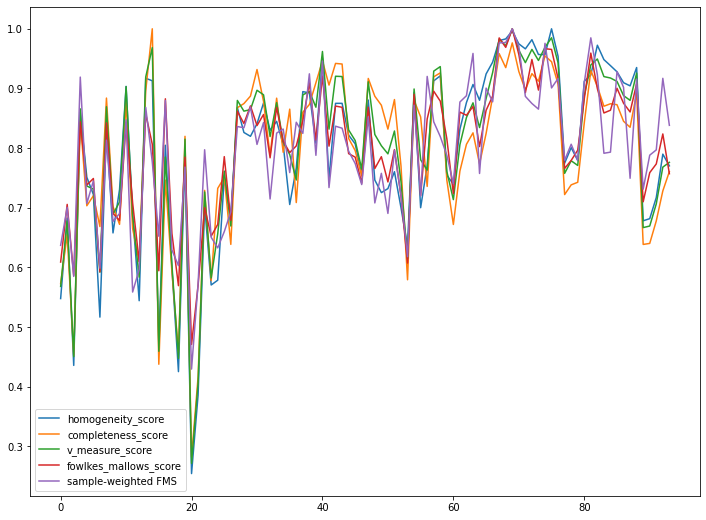

[INFO 06-05 00:06:22] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


    Generation Step Generation Model  Trial Index Trial Status  \
0                 0            Sobol            0    COMPLETED   
1                 0            Sobol            1    COMPLETED   
2                 0            Sobol            2    COMPLETED   
3                 0            Sobol            3    COMPLETED   
4                 0            Sobol            4    COMPLETED   
..              ...              ...          ...          ...   
95                1             GPEI           95    COMPLETED   
96                1             GPEI           96    COMPLETED   
97                1             GPEI           97    COMPLETED   
98                1             GPEI           98    COMPLETED   
99                1             GPEI           99    COMPLETED   

                                Arm Parameterizations  
0   {'0_0': {'b0': 2.01, 'c0': 4.31, 'dl0': 13.65,...  
1   {'1_0': {'b0': 7.47, 'c0': 4.02, 'dl0': 12.55,...  
2   {'2_0': {'b0': 2.57, 'c0': 3.34, 'd

<Figure size 432x288 with 0 Axes>

In [93]:
fig, ax = plt.subplots()
fig.set_size_inches(12,9)
for i in [0,1,2,5,9]:
    values =[al[i][1] for al in all_metrics] 
    ax.plot(values / np.max(values), label=all_metrics[0][i][0])
ax.legend()
plt.show()
plt.savefig(fn_result+"param_evol.png")

print(axc.generation_strategy.trials_as_df)
render(axc.get_optimization_trace())

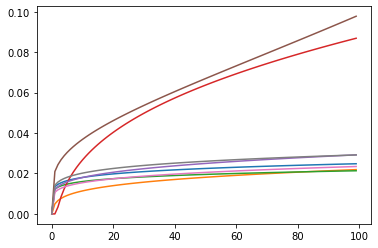

In [94]:
best_parameters, values = axc.get_best_parameters()
from astrobf.tmo import Mantiuk_Seidel
for i in range(ngroups):
    plt.plot(Mantiuk_Seidel(np.linspace(0,100,100), **mucl.ext_single_param(best_parameters, f"{i}")))
    

parameters들 normalize가 안 된듯?? 
각각의 모양은 그럴싸함. 

## Prototypical samples

In [95]:
from astrobf import analysis

best_parameters, values = axc.get_best_parameters()

plist = []
for i in range(ngroups):
    plist.append(mucl.ext_single_param(best_parameters, f"{i}"))
best_results = Full_exp.run_morph_in_parts(sub_gals, subcat, plist, ngroups)

#best_results = custom_morph.step_simple_morph(all_gals, best_parameters)
Full_exp.add_ttype(best_results, subcat)

best_eval_metrics, best_clustering = Full_exp.do_ML(best_results, partial(labeler, bins=this_bin), subcat,
                                         fields=['gini', 'm20'], 
                                         n_clusters=ngroups,
                                         return_cluster=True,
                                         cluster_method="ward",
                                         eval_weight='area')

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True


800


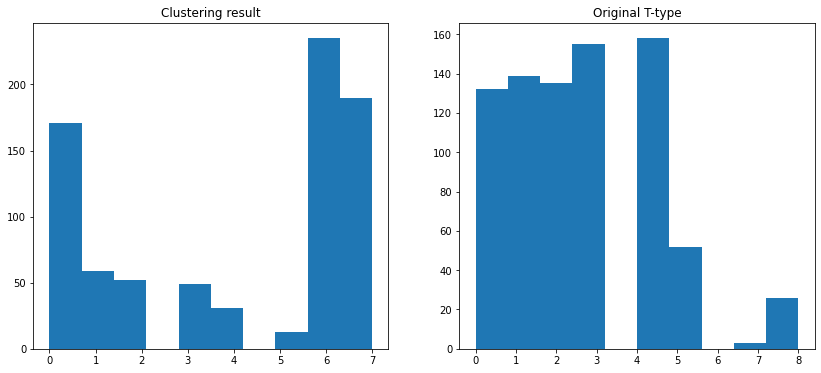

In [97]:
print(len(best_clustering.labels_))
fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,6)

axs[0].hist(best_clustering.labels_)
axs[0].set_title("Clustering result")
axs[1].hist(labeler(subcat, bins=this_bin, field='TT'))
axs[1].set_title("Original T-type")

plt.savefig("clustering_result_vs_original_pop.png")
plt.show()

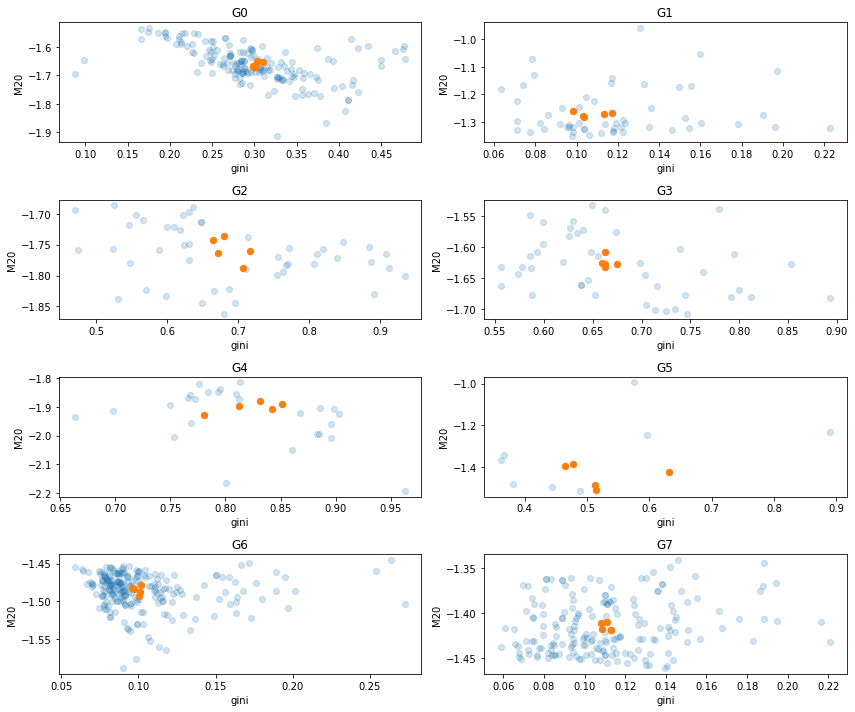

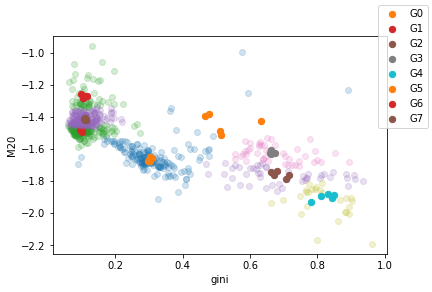

In [98]:
# Get centroids (typicals)
typicals = []

fig, axs = plt.subplots(4,2)
axs = axs.ravel()
fig.set_size_inches(12,10)

fig_sum, ax_sum = plt.subplots()
for i in range(ngroups):
    ax = axs[i]
    group = best_results[best_clustering.labels_ == i]
    
    t_ind = analysis.utils.get_typical_ind(group, n_samples=5)
    ax.scatter(group['gini'], group['m20'], alpha=0.2)
    ax.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40)
    ax.set_xlabel("gini")
    ax.set_ylabel("M20")
    ax.set_title(f"G{i}")
    
    typicals.append([gal for gal in sub_gals if gal['img_name'] in group['id'][t_ind]])
    
    
    # all in one plot
    ax_sum.scatter(group['gini'], group['m20'], alpha=0.2)
    ax_sum.scatter(group['gini'][t_ind], group['m20'][t_ind], s=40, label=f"G{i}")
    ax_sum.set_xlabel("gini")
    ax_sum.set_ylabel("M20")


fig.tight_layout()
fig_sum.legend()
plt.show()

In [21]:
mucl.plot_group_comparison(typicals, plist, ngroups,
                          fn=exp_dir+fn_result+"groups_comp.png")

mucl.plot_group_comparison(typicals, plist, ngroups, simple_log=True,
                          fn=exp_dir+fn_result+"groups_log.png")


/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py:80: RuntimeWarning:

divide by zero encountered in log10



## Typical sampes at incremental points 

### Get the 'incremental' points

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-24-783fddf5bd3a>:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



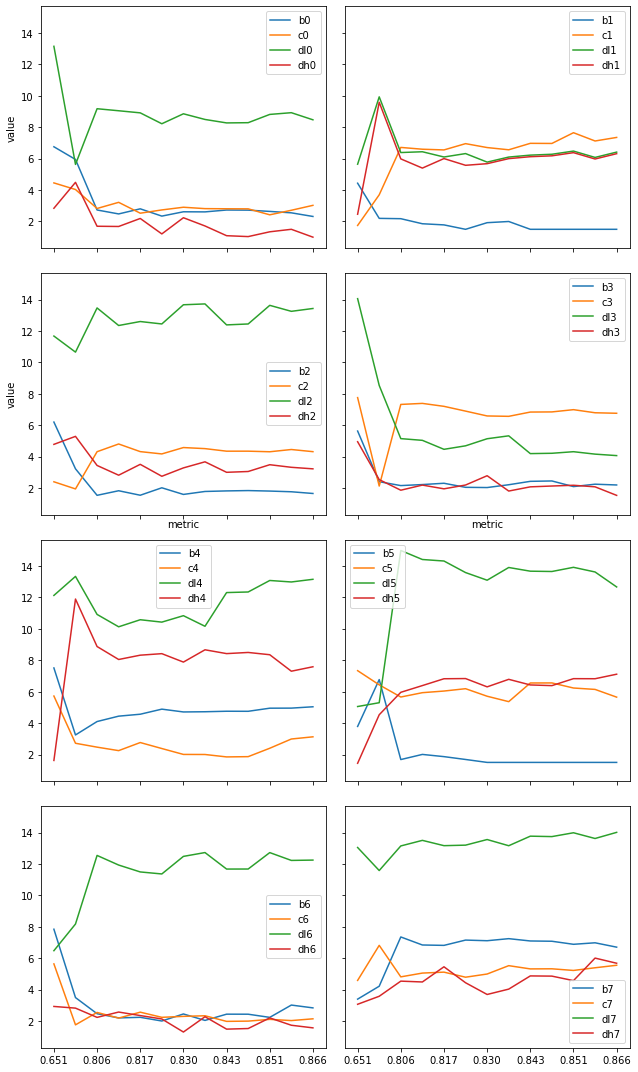

In [24]:
trace, t_ = axc.get_optimization_trace()

scores = np.array(trace['data'][0]['y'])
i_incr = [np.argmax(sc == scores) for sc in np.unique(scores)]

incr_params = [axc.get_trial_parameters(i) for i in i_incr]

# Change of the parameters over time
param_arr = np.zeros(len(incr_params), dtype=[(key, 'f') for key in incr_params[0].keys()])

for i, params in enumerate(incr_params):
    for key, val in params.items():
        param_arr[key][i] = val

fig,axs = plt.subplots(4,2, sharex=True, sharey=True)
fig.set_size_inches(9,15)
axs = axs.ravel()
for i in range(ngroups):    
    ax = axs[i]
    for field in param_arr.dtype.names:
        if f"{i}" in field:
            ax.plot(param_arr[field], label=field)

    ax.set_xticklabels([f"{scores[i]:.3f}" for i in i_incr])
    ax.legend()
axs[2].set_xlabel("metric")
axs[3].set_xlabel("metric")
axs[0].set_ylabel("value")
axs[2].set_ylabel("value")
plt.tight_layout()
plt.savefig(fn_result+"param_evol.png")
plt.show()

Interestingly, the changes are somewhat unpredictable.

### Typical samples at each incremental point

TODO : support arbitrary numebr of clusters. 

In [162]:
importlib.reload(mucl)

<module 'astrobf.analysis.multi_clustering' from '/home/hoseung/Work/tonemap/astroBF/astrobf/analysis/multi_clustering.py'>

In [25]:
# Typicals defined above

clu_best = [best_results[best_clustering.labels_ == i] for i in range(ngroups)] 
typical_best_results = [analysis.utils.get_matched_result(best_results, 
                                               [gal['img_name'] for gal in tt]) for tt in typicals]

for i, this_params in enumerate(incr_params):
    
    plist = [mucl.ext_single_param(this_params, f"{i}") for i in range(ngroups)]
    
    mucl.plot_group_comparison(typicals, plist, ngroups,
                          fn=fn_result+f'typical_{i}.png',
                          suptitle=f"scroe: {scores[i_incr[i]]:.4f}")

    this_results = Full_exp.run_morph_in_parts(sub_gals, subcat, plist, ngroups)
    Full_exp.add_ttype(this_results, subcat)

    eval_metrics, this_clustering = Full_exp.do_ML(this_results, partial(labeler, bins=this_bin), subcat,
                                     fields=['gini', 'm20'], 
                                     n_clusters=ngroups,
                                     return_cluster=True,
                                     cluster_method=cluster_method,
                                     eval_weight='area')

    typical_this_results = [(analysis.utils.get_matched_result(this_results, 
                                               [gal['img_name'] for gal in tt])) for tt in typicals]
    clu_this = [this_results[this_clustering.labels_ == i] for i in range(ngroups)] 
    mucl.plot_group_evals_w_centers(clu_best, 
                           typical_best_results,
                           clu_this, 
                           typical_this_results,
                           fn=fn_result+f"G_M{i}.png")

    mucl.plot_classification_vs_answer(this_results, clu_best, partial(labeler, bins=this_bin),
                                    fn=fn_result+f"current_in_best_color{i}.png")

/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


/home/hoseung/Work/tonemap/astroBF/astrobf/tmo.py:263: RuntimeWarning:

divide by zero encountered in log10

/home/hoseung/Work/tonemap/astroBF/astrobf/run/Full_exp.py:131: FutureWarning:

elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.



Is every element matched?:  True
# labels [0 1 3 4 5 6 7]


## Backup

In [17]:
from functools import partial

def evaluate_org(params, cluster_method="agglomerate", eval_method='sample-weighted FMS'):
    plist =[{'b':params[f'b{i}'],
             'c':params[f'c{i}'],
            'dl':params[f'dl{i}'],
            'dh':params[f'dh{i}']} for i in range(ngroups)]

    result_list = []
    for i in range(ngroups):
        result_list.append(custom_morph.step_simple_morph(sub_gals, 
                                                          plist[i], 
                                                          np.where(subcat['label'] == i)[0]))
        if "bad" in result_list[-1]:
            return {"mymetric": (-1, 0), "total_flux":(0,0)}
    
    # merge and sort
    result_arr = np.concatenate(result_list)
    result_arr = result_arr[np.argsort(result_arr['id'])] # Sort first to apply 'searchsorted'
    inds = result_arr['id'].searchsorted(subcat["ID"])
    result_arr = result_arr[inds]
    
    Full_exp.add_ttype(result_arr, subcat)
    
    eval_metrics = Full_exp.do_ML(result_arr, partial(labeler, bins=this_bin), subcat, n_clusters=ngroups,
                                  fields=['gini', 'm20'], 
                                  cluster_method=cluster_method,
                                  eval_weight='area')
    
    # save all metrics to a global list.
    all_metrics.append(eval_metrics)
    #mymetric = eval_metrics[0][1] # Homogenity
    clustering_score = [val for (name, val) in eval_metrics if name == eval_method][0]
    stderr = 0.0
    return {"mymetric": (clustering_score, stderr), "total_flux":(1,0)}